## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import GCNConv, Sequential as GraphSequential
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics
from rdkit import Chem
import matplotlib.pyplot as plt
from tqdm import tqdm

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/geno/geno_smiles_train.csv")
df_test = pd.read_csv("../../data/train/geno/geno_smiles_test.csv")
df_valid = pd.read_csv("../../data/train/geno/geno_smiles_valid.csv")
df_train_all = pd.concat([df_train, df_valid])

In [4]:
df_test

,smiles,genotoxicity
0,COc1ccc(C(=O)Nn2c(SCC(=O)NC3CCCC3)nc3ccccc3c2=...,6.536256
1,CCCc1n[nH]c2c1C(c1ccc(Br)s1)C(C#N)=C(N)O2,4.686213
2,CC(C=Cc1ccccc1F)=NNC(=O)c1ccccc1,5.186392
3,COc1ccc(S(=O)(=O)N2CCCc3ccccc32)cc1OC,4.636390
4,CSc1c(C#N)c(N)c(C#N)c2c1COC(C)(C)C2,4.686213
...,...,...
4979,Cc1ccnc(NC(=O)CN2C(=O)NC(C)(c3ccc4ccccc4c3)C2=...,5.736388
4980,N=C(NOC(=O)c1ccc2c(c1)OCO2)c1ccc(Cl)cc1,4.636213
4981,CCOC(=O)c1sc2nc(-c3ccccc3)ccc2c1N,6.286174
4982,CC1=NOC(=O)C1=Cc1ccc2c(c1)OCO2,4.486391


In [5]:
df_valid

,smiles,genotoxicity
0,Cc1ccc(C(=O)COC(=O)c2ccc(O)cc2)cc1,4.936389
1,Cn1c(CCNC(=O)c2ccco2)nc2cc(NC(=O)c3ccco3)ccc21,4.736212
2,Cc1nn(-c2ccccc2)c(O)c1C=NCc1ccco1,4.786389
3,CN(C)CCN(C(=O)c1ccc(S(=O)(=O)N(C)c2ccccc2)cc1)...,5.436388
4,COCCNC(=O)c1cc(-c2ccc(OC)c(OC)c2)on1,4.636213
...,...,...
2486,CCCCCCCCCC(=O)NN=Cc1ccc(C)s1,4.550000
2487,Cc1occc1C(=O)Nc1nnc(C2CCCCC2)s1,4.949999
2488,CCOC(=O)c1nn(-c2ccc(C)cc2)cc1C(=O)c1ccccc1,5.586214
2489,COc1ccc(-c2cn3nc(SCC(=O)NC4CCCCC4)ccc3n2)cc1,5.586399


## 3. Metrics

In [3]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 4. Featurizer 🧪

In [4]:
# Feauterizer from course "Machine Learning in Drug Design" at Jagiellonian University, Kraków, Poland.

class Featurizer:
    def __init__(self, y_column, **kwargs):
        self.y_column = y_column
        self.__dict__.update(kwargs)
    
    def __call__(self, df):
        raise NotImplementedError()

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise ValueError("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
        

class GraphFeaturizer(Featurizer):
    def __call__(self, df):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row.smiles
            mol = Chem.MolFromSmiles(smiles)
            
            edges = []
            for bond in mol.GetBonds():
                edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
                edges.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])
            edges = np.array(edges)
            
            nodes = []
            for atom in mol.GetAtoms():
                results = one_of_k_encoding_unk(
                    atom.GetSymbol(),
                    [
                        'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Unknown'
                    ]
                ) + one_of_k_encoding(
                    atom.GetDegree(),
                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                ) + one_of_k_encoding_unk(
                    atom.GetImplicitValence(),
                    [0, 1, 2, 3, 4, 5, 6]
                ) + [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + one_of_k_encoding_unk(
                    atom.GetHybridization(),
                    [
                        Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                        Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                        Chem.rdchem.HybridizationType.SP3D2
                    ]
                ) + [atom.GetIsAromatic()] + one_of_k_encoding_unk(
                    atom.GetTotalNumHs(),
                    [0, 1, 2, 3, 4]
                )
                nodes.append(results)
            nodes = np.array(nodes)
            
            graphs.append((nodes, edges.T))
            labels.append(y)
        labels = np.array(labels)
        return graphs, labels

## 5. Graph Dataset

In [5]:
class GraphDataset(InMemoryDataset):  
    def __init__(self, X, y, root, transform=None, pre_transform=None):
        self.dataset = (X, y)
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['data.pt']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        x_g, edge_index_g =list(zip(*self.dataset[0]))

        data = [Data(
            x=torch.FloatTensor(x),
            edge_index=torch.LongTensor(edge_index),
            y = y) for x, edge_index, y in zip(x_g,edge_index_g,self.dataset[1])
        ]

        torch.save(data, self.raw_paths[0])


    def process(self):
        data_list = torch.load(self.raw_paths[0])

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        


In [6]:
featurizer = GraphFeaturizer(y_column='genotoxicity')

X_train, y_train = featurizer(df_train)
X_test, y_test = featurizer(df_test)
X_valid, y_valid = featurizer(df_valid)
X_train_all, y_train_all = featurizer(df_train_all)

In [7]:
train_dataset = GraphDataset(X_train_all, y_train_all.reshape(-1, 1), root='geno-train')
test_dataset = GraphDataset(X_test, y_test.reshape(-1, 1), root='geno-test')
valid_dataset = GraphDataset(X_valid, y_valid.reshape(-1, 1), root='geno-valid')
train_dataset_small = GraphDataset(X_train, y_train.reshape(-1, 1), root='geno-train_small')

# 6. Model

![Graph](images/graph_net.png)

In [8]:
class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(GraphNeuralNetwork, self).__init__()
        torch.manual_seed(42)
        self.final_conv_acts = None
        self.final_conv_grads = None

        self.conv1 = GCNConv(42, 100)
        self.conv2 = GCNConv(100, 400)
        self.conv3 = GCNConv(400, 200)
        self.conv4 = GCNConv(200, 100)

        self.out = nn.Linear(100, 50)
        self.out2 = nn.Linear(50, 1)
    
    def activations_hook(self, grad):
        self.final_conv_grads = grad

    def forward(self, x, edge_index, batch_index):
        out = self.conv1(x, edge_index)
        out = F.relu(out)
        out = self.conv2(out, edge_index)
        out = F.relu(out)
        out = self.conv3(out, edge_index)
        out = F.relu(out)
        out = F.dropout(out, training=self.training) #p=0.5
        
        with torch.enable_grad():
            self.final_conv_acts = self.conv4(out, edge_index)
        self.final_conv_acts.register_hook(self.activations_hook)
        
        out = F.relu(self.final_conv_acts)
        out = gap(out, batch_index) # global_mean_pool
        out = self.out(out)
        out = F.relu(out)
        out = self.out2(out)

        return out

## 6.1 Grid search 🔎

In [13]:
lrs = [0.005, 0.01, 0.02]
batch_sizes = [32, 64, 128]

In [14]:
best_value = 1
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:

        model = GraphNeuralNetwork()

        train_loader = GraphDataLoader(train_dataset_small, batch_size=batch_size, shuffle=False)
        valid_loader = GraphDataLoader(valid_dataset, batch_size=2491, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []

        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0

            for data in tqdm(train_loader, leave=False):
                x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                optimizer.zero_grad()
                output = model(x, edge_index, batch)
                loss = criterion(output, torch.Tensor(y))
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(y, output.cpu().detach().numpy())   

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0    

            with torch.no_grad():
                for data in tqdm(valid_loader):
                    x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                    output = model(x, edge_index, batch)
                    test_loss += criterion(output, torch.Tensor(y)).item()
                    test_correct += metrics.r2_score(y, output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

  1%|          | 3/545 [00:00<00:25, 21.12it/s]

Model: lr 0.005, batch_size 32
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5534468404470234, Accuracy: -1.2914226353981746


  1%|          | 3/545 [00:00<00:23, 22.70it/s]

Test Avg. loss: 0.2306288182735443, Accuracy: 0.03656104743508781
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2889633950427038, Accuracy: -0.28263166290854336


  1%|          | 3/545 [00:00<00:22, 24.17it/s]

Test Avg. loss: 0.2523377239704132, Accuracy: -0.054126652393970076
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28368858139996134, Accuracy: -0.26148436258332175


  1%|          | 3/545 [00:00<00:25, 20.86it/s]

Test Avg. loss: 0.23870721459388733, Accuracy: 0.002814069750640358
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2632713288342187, Accuracy: -0.1413125103106929


  1%|          | 3/545 [00:00<00:23, 22.66it/s]

Test Avg. loss: 0.2545144557952881, Accuracy: -0.06321980608651434
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25925352268536156, Accuracy: -0.1321910607095254


  1%|          | 3/545 [00:00<00:24, 22.06it/s]

Test Avg. loss: 0.2683739960193634, Accuracy: -0.12111712525276941
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24881651620252418, Accuracy: -0.07254029144054266


  1%|          | 3/545 [00:00<00:23, 23.32it/s]

Test Avg. loss: 0.29132920503616333, Accuracy: -0.21701123234916198
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2464255057617065, Accuracy: -0.06216704953470001


  1%|          | 3/545 [00:00<00:26, 20.79it/s]

Test Avg. loss: 0.29075077176094055, Accuracy: -0.21459502077130121
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24363372130404917, Accuracy: -0.05058812813949858


  1%|          | 3/545 [00:00<00:25, 21.40it/s]

Test Avg. loss: 0.26377028226852417, Accuracy: -0.10188540504295629
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24010061620298875, Accuracy: -0.03335480081543918


  1%|          | 3/545 [00:00<00:23, 23.34it/s]

Test Avg. loss: 0.2984483540058136, Accuracy: -0.24675113384503033
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23692573538613976, Accuracy: -0.020816954854448455


  1%|          | 3/545 [00:00<00:26, 20.76it/s]

Test Avg. loss: 0.24087442457675934, Accuracy: -0.00623926943923947
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23484792336138016, Accuracy: -0.011316186456185498


  1%|          | 3/545 [00:00<00:22, 24.47it/s]

Test Avg. loss: 0.25281885266304016, Accuracy: -0.05613654091550613
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23409302475255564, Accuracy: -0.008464208088827823


  1%|          | 3/545 [00:00<00:26, 20.65it/s]

Test Avg. loss: 0.2411520779132843, Accuracy: -0.007399121749072979
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23369902202842432, Accuracy: -0.007068476755299025


  1%|          | 3/545 [00:00<00:26, 20.81it/s]

Test Avg. loss: 0.25122588872909546, Accuracy: -0.04948196644193992
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2324161964818972, Accuracy: -0.0020428307670855603


  1%|          | 3/545 [00:00<00:25, 21.36it/s]

Test Avg. loss: 0.2444542497396469, Accuracy: -0.021193821892317777
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23169691749942412, Accuracy: -0.0005917055099326648


  1%|          | 3/545 [00:00<00:26, 20.61it/s]

Test Avg. loss: 0.24925437569618225, Accuracy: -0.041246034535981524
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23012145257324254, Accuracy: 0.006995836529215748


  1%|          | 3/545 [00:00<00:25, 21.59it/s]

Test Avg. loss: 0.23745018243789673, Accuracy: 0.008065248464650843
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2282597946054345, Accuracy: 0.015275255655174198


  0%|          | 2/545 [00:00<00:27, 19.94it/s]

Test Avg. loss: 0.2799462378025055, Accuracy: -0.16945956102831916
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2277836509800832, Accuracy: 0.01709424940638021


  1%|          | 3/545 [00:00<00:23, 22.78it/s]

Test Avg. loss: 0.2344631403684616, Accuracy: 0.020543498364230417
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22676550110272312, Accuracy: 0.019648618180416424


  1%|          | 3/545 [00:00<00:22, 23.92it/s]

Test Avg. loss: 0.24084997177124023, Accuracy: -0.00613717513646872
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22580392154258325, Accuracy: 0.024717147236482367


  1%|          | 3/545 [00:00<00:24, 21.92it/s]

Test Avg. loss: 0.24293570220470428, Accuracy: -0.014850195260674326
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22426622288489562, Accuracy: 0.031241831520391162


  1%|          | 3/545 [00:00<00:24, 22.58it/s]

Test Avg. loss: 0.2350134253501892, Accuracy: 0.018244674703589703
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22239246669165585, Accuracy: 0.03956898605922711


  1%|          | 3/545 [00:00<00:23, 23.52it/s]

Test Avg. loss: 0.24158376455307007, Accuracy: -0.009202573622359544
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22170759535163914, Accuracy: 0.0409619592350124


  1%|          | 3/545 [00:00<00:24, 21.93it/s]

Test Avg. loss: 0.23475715517997742, Accuracy: 0.019315146013761053
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2202455048987625, Accuracy: 0.04615027692918925


  1%|          | 3/545 [00:00<00:23, 23.14it/s]

Test Avg. loss: 0.24354955554008484, Accuracy: -0.017414478078669138
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2192314249864959, Accuracy: 0.05197687703970703


  1%|          | 3/545 [00:00<00:25, 20.98it/s]

Test Avg. loss: 0.23174625635147095, Accuracy: 0.031893215867734526
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2170644412483644, Accuracy: 0.061957849098844296


  0%|          | 2/545 [00:00<00:27, 19.88it/s]

Test Avg. loss: 0.23807170987129211, Accuracy: 0.005468891204616688
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2168570139676059, Accuracy: 0.06258435694195612


  1%|          | 3/545 [00:00<00:24, 22.52it/s]

Test Avg. loss: 0.2418866604566574, Accuracy: -0.010467822409107486
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21517031245412083, Accuracy: 0.06873126714502042


  1%|          | 3/545 [00:00<00:24, 21.92it/s]

Test Avg. loss: 0.23016788065433502, Accuracy: 0.03848671748515664
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21459726093832507, Accuracy: 0.06863538531436796


  0%|          | 2/545 [00:00<00:27, 19.67it/s]

Test Avg. loss: 0.2261241227388382, Accuracy: 0.055379296754426544
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21391212315460958, Accuracy: 0.07210162113597625


  1%|          | 3/545 [00:00<00:25, 21.30it/s]

Test Avg. loss: 0.23000411689281464, Accuracy: 0.03917078495822812
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21391671990309286, Accuracy: 0.0726714732952919


  1%|          | 3/545 [00:00<00:25, 21.29it/s]

Test Avg. loss: 0.22416941821575165, Accuracy: 0.06354498448455315
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.213083493723235, Accuracy: 0.0768253311309697


  1%|          | 3/545 [00:00<00:23, 23.43it/s]

Test Avg. loss: 0.217152938246727, Accuracy: 0.09285588797622157
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21154773288637127, Accuracy: 0.08294705691349653


  1%|          | 3/545 [00:00<00:24, 22.31it/s]

Test Avg. loss: 0.22048000991344452, Accuracy: 0.078957131163093
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21176203094217755, Accuracy: 0.08324312730273169


  1%|          | 3/545 [00:00<00:26, 20.41it/s]

Test Avg. loss: 0.22483371198177338, Accuracy: 0.060769874316208616
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21191254214409294, Accuracy: 0.08421997754885675


  1%|          | 3/545 [00:00<00:22, 23.80it/s]

Test Avg. loss: 0.21098358929157257, Accuracy: 0.11862802217488999
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21033463247052026, Accuracy: 0.08986436055562638


  0%|          | 2/545 [00:00<00:27, 19.64it/s]

Test Avg. loss: 0.21039366722106934, Accuracy: 0.12109236067025075
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21072640118248967, Accuracy: 0.08666008952524552


  1%|          | 3/545 [00:00<00:23, 23.27it/s]

Test Avg. loss: 0.2166213095188141, Accuracy: 0.09507668434517957
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20892935722656206, Accuracy: 0.09621102263856877


  1%|          | 3/545 [00:00<00:23, 23.56it/s]

Test Avg. loss: 0.21341697871685028, Accuracy: 0.10846261243969524
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20709497657937742, Accuracy: 0.10175999065206298


  1%|          | 3/545 [00:00<00:24, 22.57it/s]

Test Avg. loss: 0.2196456789970398, Accuracy: 0.08244258637387836
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2073333207893809, Accuracy: 0.09978489214451014


  1%|          | 3/545 [00:00<00:22, 23.77it/s]

Test Avg. loss: 0.21955011785030365, Accuracy: 0.08284183406881507
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20835620094466648, Accuracy: 0.09748306685020626


  1%|          | 3/545 [00:00<00:24, 22.56it/s]

Test Avg. loss: 0.21966472268104553, Accuracy: 0.08236311159719412
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2074781174643324, Accuracy: 0.10058286129261987


  0%|          | 2/545 [00:00<00:27, 19.77it/s]

Test Avg. loss: 0.2022956907749176, Accuracy: 0.1549211300779334
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20687230270390117, Accuracy: 0.10382360027909061


  1%|          | 3/545 [00:00<00:24, 22.45it/s]

Test Avg. loss: 0.2173221856355667, Accuracy: 0.09214888916599628
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2071735565678789, Accuracy: 0.10251112204439586


  1%|          | 3/545 [00:00<00:24, 22.35it/s]

Test Avg. loss: 0.21356219053268433, Accuracy: 0.10785604671962079
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20632461109839448, Accuracy: 0.10780330769553119


  1%|          | 3/545 [00:00<00:23, 22.64it/s]

Test Avg. loss: 0.20888838171958923, Accuracy: 0.12738057584807272
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2073533703427796, Accuracy: 0.10381914864574503


  1%|          | 3/545 [00:00<00:25, 21.12it/s]

Test Avg. loss: 0.20719222724437714, Accuracy: 0.1344661626885405
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2049432402220341, Accuracy: 0.11294518162305422


  1%|          | 3/545 [00:00<00:25, 21.01it/s]

Test Avg. loss: 0.20691609382629395, Accuracy: 0.13561960904567183
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20528241026838986, Accuracy: 0.11044201694938219


  1%|          | 3/545 [00:00<00:26, 20.61it/s]

Test Avg. loss: 0.20658579468727112, Accuracy: 0.13699941963782092
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20543945740669145, Accuracy: 0.11155213667414146


  1%|          | 3/545 [00:00<00:24, 22.35it/s]

Test Avg. loss: 0.20860321819782257, Accuracy: 0.12857180364972953
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20539252461369978, Accuracy: 0.11003383546670659


  1%|          | 3/545 [00:00<00:24, 21.96it/s]

Test Avg. loss: 0.20864242315292358, Accuracy: 0.12840808173764096
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20305124973758645, Accuracy: 0.11999813798788389


  1%|          | 3/545 [00:00<00:22, 23.91it/s]

Test Avg. loss: 0.20350190997123718, Accuracy: 0.14988228591517083
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20281704554864027, Accuracy: 0.11836455573858398


  1%|          | 3/545 [00:00<00:25, 21.01it/s]

Test Avg. loss: 0.21334825456142426, Accuracy: 0.1087497784628988
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20386710533308328, Accuracy: 0.11792450361559711


  1%|          | 3/545 [00:00<00:25, 20.95it/s]

Test Avg. loss: 0.20057836174964905, Accuracy: 0.16209515239178407
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2027762392792133, Accuracy: 0.11814726702219683


  1%|          | 3/545 [00:00<00:24, 21.82it/s]

Test Avg. loss: 0.20966769754886627, Accuracy: 0.1241250435171527
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20112691657668955, Accuracy: 0.12660525878002674


  1%|          | 3/545 [00:00<00:25, 21.49it/s]

Test Avg. loss: 0.1977384388446808, Accuracy: 0.1739588732038705
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20148918296492427, Accuracy: 0.12398183584111387


  1%|          | 3/545 [00:00<00:23, 22.59it/s]

Test Avg. loss: 0.20424681901931763, Accuracy: 0.14677039638003475
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20030501923703273, Accuracy: 0.13032568979434578


  1%|          | 3/545 [00:00<00:25, 21.27it/s]

Test Avg. loss: 0.1984708607196808, Accuracy: 0.17089913442833737
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20201859158386878, Accuracy: 0.121968727740981


  1%|          | 3/545 [00:00<00:25, 21.35it/s]

Test Avg. loss: 0.19996409118175507, Accuracy: 0.1646613329325599
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.199974684109655, Accuracy: 0.1324964861979308


  1%|          | 3/545 [00:00<00:22, 23.66it/s]

Test Avg. loss: 0.20355893671512604, Accuracy: 0.14964401733955235
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20169104397843737, Accuracy: 0.12471795689013651


  1%|          | 3/545 [00:00<00:25, 21.50it/s]

Test Avg. loss: 0.19760951399803162, Accuracy: 0.1744973458003417
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19988100127479352, Accuracy: 0.126791140769004


  1%|          | 3/545 [00:00<00:25, 20.96it/s]

Test Avg. loss: 0.20011749863624573, Accuracy: 0.16402040922655092
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2016478463323838, Accuracy: 0.1225491812817418


  1%|          | 3/545 [00:00<00:24, 22.53it/s]

Test Avg. loss: 0.20151950418949127, Accuracy: 0.15816362530162664
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1997548087542757, Accuracy: 0.13283547676389845


  0%|          | 2/545 [00:00<00:28, 19.22it/s]

Test Avg. loss: 0.20441868901252747, Accuracy: 0.14605241265432356
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20022407252033916, Accuracy: 0.12805790193598246


  1%|          | 3/545 [00:00<00:23, 22.82it/s]

Test Avg. loss: 0.19913606345653534, Accuracy: 0.16812025992322654
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19841528706457637, Accuracy: 0.13397901204119145


  1%|          | 3/545 [00:00<00:26, 20.64it/s]

Test Avg. loss: 0.19964002072811127, Accuracy: 0.16601508896276929
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1982260829811796, Accuracy: 0.1345136513028482


  1%|          | 3/545 [00:00<00:23, 23.09it/s]

Test Avg. loss: 0.20161545276641846, Accuracy: 0.1577628511340412
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1974452567551661, Accuracy: 0.13986320369245528


  1%|          | 3/545 [00:00<00:24, 22.47it/s]

Test Avg. loss: 0.2042858898639679, Accuracy: 0.14660726659145784
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19846520720545305, Accuracy: 0.13563414475655208


  0%|          | 2/545 [00:00<00:27, 19.89it/s]

Test Avg. loss: 0.20131762325763702, Accuracy: 0.15900697290842747
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19742088532502497, Accuracy: 0.14239963252371685


  1%|          | 3/545 [00:00<00:24, 21.69it/s]

Test Avg. loss: 0.20053228735923767, Accuracy: 0.16228769725364112
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19778368023967524, Accuracy: 0.13726010614853706


  1%|          | 3/545 [00:00<00:24, 21.74it/s]

Test Avg. loss: 0.20978152751922607, Accuracy: 0.12364949077630127
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1967611315463661, Accuracy: 0.14216335219292975


  1%|          | 3/545 [00:00<00:23, 23.23it/s]

Test Avg. loss: 0.19796505570411682, Accuracy: 0.17301213324636655
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19679060149083444, Accuracy: 0.143354610965799


  1%|          | 3/545 [00:00<00:24, 22.28it/s]

Test Avg. loss: 0.20329588651657104, Accuracy: 0.15074283394471866
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19522345275917186, Accuracy: 0.14858391367190876


  1%|          | 3/545 [00:00<00:23, 23.30it/s]

Test Avg. loss: 0.19569557905197144, Accuracy: 0.1824927509729165
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1955962536531851, Accuracy: 0.14859562810306542


  1%|          | 3/545 [00:00<00:23, 23.36it/s]

Test Avg. loss: 0.20063416659832, Accuracy: 0.16186214153076994
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19734015090203066, Accuracy: 0.14174052088476988


  1%|          | 3/545 [00:00<00:23, 22.82it/s]

Test Avg. loss: 0.19992686808109283, Accuracy: 0.16481682091519578
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19704129141541796, Accuracy: 0.1427319520870831


  1%|          | 3/545 [00:00<00:22, 24.07it/s]

Test Avg. loss: 0.20099815726280212, Accuracy: 0.16034156978848424
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1957260351935658, Accuracy: 0.14598363651767512


  1%|          | 3/545 [00:00<00:23, 23.03it/s]

Test Avg. loss: 0.20105622708797455, Accuracy: 0.16009893811210996
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19337356877983164, Accuracy: 0.15448108898756982


  1%|          | 3/545 [00:00<00:24, 21.91it/s]

Test Avg. loss: 0.19566884636878967, Accuracy: 0.1826044027766952
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.193948417040733, Accuracy: 0.15238714979720006


  1%|          | 3/545 [00:00<00:25, 21.02it/s]

Test Avg. loss: 0.20250222086906433, Accuracy: 0.15405834958945164
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19584795605698857, Accuracy: 0.14686868642507148


  1%|          | 3/545 [00:00<00:22, 23.74it/s]

Test Avg. loss: 0.20279361307621002, Accuracy: 0.15284113122687026
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19425749724747937, Accuracy: 0.15467814941090058


  1%|          | 3/545 [00:00<00:25, 21.18it/s]

Test Avg. loss: 0.19594994187355042, Accuracy: 0.18143017060887268
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19197206947644915, Accuracy: 0.16120600777160776


  1%|          | 3/545 [00:00<00:22, 24.47it/s]

Test Avg. loss: 0.20458495616912842, Accuracy: 0.14535788795541182
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19348982884933094, Accuracy: 0.15375468016280514


  1%|          | 3/545 [00:00<00:23, 23.30it/s]

Test Avg. loss: 0.20055042207241058, Accuracy: 0.16221193125053168
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19346451832477105, Accuracy: 0.15537290609557652


  0%|          | 2/545 [00:00<00:27, 19.56it/s]

Test Avg. loss: 0.19792357087135315, Accuracy: 0.17318546607382157
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19103325769441937, Accuracy: 0.16591851914917646


  1%|          | 3/545 [00:00<00:25, 21.68it/s]

Test Avg. loss: 0.20281976461410522, Accuracy: 0.15273188974961027
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19173865563689022, Accuracy: 0.1619118334359933


  1%|          | 3/545 [00:00<00:24, 21.69it/s]

Test Avg. loss: 0.19669172167778015, Accuracy: 0.17833144654471633
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1924186868678539, Accuracy: 0.16160836953727686


  0%|          | 2/545 [00:00<00:27, 19.69it/s]

Test Avg. loss: 0.19513824582099915, Accuracy: 0.18482097739007697
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19200654299160755, Accuracy: 0.1624857958555891


  1%|          | 3/545 [00:00<00:23, 23.10it/s]

Test Avg. loss: 0.19994215667247772, Accuracy: 0.16475297213683127
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19001650885431046, Accuracy: 0.17190223891728496


  0%|          | 2/545 [00:00<00:27, 19.79it/s]

Test Avg. loss: 0.20320816338062286, Accuracy: 0.15110940757633096
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1925277820899399, Accuracy: 0.15965261984019075


  1%|          | 3/545 [00:00<00:23, 22.78it/s]

Test Avg. loss: 0.19552181661128998, Accuracy: 0.18321863647441095
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19340597784163754, Accuracy: 0.15778303676225586


  1%|          | 3/545 [00:00<00:25, 21.65it/s]

Test Avg. loss: 0.2000517100095749, Accuracy: 0.16429533663665274
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1923836961388588, Accuracy: 0.16199921837887057


  0%|          | 2/545 [00:00<00:27, 19.95it/s]

Test Avg. loss: 0.19742470979690552, Accuracy: 0.17526940739003694
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19137616590895784, Accuracy: 0.16132701996647816


  1%|          | 3/545 [00:00<00:25, 21.21it/s]

Test Avg. loss: 0.19726483523845673, Accuracy: 0.1759372183479484
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18940436805196859, Accuracy: 0.17282404381182367


  1%|          | 3/545 [00:00<00:25, 20.93it/s]

Test Avg. loss: 0.1974955052137375, Accuracy: 0.17497367503074845
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18972956635946528, Accuracy: 0.16848678010824744


  1%|          | 3/545 [00:00<00:25, 21.26it/s]

Test Avg. loss: 0.20198500156402588, Accuracy: 0.1562190500528069
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19011473643396973, Accuracy: 0.17291735003179787


  1%|          | 3/545 [00:00<00:25, 21.22it/s]

Test Avg. loss: 0.19869400560855865, Accuracy: 0.169966979779254
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18833498446219557, Accuracy: 0.17850430552409713


  1%|          | 3/545 [00:00<00:24, 21.89it/s]

Test Avg. loss: 0.1991177648305893, Accuracy: 0.16819683005253094
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18870690422594, Accuracy: 0.17500478695432828


  1%|          | 3/545 [00:00<00:23, 23.27it/s]

Test Avg. loss: 0.1987023800611496, Accuracy: 0.16993197085058998
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18767048579153664, Accuracy: 0.18090670554107624


  1%|          | 3/545 [00:00<00:25, 21.04it/s]

Test Avg. loss: 0.19570395350456238, Accuracy: 0.18245782679539269
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1876202688578072, Accuracy: 0.17800567946867263


  1%|          | 3/545 [00:00<00:24, 22.53it/s]

Test Avg. loss: 0.1971588134765625, Accuracy: 0.1763802332135639
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18860535048153423, Accuracy: 0.17372940469326237


  1%|          | 3/545 [00:00<00:25, 21.34it/s]

Test Avg. loss: 0.20732079446315765, Accuracy: 0.13392911471964075
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18754240225214477, Accuracy: 0.18030739451794175


  0%|          | 2/545 [00:00<00:27, 19.66it/s]

Test Avg. loss: 0.20638766884803772, Accuracy: 0.13782710804118947
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18808741405469562, Accuracy: 0.18067932315104554


  1%|          | 3/545 [00:00<00:24, 22.50it/s]

Test Avg. loss: 0.20520249009132385, Accuracy: 0.14277820892771365
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1893773383777076, Accuracy: 0.17167188575236483


  1%|          | 3/545 [00:00<00:25, 20.95it/s]

Test Avg. loss: 0.19838294386863708, Accuracy: 0.17126648160128954
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18819931268418602, Accuracy: 0.17550843083708723


  0%|          | 2/545 [00:00<00:27, 19.71it/s]

Test Avg. loss: 0.20302258431911469, Accuracy: 0.15188456717250398
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18819744107783387, Accuracy: 0.17806938632817207


  1%|          | 3/545 [00:00<00:24, 22.26it/s]

Test Avg. loss: 0.19677941501140594, Accuracy: 0.17796505246333794
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18839977954369072, Accuracy: 0.17640455810199282


  1%|          | 3/545 [00:00<00:24, 22.37it/s]

Test Avg. loss: 0.20597460865974426, Accuracy: 0.13955269994004693
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18512181406584355, Accuracy: 0.18819192005532565


  0%|          | 2/545 [00:00<00:27, 19.61it/s]

Test Avg. loss: 0.2020464986562729, Accuracy: 0.15596216280278186
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1878082895907787, Accuracy: 0.17968682753941181


  1%|          | 3/545 [00:00<00:25, 21.28it/s]

Test Avg. loss: 0.20021693408489227, Accuracy: 0.16360496608605124
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18934095174484297, Accuracy: 0.17317428825158568


  0%|          | 2/545 [00:00<00:27, 19.88it/s]

Test Avg. loss: 0.20836463570594788, Accuracy: 0.12956847372947455
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1848957883928894, Accuracy: 0.19356272502390603


  1%|          | 3/545 [00:00<00:25, 20.98it/s]

Test Avg. loss: 0.20094382762908936, Accuracy: 0.16056849710934873
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18669312031717475, Accuracy: 0.18255233248620323


  1%|          | 3/545 [00:00<00:24, 22.45it/s]

Test Avg. loss: 0.20276419818401337, Accuracy: 0.15296400720619352
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18635446042369266, Accuracy: 0.18734023521234214


  1%|          | 3/545 [00:00<00:26, 20.30it/s]

Test Avg. loss: 0.19671839475631714, Accuracy: 0.1782199321640151
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1865281599992459, Accuracy: 0.18358338827501786


  0%|          | 2/545 [00:00<00:27, 19.60it/s]

Test Avg. loss: 0.1951635479927063, Accuracy: 0.18471523785172606
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18625565478834538, Accuracy: 0.18365886237383786


  1%|          | 3/545 [00:00<00:23, 23.46it/s]

Test Avg. loss: 0.19749517738819122, Accuracy: 0.1749750561132314
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18529300206434837, Accuracy: 0.19012344276878887


  1%|          | 3/545 [00:00<00:24, 22.06it/s]

Test Avg. loss: 0.1987990438938141, Accuracy: 0.169528143083006
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18473445896161805, Accuracy: 0.19138032668888347


  1%|          | 3/545 [00:00<00:25, 21.31it/s]

Test Avg. loss: 0.20241737365722656, Accuracy: 0.15441284683512568
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18353134241946248, Accuracy: 0.19370141636991675


  1%|          | 3/545 [00:00<00:22, 24.59it/s]

Test Avg. loss: 0.19903941452503204, Accuracy: 0.16852405352097555
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1857949544325334, Accuracy: 0.18917897250224683


  1%|          | 3/545 [00:00<00:24, 22.19it/s]

Test Avg. loss: 0.1971627175807953, Accuracy: 0.1763637862943439
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1834980220764602, Accuracy: 0.1977930876933944


  1%|          | 3/545 [00:00<00:23, 22.87it/s]

Test Avg. loss: 0.20020009577274323, Accuracy: 0.16367533134926926
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18513034851452626, Accuracy: 0.18970312553640808


  0%|          | 2/545 [00:00<00:27, 19.72it/s]

Test Avg. loss: 0.19817300140857697, Accuracy: 0.17214347396797525
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18456716495096137, Accuracy: 0.19084744995163644


  1%|          | 3/545 [00:00<00:26, 20.30it/s]

Test Avg. loss: 0.203038290143013, Accuracy: 0.15181907480093992
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18415853359967196, Accuracy: 0.19365196823444633


  1%|          | 3/545 [00:00<00:24, 21.75it/s]

Test Avg. loss: 0.19655460119247437, Accuracy: 0.1789042562051304
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18334053596908892, Accuracy: 0.19333023477001365


  1%|          | 3/545 [00:00<00:25, 21.49it/s]

Test Avg. loss: 0.20070111751556396, Accuracy: 0.16158247627568
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18493782605873335, Accuracy: 0.18556027013867896


  1%|          | 3/545 [00:00<00:25, 21.42it/s]

Test Avg. loss: 0.20010454952716827, Accuracy: 0.16407452153036606
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18320172395591341, Accuracy: 0.19649762500562187


  0%|          | 2/545 [00:00<00:27, 19.58it/s]

Test Avg. loss: 0.19912296533584595, Accuracy: 0.16817500395295704
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18273980384436223, Accuracy: 0.19993892289897747


  0%|          | 2/545 [00:00<00:28, 19.36it/s]

Test Avg. loss: 0.20551422238349915, Accuracy: 0.14147586171326365
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18241162243376086, Accuracy: 0.20025598380415024


  1%|          | 3/545 [00:00<00:25, 21.40it/s]

Test Avg. loss: 0.2059713751077652, Accuracy: 0.13956612416100822
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1816803866365087, Accuracy: 0.20305038124361682


  1%|          | 3/545 [00:00<00:25, 21.39it/s]

Test Avg. loss: 0.20937317609786987, Accuracy: 0.1253553605593416
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1816568857075971, Accuracy: 0.2037300449876636


  1%|          | 3/545 [00:00<00:25, 21.37it/s]

Test Avg. loss: 0.20932723581790924, Accuracy: 0.12554728782700375
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1821429310178538, Accuracy: 0.20153760808403123


  1%|          | 3/545 [00:00<00:26, 20.53it/s]

Test Avg. loss: 0.2125169187784195, Accuracy: 0.11222256161996924
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18223162043258684, Accuracy: 0.19850717877719248


  1%|          | 3/545 [00:00<00:25, 21.12it/s]

Test Avg. loss: 0.20590120553970337, Accuracy: 0.13985928544522697
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18070093078214094, Accuracy: 0.20583168963684118


  0%|          | 2/545 [00:00<00:27, 19.89it/s]

Test Avg. loss: 0.20006781816482544, Accuracy: 0.16422796899707615
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18016348616519107, Accuracy: 0.2107983943164292


  0%|          | 2/545 [00:00<00:27, 19.70it/s]

Test Avg. loss: 0.1982802152633667, Accuracy: 0.1716955861814785
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18160334897287395, Accuracy: 0.2047398986872383


  1%|          | 3/545 [00:00<00:23, 23.44it/s]

Test Avg. loss: 0.19578111171722412, Accuracy: 0.1821354383548036
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1830280679354974, Accuracy: 0.19685648797156252


  1%|          | 3/545 [00:00<00:25, 21.62it/s]

Test Avg. loss: 0.20573769509792328, Accuracy: 0.14054236192751302
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18176327105782447, Accuracy: 0.20192719630079886


  0%|          | 2/545 [00:00<00:28, 18.75it/s]

Test Avg. loss: 0.19979551434516907, Accuracy: 0.16536549824027302
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1778989350782075, Accuracy: 0.21709770311014487


  1%|          | 3/545 [00:00<00:25, 21.08it/s]

Test Avg. loss: 0.21517124772071838, Accuracy: 0.10113424372884672
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1797007224565252, Accuracy: 0.21022288852609983


  0%|          | 2/545 [00:00<00:28, 19.33it/s]

Test Avg. loss: 0.20262064039707184, Accuracy: 0.15356368804598108
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18032194332245294, Accuracy: 0.20503215032452443


  0%|          | 2/545 [00:00<00:28, 19.27it/s]

Test Avg. loss: 0.1970362812280655, Accuracy: 0.17689206006487967
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1817921051943521, Accuracy: 0.20120411505308236


  1%|          | 3/545 [00:00<00:26, 20.72it/s]

Test Avg. loss: 0.20722484588623047, Accuracy: 0.1343299506493728
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18176267371265167, Accuracy: 0.1983600784789624


  0%|          | 2/545 [00:00<00:27, 19.96it/s]

Test Avg. loss: 0.20561376214027405, Accuracy: 0.1410600740607677
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18065550438717964, Accuracy: 0.20341330759948067


  0%|          | 2/545 [00:00<00:27, 19.68it/s]

Test Avg. loss: 0.197492778301239, Accuracy: 0.17498502178731146
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1785189445617549, Accuracy: 0.2162001038828695


  0%|          | 2/545 [00:00<00:27, 19.42it/s]

Test Avg. loss: 0.200099378824234, Accuracy: 0.1640962086826554
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17957927618141567, Accuracy: 0.20999377535617164


  0%|          | 2/545 [00:00<00:28, 19.27it/s]

Test Avg. loss: 0.20311856269836426, Accuracy: 0.15148368090374142
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17968646266044827, Accuracy: 0.2117928012326646


  1%|          | 3/545 [00:00<00:25, 21.58it/s]

Test Avg. loss: 0.20557481050491333, Accuracy: 0.14122279529950565
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17793006876466472, Accuracy: 0.21940987993225286


  1%|          | 3/545 [00:00<00:24, 22.01it/s]

Test Avg. loss: 0.20034006237983704, Accuracy: 0.16309073955182818
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17976664592503408, Accuracy: 0.21034730114110403


  1%|          | 3/545 [00:00<00:24, 21.72it/s]

Test Avg. loss: 0.195310577750206, Accuracy: 0.18410111079195945
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17799753926079206, Accuracy: 0.21557644126088168


  1%|          | 3/545 [00:00<00:24, 22.42it/s]

Test Avg. loss: 0.2065170258283615, Accuracy: 0.13728680668132232
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17804930329732938, Accuracy: 0.2183127120619053


  0%|          | 2/545 [00:00<00:28, 19.03it/s]

Test Avg. loss: 0.19909237325191498, Accuracy: 0.16830283582216288
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1788366610645701, Accuracy: 0.2170375126650254


  0%|          | 2/545 [00:00<00:27, 19.87it/s]

Test Avg. loss: 0.20418861508369446, Accuracy: 0.1470135263456116
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17795476998894585, Accuracy: 0.22047194392260777


  1%|          | 3/545 [00:00<00:24, 22.26it/s]

Test Avg. loss: 0.2056792825460434, Accuracy: 0.14078637281536122
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18071391953650964, Accuracy: 0.20788182429933336


  1%|          | 3/545 [00:00<00:24, 22.22it/s]

Test Avg. loss: 0.1994316130876541, Accuracy: 0.16688574099020526
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1793157990440863, Accuracy: 0.21517754958853175


  1%|          | 3/545 [00:00<00:23, 23.29it/s]

Test Avg. loss: 0.21417932212352753, Accuracy: 0.10527796775700238
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1778064943234855, Accuracy: 0.21735769230921348


  0%|          | 2/545 [00:00<00:27, 19.91it/s]

Test Avg. loss: 0.19798524677753448, Accuracy: 0.17292780812599395
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18004588916077527, Accuracy: 0.20834133102148555


  0%|          | 2/545 [00:00<00:28, 19.05it/s]

Test Avg. loss: 0.20253439247608185, Accuracy: 0.15392400713575938
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17733033259117276, Accuracy: 0.21778663370508478


  0%|          | 2/545 [00:00<00:27, 19.78it/s]

Test Avg. loss: 0.20119766891002655, Accuracy: 0.15950808189509613
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17799134975589742, Accuracy: 0.21775903768352714


  0%|          | 2/545 [00:00<00:27, 19.99it/s]

Test Avg. loss: 0.2106681764125824, Accuracy: 0.1199455799704141
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17909209727557426, Accuracy: 0.2099817393273345


  1%|          | 3/545 [00:00<00:25, 21.01it/s]

Test Avg. loss: 0.20025703310966492, Accuracy: 0.16343755112737846
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17723026940718703, Accuracy: 0.2215701467291853


  0%|          | 2/545 [00:00<00:27, 19.71it/s]

Test Avg. loss: 0.20785677433013916, Accuracy: 0.13169002642605765
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17538484461400486, Accuracy: 0.22844130538068658


  0%|          | 2/545 [00:00<00:27, 19.86it/s]

Test Avg. loss: 0.20069561898708344, Accuracy: 0.1616053678467414
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17756928642955394, Accuracy: 0.2177596427061133


  0%|          | 2/545 [00:00<00:28, 18.81it/s]

Test Avg. loss: 0.19612200558185577, Accuracy: 0.18071139748715714
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17692229727266032, Accuracy: 0.22203458864476952


  0%|          | 2/545 [00:00<00:28, 18.74it/s]

Test Avg. loss: 0.19905118644237518, Accuracy: 0.1684748651166127
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17583588423942206, Accuracy: 0.2217468379296116


  0%|          | 2/545 [00:00<00:27, 19.43it/s]

Test Avg. loss: 0.20045116543769836, Accuracy: 0.16262660456213462
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17672543749896757, Accuracy: 0.2186601162279689


  1%|          | 3/545 [00:00<00:24, 21.92it/s]

Test Avg. loss: 0.2031438797712326, Accuracy: 0.1513778807740087
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17628364973111985, Accuracy: 0.22254434849321833


  0%|          | 2/545 [00:00<00:28, 18.92it/s]

Test Avg. loss: 0.19951337575912476, Accuracy: 0.16654416574633735
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17422485078830238, Accuracy: 0.22749274290416083


  0%|          | 2/545 [00:00<00:27, 19.74it/s]

Test Avg. loss: 0.19828329980373383, Accuracy: 0.1716826759578456
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17811200788261694, Accuracy: 0.21667331470938886


  0%|          | 2/545 [00:00<00:29, 18.47it/s]

Test Avg. loss: 0.20495043694972992, Accuracy: 0.14383110315765024
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17702955715016488, Accuracy: 0.21846106785715536


  1%|          | 3/545 [00:00<00:26, 20.69it/s]

Test Avg. loss: 0.19865760207176208, Accuracy: 0.17011903062036038
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17412981799026148, Accuracy: 0.2281852056161399


  0%|          | 2/545 [00:00<00:28, 19.29it/s]

Test Avg. loss: 0.1988912969827652, Accuracy: 0.1691427730945505
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17584359636273952, Accuracy: 0.22240425597400226


  0%|          | 2/545 [00:00<00:28, 18.84it/s]

Test Avg. loss: 0.204136461019516, Accuracy: 0.1472314999305755
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17612045467446705, Accuracy: 0.22456157799880497


  0%|          | 2/545 [00:00<00:27, 19.41it/s]

Test Avg. loss: 0.19679872691631317, Accuracy: 0.1778843665051899
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1737810503383842, Accuracy: 0.23290126945785736


  0%|          | 2/545 [00:00<00:27, 19.63it/s]

Test Avg. loss: 0.19585750997066498, Accuracy: 0.18181638151311175
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1762045000192769, Accuracy: 0.22127375176680328


  1%|          | 3/545 [00:00<00:24, 22.30it/s]

Test Avg. loss: 0.2057306170463562, Accuracy: 0.14057197656865295
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1785251150710867, Accuracy: 0.21455242062288923


  0%|          | 2/545 [00:00<00:29, 18.21it/s]

Test Avg. loss: 0.19502179324626923, Accuracy: 0.18530745016419825
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17479203375517774, Accuracy: 0.22906941945879614


  0%|          | 2/545 [00:00<00:28, 19.30it/s]

Test Avg. loss: 0.21006570756435394, Accuracy: 0.12246235087359902
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17496195585902677, Accuracy: 0.22628813416523136


  0%|          | 2/545 [00:00<00:29, 18.31it/s]

Test Avg. loss: 0.20235559344291687, Accuracy: 0.1546709420913428
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17420186822840927, Accuracy: 0.23061599796272167


  0%|          | 2/545 [00:00<00:27, 19.46it/s]

Test Avg. loss: 0.205889493227005, Accuracy: 0.13990826689285285
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17652927494924003, Accuracy: 0.225246127914514


  1%|          | 3/545 [00:00<00:25, 21.68it/s]

Test Avg. loss: 0.19873027503490448, Accuracy: 0.16981546461145547
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17516810820873724, Accuracy: 0.22731126504712065


  1%|          | 3/545 [00:00<00:25, 21.40it/s]

Test Avg. loss: 0.20008550584316254, Accuracy: 0.16415407129180126
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17758531005147402, Accuracy: 0.22121852716761883


  0%|          | 2/545 [00:00<00:28, 19.13it/s]

Test Avg. loss: 0.19526296854019165, Accuracy: 0.18429991714161464
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17428146370370454, Accuracy: 0.23256115392048635


  1%|          | 3/545 [00:00<00:25, 21.57it/s]

Test Avg. loss: 0.20308484137058258, Accuracy: 0.1516245003065878
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17278500549290157, Accuracy: 0.2371971419435528


  1%|          | 3/545 [00:00<00:25, 21.06it/s]

Test Avg. loss: 0.20049786567687988, Accuracy: 0.16243144998389902
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17518865619230709, Accuracy: 0.2290271645391629


  0%|          | 2/545 [00:00<00:28, 18.94it/s]

Test Avg. loss: 0.19498831033706665, Accuracy: 0.18544727009486917
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17380194314712777, Accuracy: 0.23131302499775774


  0%|          | 2/545 [00:00<00:28, 18.90it/s]

Test Avg. loss: 0.2166336178779602, Accuracy: 0.09502533265094004
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1764370333095756, Accuracy: 0.21776312795115463


  0%|          | 2/545 [00:00<00:27, 19.41it/s]

Test Avg. loss: 0.2052839994430542, Accuracy: 0.14243770979050585
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17498995636444573, Accuracy: 0.2303566458633774


  0%|          | 2/545 [00:00<00:28, 19.36it/s]

Test Avg. loss: 0.19489991664886475, Accuracy: 0.18581655369043615
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1729514174641819, Accuracy: 0.2372513296211931


  1%|          | 3/545 [00:00<00:27, 19.84it/s]

Test Avg. loss: 0.20799827575683594, Accuracy: 0.13109887868869807
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17248736323293196, Accuracy: 0.23496400346669075


  1%|          | 3/545 [00:00<00:24, 22.52it/s]

Test Avg. loss: 0.21068046987056732, Accuracy: 0.11989412486080586
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17419499895714838, Accuracy: 0.23131865384961459


  0%|          | 2/545 [00:00<00:27, 19.72it/s]

Test Avg. loss: 0.20008225739002228, Accuracy: 0.1641675805382834
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17258269924226158, Accuracy: 0.23453097531581124


  0%|          | 2/545 [00:00<00:27, 19.53it/s]

Test Avg. loss: 0.20701318979263306, Accuracy: 0.13521409544061636
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.171971631692637, Accuracy: 0.2388146628554253


  0%|          | 2/545 [00:00<00:27, 19.82it/s]

Test Avg. loss: 0.1976696103811264, Accuracy: 0.17424640468065167
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17313659558192307, Accuracy: 0.23473289914345535


  0%|          | 2/545 [00:00<00:28, 19.06it/s]

Test Avg. loss: 0.1972160041332245, Accuracy: 0.1761412176778625
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17315699098580475, Accuracy: 0.2348494163681414


  0%|          | 2/545 [00:00<00:28, 19.11it/s]

Test Avg. loss: 0.22231292724609375, Accuracy: 0.07130030836248524
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17183895716016445, Accuracy: 0.24011377646117743


  1%|          | 3/545 [00:00<00:24, 21.76it/s]

Test Avg. loss: 0.19965818524360657, Accuracy: 0.16593919934597268
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16939945775981344, Accuracy: 0.25271552695648636


  0%|          | 2/545 [00:00<00:28, 19.27it/s]

Test Avg. loss: 0.1961587518453598, Accuracy: 0.18055790950995854
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1703527648172794, Accuracy: 0.24741359706946817


  0%|          | 2/545 [00:00<00:27, 19.80it/s]

Test Avg. loss: 0.20712697505950928, Accuracy: 0.13473866230554088
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17600015697812815, Accuracy: 0.22415385235135366


  1%|          | 3/545 [00:00<00:24, 21.79it/s]

Test Avg. loss: 0.19884799420833588, Accuracy: 0.16932369525879065
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17229368444703042, Accuracy: 0.23540378005001153


  1%|          | 3/545 [00:00<00:25, 21.47it/s]

Test Avg. loss: 0.20924094319343567, Accuracy: 0.12590777637402828
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17367255367817136, Accuracy: 0.23394147961920708


  1%|          | 3/545 [00:00<00:26, 20.41it/s]

Test Avg. loss: 0.19334234297275543, Accuracy: 0.19232325354098934
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17280025039927674, Accuracy: 0.2371819527484


  1%|          | 3/545 [00:00<00:26, 20.18it/s]

Test Avg. loss: 0.20345094799995422, Accuracy: 0.1500951644909495
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17236404086745113, Accuracy: 0.23567991027527857


  1%|          | 3/545 [00:00<00:23, 22.85it/s]

Test Avg. loss: 0.19614306092262268, Accuracy: 0.1806234243895244
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17244901265436358, Accuracy: 0.23814113215792734


  0%|          | 2/545 [00:00<00:28, 19.25it/s]

Test Avg. loss: 0.2022358924150467, Accuracy: 0.1551709456203444
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17295554814808958, Accuracy: 0.23519915879747494


  0%|          | 2/545 [00:00<00:28, 19.17it/s]

Test Avg. loss: 0.19233256578445435, Accuracy: 0.19654149640751217
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.171365741011473, Accuracy: 0.2427567925174182


  0%|          | 2/545 [00:00<00:28, 19.22it/s]

Test Avg. loss: 0.1973087191581726, Accuracy: 0.1757538782324467
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17169778377774658, Accuracy: 0.23988012691622188


  0%|          | 2/545 [00:00<00:27, 19.77it/s]

Test Avg. loss: 0.2028026431798935, Accuracy: 0.15280338162946983
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17264892550510005, Accuracy: 0.23472785348192104


  1%|          | 3/545 [00:00<00:23, 23.47it/s]

Test Avg. loss: 0.19637683033943176, Accuracy: 0.1796468235573755
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17288439197961344, Accuracy: 0.23740177610748925


  0%|          | 2/545 [00:00<00:27, 19.75it/s]

Test Avg. loss: 0.1990000605583191, Accuracy: 0.16868847704750423
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1711727228391608, Accuracy: 0.24315345420242782


  1%|          | 3/545 [00:00<00:25, 20.94it/s]

Test Avg. loss: 0.1996772438287735, Accuracy: 0.1658596174708068
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17230731396500124, Accuracy: 0.23436765396147277


  0%|          | 2/545 [00:00<00:27, 19.60it/s]

Test Avg. loss: 0.19680652022361755, Accuracy: 0.17785180352174979
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17041172394101772, Accuracy: 0.24645791112835044


  1%|          | 3/545 [00:00<00:23, 23.37it/s]

Test Avg. loss: 0.19629429280757904, Accuracy: 0.17999161592688484
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16979505527730382, Accuracy: 0.2504789987014969


  0%|          | 2/545 [00:00<00:27, 19.61it/s]

Test Avg. loss: 0.19773587584495544, Accuracy: 0.1739695848804773
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16987242714390843, Accuracy: 0.24396731794176488


  1%|          | 3/545 [00:00<00:25, 21.15it/s]

Test Avg. loss: 0.19129234552383423, Accuracy: 0.20088697703461844
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16895505507741498, Accuracy: 0.2494175720033436


  0%|          | 2/545 [00:00<00:30, 17.69it/s]

Test Avg. loss: 0.19688288867473602, Accuracy: 0.17753280106381664
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1687166497726506, Accuracy: 0.2489317805953008


  1%|          | 3/545 [00:00<00:27, 19.72it/s]

Test Avg. loss: 0.19828452169895172, Accuracy: 0.17167757901448855
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16849002754742945, Accuracy: 0.2527153685449471


  1%|          | 3/545 [00:00<00:24, 22.19it/s]

Test Avg. loss: 0.19462010264396667, Accuracy: 0.18698551491716986
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16892203874544265, Accuracy: 0.25448537999641824


  0%|          | 2/545 [00:00<00:28, 19.20it/s]

Test Avg. loss: 0.18781940639019012, Accuracy: 0.21539509390231648
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17006685068711228, Accuracy: 0.24644008831564282


  1%|          | 3/545 [00:00<00:24, 22.23it/s]

Test Avg. loss: 0.19457876682281494, Accuracy: 0.18715828750199637
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1704128381924345, Accuracy: 0.24419140865126615


  0%|          | 2/545 [00:00<00:27, 19.86it/s]

Test Avg. loss: 0.19284309446811676, Accuracy: 0.19440887772049154
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16904719957244504, Accuracy: 0.2517661840103482


  0%|          | 2/545 [00:00<00:27, 19.88it/s]

Test Avg. loss: 0.20949088037014008, Accuracy: 0.12486358376181106
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17275555633486958, Accuracy: 0.23234341277530576


  0%|          | 2/545 [00:00<00:27, 19.85it/s]

Test Avg. loss: 0.20384471118450165, Accuracy: 0.14845015701426234
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16987199520162485, Accuracy: 0.246862862028912


  1%|          | 3/545 [00:00<00:22, 23.99it/s]

Test Avg. loss: 0.19626323878765106, Accuracy: 0.18012140682339495
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16914555423576896, Accuracy: 0.25153702272044703


  0%|          | 2/545 [00:00<00:28, 19.30it/s]

Test Avg. loss: 0.193775475025177, Accuracy: 0.19051392093054975
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17395249563482923, Accuracy: 0.23202771193045152


  1%|          | 3/545 [00:00<00:24, 21.94it/s]

Test Avg. loss: 0.19677619636058807, Accuracy: 0.17797859415654282
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1712827591789425, Accuracy: 0.2449536852097136


  0%|          | 2/545 [00:00<00:27, 19.64it/s]

Test Avg. loss: 0.19452999532222748, Accuracy: 0.18736187371318602
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17130682142365963, Accuracy: 0.23993309813664812


  1%|          | 3/545 [00:00<00:23, 23.54it/s]

Test Avg. loss: 0.19502153992652893, Accuracy: 0.18530858161455854
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16965004123678995, Accuracy: 0.2476569114634252


  1%|          | 3/545 [00:00<00:23, 22.70it/s]

Test Avg. loss: 0.1962028294801712, Accuracy: 0.180373729470939
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16621027662666565, Accuracy: 0.2618747348943869


  0%|          | 2/545 [00:00<00:27, 19.71it/s]

Test Avg. loss: 0.1951257884502411, Accuracy: 0.18487304523501502
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16612244033758794, Accuracy: 0.2628329076674507


  1%|          | 3/545 [00:00<00:25, 21.25it/s]

Test Avg. loss: 0.1965487152338028, Accuracy: 0.17892880787314513
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16868550398070878, Accuracy: 0.2517194080910209


  0%|          | 2/545 [00:00<00:27, 19.53it/s]

Test Avg. loss: 0.1991158276796341, Accuracy: 0.16820487928147332
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1672545031328267, Accuracy: 0.2571649094541476


  0%|          | 2/545 [00:00<00:28, 19.12it/s]

Test Avg. loss: 0.23655112087726593, Accuracy: 0.011820985998706512
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16652025984378035, Accuracy: 0.2572524065490014


  1%|          | 3/545 [00:00<00:24, 22.48it/s]

Test Avg. loss: 0.19308096170425415, Accuracy: 0.19341523178409192
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16647859912263144, Accuracy: 0.2629403404830525


  0%|          | 2/545 [00:00<00:27, 19.81it/s]

Test Avg. loss: 0.1945083737373352, Accuracy: 0.18745223440550884
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16692093440562214, Accuracy: 0.26315576969756665


  1%|          | 3/545 [00:00<00:25, 21.32it/s]

Test Avg. loss: 0.19728992879390717, Accuracy: 0.17583243544487737
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.166342906496667, Accuracy: 0.2626204576968559


  1%|          | 3/545 [00:00<00:25, 21.11it/s]

Test Avg. loss: 0.20102855563163757, Accuracy: 0.16021451775463968
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16746007867772644, Accuracy: 0.2590329973572006


  1%|          | 3/545 [00:00<00:24, 22.49it/s]

Test Avg. loss: 0.19100342690944672, Accuracy: 0.20209393788317698
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16635440214784866, Accuracy: 0.2638973315652065


  0%|          | 2/545 [00:00<00:28, 19.29it/s]

Test Avg. loss: 0.18579734861850739, Accuracy: 0.22384201930748138
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16659964593725468, Accuracy: 0.2624692289011391


  0%|          | 2/545 [00:00<00:27, 19.76it/s]

Test Avg. loss: 0.1895815134048462, Accuracy: 0.20803392515024732
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16674875253384266, Accuracy: 0.259569983639551


  0%|          | 2/545 [00:00<00:27, 19.88it/s]

Test Avg. loss: 0.19077865779399872, Accuracy: 0.20303289840365246
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16806430144731058, Accuracy: 0.2568025612240803


  0%|          | 2/545 [00:00<00:29, 18.32it/s]

Test Avg. loss: 0.1938418745994568, Accuracy: 0.19023655007617302
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1701988587959097, Accuracy: 0.24887036266790968


  1%|          | 3/545 [00:00<00:26, 20.66it/s]

Test Avg. loss: 0.19297587871551514, Accuracy: 0.19385415805661577
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16668517353064424, Accuracy: 0.2615838618466175


  0%|          | 2/545 [00:00<00:28, 19.02it/s]

Test Avg. loss: 0.19659972190856934, Accuracy: 0.17871575769461046
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16860660885315423, Accuracy: 0.2525713593569169


  0%|          | 2/545 [00:00<00:27, 19.75it/s]

Test Avg. loss: 0.18749424815177917, Accuracy: 0.2167533447814768
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16570322771958254, Accuracy: 0.2623757679187122


  1%|          | 3/545 [00:00<00:25, 21.67it/s]

Test Avg. loss: 0.19133727252483368, Accuracy: 0.2006993370835357
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16880752417609232, Accuracy: 0.2547032143183724


  1%|          | 3/545 [00:00<00:24, 22.15it/s]

Test Avg. loss: 0.18686598539352417, Accuracy: 0.21937791288111907
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16634971761922224, Accuracy: 0.2621171235314141


  1%|          | 3/545 [00:00<00:24, 21.79it/s]

Test Avg. loss: 0.19744600355625153, Accuracy: 0.1751804880532104
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16886392550867632, Accuracy: 0.2527872998969652


  1%|          | 3/545 [00:00<00:25, 21.38it/s]

Test Avg. loss: 0.19183042645454407, Accuracy: 0.19863912046770937
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16700687287460772, Accuracy: 0.26239904016118465


  0%|          | 2/545 [00:00<00:29, 18.70it/s]

Test Avg. loss: 0.18681421875953674, Accuracy: 0.2195940626869357
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16724199111308527, Accuracy: 0.25713412269129043


  0%|          | 2/545 [00:00<00:28, 19.15it/s]

Test Avg. loss: 0.19732455909252167, Accuracy: 0.1756878517328173
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16580343056435978, Accuracy: 0.26281135543511613


  0%|          | 2/545 [00:00<00:27, 19.96it/s]

Test Avg. loss: 0.18865136802196503, Accuracy: 0.21191948502638902
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16452778719297242, Accuracy: 0.2678763946732589


  1%|          | 3/545 [00:00<00:26, 20.56it/s]

Test Avg. loss: 0.19204466044902802, Accuracy: 0.19774431768118728
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1670470682579443, Accuracy: 0.2625851850881151


  0%|          | 2/545 [00:00<00:27, 19.64it/s]

Test Avg. loss: 0.18939988315105438, Accuracy: 0.20879265684922765
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16408245292141896, Accuracy: 0.27193899047700487


  0%|          | 2/545 [00:00<00:27, 19.76it/s]

Test Avg. loss: 0.1883084923028946, Accuracy: 0.21335188608807554
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16582452879723059, Accuracy: 0.26436352759186377


  1%|          | 3/545 [00:00<00:24, 21.93it/s]

Test Avg. loss: 0.20640288293361664, Accuracy: 0.137763594744997
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16757417598722177, Accuracy: 0.2606915157848139


  1%|          | 3/545 [00:00<00:27, 19.75it/s]

Test Avg. loss: 0.19431903958320618, Accuracy: 0.18824314603164527
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16621767637926504, Accuracy: 0.2622274612880577


  1%|          | 3/545 [00:00<00:24, 22.56it/s]

Test Avg. loss: 0.20009563863277435, Accuracy: 0.16411182186439632
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16562291022150888, Accuracy: 0.26383265110270404


  0%|          | 2/545 [00:00<00:29, 18.20it/s]

Test Avg. loss: 0.18842758238315582, Accuracy: 0.21285443010242955
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16579421389540402, Accuracy: 0.2648260332647125


  1%|          | 3/545 [00:00<00:24, 22.32it/s]

Test Avg. loss: 0.19881942868232727, Accuracy: 0.16944309033308713
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16627218261224413, Accuracy: 0.26002178653626956


  1%|          | 3/545 [00:00<00:25, 21.44it/s]

Test Avg. loss: 0.19473840296268463, Accuracy: 0.18649131376847594
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16550701803980616, Accuracy: 0.2645448864915416


  0%|          | 2/545 [00:00<00:28, 19.18it/s]

Test Avg. loss: 0.19678464531898499, Accuracy: 0.1779432413167219
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16547224462852567, Accuracy: 0.26891306727495895


  1%|          | 3/545 [00:00<00:25, 21.39it/s]

Test Avg. loss: 0.1943630427122116, Accuracy: 0.18805934227195265
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16703574476985755, Accuracy: 0.26577205478135657


  0%|          | 2/545 [00:00<00:28, 19.25it/s]

Test Avg. loss: 0.19433586299419403, Accuracy: 0.18817283878212665
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16574302105181807, Accuracy: 0.2629114761363118


  0%|          | 2/545 [00:00<00:29, 18.70it/s]

Test Avg. loss: 0.1948588341474533, Accuracy: 0.18598823318339086
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1660442856883784, Accuracy: 0.2587928296539457


  0%|          | 2/545 [00:00<00:27, 19.94it/s]

Test Avg. loss: 0.19033126533031464, Accuracy: 0.20490188706601198
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1630888032530426, Accuracy: 0.27438303836601585


  0%|          | 2/545 [00:00<00:28, 19.02it/s]

Test Avg. loss: 0.19507050514221191, Accuracy: 0.18510401966428314
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16376992287028821, Accuracy: 0.2722590465128658


  0%|          | 2/545 [00:00<00:28, 19.10it/s]

Test Avg. loss: 0.19048196077346802, Accuracy: 0.20427229198810815
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16595038557681469, Accuracy: 0.26223786700325996


  1%|          | 3/545 [00:00<00:24, 21.84it/s]

Test Avg. loss: 0.2016088217496872, Accuracy: 0.15779057483453052
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16582255501539336, Accuracy: 0.2619704434582559


  0%|          | 2/545 [00:00<00:27, 19.93it/s]

Test Avg. loss: 0.1977936029434204, Accuracy: 0.17372836186533402
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16389771492792926, Accuracy: 0.268221105810185


  1%|          | 3/545 [00:00<00:24, 22.01it/s]

Test Avg. loss: 0.19535206258296967, Accuracy: 0.18392777721440146
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16369460455458099, Accuracy: 0.27249092307553946


  1%|          | 3/545 [00:00<00:24, 21.91it/s]

Test Avg. loss: 0.19075070321559906, Accuracy: 0.20314976078685731
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16472058321494576, Accuracy: 0.26992701678702186


  0%|          | 2/545 [00:00<00:28, 19.20it/s]

Test Avg. loss: 0.19775468111038208, Accuracy: 0.17389097506845985
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16409316055408313, Accuracy: 0.2698098337593441


  1%|          | 3/545 [00:00<00:26, 20.65it/s]

Test Avg. loss: 0.2007518857717514, Accuracy: 0.1613703112985606
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16305503094004928, Accuracy: 0.2738058028189064


  0%|          | 2/545 [00:00<00:27, 19.43it/s]

Test Avg. loss: 0.19003348052501678, Accuracy: 0.2061458602671754
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1638503205680519, Accuracy: 0.27113716353186285


  0%|          | 2/545 [00:00<00:27, 19.52it/s]

Test Avg. loss: 0.20417851209640503, Accuracy: 0.1470558048933952
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16475189164144183, Accuracy: 0.26915623027516955


  0%|          | 2/545 [00:00<00:28, 19.38it/s]

Test Avg. loss: 0.20340204238891602, Accuracy: 0.15029945551447754
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16432417128064217, Accuracy: 0.2711341332396638


  1%|          | 3/545 [00:00<00:26, 20.11it/s]

Test Avg. loss: 0.19258588552474976, Accuracy: 0.19548323217697006
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16342641293592408, Accuracy: 0.27630045007323123


  0%|          | 2/545 [00:00<00:27, 19.61it/s]

Test Avg. loss: 0.2011599987745285, Accuracy: 0.15966547018745425
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16347836001750526, Accuracy: 0.2749656774339116


  0%|          | 2/545 [00:00<00:27, 19.92it/s]

Test Avg. loss: 0.19329191744327545, Accuracy: 0.1925338795624283
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16124455023796186, Accuracy: 0.27959339954175705


  1%|          | 3/545 [00:00<00:24, 21.69it/s]

Test Avg. loss: 0.19148992002010345, Accuracy: 0.20006159384779854
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1633416475232588, Accuracy: 0.2739034230702306


  1%|          | 3/545 [00:00<00:23, 22.60it/s]

Test Avg. loss: 0.1970406025648117, Accuracy: 0.17687400188030822
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1642043855758982, Accuracy: 0.2679888283956022


  1%|          | 3/545 [00:00<00:23, 22.73it/s]

Test Avg. loss: 0.19527652859687805, Accuracy: 0.18424325224418725
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16245120507451372, Accuracy: 0.2788614743588595


  0%|          | 2/545 [00:00<00:27, 19.59it/s]

Test Avg. loss: 0.20794393122196198, Accuracy: 0.13132599302028491
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16494142888199298, Accuracy: 0.2724963089953632


  1%|          | 3/545 [00:00<00:26, 20.45it/s]

Test Avg. loss: 0.19673916697502136, Accuracy: 0.17813323794269476
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16308205380625682, Accuracy: 0.27407022827088523


  1%|          | 3/545 [00:00<00:23, 23.00it/s]

Test Avg. loss: 0.1998191773891449, Accuracy: 0.16526660816251193
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16307727401272967, Accuracy: 0.2772906299184534


  1%|          | 3/545 [00:00<00:23, 23.21it/s]

Test Avg. loss: 0.19396638870239258, Accuracy: 0.18971635815139976
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1644217600311161, Accuracy: 0.26723044039277705


  0%|          | 2/545 [00:00<00:27, 19.77it/s]

Test Avg. loss: 0.19472070038318634, Accuracy: 0.18656526755949598
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16464848258626572, Accuracy: 0.2701892783093576


  0%|          | 2/545 [00:00<00:27, 19.52it/s]

Test Avg. loss: 0.19651372730731964, Accuracy: 0.17907501614978893
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1615525795779097, Accuracy: 0.28230421070997797


  1%|          | 3/545 [00:00<00:24, 22.52it/s]

Test Avg. loss: 0.2093152552843094, Accuracy: 0.12559727955173672
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16367631715918898, Accuracy: 0.2737763408131355


  1%|          | 3/545 [00:00<00:24, 21.68it/s]

Test Avg. loss: 0.19780756533145905, Accuracy: 0.17367001837315887
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16213466078042985, Accuracy: 0.2775735227404772


  1%|          | 3/545 [00:00<00:24, 21.96it/s]

Test Avg. loss: 0.19980564713478088, Accuracy: 0.1653231703217516
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1644896188255297, Accuracy: 0.2699750850269773


  0%|          | 2/545 [00:00<00:28, 19.04it/s]

Test Avg. loss: 0.19043034315109253, Accuracy: 0.20448795673113762
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1615904726361463, Accuracy: 0.2820402406288879


  0%|          | 2/545 [00:00<00:27, 19.51it/s]

Test Avg. loss: 0.19515840709209442, Accuracy: 0.18473677906946495
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16216159359030768, Accuracy: 0.2803815770802685


  1%|          | 3/545 [00:00<00:24, 22.34it/s]

Test Avg. loss: 0.20582161843776703, Accuracy: 0.14019175696703912
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16352187599474138, Accuracy: 0.2750118078578564


  0%|          | 2/545 [00:00<00:27, 19.67it/s]

Test Avg. loss: 0.18956303596496582, Accuracy: 0.20811119682830115
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16335965602086225, Accuracy: 0.27287345885207115


  0%|          | 2/545 [00:00<00:27, 19.87it/s]

Test Avg. loss: 0.1977938562631607, Accuracy: 0.17372727547589295
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16030292970324875, Accuracy: 0.2856000135269917


  0%|          | 2/545 [00:00<00:27, 19.43it/s]

Test Avg. loss: 0.1923900544643402, Accuracy: 0.19630140509909855
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1628698324870079, Accuracy: 0.27656846303051386


  1%|          | 3/545 [00:00<00:24, 22.55it/s]

Test Avg. loss: 0.19716787338256836, Accuracy: 0.17634232504168057
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16204329700371542, Accuracy: 0.2796503737270017


  1%|          | 3/545 [00:00<00:24, 22.49it/s]

Test Avg. loss: 0.19961532950401306, Accuracy: 0.16611821284687622
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16128465766343503, Accuracy: 0.2828335768536876


  1%|          | 3/545 [00:00<00:24, 22.08it/s]

Test Avg. loss: 0.2001798301935196, Accuracy: 0.16376007504984258
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16232594619376944, Accuracy: 0.28263822580819015


  1%|          | 2/273 [00:00<00:22, 11.93it/s]

Test Avg. loss: 0.20282357931137085, Accuracy: 0.15271598756331484
Model: lr 0.005, batch_size 64
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.9447998975168218, Accuracy: -2.758132007960278


  1%|          | 2/273 [00:00<00:23, 11.50it/s]

Test Avg. loss: 0.286381334066391, Accuracy: -0.19634189948334368
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2626081232131619, Accuracy: -0.1104255140880437


  0%|          | 1/273 [00:00<00:28,  9.41it/s]

Test Avg. loss: 0.23509521782398224, Accuracy: 0.0179030107660183
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2663766154439458, Accuracy: -0.13007982910927368


  1%|          | 2/273 [00:00<00:22, 11.80it/s]

Test Avg. loss: 0.23981617391109467, Accuracy: -0.001818517667740993
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26829723637182634, Accuracy: -0.1453929172773239


  1%|          | 2/273 [00:00<00:24, 11.22it/s]

Test Avg. loss: 0.26722851395606995, Accuracy: -0.1163320000749355
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2705202307893243, Accuracy: -0.14986571394723586


  1%|          | 2/273 [00:00<00:23, 11.41it/s]

Test Avg. loss: 0.31982120871543884, Accuracy: -0.33603505553300406
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26722907365023435, Accuracy: -0.13741236354735128


  1%|          | 2/273 [00:00<00:25, 10.83it/s]

Test Avg. loss: 0.2662917971611023, Accuracy: -0.1124189437905232
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2608468684848848, Accuracy: -0.10819073607733234


  1%|          | 2/273 [00:00<00:22, 11.95it/s]

Test Avg. loss: 0.25921374559402466, Accuracy: -0.08285077584712819
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2597384421980425, Accuracy: -0.10946530726543219


  1%|          | 2/273 [00:00<00:24, 11.19it/s]

Test Avg. loss: 0.22372381389141083, Accuracy: 0.06540635334279077
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2548679299243204, Accuracy: -0.08694295448296378


  1%|          | 2/273 [00:00<00:21, 12.54it/s]

Test Avg. loss: 0.2230788916349411, Accuracy: 0.06810046414913495
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2519476144905492, Accuracy: -0.06299569170920682


  1%|          | 2/273 [00:00<00:24, 11.10it/s]

Test Avg. loss: 0.22443519532680511, Accuracy: 0.06243461759449842
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24754202090231053, Accuracy: -0.04643162385220849


  1%|          | 2/273 [00:00<00:23, 11.33it/s]

Test Avg. loss: 0.23219147324562073, Accuracy: 0.03003315836546694
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2416601184578169, Accuracy: -0.018350176866346633


  1%|          | 2/273 [00:00<00:22, 12.31it/s]

Test Avg. loss: 0.25911399722099304, Accuracy: -0.08243413295155877
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24003434481419922, Accuracy: -0.009652630182495533


  1%|          | 2/273 [00:00<00:24, 10.84it/s]

Test Avg. loss: 0.27825143933296204, Accuracy: -0.16237967211097826
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2401474981735914, Accuracy: -0.009538485031797512


  1%|          | 2/273 [00:00<00:22, 12.19it/s]

Test Avg. loss: 0.2382737100124359, Accuracy: 0.0046249911857288994
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23680741885752032, Accuracy: 0.005685425969097899


  1%|          | 2/273 [00:00<00:20, 13.04it/s]

Test Avg. loss: 0.23207129538059235, Accuracy: 0.03053527879624862
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23477935507183983, Accuracy: 0.015748374713405844


  1%|          | 2/273 [00:00<00:25, 10.69it/s]

Test Avg. loss: 0.2318500131368637, Accuracy: 0.031459614005645786
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23293739737390162, Accuracy: 0.02423581731319628


  1%|          | 2/273 [00:00<00:23, 11.65it/s]

Test Avg. loss: 0.2265022248029709, Accuracy: 0.05379975312455498
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2315094029128333, Accuracy: 0.030796119858436777


  1%|          | 2/273 [00:00<00:21, 12.80it/s]

Test Avg. loss: 0.21770602464675903, Accuracy: 0.09054534017277138
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23083443298335476, Accuracy: 0.03322303085135617


  1%|          | 2/273 [00:00<00:24, 11.01it/s]

Test Avg. loss: 0.21415406465530396, Accuracy: 0.10538353781342003
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2309427356599888, Accuracy: 0.031761510466220895


  1%|          | 2/273 [00:00<00:25, 10.65it/s]

Test Avg. loss: 0.21471931040287018, Accuracy: 0.10302215940073767
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23017503203817338, Accuracy: 0.034767285757906996


  1%|          | 2/273 [00:00<00:21, 12.47it/s]

Test Avg. loss: 0.2143234759569168, Accuracy: 0.10467578885315898
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2293954190317091, Accuracy: 0.03736265102168574


  1%|          | 2/273 [00:00<00:24, 11.16it/s]

Test Avg. loss: 0.21856369078159332, Accuracy: 0.08696260712477344
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22820789517063797, Accuracy: 0.042663495035858826


  1%|          | 2/273 [00:00<00:24, 10.87it/s]

Test Avg. loss: 0.2161875069141388, Accuracy: 0.09688890560366803
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22702809881705505, Accuracy: 0.047164211890483004


  1%|          | 2/273 [00:00<00:22, 12.11it/s]

Test Avg. loss: 0.2158786803483963, Accuracy: 0.09817901024641118
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22721648527370705, Accuracy: 0.047508858651826906


  1%|          | 2/273 [00:00<00:23, 11.40it/s]

Test Avg. loss: 0.2169133573770523, Accuracy: 0.0938566809577297
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2258397285918613, Accuracy: 0.052591212078844284


  1%|          | 2/273 [00:00<00:24, 11.15it/s]

Test Avg. loss: 0.21409209072589874, Accuracy: 0.10564236878691391
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22588960850959297, Accuracy: 0.05193602556332645


  1%|          | 2/273 [00:00<00:25, 10.79it/s]

Test Avg. loss: 0.21654926240444183, Accuracy: 0.09537777112918944
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22422372145858002, Accuracy: 0.0587472024166572


  1%|          | 2/273 [00:00<00:23, 11.33it/s]

Test Avg. loss: 0.21421164274215698, Accuracy: 0.10514290988177877
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22382896489057785, Accuracy: 0.0622971010908055


  1%|          | 2/273 [00:00<00:22, 12.11it/s]

Test Avg. loss: 0.21374984085559845, Accuracy: 0.10707199613785745
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22406291312132126, Accuracy: 0.059481227559162186


  1%|          | 2/273 [00:00<00:23, 11.35it/s]

Test Avg. loss: 0.21271155774593353, Accuracy: 0.1114094657744199
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2227086766517206, Accuracy: 0.06524583293649333


  1%|          | 2/273 [00:00<00:24, 10.96it/s]

Test Avg. loss: 0.21391530334949493, Accuracy: 0.10638083221278816
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22187752568678104, Accuracy: 0.06834914477059235


  1%|          | 2/273 [00:00<00:23, 11.66it/s]

Test Avg. loss: 0.21187344193458557, Accuracy: 0.1149106803746558
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22054489077010872, Accuracy: 0.07575063168110643


  1%|          | 2/273 [00:00<00:24, 11.23it/s]

Test Avg. loss: 0.21215200424194336, Accuracy: 0.11374708179293336
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22029591793869877, Accuracy: 0.07464536745249852


  1%|          | 2/273 [00:00<00:23, 11.70it/s]

Test Avg. loss: 0.21194007992744446, Accuracy: 0.1146322332134736
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.219059730050983, Accuracy: 0.08084345212876684


  1%|          | 2/273 [00:00<00:24, 11.20it/s]

Test Avg. loss: 0.20893223583698273, Accuracy: 0.12719725545060745
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21765619158853977, Accuracy: 0.08517936693158913


  1%|          | 2/273 [00:00<00:22, 12.15it/s]

Test Avg. loss: 0.2095155566930771, Accuracy: 0.12476051573646796
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21657053255663686, Accuracy: 0.08986598287815196


  1%|          | 2/273 [00:00<00:23, 11.30it/s]

Test Avg. loss: 0.20973338186740875, Accuracy: 0.12385062338176167
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21722777848278646, Accuracy: 0.08767998753654367


  1%|          | 2/273 [00:00<00:21, 12.38it/s]

Test Avg. loss: 0.20908133685588837, Accuracy: 0.12657452067561714
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21692719807227454, Accuracy: 0.08724121754492013


  1%|          | 2/273 [00:00<00:23, 11.62it/s]

Test Avg. loss: 0.2057049423456192, Accuracy: 0.14067922672715882
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21488306524006875, Accuracy: 0.09652099833907064


  1%|          | 2/273 [00:00<00:22, 12.24it/s]

Test Avg. loss: 0.20514169335365295, Accuracy: 0.14303217243434196
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21525335693970704, Accuracy: 0.09417739384008902


  1%|          | 2/273 [00:00<00:23, 11.38it/s]

Test Avg. loss: 0.20624995231628418, Accuracy: 0.13840245026149045
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21454768859859788, Accuracy: 0.09617522724387637


  1%|          | 2/273 [00:00<00:22, 11.99it/s]

Test Avg. loss: 0.20600830018520355, Accuracy: 0.1394119324010551
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.213691030448173, Accuracy: 0.09923445135203428


  1%|          | 2/273 [00:00<00:22, 12.22it/s]

Test Avg. loss: 0.20462875068187714, Accuracy: 0.14517496564628585
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2135579696832559, Accuracy: 0.10082897682743346


  1%|          | 2/273 [00:00<00:23, 11.65it/s]

Test Avg. loss: 0.20402204990386963, Accuracy: 0.14770944041741874
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21320466080428044, Accuracy: 0.10058839856815605


  1%|          | 2/273 [00:00<00:22, 12.03it/s]

Test Avg. loss: 0.2057545781135559, Accuracy: 0.14047179075264837
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21134753759964045, Accuracy: 0.11021394245937982


  1%|          | 2/273 [00:00<00:25, 10.82it/s]

Test Avg. loss: 0.20270521938800812, Accuracy: 0.15321036803340904
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21023897308133024, Accuracy: 0.11312792539730245


  1%|          | 2/273 [00:00<00:25, 10.78it/s]

Test Avg. loss: 0.20174239575862885, Accuracy: 0.1572325075884643
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2106876144042382, Accuracy: 0.11181656401318081


  1%|          | 2/273 [00:00<00:22, 12.03it/s]

Test Avg. loss: 0.20439428091049194, Accuracy: 0.14615444252337106
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21003152304516606, Accuracy: 0.11421127804823679


  1%|          | 2/273 [00:00<00:22, 12.06it/s]

Test Avg. loss: 0.20397397875785828, Accuracy: 0.14791018031590586
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20838608868392833, Accuracy: 0.12152019963257252


  1%|          | 2/273 [00:00<00:22, 12.18it/s]

Test Avg. loss: 0.20024387538433075, Accuracy: 0.16349240453438385
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.208191699106178, Accuracy: 0.12159002997030074


  1%|          | 2/273 [00:00<00:24, 11.25it/s]

Test Avg. loss: 0.2018916755914688, Accuracy: 0.15660895393760754
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20734440213267183, Accuracy: 0.12526304778831285


  1%|          | 2/273 [00:00<00:25, 10.74it/s]

Test Avg. loss: 0.20320011675357819, Accuracy: 0.15114290243731843
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20772422828298787, Accuracy: 0.12480855125962612


  1%|          | 2/273 [00:00<00:24, 11.02it/s]

Test Avg. loss: 0.20110900700092316, Accuracy: 0.15987836200220862
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20559041584149385, Accuracy: 0.13273158680549682


  1%|          | 2/273 [00:00<00:25, 10.82it/s]

Test Avg. loss: 0.1997496783733368, Accuracy: 0.16555701795742905
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20455062689580322, Accuracy: 0.13638606958044525


  1%|          | 2/273 [00:00<00:24, 11.04it/s]

Test Avg. loss: 0.1978340595960617, Accuracy: 0.17355927702835106
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20369998245558021, Accuracy: 0.13998909280528463


  1%|          | 2/273 [00:00<00:23, 11.61it/s]

Test Avg. loss: 0.19849276542663574, Accuracy: 0.17080766543984027
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20239841626895652, Accuracy: 0.14526636342546176


  1%|          | 2/273 [00:00<00:22, 11.97it/s]

Test Avg. loss: 0.1981738954782486, Accuracy: 0.1721396418472494
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2034915911900255, Accuracy: 0.141933365764574


  1%|          | 2/273 [00:00<00:25, 10.63it/s]

Test Avg. loss: 0.19804427027702332, Accuracy: 0.17268119515711366
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2004338338589057, Accuracy: 0.15357603453576638


  1%|          | 2/273 [00:00<00:24, 10.97it/s]

Test Avg. loss: 0.19853192567825317, Accuracy: 0.17064402888470465
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19990740517229388, Accuracy: 0.15497325845221718


  1%|          | 2/273 [00:00<00:23, 11.71it/s]

Test Avg. loss: 0.19703461229801178, Accuracy: 0.17689900601864805
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1996427126529016, Accuracy: 0.15636885736699058


  1%|          | 2/273 [00:00<00:22, 11.99it/s]

Test Avg. loss: 0.19721542298793793, Accuracy: 0.17614364508327007
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19837334692041517, Accuracy: 0.16119340384667413


  1%|          | 2/273 [00:00<00:24, 11.21it/s]

Test Avg. loss: 0.19659797847270966, Accuracy: 0.17872300777603978
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1998873966244551, Accuracy: 0.1561108257124414


  1%|          | 2/273 [00:00<00:24, 11.16it/s]

Test Avg. loss: 0.19792430102825165, Accuracy: 0.17318242062252165
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19777697079129272, Accuracy: 0.16412516799811597


  1%|          | 2/273 [00:00<00:22, 11.84it/s]

Test Avg. loss: 0.19865715503692627, Accuracy: 0.1701209158606144
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19686645706057984, Accuracy: 0.16807202596201357


  1%|          | 2/273 [00:00<00:22, 12.03it/s]

Test Avg. loss: 0.20377878844738007, Accuracy: 0.14872558883831133
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1957546660587901, Accuracy: 0.172091846657496


  1%|          | 2/273 [00:00<00:22, 11.91it/s]

Test Avg. loss: 0.19730806350708008, Accuracy: 0.17575668932797706
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19777253810521012, Accuracy: 0.16376147282940573


  0%|          | 1/273 [00:00<00:27,  9.91it/s]

Test Avg. loss: 0.20331302285194397, Accuracy: 0.15067133220538542
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19546665925355183, Accuracy: 0.17396629189843787


  1%|          | 2/273 [00:00<00:24, 11.01it/s]

Test Avg. loss: 0.20455344021320343, Accuracy: 0.14548942592169944
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1948673413186283, Accuracy: 0.17584133846275513


  1%|          | 2/273 [00:00<00:23, 11.47it/s]

Test Avg. loss: 0.19698715209960938, Accuracy: 0.17709730588982242
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19375562629638574, Accuracy: 0.18233861585367003


  1%|          | 2/273 [00:00<00:22, 12.12it/s]

Test Avg. loss: 0.19782307744026184, Accuracy: 0.1736052505346699
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19360082410958224, Accuracy: 0.18074115185555328


  1%|          | 2/273 [00:00<00:23, 11.49it/s]

Test Avg. loss: 0.1994985044002533, Accuracy: 0.1666062272274602
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1930165301203291, Accuracy: 0.18211158922592652


  1%|          | 2/273 [00:00<00:23, 11.57it/s]

Test Avg. loss: 0.20284302532672882, Accuracy: 0.15263467776438489
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1946338055443851, Accuracy: 0.17690123894597778


  1%|          | 2/273 [00:00<00:22, 12.26it/s]

Test Avg. loss: 0.19949541985988617, Accuracy: 0.16661913726850885
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19197736445800725, Accuracy: 0.18806305346180427


  1%|          | 2/273 [00:00<00:24, 11.14it/s]

Test Avg. loss: 0.19911600649356842, Accuracy: 0.16820412773426396
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19297671787468068, Accuracy: 0.18437989682363523


  1%|          | 2/273 [00:00<00:21, 12.36it/s]

Test Avg. loss: 0.2017565816640854, Accuracy: 0.1571733464319892
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19076599876631747, Accuracy: 0.19277132467594493


  1%|          | 2/273 [00:00<00:23, 11.40it/s]

Test Avg. loss: 0.20501089096069336, Accuracy: 0.14357855474856385
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19066552776884246, Accuracy: 0.19275958783168184


  1%|          | 2/273 [00:00<00:23, 11.37it/s]

Test Avg. loss: 0.20188960433006287, Accuracy: 0.15661754950660367
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.190535524225497, Accuracy: 0.19354509076918097


  1%|          | 2/273 [00:00<00:25, 10.78it/s]

Test Avg. loss: 0.1990182250738144, Accuracy: 0.168612621273161
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1883907518434874, Accuracy: 0.2029037181699646


  1%|          | 2/273 [00:00<00:25, 10.83it/s]

Test Avg. loss: 0.20064687728881836, Accuracy: 0.16180898252894405
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18874059786726705, Accuracy: 0.19846657669594758


  1%|          | 2/273 [00:00<00:24, 11.06it/s]

Test Avg. loss: 0.203741654753685, Accuracy: 0.14888077536691946
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1887843287908114, Accuracy: 0.2019169808531712


  1%|          | 2/273 [00:00<00:21, 12.65it/s]

Test Avg. loss: 0.19985345005989075, Accuracy: 0.16512345801363215
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18915480779204177, Accuracy: 0.19917213893509564


  1%|          | 2/273 [00:00<00:24, 11.14it/s]

Test Avg. loss: 0.20021778345108032, Accuracy: 0.16360151894992492
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1880153816316154, Accuracy: 0.20449811523258532


  1%|          | 2/273 [00:00<00:23, 11.56it/s]

Test Avg. loss: 0.20179496705532074, Accuracy: 0.1570128854740246
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1864141188971289, Accuracy: 0.21174045633501032


  1%|          | 2/273 [00:00<00:22, 11.93it/s]

Test Avg. loss: 0.19874878227710724, Accuracy: 0.16973817066657282
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18525332730986696, Accuracy: 0.2146364975974188


  1%|          | 2/273 [00:00<00:23, 11.57it/s]

Test Avg. loss: 0.1970696598291397, Accuracy: 0.17675260412117455
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1862937051516313, Accuracy: 0.21073347634804976


  1%|          | 2/273 [00:00<00:24, 11.20it/s]

Test Avg. loss: 0.20416393876075745, Accuracy: 0.14711665318501255
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18582592934588374, Accuracy: 0.21262193577708613


  1%|          | 2/273 [00:00<00:22, 11.90it/s]

Test Avg. loss: 0.19758930802345276, Accuracy: 0.17458178414655123
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18487469508097723, Accuracy: 0.21692714095070711


  1%|          | 2/273 [00:00<00:22, 12.18it/s]

Test Avg. loss: 0.1999298483133316, Accuracy: 0.16480432605489403
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18494292130291243, Accuracy: 0.2155502129730998


  1%|          | 2/273 [00:00<00:24, 10.91it/s]

Test Avg. loss: 0.1957853138446808, Accuracy: 0.1821178269401973
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18541332699986168, Accuracy: 0.214418294686649


  1%|          | 2/273 [00:00<00:24, 10.96it/s]

Test Avg. loss: 0.19757993519306183, Accuracy: 0.17462100695233684
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1832440584734246, Accuracy: 0.22409887645713447


  1%|          | 2/273 [00:00<00:24, 10.87it/s]

Test Avg. loss: 0.1994697004556656, Accuracy: 0.16672653266420578
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18483623493831236, Accuracy: 0.21820473834097162


  1%|          | 2/273 [00:00<00:24, 10.91it/s]

Test Avg. loss: 0.19972966611385345, Accuracy: 0.165640686343963
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18365829734083933, Accuracy: 0.22270732816845165


  1%|          | 2/273 [00:00<00:24, 11.09it/s]

Test Avg. loss: 0.19638513028621674, Accuracy: 0.17961219223656932
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18316570464726334, Accuracy: 0.2235931414998255


  1%|          | 2/273 [00:00<00:22, 11.85it/s]

Test Avg. loss: 0.20186732709407806, Accuracy: 0.1567105684527238
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18170558554785593, Accuracy: 0.22811856390709565


  1%|          | 2/273 [00:00<00:22, 11.93it/s]

Test Avg. loss: 0.1959850937128067, Accuracy: 0.18128332035572003
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18278872991328712, Accuracy: 0.22459659231602377


  1%|          | 2/273 [00:00<00:23, 11.35it/s]

Test Avg. loss: 0.19464175403118134, Accuracy: 0.18689503080119085
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18143579497551307, Accuracy: 0.23075434010778675


  0%|          | 1/273 [00:00<00:28,  9.68it/s]

Test Avg. loss: 0.19444039463996887, Accuracy: 0.18773627465894804
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18143798148894047, Accuracy: 0.23165371724142828


  0%|          | 1/273 [00:00<00:27,  9.97it/s]

Test Avg. loss: 0.19200396537780762, Accuracy: 0.1979142857864722
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17872262508659573, Accuracy: 0.24276932959197045


  1%|          | 2/273 [00:00<00:24, 11.05it/s]

Test Avg. loss: 0.19760003685951233, Accuracy: 0.17453700687398788
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18036293227484812, Accuracy: 0.2358151702153368


  1%|          | 2/273 [00:00<00:25, 10.51it/s]

Test Avg. loss: 0.19687123596668243, Accuracy: 0.1775814844834841
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17923776251383317, Accuracy: 0.2400644080313347


  1%|          | 2/273 [00:00<00:21, 12.62it/s]

Test Avg. loss: 0.19938163459300995, Accuracy: 0.16709439176683782
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17953557635729128, Accuracy: 0.23980293040954886


  1%|          | 2/273 [00:00<00:23, 11.59it/s]

Test Avg. loss: 0.21294254064559937, Accuracy: 0.11044451768368857
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1814620662685279, Accuracy: 0.22940690614641834


  1%|          | 2/273 [00:00<00:22, 11.91it/s]

Test Avg. loss: 0.19519400596618652, Accuracy: 0.18458799892687172
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17915228500471012, Accuracy: 0.2398463199943491


  1%|          | 2/273 [00:00<00:24, 11.08it/s]

Test Avg. loss: 0.19481836259365082, Accuracy: 0.1861572330594533
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17881927521892518, Accuracy: 0.24341260911941248


  0%|          | 1/273 [00:00<00:29,  9.30it/s]

Test Avg. loss: 0.19472672045230865, Accuracy: 0.1865400585603374
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17828683366814813, Accuracy: 0.24537483758637205


  0%|          | 1/273 [00:00<00:28,  9.45it/s]

Test Avg. loss: 0.19500432908535004, Accuracy: 0.18538040393685784
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17802881823354588, Accuracy: 0.2451962114176781


  1%|          | 2/273 [00:00<00:22, 12.21it/s]

Test Avg. loss: 0.19678296148777008, Accuracy: 0.1779502227746429
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17918744612307774, Accuracy: 0.24156806719970197


  1%|          | 2/273 [00:00<00:24, 10.95it/s]

Test Avg. loss: 0.1968984156847, Accuracy: 0.17746798266761865
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17675126436756644, Accuracy: 0.24827125531607225


  1%|          | 2/273 [00:00<00:24, 11.13it/s]

Test Avg. loss: 0.20869843661785126, Accuracy: 0.12817408717120438
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1778288661287381, Accuracy: 0.2455041822613018


  1%|          | 2/273 [00:00<00:23, 11.56it/s]

Test Avg. loss: 0.19193489849567413, Accuracy: 0.1982027563911808
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17658767123252916, Accuracy: 0.24900905115732752


  1%|          | 2/273 [00:00<00:23, 11.52it/s]

Test Avg. loss: 0.20011171698570251, Accuracy: 0.16404456854916116
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17669557695423727, Accuracy: 0.25049052121391086


  1%|          | 2/273 [00:00<00:23, 11.41it/s]

Test Avg. loss: 0.19891124963760376, Accuracy: 0.16905948458973508
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17673730380805858, Accuracy: 0.2496738123288792


  1%|          | 2/273 [00:00<00:25, 10.83it/s]

Test Avg. loss: 0.19799010455608368, Accuracy: 0.1729074571767093
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17904106609441423, Accuracy: 0.23727765379580404


  1%|          | 2/273 [00:00<00:26, 10.22it/s]

Test Avg. loss: 0.2010771781206131, Accuracy: 0.16001140548205817
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17523393553473574, Accuracy: 0.2550103177467555


  1%|          | 2/273 [00:00<00:24, 11.03it/s]

Test Avg. loss: 0.26679205894470215, Accuracy: -0.11450889057865266
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17683095536825857, Accuracy: 0.2477723687667453


  1%|          | 2/273 [00:00<00:23, 11.57it/s]

Test Avg. loss: 0.19718094170093536, Accuracy: 0.17628769198380834
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17692641960286395, Accuracy: 0.24976032885839047


  0%|          | 1/273 [00:00<00:27,  9.99it/s]

Test Avg. loss: 0.1954655945301056, Accuracy: 0.1834534719192742
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17613025045111066, Accuracy: 0.25116969684824053


  1%|          | 2/273 [00:00<00:24, 11.21it/s]

Test Avg. loss: 0.19835688173770905, Accuracy: 0.1713753005429285
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17407168988343125, Accuracy: 0.25945555285003996


  1%|          | 2/273 [00:00<00:23, 11.61it/s]

Test Avg. loss: 0.21305373311042786, Accuracy: 0.10997998893395144
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1734406820638276, Accuracy: 0.26186674389038284


  1%|          | 2/273 [00:00<00:24, 11.24it/s]

Test Avg. loss: 0.2107553482055664, Accuracy: 0.11958139056967165
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17462637570205625, Accuracy: 0.25832584405676984


  1%|          | 2/273 [00:00<00:23, 11.60it/s]

Test Avg. loss: 0.19573946297168732, Accuracy: 0.1823094412713936
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17283465814241122, Accuracy: 0.26431529835729


  1%|          | 2/273 [00:00<00:23, 11.34it/s]

Test Avg. loss: 0.1973998099565506, Accuracy: 0.17537344431387136
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17234828688831993, Accuracy: 0.2664522676868083


  0%|          | 1/273 [00:00<00:27,  9.72it/s]

Test Avg. loss: 0.21282152831554413, Accuracy: 0.11095001764503554
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17354651878932456, Accuracy: 0.2634090144536341


  1%|          | 2/273 [00:00<00:24, 11.10it/s]

Test Avg. loss: 0.20392489433288574, Accuracy: 0.14811526082340354
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17518945477711848, Accuracy: 0.255971472424858


  1%|          | 2/273 [00:00<00:24, 11.18it/s]

Test Avg. loss: 0.19651645421981812, Accuracy: 0.1790635661050114
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17358189613827857, Accuracy: 0.2596468354864954


  1%|          | 2/273 [00:00<00:21, 12.46it/s]

Test Avg. loss: 0.1934506893157959, Accuracy: 0.19187064026921785
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1726225216637601, Accuracy: 0.26545427951783457


  1%|          | 2/273 [00:00<00:22, 11.79it/s]

Test Avg. loss: 0.19592632353305817, Accuracy: 0.18152885954897713
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16987609410242283, Accuracy: 0.2744872615570273


  1%|          | 2/273 [00:00<00:24, 10.87it/s]

Test Avg. loss: 0.19836117327213287, Accuracy: 0.17135741048115494
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17168441412103919, Accuracy: 0.267329528295925


  1%|          | 2/273 [00:00<00:22, 11.98it/s]

Test Avg. loss: 0.20422367751598358, Accuracy: 0.1468670492623364
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17193704303149338, Accuracy: 0.2664267985134304


  1%|          | 2/273 [00:00<00:24, 11.23it/s]

Test Avg. loss: 0.19527330994606018, Accuracy: 0.1842567569932375
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17043646924443298, Accuracy: 0.27300769718084705


  1%|          | 2/273 [00:00<00:24, 10.98it/s]

Test Avg. loss: 0.20454078912734985, Accuracy: 0.14554232112366283
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17043705644843343, Accuracy: 0.27542657807615656


  1%|          | 2/273 [00:00<00:24, 11.11it/s]

Test Avg. loss: 0.19305504858493805, Accuracy: 0.1935233832724682
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17138616328601872, Accuracy: 0.2679976818147785


  1%|          | 2/273 [00:00<00:22, 11.90it/s]

Test Avg. loss: 0.19646292924880981, Accuracy: 0.1792871508162126
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16910772254833809, Accuracy: 0.2788758072406809


  1%|          | 2/273 [00:00<00:23, 11.72it/s]

Test Avg. loss: 0.21828009188175201, Accuracy: 0.08814707135383293
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1726813432061192, Accuracy: 0.26389126256815815


  0%|          | 1/273 [00:00<00:27,  9.97it/s]

Test Avg. loss: 0.1944856345653534, Accuracy: 0.18754725191503052
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17055212436141548, Accuracy: 0.2741707773777609


  1%|          | 2/273 [00:00<00:22, 12.09it/s]

Test Avg. loss: 0.19079120457172394, Accuracy: 0.20298046599222963
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16945436454954602, Accuracy: 0.279784748861982


  1%|          | 2/273 [00:00<00:22, 12.20it/s]

Test Avg. loss: 0.1921994835138321, Accuracy: 0.19709746599665556
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16975105633010795, Accuracy: 0.2778184372071692


  0%|          | 1/273 [00:00<00:28,  9.60it/s]

Test Avg. loss: 0.19367726147174835, Accuracy: 0.1909241816923758
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1678138146306569, Accuracy: 0.28473376887475954


  1%|          | 2/273 [00:00<00:24, 10.86it/s]

Test Avg. loss: 0.19134604930877686, Accuracy: 0.2006626805265228
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1677682237638222, Accuracy: 0.2851533227264857


  1%|          | 2/273 [00:00<00:23, 11.56it/s]

Test Avg. loss: 0.19388999044895172, Accuracy: 0.19003548675258308
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16914730645961815, Accuracy: 0.2792944402731793


  1%|          | 2/273 [00:00<00:24, 10.86it/s]

Test Avg. loss: 0.20639826357364655, Accuracy: 0.1377828758796097
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16910782489147816, Accuracy: 0.27800796475357625


  1%|          | 2/273 [00:00<00:22, 11.84it/s]

Test Avg. loss: 0.19509084522724152, Accuracy: 0.18501900360132928
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17019490957696795, Accuracy: 0.2747772946592898


  1%|          | 2/273 [00:00<00:25, 10.67it/s]

Test Avg. loss: 0.19179430603981018, Accuracy: 0.1987901070255177
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16895683025156621, Accuracy: 0.2766933899329385


  1%|          | 2/273 [00:00<00:23, 11.64it/s]

Test Avg. loss: 0.19035010039806366, Accuracy: 0.2048232069801622
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16832845431544405, Accuracy: 0.28170796780522284


  1%|          | 2/273 [00:00<00:23, 11.72it/s]

Test Avg. loss: 0.1923927366733551, Accuracy: 0.19629013813837437
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16693974684773785, Accuracy: 0.2880292647868316


  1%|          | 2/273 [00:00<00:25, 10.49it/s]

Test Avg. loss: 0.18828852474689484, Accuracy: 0.21343526653141442
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16625203044859918, Accuracy: 0.2916074466070744


  1%|          | 2/273 [00:00<00:23, 11.38it/s]

Test Avg. loss: 0.19297145307064056, Accuracy: 0.1938726355260154
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17548761273915078, Accuracy: 0.24789146571316403


  1%|          | 2/273 [00:00<00:22, 11.94it/s]

Test Avg. loss: 0.20593984425067902, Accuracy: 0.1396978713414727
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17373819343554667, Accuracy: 0.2629037497827639


  1%|          | 2/273 [00:00<00:24, 10.87it/s]

Test Avg. loss: 0.18932412564754486, Accuracy: 0.20910908088052582
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16824478642407792, Accuracy: 0.2819721648286871


  1%|          | 2/273 [00:00<00:21, 12.34it/s]

Test Avg. loss: 0.1905403435230255, Accuracy: 0.20402847712236094
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16620523444353005, Accuracy: 0.29052473022093955


  1%|          | 2/273 [00:00<00:23, 11.57it/s]

Test Avg. loss: 0.19367513060569763, Accuracy: 0.19093302817761404
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16693089834172212, Accuracy: 0.2869393461314499


  1%|          | 2/273 [00:00<00:24, 10.87it/s]

Test Avg. loss: 0.18794718384742737, Accuracy: 0.21486124378085392
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1648926434171942, Accuracy: 0.29604853691804267


  1%|          | 2/273 [00:00<00:21, 12.76it/s]

Test Avg. loss: 0.18976697325706482, Accuracy: 0.20725914369456566
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16579336372814774, Accuracy: 0.29228468931205065


  1%|          | 2/273 [00:00<00:25, 10.50it/s]

Test Avg. loss: 0.18941885232925415, Accuracy: 0.20871346234136812
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16523240920115304, Accuracy: 0.29606308505259654


  1%|          | 2/273 [00:00<00:21, 12.55it/s]

Test Avg. loss: 0.19367673993110657, Accuracy: 0.19092639578138115
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16371577012014912, Accuracy: 0.3000408896462491


  0%|          | 1/273 [00:00<00:27,  9.85it/s]

Test Avg. loss: 0.19015027582645416, Accuracy: 0.20565791145581447
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16666341575729104, Accuracy: 0.2903547057651326


  1%|          | 2/273 [00:00<00:25, 10.54it/s]

Test Avg. loss: 0.18939900398254395, Accuracy: 0.2087963410273641
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16310271383314343, Accuracy: 0.30417731962839034


  1%|          | 2/273 [00:00<00:24, 11.28it/s]

Test Avg. loss: 0.18682390451431274, Accuracy: 0.21955360359003628
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1663966504754601, Accuracy: 0.2896159542182024


  1%|          | 2/273 [00:00<00:24, 11.12it/s]

Test Avg. loss: 0.18860459327697754, Accuracy: 0.21211489905940417
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16713694431187906, Accuracy: 0.2860754386192655


  1%|          | 2/273 [00:00<00:22, 11.99it/s]

Test Avg. loss: 0.19507500529289246, Accuracy: 0.18508516775673223
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16333105879061388, Accuracy: 0.30124551559099344


  1%|          | 2/273 [00:00<00:23, 11.71it/s]

Test Avg. loss: 0.187461718916893, Accuracy: 0.21688925929611602
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16486415542634852, Accuracy: 0.2942832915825657


  1%|          | 2/273 [00:00<00:21, 12.61it/s]

Test Avg. loss: 0.18828152120113373, Accuracy: 0.21346452530464932
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16269787477377134, Accuracy: 0.30336610870417946


  1%|          | 2/273 [00:00<00:22, 12.12it/s]

Test Avg. loss: 0.1910988837480545, Accuracy: 0.20169516873705484
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16253542588962303, Accuracy: 0.30589783151732064


  1%|          | 2/273 [00:00<00:24, 10.99it/s]

Test Avg. loss: 0.18831127882003784, Accuracy: 0.21334025446008198
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16226072254635038, Accuracy: 0.3077192942477886


  1%|          | 2/273 [00:00<00:24, 11.14it/s]

Test Avg. loss: 0.18405479192733765, Accuracy: 0.2311215237301627
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16396516280405687, Accuracy: 0.3002113497652291


  0%|          | 1/273 [00:00<00:27,  9.81it/s]

Test Avg. loss: 0.19285008311271667, Accuracy: 0.19437959550591155
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16180113148994935, Accuracy: 0.3078359298492459


  1%|          | 2/273 [00:00<00:24, 11.13it/s]

Test Avg. loss: 0.1935562938451767, Accuracy: 0.19142948896589296
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1638581647977724, Accuracy: 0.3011351336964583


  1%|          | 2/273 [00:00<00:21, 12.39it/s]

Test Avg. loss: 0.19059522449970245, Accuracy: 0.20379924862552556
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16254542759814106, Accuracy: 0.3057103093462903


  1%|          | 2/273 [00:00<00:24, 10.99it/s]

Test Avg. loss: 0.19477450847625732, Accuracy: 0.18634049033070366
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16455794715291852, Accuracy: 0.2983344188903297


  1%|          | 2/273 [00:00<00:23, 11.51it/s]

Test Avg. loss: 0.1852843314409256, Accuracy: 0.2259850797216758
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1617225305119277, Accuracy: 0.308121871761856


  0%|          | 1/273 [00:00<00:27,  9.90it/s]

Test Avg. loss: 0.19283625483512878, Accuracy: 0.19443740015989242
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16043897592650228, Accuracy: 0.31400778143852603


  1%|          | 2/273 [00:00<00:23, 11.38it/s]

Test Avg. loss: 0.1870092749595642, Accuracy: 0.21877928903422128
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1627496843645861, Accuracy: 0.3043459051403364


  1%|          | 2/273 [00:00<00:23, 11.52it/s]

Test Avg. loss: 0.2062055468559265, Accuracy: 0.13858788569794123
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16109861665483796, Accuracy: 0.3103740249300308


  1%|          | 2/273 [00:00<00:24, 11.19it/s]

Test Avg. loss: 0.19541896879673004, Accuracy: 0.183648364989082
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1615052362119322, Accuracy: 0.3088211770301385


  1%|          | 2/273 [00:00<00:23, 11.64it/s]

Test Avg. loss: 0.2083185464143753, Accuracy: 0.12976088887271853
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16135906826554638, Accuracy: 0.30745532329306224


  1%|          | 2/273 [00:00<00:24, 11.09it/s]

Test Avg. loss: 0.19735735654830933, Accuracy: 0.1755507652459497
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16087875198641102, Accuracy: 0.311112190324255


  1%|          | 2/273 [00:00<00:22, 11.98it/s]

Test Avg. loss: 0.1879853904247284, Accuracy: 0.2147015738933895
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15877163928725344, Accuracy: 0.3197288935622985


  1%|          | 2/273 [00:00<00:24, 10.86it/s]

Test Avg. loss: 0.1891683042049408, Accuracy: 0.2097600607228859
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16035258835488622, Accuracy: 0.3140418039296857


  1%|          | 2/273 [00:00<00:25, 10.83it/s]

Test Avg. loss: 0.22910094261169434, Accuracy: 0.042943823491094935
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16166770665636865, Accuracy: 0.30880272186982916


  1%|          | 2/273 [00:00<00:22, 11.83it/s]

Test Avg. loss: 0.18870221078395844, Accuracy: 0.21170718744669403
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16017471226580413, Accuracy: 0.3151652268299449


  1%|          | 2/273 [00:00<00:23, 11.60it/s]

Test Avg. loss: 0.19807948172092438, Accuracy: 0.1725341515080384
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1584152237072096, Accuracy: 0.3202674970258351


  0%|          | 1/273 [00:00<00:27,  9.76it/s]

Test Avg. loss: 0.19764496386051178, Accuracy: 0.174349330939792
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16117203071877195, Accuracy: 0.31134745557091825


  1%|          | 2/273 [00:00<00:24, 11.09it/s]

Test Avg. loss: 0.1935710608959198, Accuracy: 0.19136775434670528
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15807407921105077, Accuracy: 0.32347088080598707


  1%|          | 2/273 [00:00<00:25, 10.67it/s]

Test Avg. loss: 0.19471561908721924, Accuracy: 0.18658652832440303
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.162265291034957, Accuracy: 0.3061190823051104


  1%|          | 2/273 [00:00<00:23, 11.60it/s]

Test Avg. loss: 0.18584787845611572, Accuracy: 0.22363094253838278
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15850710052819478, Accuracy: 0.32102799812471144


  0%|          | 1/273 [00:00<00:28,  9.65it/s]

Test Avg. loss: 0.19382433593273163, Accuracy: 0.1903097820385916
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15997604097857143, Accuracy: 0.3147939868772773


  1%|          | 2/273 [00:00<00:20, 13.02it/s]

Test Avg. loss: 0.1876288801431656, Accuracy: 0.21619092276452823
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15938463872605627, Accuracy: 0.31727114325868666


  1%|          | 2/273 [00:00<00:22, 12.00it/s]

Test Avg. loss: 0.18586209416389465, Accuracy: 0.22357149083302974
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1573587274758807, Accuracy: 0.326181777988924


  1%|          | 2/273 [00:00<00:24, 11.09it/s]

Test Avg. loss: 0.18745939433574677, Accuracy: 0.21689897056125662
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15736963070465096, Accuracy: 0.32422935743284637


  0%|          | 1/273 [00:00<00:30,  8.94it/s]

Test Avg. loss: 0.1944955438375473, Accuracy: 0.18750588232479815
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15840509471111683, Accuracy: 0.3222560960831374


  1%|          | 2/273 [00:00<00:24, 11.09it/s]

Test Avg. loss: 0.1844761222600937, Accuracy: 0.2293613532186083
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15763521704809133, Accuracy: 0.3247936207672465


  1%|          | 2/273 [00:00<00:22, 11.95it/s]

Test Avg. loss: 0.1888391524553299, Accuracy: 0.21113511120076778
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15854978613255225, Accuracy: 0.3187653097921502


  1%|          | 2/273 [00:00<00:22, 12.19it/s]

Test Avg. loss: 0.1929442435503006, Accuracy: 0.19398630474987744
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1560793502645178, Accuracy: 0.3294980459721393


  1%|          | 2/273 [00:00<00:24, 11.17it/s]

Test Avg. loss: 0.1902257353067398, Accuracy: 0.20534273762271094
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1559927130575145, Accuracy: 0.33084241514514856


  1%|          | 2/273 [00:00<00:21, 12.45it/s]

Test Avg. loss: 0.19101928174495697, Accuracy: 0.2020277023252255
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15803905644696273, Accuracy: 0.3243613881241541


  1%|          | 2/273 [00:00<00:24, 11.28it/s]

Test Avg. loss: 0.18840233981609344, Accuracy: 0.21295978518613334
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15762403315349377, Accuracy: 0.3247692170854037


  1%|          | 2/273 [00:00<00:22, 11.96it/s]

Test Avg. loss: 0.19344645738601685, Accuracy: 0.19188831195063683
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.157870406632895, Accuracy: 0.3248130349822241


  1%|          | 2/273 [00:00<00:23, 11.42it/s]

Test Avg. loss: 0.19807027280330658, Accuracy: 0.172572664431204
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.157246664084576, Accuracy: 0.3245665780585452


  1%|          | 2/273 [00:00<00:21, 12.52it/s]

Test Avg. loss: 0.19472989439964294, Accuracy: 0.1865268067230088
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15690202252332108, Accuracy: 0.3265438621486606


  1%|          | 2/273 [00:00<00:24, 10.95it/s]

Test Avg. loss: 0.19469502568244934, Accuracy: 0.18667253288158503
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1577183546382429, Accuracy: 0.32505750355078233


  1%|          | 2/273 [00:00<00:24, 11.08it/s]

Test Avg. loss: 0.18931986391544342, Accuracy: 0.20912689907193094
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15877797228076082, Accuracy: 0.31846803638484583


  1%|          | 2/273 [00:00<00:24, 11.03it/s]

Test Avg. loss: 0.1879434585571289, Accuracy: 0.21487685430799774
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15615664518032318, Accuracy: 0.3309845125395381


  1%|          | 2/273 [00:00<00:23, 11.51it/s]

Test Avg. loss: 0.19545681774616241, Accuracy: 0.18349010981368996
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15563775852813824, Accuracy: 0.33076053650002035


  1%|          | 2/273 [00:00<00:25, 10.43it/s]

Test Avg. loss: 0.19778726994991302, Accuracy: 0.17375482854885427
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15527534315655955, Accuracy: 0.3331070598099027


  0%|          | 1/273 [00:00<00:27,  9.95it/s]

Test Avg. loss: 0.1916685402393341, Accuracy: 0.1993154829677285
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15978341770696117, Accuracy: 0.3158691220879503


  1%|          | 2/273 [00:00<00:22, 12.16it/s]

Test Avg. loss: 0.2032059282064438, Accuracy: 0.15111864531910957
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15476493815799336, Accuracy: 0.3379665150767603


  1%|          | 2/273 [00:00<00:22, 12.17it/s]

Test Avg. loss: 0.2005992829799652, Accuracy: 0.1620077980619098
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15414643093889013, Accuracy: 0.3382123831627774


  1%|          | 2/273 [00:00<00:23, 11.40it/s]

Test Avg. loss: 0.20229308307170868, Accuracy: 0.15493202247896498
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15500528368102762, Accuracy: 0.3350986787013799


  1%|          | 2/273 [00:00<00:23, 11.75it/s]

Test Avg. loss: 0.18509754538536072, Accuracy: 0.22676547432654148
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15444648500545557, Accuracy: 0.3376943968557171


  0%|          | 1/273 [00:00<00:27,  9.80it/s]

Test Avg. loss: 0.21047937870025635, Accuracy: 0.12073420443295968
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15761385014751456, Accuracy: 0.32191957381888736


  1%|          | 2/273 [00:00<00:23, 11.75it/s]

Test Avg. loss: 0.21260401606559753, Accuracy: 0.11185872789513396
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15675787717758954, Accuracy: 0.32781645142789734


  1%|          | 2/273 [00:00<00:22, 12.27it/s]

Test Avg. loss: 0.18699458241462708, Accuracy: 0.21884068378568855
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1550851026242906, Accuracy: 0.33712470495606794


  1%|          | 2/273 [00:00<00:25, 10.68it/s]

Test Avg. loss: 0.19874617457389832, Accuracy: 0.16974906893428032
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1557457936388669, Accuracy: 0.3310843000796725


  1%|          | 2/273 [00:00<00:26, 10.20it/s]

Test Avg. loss: 0.1908949762582779, Accuracy: 0.20254695616638596
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15611752196327672, Accuracy: 0.3298814260327676


  1%|          | 2/273 [00:00<00:23, 11.32it/s]

Test Avg. loss: 0.1816181242465973, Accuracy: 0.24130054156771252
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15464714475167105, Accuracy: 0.33544311924823245


  1%|          | 2/273 [00:00<00:23, 11.67it/s]

Test Avg. loss: 0.1868031769990921, Accuracy: 0.21964028536484415
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15488654830844412, Accuracy: 0.3371360392602328


  1%|          | 2/273 [00:00<00:24, 11.02it/s]

Test Avg. loss: 0.18963192403316498, Accuracy: 0.20782330097961388
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1568407256006103, Accuracy: 0.3274089292422544


  0%|          | 1/273 [00:00<00:29,  9.21it/s]

Test Avg. loss: 0.1833672821521759, Accuracy: 0.23399354227284652
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1539221729933124, Accuracy: 0.3417172139341648


  1%|          | 2/273 [00:00<00:22, 11.93it/s]

Test Avg. loss: 0.18968012928962708, Accuracy: 0.20762193130545692
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1540707434380884, Accuracy: 0.3358208225263012


  1%|          | 2/273 [00:00<00:23, 11.65it/s]

Test Avg. loss: 0.18788263201713562, Accuracy: 0.2151308952400388
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15311766560479398, Accuracy: 0.3432588002704445


  1%|          | 2/273 [00:00<00:22, 12.13it/s]

Test Avg. loss: 0.18200333416461945, Accuracy: 0.23969130377881442
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15528043378622103, Accuracy: 0.3323154045862005


  1%|          | 2/273 [00:00<00:24, 11.01it/s]

Test Avg. loss: 0.18554233014583588, Accuracy: 0.22490737611942235
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15373688436798996, Accuracy: 0.3403233337381484


  1%|          | 2/273 [00:00<00:22, 12.04it/s]

Test Avg. loss: 0.18678823113441467, Accuracy: 0.21970269648018548
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15268946777442435, Accuracy: 0.3457700637899046


  1%|          | 2/273 [00:00<00:24, 10.86it/s]

Test Avg. loss: 0.17955410480499268, Accuracy: 0.24992275869102076
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15273563034368523, Accuracy: 0.34263716914572484


  1%|          | 2/273 [00:00<00:24, 10.91it/s]

Test Avg. loss: 0.18990741670131683, Accuracy: 0.206672376564087
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14952281611415494, Accuracy: 0.35781186424109385


  1%|          | 2/273 [00:00<00:22, 11.84it/s]

Test Avg. loss: 0.18945235013961792, Accuracy: 0.20857340705776495
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15323481121997692, Accuracy: 0.34484119319649126


  1%|          | 2/273 [00:00<00:22, 11.90it/s]

Test Avg. loss: 0.18943484127521515, Accuracy: 0.20864665261752968
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15126780996392497, Accuracy: 0.34962641746605444


  1%|          | 2/273 [00:00<00:23, 11.77it/s]

Test Avg. loss: 0.1865452229976654, Accuracy: 0.2207178109870862
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15224396721238181, Accuracy: 0.3473872475457769


  1%|          | 2/273 [00:00<00:23, 11.30it/s]

Test Avg. loss: 0.185322567820549, Accuracy: 0.2258253532585459
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15313820742862128, Accuracy: 0.34104783432150354


  1%|          | 2/273 [00:00<00:24, 11.18it/s]

Test Avg. loss: 0.19073083996772766, Accuracy: 0.20323268964450059
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1488596193574287, Accuracy: 0.3591509516731468


  1%|          | 2/273 [00:00<00:22, 12.22it/s]

Test Avg. loss: 0.20800872147083282, Accuracy: 0.13105525262719608
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15272161962239297, Accuracy: 0.3426993898455903


  1%|          | 2/273 [00:00<00:22, 11.81it/s]

Test Avg. loss: 0.18696916103363037, Accuracy: 0.21894689857549743
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15325070936710405, Accuracy: 0.34162866198413905


  1%|          | 2/273 [00:00<00:26, 10.31it/s]

Test Avg. loss: 0.18704162538051605, Accuracy: 0.21864412439977243
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1534022435054674, Accuracy: 0.3391966213539212


  0%|          | 1/273 [00:00<00:27,  9.73it/s]

Test Avg. loss: 0.18417739868164062, Accuracy: 0.23060927299939826
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.154164935479234, Accuracy: 0.33890272541555133


  0%|          | 1/273 [00:00<00:27,  9.79it/s]

Test Avg. loss: 0.1891459822654724, Accuracy: 0.20985343533078094
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15257486728303163, Accuracy: 0.34463156293401087


  1%|          | 2/273 [00:00<00:22, 11.81it/s]

Test Avg. loss: 0.18993759155273438, Accuracy: 0.20654635044635772
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1536867829797032, Accuracy: 0.34066864492613275


  1%|          | 2/273 [00:00<00:23, 11.56it/s]

Test Avg. loss: 0.1790105700492859, Accuracy: 0.25219347456826724
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15434951250588064, Accuracy: 0.33879786232626263


  1%|          | 2/273 [00:00<00:24, 11.29it/s]

Test Avg. loss: 0.18272097408771515, Accuracy: 0.23669342460896137
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14906575372476719, Accuracy: 0.35981626139544814


  1%|          | 2/273 [00:00<00:23, 11.68it/s]

Test Avg. loss: 0.18500486016273499, Accuracy: 0.227152547785069
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1487213630816002, Accuracy: 0.3594610861957159


  1%|          | 2/273 [00:00<00:24, 11.22it/s]

Test Avg. loss: 0.18970081210136414, Accuracy: 0.20753547450856613
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15163203732762146, Accuracy: 0.3483803287433625


  1%|          | 2/273 [00:00<00:22, 11.89it/s]

Test Avg. loss: 0.18483081459999084, Accuracy: 0.22787964991325593
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1509503361397174, Accuracy: 0.35007430365631353


  0%|          | 1/273 [00:00<00:29,  9.16it/s]

Test Avg. loss: 0.1913975477218628, Accuracy: 0.20044752347106853
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15001775870174716, Accuracy: 0.35500518068969944


  1%|          | 2/273 [00:00<00:23, 11.39it/s]

Test Avg. loss: 0.18358361721038818, Accuracy: 0.2330897572892514
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1487007357534908, Accuracy: 0.35950388612276013


  0%|          | 1/273 [00:00<00:28,  9.51it/s]

Test Avg. loss: 0.1889658421278, Accuracy: 0.21060590896107378
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14853335032751272, Accuracy: 0.3616640921993821


  0%|          | 1/273 [00:00<00:28,  9.40it/s]

Test Avg. loss: 0.18465033173561096, Accuracy: 0.22863361298938512
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15024206880138907, Accuracy: 0.35484588775930126


  1%|          | 2/273 [00:00<00:24, 11.11it/s]

Test Avg. loss: 0.18347080051898956, Accuracy: 0.23356100447839334
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1494089350540996, Accuracy: 0.3571687014808876


  1%|          | 2/273 [00:00<00:21, 12.58it/s]

Test Avg. loss: 0.1863512545824051, Accuracy: 0.22152807446363565
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.150484218893252, Accuracy: 0.3538936112949456


  1%|          | 2/273 [00:00<00:22, 12.18it/s]

Test Avg. loss: 0.17960350215435028, Accuracy: 0.24971647295994215
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15033916929811786, Accuracy: 0.3556427198053699


  1%|          | 2/273 [00:00<00:22, 11.85it/s]

Test Avg. loss: 0.18600861728191376, Accuracy: 0.22295940568219674
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1510164664014355, Accuracy: 0.35203035199265387


  1%|          | 2/273 [00:00<00:21, 12.84it/s]

Test Avg. loss: 0.1819273680448532, Accuracy: 0.2400085865331627
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14821763429449591, Accuracy: 0.3643349719364436


  1%|          | 2/273 [00:00<00:24, 11.29it/s]

Test Avg. loss: 0.18165342509746552, Accuracy: 0.24115300225452563
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1478386415721296, Accuracy: 0.3645468331166864


  0%|          | 1/273 [00:00<00:27,  9.87it/s]

Test Avg. loss: 0.1827307790517807, Accuracy: 0.236652438203385
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15058879644333661, Accuracy: 0.3535488313484096


  1%|          | 2/273 [00:00<00:24, 11.18it/s]

Test Avg. loss: 0.18572694063186646, Accuracy: 0.22413614694841133
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15032142438949683, Accuracy: 0.35406188759143536


  1%|          | 2/273 [00:00<00:25, 10.70it/s]

Test Avg. loss: 0.1841607689857483, Accuracy: 0.23067872940819056
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14870494807432422, Accuracy: 0.3632829059518327


  1%|          | 2/273 [00:00<00:23, 11.64it/s]

Test Avg. loss: 0.19069726765155792, Accuracy: 0.2033729262866436
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1490255595072285, Accuracy: 0.35822505697103724


  0%|          | 1/273 [00:00<00:29,  9.10it/s]

Test Avg. loss: 0.18505796790122986, Accuracy: 0.22693077899512004
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14809703357490428, Accuracy: 0.36385494950530284


  1%|          | 2/273 [00:00<00:23, 11.60it/s]

Test Avg. loss: 0.1845892071723938, Accuracy: 0.22888905069095222
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14736892733272616, Accuracy: 0.36605876426158174


  1%|          | 2/273 [00:00<00:24, 11.14it/s]

Test Avg. loss: 0.18367941677570343, Accuracy: 0.23268962689572503
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14845584332942963, Accuracy: 0.36308383314166404


  1%|          | 2/273 [00:00<00:24, 10.85it/s]

Test Avg. loss: 0.19225306808948517, Accuracy: 0.19687364376092997
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14764112957340458, Accuracy: 0.3654685937723863


  0%|          | 1/273 [00:00<00:28,  9.63it/s]

Test Avg. loss: 0.18431080877780914, Accuracy: 0.2300520306196583
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15311467895905176, Accuracy: 0.34327822602579516


  0%|          | 1/273 [00:00<00:28,  9.67it/s]

Test Avg. loss: 0.19693847000598907, Accuracy: 0.17730059255653718
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15261170008789487, Accuracy: 0.3455119985063187


  1%|          | 2/273 [00:00<00:24, 10.94it/s]

Test Avg. loss: 0.18792405724525452, Accuracy: 0.21495781553500826
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14941710540717776, Accuracy: 0.35958878480653017


  1%|          | 2/273 [00:00<00:24, 11.03it/s]

Test Avg. loss: 0.18698012828826904, Accuracy: 0.21890104595333704
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14681153752646603, Accuracy: 0.3685905223447387


  1%|          | 2/273 [00:00<00:23, 11.38it/s]

Test Avg. loss: 0.18705256283283234, Accuracy: 0.218598516343687
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1471540792521103, Accuracy: 0.36647889859082383


  1%|          | 2/273 [00:00<00:24, 11.03it/s]

Test Avg. loss: 0.197478249669075, Accuracy: 0.17504579126022823
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.152447736061318, Accuracy: 0.3411385171292969


  1%|          | 2/273 [00:00<00:25, 10.57it/s]

Test Avg. loss: 0.19059543311595917, Accuracy: 0.20379834974467326
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1499897048368559, Accuracy: 0.35483458466014933


  1%|          | 2/273 [00:00<00:23, 11.36it/s]

Test Avg. loss: 0.18133004009723663, Accuracy: 0.24250398099502013
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14881701652820295, Accuracy: 0.36187771383120015


  0%|          | 1/273 [00:00<00:27,  9.84it/s]

Test Avg. loss: 0.186589315533638, Accuracy: 0.2205336309091015
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14845978793425438, Accuracy: 0.3590072298269439


  0%|          | 1/273 [00:00<00:28,  9.41it/s]

Test Avg. loss: 0.19418910145759583, Accuracy: 0.1887858799723492
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14780731826693147, Accuracy: 0.3679958044807946


  1%|          | 2/273 [00:00<00:23, 11.57it/s]

Test Avg. loss: 0.19313538074493408, Accuracy: 0.19318783978944898
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14612666959618473, Accuracy: 0.3738895712345362


  0%|          | 1/273 [00:00<00:30,  8.89it/s]

Test Avg. loss: 0.1893041580915451, Accuracy: 0.20919262014426754
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14697372594049998, Accuracy: 0.3688477785021368


  1%|          | 2/273 [00:00<00:25, 10.70it/s]

Test Avg. loss: 0.19098268449306488, Accuracy: 0.20218065343369618
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1449138126148409, Accuracy: 0.37721901747155473


  1%|          | 2/273 [00:00<00:20, 13.19it/s]

Test Avg. loss: 0.18240416049957275, Accuracy: 0.23801688860220505
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14588769669934507, Accuracy: 0.37185873143407444


  1%|          | 2/273 [00:00<00:24, 10.98it/s]

Test Avg. loss: 0.1864570528268814, Accuracy: 0.22108617743397208
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.146820020872158, Accuracy: 0.368353309846641


  1%|          | 2/273 [00:00<00:25, 10.62it/s]

Test Avg. loss: 0.19314612448215485, Accuracy: 0.193142936780494
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15051948224559372, Accuracy: 0.34900358668731374


  0%|          | 1/273 [00:00<00:31,  8.70it/s]

Test Avg. loss: 0.20437003672122955, Accuracy: 0.14625564252591394
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14568270573685893, Accuracy: 0.3708784231704603


  1%|          | 2/273 [00:00<00:25, 10.67it/s]

Test Avg. loss: 0.1871195137500763, Accuracy: 0.21831875330036077
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1459980248149498, Accuracy: 0.3714542920096209


  1%|          | 2/273 [00:00<00:21, 12.79it/s]

Test Avg. loss: 0.18162578344345093, Accuracy: 0.2412686106724815
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14572398921290597, Accuracy: 0.37407624713301346


  0%|          | 1/273 [00:00<00:27,  9.87it/s]

Test Avg. loss: 0.18594017624855042, Accuracy: 0.2232453806557998
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14426878247505578, Accuracy: 0.37672186415485515


  1%|          | 2/273 [00:00<00:25, 10.81it/s]

Test Avg. loss: 0.18481993675231934, Accuracy: 0.22792515278131342
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1460766070982912, Accuracy: 0.37391445774134613


  1%|          | 2/273 [00:00<00:23, 11.74it/s]

Test Avg. loss: 0.18323306739330292, Accuracy: 0.23455414407500697
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1446631751654349, Accuracy: 0.3786533286367444


  1%|          | 2/273 [00:00<00:23, 11.47it/s]

Test Avg. loss: 0.18935884535312653, Accuracy: 0.20896415663515477
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14637254699791744, Accuracy: 0.3699167588205735


  1%|          | 2/273 [00:00<00:24, 11.15it/s]

Test Avg. loss: 0.19756269454956055, Accuracy: 0.1746929953372104
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14591911301398888, Accuracy: 0.3744670587491727


  1%|          | 2/273 [00:00<00:22, 12.06it/s]

Test Avg. loss: 0.18651053309440613, Accuracy: 0.22086274201151723
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14526942506050453, Accuracy: 0.3757551296439834


  1%|          | 2/273 [00:00<00:23, 11.65it/s]

Test Avg. loss: 0.18379850685596466, Accuracy: 0.23219211011899932
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1486625421942372, Accuracy: 0.35953060651977525


  1%|          | 2/273 [00:00<00:23, 11.51it/s]

Test Avg. loss: 0.19325195252895355, Accuracy: 0.19270093896073015
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1459788251872901, Accuracy: 0.37128982779225395


  0%|          | 1/273 [00:00<00:29,  9.27it/s]

Test Avg. loss: 0.1855364590883255, Accuracy: 0.22493187548649018
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14279900311113713, Accuracy: 0.38500473459767226


  0%|          | 1/273 [00:00<00:27, 10.00it/s]

Test Avg. loss: 0.18802858889102936, Accuracy: 0.2145211397133847
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14485942667875534, Accuracy: 0.3760638901659688


  1%|          | 2/273 [00:00<00:23, 11.41it/s]

Test Avg. loss: 0.1862291544675827, Accuracy: 0.2220382278874231
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14654810161708476, Accuracy: 0.36959623606579584


  1%|          | 2/273 [00:00<00:23, 11.62it/s]

Test Avg. loss: 0.19564753770828247, Accuracy: 0.18269350209515411
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14407554723240518, Accuracy: 0.3813893483489677


  1%|          | 2/273 [00:00<00:24, 11.21it/s]

Test Avg. loss: 0.1939835548400879, Accuracy: 0.1896446318160191
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14256334239309962, Accuracy: 0.3870786727623216


  1%|          | 2/273 [00:00<00:24, 10.94it/s]

Test Avg. loss: 0.18949833512306213, Accuracy: 0.20838133487560218
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14492142600290506, Accuracy: 0.37384380252520566


  1%|          | 2/273 [00:00<00:24, 11.15it/s]

Test Avg. loss: 0.18022088706493378, Accuracy: 0.24713740418586005
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14344365735139167, Accuracy: 0.38167601362054465


  1%|          | 2/273 [00:00<00:25, 10.73it/s]

Test Avg. loss: 0.18836450576782227, Accuracy: 0.21311793319875405
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14443218626163817, Accuracy: 0.37888091709308097


  1%|          | 2/273 [00:00<00:24, 11.07it/s]

Test Avg. loss: 0.1976020485162735, Accuracy: 0.1745286437814909
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14333398017909502, Accuracy: 0.3836981669217117


  1%|          | 2/273 [00:00<00:23, 11.67it/s]

Test Avg. loss: 0.18824942409992218, Accuracy: 0.21359867092540408
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14147652008812941, Accuracy: 0.3916819573717831


  1%|          | 2/273 [00:00<00:24, 11.14it/s]

Test Avg. loss: 0.191092848777771, Accuracy: 0.20172037000147047
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14349874319174352, Accuracy: 0.38422589050557676


  1%|          | 2/273 [00:00<00:25, 10.66it/s]

Test Avg. loss: 0.18341687321662903, Accuracy: 0.23378634450604918
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1418075687337271, Accuracy: 0.38911889743425776


  1%|          | 2/273 [00:00<00:24, 10.88it/s]

Test Avg. loss: 0.18621335923671722, Accuracy: 0.22210416362140262
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14374203690679083, Accuracy: 0.3808953654043272


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.18114423751831055, Accuracy: 0.24328017747412956
Model: lr 0.005, batch_size 128
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 1.594246906629444, Accuracy: -5.421698271873626


  1%|          | 1/137 [00:00<00:25,  5.41it/s]

Test Avg. loss: 0.23328523337841034, Accuracy: 0.02546405128875251
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25986052690631284, Accuracy: -0.08332594631897011


  1%|          | 1/137 [00:00<00:26,  5.17it/s]

Test Avg. loss: 0.23021197319030762, Accuracy: 0.03830241246496169
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2555830150190061, Accuracy: -0.0652752121343737


  1%|          | 1/137 [00:00<00:24,  5.64it/s]

Test Avg. loss: 0.23053358495235443, Accuracy: 0.036958996504143915
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25778334158180405, Accuracy: -0.07494159987603605


  1%|          | 1/137 [00:00<00:25,  5.27it/s]

Test Avg. loss: 0.23094581067562103, Accuracy: 0.035236955325281816
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25873788212337634, Accuracy: -0.08176462365889166


  1%|          | 1/137 [00:00<00:23,  5.77it/s]

Test Avg. loss: 0.22942833602428436, Accuracy: 0.04157609833147391
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2562560445635858, Accuracy: -0.07134757694950071


  1%|          | 1/137 [00:00<00:26,  5.20it/s]

Test Avg. loss: 0.23877307772636414, Accuracy: 0.0025389046862408504
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2631472518844326, Accuracy: -0.10113762983500853


  1%|          | 1/137 [00:00<00:22,  6.03it/s]

Test Avg. loss: 0.22593097388744354, Accuracy: 0.05618609535499075
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2635742048495007, Accuracy: -0.10306484828583472


  1%|          | 1/137 [00:00<00:25,  5.41it/s]

Test Avg. loss: 0.2267027199268341, Accuracy: 0.052962107243426426
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27239897923312917, Accuracy: -0.13932459030205796


  1%|          | 1/137 [00:00<00:22,  6.03it/s]

Test Avg. loss: 0.2252758890390396, Accuracy: 0.058922694028662126
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26860082910878813, Accuracy: -0.1218898758053111


  1%|          | 1/137 [00:00<00:23,  5.74it/s]

Test Avg. loss: 0.22634254395961761, Accuracy: 0.05446681893528771
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26420385145792996, Accuracy: -0.10108669984308237


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.22400608658790588, Accuracy: 0.06422720555328487
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27098963251949226, Accuracy: -0.13086360151295814


  1%|          | 1/137 [00:00<00:24,  5.65it/s]

Test Avg. loss: 0.22226455807685852, Accuracy: 0.0715023890357277
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2692742813242613, Accuracy: -0.12834359627433709


  1%|          | 1/137 [00:00<00:24,  5.57it/s]

Test Avg. loss: 0.22282007336616516, Accuracy: 0.0691816462656214
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.262169240926304, Accuracy: -0.10004443159699114


  1%|          | 1/137 [00:00<00:23,  5.83it/s]

Test Avg. loss: 0.22218100726604462, Accuracy: 0.07185141391950411
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2566380831446961, Accuracy: -0.07626075431450804


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.23092076182365417, Accuracy: 0.03534151993799395
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25486088527815187, Accuracy: -0.06617086078600365


  1%|          | 1/137 [00:00<00:21,  6.23it/s]

Test Avg. loss: 0.23298469185829163, Accuracy: 0.026719469469497104
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2522439559663299, Accuracy: -0.05496787297687333


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.22820980846881866, Accuracy: 0.046666369322841295
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2529681490285553, Accuracy: -0.060043124722706925


  1%|          | 1/137 [00:00<00:24,  5.55it/s]

Test Avg. loss: 0.22519482672214508, Accuracy: 0.05926129219300302
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24674169001353047, Accuracy: -0.031569468611852065


  1%|          | 1/137 [00:00<00:24,  5.64it/s]

Test Avg. loss: 0.22067292034626007, Accuracy: 0.07815130477140864
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24531491253062757, Accuracy: -0.024082466501148106


  1%|          | 1/137 [00:00<00:23,  5.78it/s]

Test Avg. loss: 0.22187252342700958, Accuracy: 0.07314010755397027
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24349795684327175, Accuracy: -0.014553926100666994


  1%|          | 1/137 [00:00<00:22,  5.96it/s]

Test Avg. loss: 0.22297100722789764, Accuracy: 0.06855123154274723
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2411128107431161, Accuracy: -0.00406778306431676


  1%|          | 1/137 [00:00<00:24,  5.63it/s]

Test Avg. loss: 0.22685253620147705, Accuracy: 0.05233632747400552
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2377181369675337, Accuracy: 0.011035077600032826


  1%|          | 1/137 [00:00<00:22,  6.13it/s]

Test Avg. loss: 0.22012512385845184, Accuracy: 0.08043969654414151
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23558898672570278, Accuracy: 0.01929828190823777


  1%|          | 1/137 [00:00<00:24,  5.55it/s]

Test Avg. loss: 0.2198616862297058, Accuracy: 0.08154012930993693
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23499622756112232, Accuracy: 0.021809209787190805


  1%|          | 1/137 [00:00<00:24,  5.51it/s]

Test Avg. loss: 0.21865656971931458, Accuracy: 0.08657443497915762
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23192282641021006, Accuracy: 0.035338221538444785


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.21783652901649475, Accuracy: 0.09000023953469272
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23175232286435843, Accuracy: 0.036216805549737593


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.21695727109909058, Accuracy: 0.09367324305846114
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23045264695682666, Accuracy: 0.04186657312510104


  1%|          | 1/137 [00:00<00:23,  5.85it/s]

Test Avg. loss: 0.21680207550525665, Accuracy: 0.09432154441382656
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22867367672224115, Accuracy: 0.04906024626741085


  1%|          | 1/137 [00:00<00:23,  5.77it/s]

Test Avg. loss: 0.21596063673496246, Accuracy: 0.09783650916426223
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2270935895669199, Accuracy: 0.054331561272483925


  1%|          | 1/137 [00:00<00:24,  5.62it/s]

Test Avg. loss: 0.2151072919368744, Accuracy: 0.10140142148785769
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22592371093095653, Accuracy: 0.0600280897217671


  1%|          | 1/137 [00:00<00:25,  5.41it/s]

Test Avg. loss: 0.21377938985824585, Accuracy: 0.10694864385373148
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22533347376071625, Accuracy: 0.06199075774411478


  1%|          | 1/137 [00:00<00:24,  5.60it/s]

Test Avg. loss: 0.2137763351202011, Accuracy: 0.10696141347165955
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22457610658050453, Accuracy: 0.06493444982098513


  1%|          | 1/137 [00:00<00:22,  5.97it/s]

Test Avg. loss: 0.2145610898733139, Accuracy: 0.10368306585233211
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2248009591207017, Accuracy: 0.06358577804784395


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.2225523293018341, Accuracy: 0.07030017807425859
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2245822657633872, Accuracy: 0.06407648174107558


  1%|          | 1/137 [00:00<00:21,  6.32it/s]

Test Avg. loss: 0.22174304723739624, Accuracy: 0.07368089999183891
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2226652026611523, Accuracy: 0.07194518381500746


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.22089333832263947, Accuracy: 0.07723052009840103
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22241253944209022, Accuracy: 0.07315470842368543


  1%|          | 1/137 [00:00<00:25,  5.26it/s]

Test Avg. loss: 0.21694420278072357, Accuracy: 0.09372778273827731
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22086671495089566, Accuracy: 0.08001466602087194


  1%|          | 1/137 [00:00<00:23,  5.90it/s]

Test Avg. loss: 0.2147255688905716, Accuracy: 0.10299593330478707
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2200174464361511, Accuracy: 0.08377450051218197


  1%|          | 1/137 [00:00<00:24,  5.52it/s]

Test Avg. loss: 0.21282510459423065, Accuracy: 0.11093510956797137
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21913918124063173, Accuracy: 0.08730812109977786


  1%|          | 1/137 [00:00<00:21,  6.20it/s]

Test Avg. loss: 0.21251358091831207, Accuracy: 0.11223647874441933
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.218925334350036, Accuracy: 0.08820368844901091


  1%|          | 1/137 [00:00<00:21,  6.37it/s]

Test Avg. loss: 0.21212448179721832, Accuracy: 0.11386185166985752
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21830471044909344, Accuracy: 0.09049197566557494


  1%|          | 1/137 [00:00<00:26,  5.18it/s]

Test Avg. loss: 0.21117863059043884, Accuracy: 0.1178132207065451
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21745102966788912, Accuracy: 0.09406624622652157


  1%|          | 1/137 [00:00<00:22,  5.94it/s]

Test Avg. loss: 0.21146370470523834, Accuracy: 0.11662232009657258
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21707272453464732, Accuracy: 0.09596667418415417


  1%|          | 1/137 [00:00<00:23,  5.90it/s]

Test Avg. loss: 0.21103325486183167, Accuracy: 0.11842039344469146
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21692055626942294, Accuracy: 0.09647201318794611


  1%|          | 1/137 [00:00<00:21,  6.19it/s]

Test Avg. loss: 0.2090664505958557, Accuracy: 0.1266365815676238
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2164510340586196, Accuracy: 0.09806259683935788


  1%|          | 1/137 [00:00<00:22,  5.95it/s]

Test Avg. loss: 0.20807887613773346, Accuracy: 0.13076228995773642
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21542609792991277, Accuracy: 0.10219622540920725


  1%|          | 1/137 [00:00<00:21,  6.30it/s]

Test Avg. loss: 0.20946049690246582, Accuracy: 0.12499059447148408
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2155141493264776, Accuracy: 0.10169825400526887


  1%|          | 1/137 [00:00<00:23,  5.83it/s]

Test Avg. loss: 0.21042020618915558, Accuracy: 0.12098147474927246
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21560217896952247, Accuracy: 0.10160531710484344


  1%|          | 1/137 [00:00<00:23,  5.88it/s]

Test Avg. loss: 0.21070970594882965, Accuracy: 0.11977215355867976
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21437052816805177, Accuracy: 0.10633541114867108


  1%|          | 1/137 [00:00<00:22,  6.01it/s]

Test Avg. loss: 0.20936979353427887, Accuracy: 0.12536939723380536
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21393820056079949, Accuracy: 0.10822463845510163


  1%|          | 1/137 [00:00<00:23,  5.67it/s]

Test Avg. loss: 0.21039041876792908, Accuracy: 0.12110588278448808
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21355218478362925, Accuracy: 0.11033761256820125


  1%|          | 1/137 [00:00<00:21,  6.45it/s]

Test Avg. loss: 0.20773407816886902, Accuracy: 0.13220258017213393
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21339901313729528, Accuracy: 0.11036851834520033


  1%|          | 1/137 [00:00<00:22,  5.93it/s]

Test Avg. loss: 0.2080269306898117, Accuracy: 0.13097924939829397
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2125566445127891, Accuracy: 0.11469260067339854


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.20731239020824432, Accuracy: 0.1339641777006877
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21192926451237531, Accuracy: 0.116765018705236


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.20691996812820435, Accuracy: 0.13560351744267884
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21180471310215274, Accuracy: 0.11734367434334159


  1%|          | 1/137 [00:00<00:25,  5.33it/s]

Test Avg. loss: 0.20707888901233673, Accuracy: 0.1349396443423191
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21015331595048417, Accuracy: 0.12458828087585182


  1%|          | 1/137 [00:00<00:26,  5.21it/s]

Test Avg. loss: 0.2065897434949875, Accuracy: 0.13698293386033888
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2107575454198531, Accuracy: 0.12144790941506761


  1%|          | 1/137 [00:00<00:22,  6.06it/s]

Test Avg. loss: 0.20630954205989838, Accuracy: 0.13815352978275286
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20907269189827635, Accuracy: 0.1283264486398918


  1%|          | 1/137 [00:00<00:24,  5.51it/s]

Test Avg. loss: 0.2121317833662033, Accuracy: 0.1138313878442283
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20889661836363102, Accuracy: 0.12945332938831983


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.20737364888191223, Accuracy: 0.13370817798746126
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20776198831570408, Accuracy: 0.13432962324486006


  1%|          | 1/137 [00:00<00:22,  5.96it/s]

Test Avg. loss: 0.21039076149463654, Accuracy: 0.12110441971111507
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20742255460171805, Accuracy: 0.13565213025113532


  1%|          | 1/137 [00:00<00:26,  5.18it/s]

Test Avg. loss: 0.20795686542987823, Accuracy: 0.13127186532455293
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20635745451398138, Accuracy: 0.14027380340905682


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.20780718326568604, Accuracy: 0.1318971336718262
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20718510514193209, Accuracy: 0.1366430675493329


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.2071053385734558, Accuracy: 0.1348290354956163
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20500337272664926, Accuracy: 0.14476013078253422


  1%|          | 1/137 [00:00<00:24,  5.55it/s]

Test Avg. loss: 0.20574355125427246, Accuracy: 0.14051795008347756
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2039245079359869, Accuracy: 0.14922160498810771


  1%|          | 1/137 [00:00<00:23,  5.82it/s]

Test Avg. loss: 0.20378248393535614, Accuracy: 0.14871019566914256
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20321900984884178, Accuracy: 0.15348783829592458


  1%|          | 1/137 [00:00<00:23,  5.71it/s]

Test Avg. loss: 0.20183011889457703, Accuracy: 0.15686596336319003
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2026938735677378, Accuracy: 0.15525319514123512


  1%|          | 1/137 [00:00<00:22,  6.14it/s]

Test Avg. loss: 0.20209045708179474, Accuracy: 0.1557785228202867
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20325791797716253, Accuracy: 0.15182081451678445


  1%|          | 1/137 [00:00<00:23,  5.70it/s]

Test Avg. loss: 0.2002819925546646, Accuracy: 0.16333325405272658
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20424875274409343, Accuracy: 0.14819055750403637


  1%|          | 1/137 [00:00<00:23,  5.74it/s]

Test Avg. loss: 0.20159436762332916, Accuracy: 0.15785082651571125
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20249078613128105, Accuracy: 0.15507232539321358


  1%|          | 1/137 [00:00<00:22,  5.95it/s]

Test Avg. loss: 0.20426130294799805, Accuracy: 0.14670987379963718
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20235103869090115, Accuracy: 0.1554342404602227


  1%|          | 1/137 [00:00<00:22,  6.03it/s]

Test Avg. loss: 0.2026793360710144, Accuracy: 0.15331848474031506
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2004168767237315, Accuracy: 0.16437078972474672


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.20481665432453156, Accuracy: 0.14438996726055175
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1996893845226643, Accuracy: 0.16701552539101674


  1%|          | 1/137 [00:00<00:21,  6.31it/s]

Test Avg. loss: 0.2063838690519333, Accuracy: 0.13784303583008461
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20018018765823684, Accuracy: 0.1642106194984724


  1%|          | 1/137 [00:00<00:22,  6.04it/s]

Test Avg. loss: 0.20182666182518005, Accuracy: 0.15688049489372335
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19949370399661306, Accuracy: 0.16809141209228104


  1%|          | 1/137 [00:00<00:24,  5.64it/s]

Test Avg. loss: 0.20242184400558472, Accuracy: 0.15439414472889146
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19998624088772893, Accuracy: 0.1645752995336362


  1%|          | 1/137 [00:00<00:23,  5.68it/s]

Test Avg. loss: 0.20256248116493225, Accuracy: 0.15380662558572034
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19862303920905955, Accuracy: 0.1717091895119738


  1%|          | 1/137 [00:00<00:24,  5.62it/s]

Test Avg. loss: 0.20462343096733093, Accuracy: 0.14519713100406284
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19742527604103088, Accuracy: 0.17663782139512152


  1%|          | 1/137 [00:00<00:24,  5.62it/s]

Test Avg. loss: 0.20258209109306335, Accuracy: 0.15372474233361322
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19778723155495023, Accuracy: 0.17533881833839984


  1%|          | 1/137 [00:00<00:25,  5.27it/s]

Test Avg. loss: 0.2003978192806244, Accuracy: 0.16284942735405983
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19558771199336017, Accuracy: 0.18367463734651035


  1%|          | 1/137 [00:00<00:25,  5.42it/s]

Test Avg. loss: 0.19944941997528076, Accuracy: 0.16681126277339153
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19545381048517504, Accuracy: 0.18482619202655512


  1%|          | 1/137 [00:00<00:23,  5.68it/s]

Test Avg. loss: 0.20060257613658905, Accuracy: 0.16199405533444078
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19547027278773105, Accuracy: 0.18341964308199937


  1%|          | 1/137 [00:00<00:23,  5.72it/s]

Test Avg. loss: 0.19968298077583313, Accuracy: 0.16583556505920594
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19498493174349305, Accuracy: 0.18564147651612883


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.19818973541259766, Accuracy: 0.17207346638302623
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1953040139518515, Accuracy: 0.1846182059077735


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.2014729231595993, Accuracy: 0.15835825046820473
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19384324050297702, Accuracy: 0.19036600952730576


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.20258094370365143, Accuracy: 0.15372951383380185
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1934473248076265, Accuracy: 0.19032120968048158


  1%|          | 1/137 [00:00<00:25,  5.35it/s]

Test Avg. loss: 0.20332273840904236, Accuracy: 0.15063067633771732
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19328167534222568, Accuracy: 0.19163772251476635


  1%|          | 1/137 [00:00<00:23,  5.80it/s]

Test Avg. loss: 0.1994730532169342, Accuracy: 0.16671253824792553
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19430897945035114, Accuracy: 0.18690262029530086


  1%|          | 1/137 [00:00<00:26,  5.22it/s]

Test Avg. loss: 0.20470988750457764, Accuracy: 0.14483601652457145
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1929231725469993, Accuracy: 0.1943318333730855


  1%|          | 1/137 [00:00<00:23,  5.89it/s]

Test Avg. loss: 0.19844602048397064, Accuracy: 0.17100299685153952
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19110654196599974, Accuracy: 0.20056164909806393


  1%|          | 1/137 [00:00<00:23,  5.79it/s]

Test Avg. loss: 0.19908618927001953, Accuracy: 0.16832863021762745
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1924995378094868, Accuracy: 0.1957737614025349


  1%|          | 1/137 [00:00<00:24,  5.63it/s]

Test Avg. loss: 0.20884469151496887, Accuracy: 0.12756305513545385
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19096338145271705, Accuracy: 0.2006636151842664


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.20573841035366058, Accuracy: 0.1405393218722033
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18864888061572166, Accuracy: 0.21018271723776846


  1%|          | 1/137 [00:00<00:24,  5.64it/s]

Test Avg. loss: 0.20199091732501984, Accuracy: 0.15619433607771904
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18698999731645097, Accuracy: 0.21722022016959006


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.20273026823997498, Accuracy: 0.1531056899713633
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1893415035557573, Accuracy: 0.2064068502682463


  1%|          | 1/137 [00:00<00:21,  6.40it/s]

Test Avg. loss: 0.1981082409620285, Accuracy: 0.1724140111796455
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1876121525020495, Accuracy: 0.21456233689422588


  1%|          | 1/137 [00:00<00:26,  5.22it/s]

Test Avg. loss: 0.19746749103069305, Accuracy: 0.17509067956047975
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1885737476013873, Accuracy: 0.20921705101619995


  1%|          | 1/137 [00:00<00:21,  6.39it/s]

Test Avg. loss: 0.2078510969877243, Accuracy: 0.13171372866482522
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18583620181919014, Accuracy: 0.22249952879436818


  1%|          | 1/137 [00:00<00:22,  6.00it/s]

Test Avg. loss: 0.19457067549228668, Accuracy: 0.18719189450785945
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18577725434825368, Accuracy: 0.22152770923982654


  1%|          | 1/137 [00:00<00:22,  5.94it/s]

Test Avg. loss: 0.19067373871803284, Accuracy: 0.2034711788879302
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1857786499453287, Accuracy: 0.22064743790275348


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.19397325813770294, Accuracy: 0.18968764494270351
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18424171497569466, Accuracy: 0.22894386762711005


  1%|          | 1/137 [00:00<00:24,  5.66it/s]

Test Avg. loss: 0.19531679153442383, Accuracy: 0.1840750547922766
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1841135296943414, Accuracy: 0.230478819507141


  1%|          | 1/137 [00:00<00:24,  5.53it/s]

Test Avg. loss: 0.19559097290039062, Accuracy: 0.18292976257221083
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18522044336491258, Accuracy: 0.22511433821092058


  1%|          | 1/137 [00:00<00:24,  5.48it/s]

Test Avg. loss: 0.19165737926959991, Accuracy: 0.19936210475642768
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18419282954104627, Accuracy: 0.22885965191181065


  1%|          | 1/137 [00:00<00:22,  6.04it/s]

Test Avg. loss: 0.19238479435443878, Accuracy: 0.19632329731732878
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1829967306260645, Accuracy: 0.2338972438991407


  1%|          | 1/137 [00:00<00:22,  5.99it/s]

Test Avg. loss: 0.1966671198606491, Accuracy: 0.1784342593579087
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18274199859286747, Accuracy: 0.23406809650991736


  1%|          | 1/137 [00:00<00:22,  6.10it/s]

Test Avg. loss: 0.1964123398065567, Accuracy: 0.17949857336429453
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18336145155621272, Accuracy: 0.23170710354524446


  1%|          | 1/137 [00:00<00:23,  5.90it/s]

Test Avg. loss: 0.1946251094341278, Accuracy: 0.18696457796381694
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18227116252384046, Accuracy: 0.2372035339764652


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.19608892500400543, Accuracy: 0.18084955389891966
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18040955153694987, Accuracy: 0.24414472328326794


  1%|          | 1/137 [00:00<00:23,  5.83it/s]

Test Avg. loss: 0.187445729970932, Accuracy: 0.2169559929694891
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1825505963859767, Accuracy: 0.2361626340512025


  1%|          | 1/137 [00:00<00:21,  6.30it/s]

Test Avg. loss: 0.19088642299175262, Accuracy: 0.20258275133668402
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17955783471791414, Accuracy: 0.24622855726071616


  1%|          | 1/137 [00:00<00:22,  6.02it/s]

Test Avg. loss: 0.19286130368709564, Accuracy: 0.1943327453812732
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18150643030874922, Accuracy: 0.2392627481031616


  1%|          | 1/137 [00:00<00:23,  5.69it/s]

Test Avg. loss: 0.19720984995365143, Accuracy: 0.1761670107743819
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1799524867512884, Accuracy: 0.24669997881744865


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.19388578832149506, Accuracy: 0.190052957715089
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17946405001800425, Accuracy: 0.24950015657001356


  1%|          | 1/137 [00:00<00:22,  6.17it/s]

Test Avg. loss: 0.19332191348075867, Accuracy: 0.19240860432568596
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17640065282148165, Accuracy: 0.2611597588890713


  1%|          | 1/137 [00:00<00:22,  5.92it/s]

Test Avg. loss: 0.1923767328262329, Accuracy: 0.19635701346499723
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17775587960533853, Accuracy: 0.25465823988279895


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.18948005139827728, Accuracy: 0.20845773193836348
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1791364553309705, Accuracy: 0.2490510259007663


  1%|          | 1/137 [00:00<00:25,  5.32it/s]

Test Avg. loss: 0.1925063580274582, Accuracy: 0.19581556136215073
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1772265009527659, Accuracy: 0.2569389295047537


  1%|          | 1/137 [00:00<00:23,  5.84it/s]

Test Avg. loss: 0.1961483508348465, Accuracy: 0.18060145998833743
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17665309480724545, Accuracy: 0.25964394214077685


  1%|          | 1/137 [00:00<00:21,  6.26it/s]

Test Avg. loss: 0.1899818778038025, Accuracy: 0.20636139079149585
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17680173883907987, Accuracy: 0.2579310782596808


  1%|          | 1/137 [00:00<00:23,  5.85it/s]

Test Avg. loss: 0.19283375144004822, Accuracy: 0.19444795895279388
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17557642668703177, Accuracy: 0.26419177311975717


  1%|          | 1/137 [00:00<00:22,  6.07it/s]

Test Avg. loss: 0.18875959515571594, Accuracy: 0.21146746862490273
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17473262722474814, Accuracy: 0.2671856405288145


  1%|          | 1/137 [00:00<00:22,  6.00it/s]

Test Avg. loss: 0.19633270800113678, Accuracy: 0.1798311918237393
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17622824170946205, Accuracy: 0.2618584531193507


  1%|          | 1/137 [00:00<00:25,  5.42it/s]

Test Avg. loss: 0.19067654013633728, Accuracy: 0.203459545062334
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17691920920662638, Accuracy: 0.25875220390354176


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.19162006676197052, Accuracy: 0.1995178937120664
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17486365335266085, Accuracy: 0.2652466213909089


  1%|          | 1/137 [00:00<00:23,  5.76it/s]

Test Avg. loss: 0.1904074251651764, Accuracy: 0.20458365971530645
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17604277201377563, Accuracy: 0.26256213338258777


  1%|          | 1/137 [00:00<00:23,  5.68it/s]

Test Avg. loss: 0.19309094548225403, Accuracy: 0.19337349623600764
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1754979249769754, Accuracy: 0.26462896595636765


  1%|          | 1/137 [00:00<00:24,  5.48it/s]

Test Avg. loss: 0.18951784074306488, Accuracy: 0.20829995655945754
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17513422798501313, Accuracy: 0.266468836461752


  1%|          | 1/137 [00:00<00:24,  5.52it/s]

Test Avg. loss: 0.18650858104228973, Accuracy: 0.2208709186491551
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17304469590639546, Accuracy: 0.27422172347148327


  1%|          | 1/137 [00:00<00:21,  6.36it/s]

Test Avg. loss: 0.188719242811203, Accuracy: 0.21163605539902863
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1740492299525407, Accuracy: 0.2705370111533939


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.1862860918045044, Accuracy: 0.22180031487661678
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17266585095955508, Accuracy: 0.27679440979666914


  1%|          | 1/137 [00:00<00:21,  6.26it/s]

Test Avg. loss: 0.1817404329776764, Accuracy: 0.24078956456648992
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17200982244345395, Accuracy: 0.2793156382526819


  1%|          | 1/137 [00:00<00:22,  6.13it/s]

Test Avg. loss: 0.18430864810943604, Accuracy: 0.23006100988620037
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17378095047969888, Accuracy: 0.27072581412631336


  1%|          | 1/137 [00:00<00:25,  5.25it/s]

Test Avg. loss: 0.18819433450698853, Accuracy: 0.21382877143549284
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17227881825970906, Accuracy: 0.2787682461299855


  1%|          | 1/137 [00:00<00:23,  5.73it/s]

Test Avg. loss: 0.1900242120027542, Accuracy: 0.2061846008136704
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17259736739806014, Accuracy: 0.2772519285051644


  1%|          | 1/137 [00:00<00:23,  5.85it/s]

Test Avg. loss: 0.18793946504592896, Accuracy: 0.21489349381999345
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17301170478989608, Accuracy: 0.27276370796197763


  1%|          | 1/137 [00:00<00:24,  5.61it/s]

Test Avg. loss: 0.19392748177051544, Accuracy: 0.18987889379376222
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17294090654510652, Accuracy: 0.2764453229753009


  1%|          | 1/137 [00:00<00:23,  5.81it/s]

Test Avg. loss: 0.18688082695007324, Accuracy: 0.21931588147789516
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17112930972863288, Accuracy: 0.2828185021415652


  1%|          | 1/137 [00:00<00:22,  5.96it/s]

Test Avg. loss: 0.1912824958562851, Accuracy: 0.2009281613782805
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17003584354028214, Accuracy: 0.2864606269557875


  1%|          | 1/137 [00:00<00:24,  5.65it/s]

Test Avg. loss: 0.18344555795192719, Accuracy: 0.2336664716291249
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1674625429250028, Accuracy: 0.29797389674727726


  1%|          | 1/137 [00:00<00:24,  5.60it/s]

Test Avg. loss: 0.1868920624256134, Accuracy: 0.21926891607389998
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17088301164390396, Accuracy: 0.2832616057792507


  1%|          | 1/137 [00:00<00:22,  5.95it/s]

Test Avg. loss: 0.18484435975551605, Accuracy: 0.2278231401474924
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1693713564398515, Accuracy: 0.29013549388638693


  1%|          | 1/137 [00:00<00:23,  5.69it/s]

Test Avg. loss: 0.18519845604896545, Accuracy: 0.22634389425610568
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16819194823938566, Accuracy: 0.296417234257489


  1%|          | 1/137 [00:00<00:23,  5.86it/s]

Test Avg. loss: 0.18431663513183594, Accuracy: 0.2300276284802779
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.168792681646173, Accuracy: 0.2907900084485322


  1%|          | 1/137 [00:00<00:22,  5.98it/s]

Test Avg. loss: 0.18560540676116943, Accuracy: 0.22464383848871528
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16851521941432118, Accuracy: 0.2918373305103619


  1%|          | 1/137 [00:00<00:25,  5.34it/s]

Test Avg. loss: 0.1868872046470642, Accuracy: 0.21928926603377363
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1656811455414243, Accuracy: 0.30495281292872595


  1%|          | 1/137 [00:00<00:23,  5.90it/s]

Test Avg. loss: 0.1845863163471222, Accuracy: 0.22890111663612378
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17016515641534416, Accuracy: 0.2847377391135965


  1%|          | 1/137 [00:00<00:21,  6.20it/s]

Test Avg. loss: 0.18831545114517212, Accuracy: 0.21332284536871315
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16904433832986512, Accuracy: 0.2918525379040731


  1%|          | 1/137 [00:00<00:23,  5.70it/s]

Test Avg. loss: 0.18591199815273285, Accuracy: 0.22336308378106295
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16833551891528778, Accuracy: 0.29454431548954524


  1%|          | 1/137 [00:00<00:24,  5.61it/s]

Test Avg. loss: 0.1892603635787964, Accuracy: 0.20937546768850834
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16715507687878434, Accuracy: 0.29944999067006284


  1%|          | 1/137 [00:00<00:25,  5.32it/s]

Test Avg. loss: 0.18903851509094238, Accuracy: 0.21030220253521037
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16678570194618544, Accuracy: 0.3000462373933291


  1%|          | 1/137 [00:00<00:22,  6.11it/s]

Test Avg. loss: 0.18686094880104065, Accuracy: 0.21939897230427285
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1670313923463334, Accuracy: 0.29969581722715005


  1%|          | 1/137 [00:00<00:24,  5.51it/s]

Test Avg. loss: 0.19534212350845337, Accuracy: 0.18396925875764725
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1653028419853127, Accuracy: 0.30625573604914014


  1%|          | 1/137 [00:00<00:23,  5.83it/s]

Test Avg. loss: 0.1839495450258255, Accuracy: 0.23156113545430312
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16574273035474066, Accuracy: 0.30506128470634514


  1%|          | 1/137 [00:00<00:26,  5.11it/s]

Test Avg. loss: 0.18792136013507843, Accuracy: 0.2149691253666881
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16594117102179215, Accuracy: 0.3034847609429683


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.18542346358299255, Accuracy: 0.22540387548332164
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16476603146017033, Accuracy: 0.3096174382251386


  1%|          | 1/137 [00:00<00:23,  5.79it/s]

Test Avg. loss: 0.1844634711742401, Accuracy: 0.22941419424897835
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16620142290191928, Accuracy: 0.30281566019300904


  1%|          | 1/137 [00:00<00:23,  5.82it/s]

Test Avg. loss: 0.1914924681186676, Accuracy: 0.20005102161204769
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16779729055009618, Accuracy: 0.2965686575291093


  1%|          | 1/137 [00:00<00:24,  5.57it/s]

Test Avg. loss: 0.19020472466945648, Accuracy: 0.2054304463345228
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16510633928497342, Accuracy: 0.3069524024701295


  1%|          | 1/137 [00:00<00:23,  5.72it/s]

Test Avg. loss: 0.18207228183746338, Accuracy: 0.2394032898111017
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16550822632156148, Accuracy: 0.3057588089990149


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.191240593791008, Accuracy: 0.2011032393769021
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16572650712336937, Accuracy: 0.3042757371278465


  1%|          | 1/137 [00:00<00:24,  5.52it/s]

Test Avg. loss: 0.1872364729642868, Accuracy: 0.21783016725109905
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1644831681556075, Accuracy: 0.3097341269589293


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.18399575352668762, Accuracy: 0.23136812564016496
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16388675864160496, Accuracy: 0.312803959531961


  1%|          | 1/137 [00:00<00:23,  5.80it/s]

Test Avg. loss: 0.18533042073249817, Accuracy: 0.2257926013252739
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1636776421083151, Accuracy: 0.31366521533820163


  1%|          | 1/137 [00:00<00:25,  5.35it/s]

Test Avg. loss: 0.18432649970054626, Accuracy: 0.22998638042586605
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16758283189613454, Accuracy: 0.29776568926197106


  1%|          | 1/137 [00:00<00:25,  5.29it/s]

Test Avg. loss: 0.187273308634758, Accuracy: 0.21767628597569666
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16676133838448212, Accuracy: 0.299945573364083


  1%|          | 1/137 [00:00<00:25,  5.36it/s]

Test Avg. loss: 0.18593181669712067, Accuracy: 0.22328028196781835
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16550253810238663, Accuracy: 0.3044364171501316


  1%|          | 1/137 [00:00<00:22,  5.94it/s]

Test Avg. loss: 0.18797391653060913, Accuracy: 0.2147496085883106
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16549919300923382, Accuracy: 0.30481974494773767


  1%|          | 1/137 [00:00<00:21,  6.18it/s]

Test Avg. loss: 0.1860816776752472, Accuracy: 0.2226542429505548
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16463907764558375, Accuracy: 0.30878205390276947


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.19081155955791473, Accuracy: 0.2028954916906457
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16381768294929588, Accuracy: 0.31276995596886525


  1%|          | 1/137 [00:00<00:24,  5.60it/s]

Test Avg. loss: 0.18618565797805786, Accuracy: 0.22221993779787264
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16379746898029843, Accuracy: 0.3125454298432496


  1%|          | 1/137 [00:00<00:23,  5.83it/s]

Test Avg. loss: 0.18284383416175842, Accuracy: 0.23618019733942464
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16413632481202592, Accuracy: 0.311437641186934


  1%|          | 1/137 [00:00<00:21,  6.24it/s]

Test Avg. loss: 0.18674235045909882, Accuracy: 0.21989439407910316
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16496049482239425, Accuracy: 0.3077412641053988


  1%|          | 1/137 [00:00<00:23,  5.80it/s]

Test Avg. loss: 0.1904372125864029, Accuracy: 0.20445934850141
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16584723312271774, Accuracy: 0.3048945898657362


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.19496725499629974, Accuracy: 0.1855352919168981
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16170916075471545, Accuracy: 0.3226847582864416


  1%|          | 1/137 [00:00<00:22,  6.06it/s]

Test Avg. loss: 0.19273750483989716, Accuracy: 0.19484988405247294
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16237236135197383, Accuracy: 0.3182619695674501


  1%|          | 1/137 [00:00<00:24,  5.63it/s]

Test Avg. loss: 0.18581169843673706, Accuracy: 0.22378215566883441
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16112808263214834, Accuracy: 0.32478257994704424


  1%|          | 1/137 [00:00<00:21,  6.42it/s]

Test Avg. loss: 0.19120725989341736, Accuracy: 0.20124244247898893
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16080746473404614, Accuracy: 0.3252798556999555


  1%|          | 1/137 [00:00<00:25,  5.32it/s]

Test Avg. loss: 0.19846785068511963, Accuracy: 0.17091173443743368
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.160916752243129, Accuracy: 0.32361961040322845


  1%|          | 1/137 [00:00<00:25,  5.37it/s]

Test Avg. loss: 0.19285812973976135, Accuracy: 0.19434604718024284
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15939857707406482, Accuracy: 0.330322344900759


  1%|          | 1/137 [00:00<00:22,  6.06it/s]

Test Avg. loss: 0.2131805568933487, Accuracy: 0.10945019049907734
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15932032444181232, Accuracy: 0.33149968763062765


  1%|          | 1/137 [00:00<00:21,  6.32it/s]

Test Avg. loss: 0.19309115409851074, Accuracy: 0.19337261746336953
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16024888964900136, Accuracy: 0.32658773744584346


  1%|          | 1/137 [00:00<00:21,  6.29it/s]

Test Avg. loss: 0.1952286660671234, Accuracy: 0.1844432060900243
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16218118418524735, Accuracy: 0.3198352948537959


  1%|          | 1/137 [00:00<00:24,  5.57it/s]

Test Avg. loss: 0.18930640816688538, Accuracy: 0.2091831336222857
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16111092062762183, Accuracy: 0.32286870282132124


  1%|          | 1/137 [00:00<00:25,  5.37it/s]

Test Avg. loss: 0.19975095987319946, Accuracy: 0.1655515891547833
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1596044568467314, Accuracy: 0.3291263204517762


  1%|          | 1/137 [00:00<00:21,  6.33it/s]

Test Avg. loss: 0.1944994032382965, Accuracy: 0.1874897695384311
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16185420234925554, Accuracy: 0.32000457455844783


  1%|          | 1/137 [00:00<00:21,  6.39it/s]

Test Avg. loss: 0.1994289606809616, Accuracy: 0.16689672927952426
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1582571378480779, Accuracy: 0.33579441420962863


  1%|          | 1/137 [00:00<00:23,  5.85it/s]

Test Avg. loss: 0.188204824924469, Accuracy: 0.21378497906326221
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15765248173779814, Accuracy: 0.3380882257896137


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.20010222494602203, Accuracy: 0.16408422963511837
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16030966495945506, Accuracy: 0.3269510866375582


  1%|          | 1/137 [00:00<00:24,  5.44it/s]

Test Avg. loss: 0.1965305358171463, Accuracy: 0.17900485770805474
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1606907290916373, Accuracy: 0.3258203243163503


  1%|          | 1/137 [00:00<00:20,  6.52it/s]

Test Avg. loss: 0.20223674178123474, Accuracy: 0.15516738034030964
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15949876682601705, Accuracy: 0.33004259451634316


  1%|          | 1/137 [00:00<00:24,  5.60it/s]

Test Avg. loss: 0.1930408477783203, Accuracy: 0.19358273546921978
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1577959795937921, Accuracy: 0.3357597213000175


  1%|          | 1/137 [00:00<00:22,  5.99it/s]

Test Avg. loss: 0.19809959828853607, Accuracy: 0.172449982389698
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15802843977500053, Accuracy: 0.33484710361416703


  1%|          | 1/137 [00:00<00:21,  6.41it/s]

Test Avg. loss: 0.1976562887430191, Accuracy: 0.17430200539120588
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15802260417572772, Accuracy: 0.33602702693976744


  1%|          | 1/137 [00:00<00:22,  6.05it/s]

Test Avg. loss: 0.18874937295913696, Accuracy: 0.21151017157791097
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15769529097924267, Accuracy: 0.33606894227739004


  1%|          | 1/137 [00:00<00:22,  5.97it/s]

Test Avg. loss: 0.18337805569171906, Accuracy: 0.2339485232616102
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15684588025086119, Accuracy: 0.33834556058875886


  1%|          | 1/137 [00:00<00:25,  5.35it/s]

Test Avg. loss: 0.18674811720848083, Accuracy: 0.21987026218698336
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15653876160835697, Accuracy: 0.34055461627551437


  1%|          | 1/137 [00:00<00:26,  5.16it/s]

Test Avg. loss: 0.19390571117401123, Accuracy: 0.18996976902940466
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1570403298539837, Accuracy: 0.3388238562008455


  1%|          | 1/137 [00:00<00:21,  6.25it/s]

Test Avg. loss: 0.18996189534664154, Accuracy: 0.20644493343038905
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15931396044953897, Accuracy: 0.3317554218290877


  1%|          | 1/137 [00:00<00:23,  5.67it/s]

Test Avg. loss: 0.20736289024353027, Accuracy: 0.13375325887344391
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15352602487933026, Accuracy: 0.354044427457862


  1%|          | 1/137 [00:00<00:22,  6.12it/s]

Test Avg. loss: 0.19891837239265442, Accuracy: 0.16902969671496582
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1555630984532572, Accuracy: 0.3445214628404878


  1%|          | 1/137 [00:00<00:22,  6.07it/s]

Test Avg. loss: 0.1982237845659256, Accuracy: 0.17193132316418602
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.154723173836722, Accuracy: 0.34999221795417024


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.21519456803798676, Accuracy: 0.10103684904393684
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15486302036438546, Accuracy: 0.35074406948645426


  1%|          | 1/137 [00:00<00:22,  6.09it/s]

Test Avg. loss: 0.20165646076202393, Accuracy: 0.15759150399932698
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15791187761691364, Accuracy: 0.33528410650706303


  1%|          | 1/137 [00:00<00:23,  5.76it/s]

Test Avg. loss: 0.20418784022331238, Accuracy: 0.14701679005894752
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15612904140113915, Accuracy: 0.34353626740204146


  1%|          | 1/137 [00:00<00:24,  5.62it/s]

Test Avg. loss: 0.18903009593486786, Accuracy: 0.21033741942060535
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15521928184006337, Accuracy: 0.3481692104809841


  1%|          | 1/137 [00:00<00:23,  5.82it/s]

Test Avg. loss: 0.1984272599220276, Accuracy: 0.17108134011331
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15450698920410044, Accuracy: 0.34999886887941795


  1%|          | 1/137 [00:00<00:25,  5.34it/s]

Test Avg. loss: 0.18850289285182953, Accuracy: 0.21253983646211783
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15484210647588229, Accuracy: 0.3474008019331951


  1%|          | 1/137 [00:00<00:22,  6.06it/s]

Test Avg. loss: 0.20433737337589264, Accuracy: 0.1463921026055024
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15600872839236782, Accuracy: 0.34350759890573773


  1%|          | 1/137 [00:00<00:21,  6.19it/s]

Test Avg. loss: 0.20613931119441986, Accuracy: 0.13886468006940145
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1517684945877451, Accuracy: 0.3616197365981208


  1%|          | 1/137 [00:00<00:26,  5.20it/s]

Test Avg. loss: 0.20133338868618011, Accuracy: 0.1589411097951101
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15283451816678917, Accuracy: 0.3560233175068821


  1%|          | 1/137 [00:00<00:21,  6.19it/s]

Test Avg. loss: 0.18721501529216766, Accuracy: 0.21791983866809872
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15478022053946544, Accuracy: 0.349216434590342


  1%|          | 1/137 [00:00<00:23,  5.67it/s]

Test Avg. loss: 0.19665496051311493, Accuracy: 0.1784850347537562
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15421982272698062, Accuracy: 0.35204325814171816


  1%|          | 1/137 [00:00<00:24,  5.63it/s]

Test Avg. loss: 0.19213369488716125, Accuracy: 0.19737235386302376
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15284648586581223, Accuracy: 0.35634835358900807


  1%|          | 1/137 [00:00<00:21,  6.23it/s]

Test Avg. loss: 0.20869411528110504, Accuracy: 0.12819204487889158
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1528284339519748, Accuracy: 0.35697107659647903


  1%|          | 1/137 [00:00<00:23,  5.71it/s]

Test Avg. loss: 0.20245066285133362, Accuracy: 0.1542737920022199
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1505616232208962, Accuracy: 0.3666928015691802


  1%|          | 1/137 [00:00<00:23,  5.79it/s]

Test Avg. loss: 0.19152258336544037, Accuracy: 0.19992519451981916
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15247395857624765, Accuracy: 0.3561513941625273


  1%|          | 1/137 [00:00<00:23,  5.86it/s]

Test Avg. loss: 0.20486515760421753, Accuracy: 0.14418740615966907
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15231855833617441, Accuracy: 0.35669270993090574


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.2075115144252777, Accuracy: 0.13313237879301298
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15279694042936728, Accuracy: 0.3553431058937371


  1%|          | 1/137 [00:00<00:21,  6.29it/s]

Test Avg. loss: 0.19766148924827576, Accuracy: 0.1742803647012553
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15305282469213444, Accuracy: 0.35552038976230066


  1%|          | 1/137 [00:00<00:24,  5.60it/s]

Test Avg. loss: 0.19705729186534882, Accuracy: 0.1768043035178697
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15036594380971288, Accuracy: 0.36606302458768897


  1%|          | 1/137 [00:00<00:21,  6.34it/s]

Test Avg. loss: 0.2097630351781845, Accuracy: 0.12372674024702313
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15083476248448782, Accuracy: 0.36400096302857887


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.20927095413208008, Accuracy: 0.12578236048304536
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14960895157861012, Accuracy: 0.3681609107181805


  1%|          | 1/137 [00:00<00:22,  5.91it/s]

Test Avg. loss: 0.22055931389331818, Accuracy: 0.07862584214104529
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1511054026493191, Accuracy: 0.36383706001031435


  1%|          | 1/137 [00:00<00:24,  5.55it/s]

Test Avg. loss: 0.2070743441581726, Accuracy: 0.1349585151366589
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15016704533983322, Accuracy: 0.3665648273939447


  1%|          | 1/137 [00:00<00:20,  6.48it/s]

Test Avg. loss: 0.19426412880420685, Accuracy: 0.18847258559656543
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14944930059196304, Accuracy: 0.3688220926994568


  1%|          | 1/137 [00:00<00:26,  5.17it/s]

Test Avg. loss: 0.22389890253543854, Accuracy: 0.0646749848788668
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1541011994228746, Accuracy: 0.34891014932305225


  1%|          | 1/137 [00:00<00:24,  5.63it/s]

Test Avg. loss: 0.20586200058460236, Accuracy: 0.1400231442767239
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15251019006989297, Accuracy: 0.35941043929443317


  1%|          | 1/137 [00:00<00:26,  5.13it/s]

Test Avg. loss: 0.1883440613746643, Accuracy: 0.21320329711183017
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15004280171472661, Accuracy: 0.36826348801864284


  1%|          | 1/137 [00:00<00:23,  5.71it/s]

Test Avg. loss: 0.19654101133346558, Accuracy: 0.1789610365028962
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14964404952352064, Accuracy: 0.36790958879861435


  1%|          | 1/137 [00:00<00:23,  5.76it/s]

Test Avg. loss: 0.20304672420024872, Accuracy: 0.15178374404257766
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1485981262513321, Accuracy: 0.37310562220619975


  1%|          | 1/137 [00:00<00:23,  5.78it/s]

Test Avg. loss: 0.20446214079856873, Accuracy: 0.14587090829109794
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.149698954048383, Accuracy: 0.3685337895607464


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.2246609330177307, Accuracy: 0.061491679238303565
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14904919119864485, Accuracy: 0.36930141689948603


  1%|          | 1/137 [00:00<00:25,  5.42it/s]

Test Avg. loss: 0.1961163878440857, Accuracy: 0.18073487440613367
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15022127243289113, Accuracy: 0.3678721717785732


  1%|          | 1/137 [00:00<00:21,  6.25it/s]

Test Avg. loss: 0.18314950168132782, Accuracy: 0.23490329096110385
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14892741591825973, Accuracy: 0.37104543704887566


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.2083425670862198, Accuracy: 0.1296606660001275
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1510479625885504, Accuracy: 0.36410806051246825


  1%|          | 1/137 [00:00<00:23,  5.69it/s]

Test Avg. loss: 0.20047254860401154, Accuracy: 0.1625372149455836
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1491592643361022, Accuracy: 0.3730987284955058


  1%|          | 1/137 [00:00<00:21,  6.19it/s]

Test Avg. loss: 0.1937909573316574, Accuracy: 0.19044927907927445
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14804989398613463, Accuracy: 0.37632670516694006


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.19517992436885834, Accuracy: 0.1846468400007566
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15007042759743922, Accuracy: 0.36694819262308576


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.1913146674633026, Accuracy: 0.20079371959151393
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1482974697638602, Accuracy: 0.3754732831660448


  1%|          | 1/137 [00:00<00:24,  5.52it/s]

Test Avg. loss: 0.19389255344867706, Accuracy: 0.19002478029044945
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.147747440250033, Accuracy: 0.3770700465803058


  1%|          | 1/137 [00:00<00:21,  6.20it/s]

Test Avg. loss: 0.1973356306552887, Accuracy: 0.17564154969604628
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14926163145225413, Accuracy: 0.3703572514451553


  1%|          | 1/137 [00:00<00:25,  5.34it/s]

Test Avg. loss: 0.18899917602539062, Accuracy: 0.21046668632601406
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14637716642043885, Accuracy: 0.38238278132857506


  1%|          | 1/137 [00:00<00:23,  5.80it/s]

Test Avg. loss: 0.19388610124588013, Accuracy: 0.19005170254437698
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14595788431754947, Accuracy: 0.38772364782934077


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.18857814371585846, Accuracy: 0.21222542227988328
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14655783750715046, Accuracy: 0.38092521130603807


  1%|          | 1/137 [00:00<00:22,  6.04it/s]

Test Avg. loss: 0.2040063738822937, Accuracy: 0.1477748424485994
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14826832608367405, Accuracy: 0.3745247959326952


  1%|          | 1/137 [00:00<00:25,  5.28it/s]

Test Avg. loss: 0.19369365274906158, Accuracy: 0.1908556956865065
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14717292345135752, Accuracy: 0.37819015006218254


  1%|          | 1/137 [00:00<00:23,  5.82it/s]

Test Avg. loss: 0.18499070405960083, Accuracy: 0.22721165965330237
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14776794340488683, Accuracy: 0.3784067898879184


  1%|          | 1/137 [00:00<00:25,  5.24it/s]

Test Avg. loss: 0.19413834810256958, Accuracy: 0.18899802722571069
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14788998282738847, Accuracy: 0.37629475398544904


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.192056804895401, Accuracy: 0.19769351061377172
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1472635827142827, Accuracy: 0.3788380626079082


  1%|          | 1/137 [00:00<00:24,  5.55it/s]

Test Avg. loss: 0.19702434539794922, Accuracy: 0.17694186585745642
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14660951157991034, Accuracy: 0.38173241209792325


  1%|          | 1/137 [00:00<00:24,  5.60it/s]

Test Avg. loss: 0.19157825410366058, Accuracy: 0.19969261697193041
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14791172726528487, Accuracy: 0.3770152779972497


  1%|          | 1/137 [00:00<00:20,  6.67it/s]

Test Avg. loss: 0.192753404378891, Accuracy: 0.19478349261990968
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1464884608548923, Accuracy: 0.3816612766212755


  1%|          | 1/137 [00:00<00:25,  5.29it/s]

Test Avg. loss: 0.18574514985084534, Accuracy: 0.22406017113638332
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14661455545982305, Accuracy: 0.38236029074556055


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.20388247072696686, Accuracy: 0.1482925263622925
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14593133825237734, Accuracy: 0.3859994007145544


  1%|          | 1/137 [00:00<00:24,  5.51it/s]

Test Avg. loss: 0.18947796523571014, Accuracy: 0.20846649302093923
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14388319855406337, Accuracy: 0.3948046379481115


  1%|          | 1/137 [00:00<00:23,  5.67it/s]

Test Avg. loss: 0.189052015542984, Accuracy: 0.2102458048927891
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14644932162261357, Accuracy: 0.3842644642528768


  1%|          | 1/137 [00:00<00:23,  5.89it/s]

Test Avg. loss: 0.18807564675807953, Accuracy: 0.21432468658347348
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14397412127930753, Accuracy: 0.3928624018050835


  1%|          | 1/137 [00:00<00:22,  6.02it/s]

Test Avg. loss: 0.19242312014102936, Accuracy: 0.1961633008244077
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14560909098843589, Accuracy: 0.3843479663578507


  1%|          | 1/137 [00:00<00:25,  5.35it/s]

Test Avg. loss: 0.1884702444076538, Accuracy: 0.21267614907213095
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1444147841556229, Accuracy: 0.3908759764370136


  1%|          | 1/137 [00:00<00:24,  5.44it/s]

Test Avg. loss: 0.19445443153381348, Accuracy: 0.18767755539881825
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1511726927583235, Accuracy: 0.3646557723656834


  1%|          | 1/137 [00:00<00:23,  5.78it/s]

Test Avg. loss: 0.1883765012025833, Accuracy: 0.21306772792158746
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14474434922211363, Accuracy: 0.3884349819593791


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.18692421913146973, Accuracy: 0.2191345114067348
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1463599011410762, Accuracy: 0.3833946976446355


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.195139542222023, Accuracy: 0.18481556191797222
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14748616641672857, Accuracy: 0.3786450407789926


  1%|          | 1/137 [00:00<00:24,  5.57it/s]

Test Avg. loss: 0.19189301133155823, Accuracy: 0.19837782147125416
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14317195786394343, Accuracy: 0.396920563956418


  1%|          | 1/137 [00:00<00:24,  5.51it/s]

Test Avg. loss: 0.18896618485450745, Accuracy: 0.21060434629317226
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14635579094943338, Accuracy: 0.38264686114035085


  1%|          | 1/137 [00:00<00:22,  5.92it/s]

Test Avg. loss: 0.18945416808128357, Accuracy: 0.20856587848345376
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1468002016853242, Accuracy: 0.3814883281552537


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.18714673817157745, Accuracy: 0.21820507822155055
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1450534521663276, Accuracy: 0.38899399743074914


  1%|          | 1/137 [00:00<00:23,  5.91it/s]

Test Avg. loss: 0.18583044409751892, Accuracy: 0.22370373753376516
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14130765001160384, Accuracy: 0.40495655827600907


  1%|          | 1/137 [00:00<00:22,  6.12it/s]

Test Avg. loss: 0.19328942894935608, Accuracy: 0.19254433268206617
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14181624320301697, Accuracy: 0.4012242452172234


  1%|          | 1/137 [00:00<00:24,  5.65it/s]

Test Avg. loss: 0.19060131907463074, Accuracy: 0.20377371923574505
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14300426071251396, Accuracy: 0.39659665026545926


  1%|          | 1/137 [00:00<00:26,  5.15it/s]

Test Avg. loss: 0.1944456398487091, Accuracy: 0.18771434146010724
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14325962672485923, Accuracy: 0.3967056389936834


  1%|          | 1/137 [00:00<00:22,  5.98it/s]

Test Avg. loss: 0.18578794598579407, Accuracy: 0.223881363186631
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14736554962005058, Accuracy: 0.3799718458031006


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.1949860155582428, Accuracy: 0.18545688143475503
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14471819482906892, Accuracy: 0.38915436805183523


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.19169101119041443, Accuracy: 0.19922161342617595
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.145072846136389, Accuracy: 0.38872832223373155


  1%|          | 1/137 [00:00<00:24,  5.61it/s]

Test Avg. loss: 0.19777844846248627, Accuracy: 0.17379160853165165
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1437065283747485, Accuracy: 0.39500584214019896


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.18602974712848663, Accuracy: 0.2228712282588401
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1429981244795949, Accuracy: 0.3981205659572792


  1%|          | 1/137 [00:00<00:24,  5.60it/s]

Test Avg. loss: 0.1880529671907425, Accuracy: 0.21441920944446424
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14435528659254965, Accuracy: 0.3901825802111577


  1%|          | 1/137 [00:00<00:23,  5.85it/s]

Test Avg. loss: 0.1900111585855484, Accuracy: 0.2062390082913267
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.142388756312158, Accuracy: 0.3985969505531309


  1%|          | 1/137 [00:00<00:24,  5.45it/s]

Test Avg. loss: 0.20110973715782166, Accuracy: 0.15987540692447977
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14263901769788595, Accuracy: 0.40001541386285944


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.1887688785791397, Accuracy: 0.2114286640171522
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14158696637754023, Accuracy: 0.40280092909834436


  1%|          | 1/137 [00:00<00:23,  5.73it/s]

Test Avg. loss: 0.18655547499656677, Accuracy: 0.22067502324209531
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14049908714572878, Accuracy: 0.4071362655711898


  1%|          | 1/137 [00:00<00:23,  5.81it/s]

Test Avg. loss: 0.18997995555400848, Accuracy: 0.20636951558615124
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1412508524138562, Accuracy: 0.40601611040819263


  1%|          | 1/137 [00:00<00:23,  5.75it/s]

Test Avg. loss: 0.18855829536914825, Accuracy: 0.2123083467497291
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14155908736543063, Accuracy: 0.40330193401870257


  1%|          | 1/137 [00:00<00:23,  5.75it/s]

Test Avg. loss: 0.18947045505046844, Accuracy: 0.20849792193149996
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1407899035915841, Accuracy: 0.40507281668366185


  1%|          | 1/137 [00:00<00:22,  6.11it/s]

Test Avg. loss: 0.18980666995048523, Accuracy: 0.2070933458364309
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1388060767883367, Accuracy: 0.41410567182884744


  1%|          | 1/137 [00:00<00:24,  5.67it/s]

Test Avg. loss: 0.19076457619667053, Accuracy: 0.20309167416922025
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14101616866941, Accuracy: 0.40499723968736023


  1%|          | 1/137 [00:00<00:23,  5.84it/s]

Test Avg. loss: 0.19523420929908752, Accuracy: 0.1844201010536708
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1401006492385029, Accuracy: 0.4080213703456086


  1%|          | 1/137 [00:00<00:25,  5.33it/s]

Test Avg. loss: 0.20825731754302979, Accuracy: 0.13001676926098182
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14133715675803868, Accuracy: 0.40244008484173616


  1%|          | 1/137 [00:00<00:24,  5.67it/s]

Test Avg. loss: 0.19315138459205627, Accuracy: 0.1931208785671099
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14258192656357793, Accuracy: 0.39904936613923636


  1%|          | 1/137 [00:00<00:24,  5.64it/s]

Test Avg. loss: 0.18884174525737762, Accuracy: 0.2111242646333844
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14232434870770377, Accuracy: 0.40134169892840726


  1%|          | 1/137 [00:00<00:23,  5.77it/s]

Test Avg. loss: 0.19509391486644745, Accuracy: 0.18500610030081777
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1420729500207588, Accuracy: 0.4023141505145265


  1%|          | 1/137 [00:00<00:24,  5.45it/s]

Test Avg. loss: 0.19466520845890045, Accuracy: 0.18679710244051095
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13876685867235608, Accuracy: 0.41522517376849477


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.18730321526527405, Accuracy: 0.21755130336746642
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14178927569058689, Accuracy: 0.40252118723520414


  1%|          | 1/137 [00:00<00:25,  5.41it/s]

Test Avg. loss: 0.1878693550825119, Accuracy: 0.21518630246097437
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13947433654735558, Accuracy: 0.4111074531823346


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.19694851338863373, Accuracy: 0.17725876553699482
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1403423136331304, Accuracy: 0.40726721402046323


  1%|          | 1/137 [00:00<00:26,  5.04it/s]

Test Avg. loss: 0.19149041175842285, Accuracy: 0.20005963369455626
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1403997409952818, Accuracy: 0.4083125492669209


  1%|          | 1/137 [00:00<00:24,  5.45it/s]

Test Avg. loss: 0.19819948077201843, Accuracy: 0.17203283600100727
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14061859271822186, Accuracy: 0.40689574036537673


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.1939927041530609, Accuracy: 0.18960649033378862
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1406354673043655, Accuracy: 0.4059229909074867


  1%|          | 3/545 [00:00<00:23, 22.83it/s]

Test Avg. loss: 0.19276933372020721, Accuracy: 0.1947170159914623
Model: lr 0.01, batch_size 32
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 1.292272375059237, Accuracy: -4.13539055352186


  1%|          | 3/545 [00:00<00:25, 20.88it/s]

Test Avg. loss: 0.22815968096256256, Accuracy: 0.046875785381254476
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2839198157874816, Accuracy: -0.25575535592846516


  1%|          | 3/545 [00:00<00:25, 21.29it/s]

Test Avg. loss: 0.22992083430290222, Accuracy: 0.039518584505510934
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2698004150335942, Accuracy: -0.18441828939830998


  0%|          | 2/545 [00:00<00:32, 16.79it/s]

Test Avg. loss: 0.2628583312034607, Accuracy: -0.09807587293510589
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2595611410813594, Accuracy: -0.13080423081438872


  0%|          | 2/545 [00:00<00:32, 16.84it/s]

Test Avg. loss: 0.23262840509414673, Accuracy: 0.028207946347283186
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.251832039517547, Accuracy: -0.09236367352748062


  0%|          | 2/545 [00:00<00:27, 19.43it/s]

Test Avg. loss: 0.25899001955986023, Accuracy: -0.0819162770881785
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24943100331573312, Accuracy: -0.07627223880797356


  1%|          | 3/545 [00:00<00:25, 21.09it/s]

Test Avg. loss: 0.31608039140701294, Accuracy: -0.32040802108439115
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24489781603627248, Accuracy: -0.05443186959172023


  0%|          | 2/545 [00:00<00:27, 19.40it/s]

Test Avg. loss: 0.2465302050113678, Accuracy: -0.029865953644752308
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2408471631894418, Accuracy: -0.03719839080747828


  0%|          | 2/545 [00:00<00:28, 19.31it/s]

Test Avg. loss: 0.24933670461177826, Accuracy: -0.041589990735990456
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24095170469185628, Accuracy: -0.038343048849633375


  1%|          | 3/545 [00:00<00:25, 20.96it/s]

Test Avg. loss: 0.2540743947029114, Accuracy: -0.061381473303720346
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2406554796690241, Accuracy: -0.0377542482445906


  1%|          | 3/545 [00:00<00:24, 22.42it/s]

Test Avg. loss: 0.25543949007987976, Accuracy: -0.06708409573711616
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2394203110435687, Accuracy: -0.03253199737851355


  0%|          | 2/545 [00:00<00:28, 19.25it/s]

Test Avg. loss: 0.23974290490150452, Accuracy: -0.001512409200854714
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2386266008702987, Accuracy: -0.02826229300378304


  0%|          | 2/545 [00:00<00:29, 18.24it/s]

Test Avg. loss: 0.24470047652721405, Accuracy: -0.022222367818300004
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23701353557066085, Accuracy: -0.021148922107495804


  1%|          | 3/545 [00:00<00:25, 21.28it/s]

Test Avg. loss: 0.24823282659053802, Accuracy: -0.03697862324995804
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23744796089349537, Accuracy: -0.022499347541822264


  0%|          | 2/545 [00:00<00:28, 19.31it/s]

Test Avg. loss: 0.24031192064285278, Accuracy: -0.0038893706573199793
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2359860993579987, Accuracy: -0.01813763500430867


  0%|          | 2/545 [00:00<00:27, 19.75it/s]

Test Avg. loss: 0.241461381316185, Accuracy: -0.008691247743814356
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23296472147243832, Accuracy: -0.0030334839310223


  0%|          | 2/545 [00:00<00:29, 18.33it/s]

Test Avg. loss: 0.24768032133579254, Accuracy: -0.03467050529799587
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23191988060780622, Accuracy: 0.0035197072771139823


  0%|          | 2/545 [00:00<00:27, 19.80it/s]

Test Avg. loss: 0.25577208399772644, Accuracy: -0.06847349884601162
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23167300736958826, Accuracy: 0.0027642494037810835


  0%|          | 2/545 [00:00<00:32, 16.60it/s]

Test Avg. loss: 0.2350882887840271, Accuracy: 0.017931897497245664
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23040939387651757, Accuracy: 0.008875777102275105


  0%|          | 2/545 [00:00<00:28, 19.36it/s]

Test Avg. loss: 0.2438879758119583, Accuracy: -0.018828321394816827
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2302078319662208, Accuracy: 0.008264447678057318


  1%|          | 3/545 [00:00<00:25, 21.04it/s]

Test Avg. loss: 0.23442545533180237, Accuracy: 0.020700907297765192
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23030669888772, Accuracy: 0.008654972606601107


  1%|          | 3/545 [00:00<00:25, 21.12it/s]

Test Avg. loss: 0.24110226333141327, Accuracy: -0.00719101777090958
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23102840725161614, Accuracy: 0.005840773697565251


  0%|          | 2/545 [00:00<00:27, 19.58it/s]

Test Avg. loss: 0.230699360370636, Accuracy: 0.03626637388403198
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22952802144332762, Accuracy: 0.015279847808378875


  1%|          | 3/545 [00:00<00:23, 23.11it/s]

Test Avg. loss: 0.22557194530963898, Accuracy: 0.05768597996303726
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22762184280457848, Accuracy: 0.02202178110327917


  1%|          | 3/545 [00:00<00:24, 21.76it/s]

Test Avg. loss: 0.2375950813293457, Accuracy: 0.0074600054955861195
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22808279891353134, Accuracy: 0.01959600515921895


  0%|          | 2/545 [00:00<00:32, 16.86it/s]

Test Avg. loss: 0.2300281673669815, Accuracy: 0.03907024439142048
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22675809760432725, Accuracy: 0.02304988122619052


  0%|          | 2/545 [00:00<00:27, 19.57it/s]

Test Avg. loss: 0.23953203856945038, Accuracy: -0.0006315118810451548
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2258170605662766, Accuracy: 0.02721894807724533


  0%|          | 2/545 [00:00<00:28, 18.79it/s]

Test Avg. loss: 0.21970710158348083, Accuracy: 0.08218605043069538
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2268503263729428, Accuracy: 0.0225866969397178


  1%|          | 3/545 [00:00<00:23, 22.65it/s]

Test Avg. loss: 0.2346600592136383, Accuracy: 0.01972083959193749
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22547354905977163, Accuracy: 0.030711871829922528


  1%|          | 3/545 [00:00<00:25, 21.55it/s]

Test Avg. loss: 0.22786496579647064, Accuracy: 0.04810695388485331
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2274237095079291, Accuracy: 0.022759886695942817


  0%|          | 2/545 [00:00<00:34, 15.62it/s]

Test Avg. loss: 0.21778355538845062, Accuracy: 0.09022148711392641
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22679923865089724, Accuracy: 0.025350305210441758


  0%|          | 2/545 [00:00<00:27, 19.90it/s]

Test Avg. loss: 0.2149307131767273, Accuracy: 0.10213909240420105
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.225100128455173, Accuracy: 0.03173239885372861


  0%|          | 2/545 [00:00<00:27, 19.95it/s]

Test Avg. loss: 0.21485374867916107, Accuracy: 0.10246057318781843
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22470520789470147, Accuracy: 0.036580616570412436


  1%|          | 3/545 [00:00<00:25, 21.02it/s]

Test Avg. loss: 0.21536067128181458, Accuracy: 0.10034286844634377
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22428990483557412, Accuracy: 0.035932436695505915


  0%|          | 2/545 [00:00<00:27, 19.87it/s]

Test Avg. loss: 0.21385300159454346, Accuracy: 0.1066411481885956
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2242359493918922, Accuracy: 0.03605219285707373


  0%|          | 2/545 [00:00<00:28, 18.82it/s]

Test Avg. loss: 0.21413426101207733, Accuracy: 0.10546619214925645
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22344017901005, Accuracy: 0.03779102307027601


  1%|          | 3/545 [00:00<00:26, 20.29it/s]

Test Avg. loss: 0.22049938142299652, Accuracy: 0.07887625421168176
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22467911475842153, Accuracy: 0.03335565651568295


  0%|          | 2/545 [00:00<00:30, 17.53it/s]

Test Avg. loss: 0.2084665149450302, Accuracy: 0.1291428825780998
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22363095208318956, Accuracy: 0.03793405784098637


  1%|          | 3/545 [00:00<00:26, 20.42it/s]

Test Avg. loss: 0.21193790435791016, Accuracy: 0.11464139000192941
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22249291520736633, Accuracy: 0.043592509784309924


  0%|          | 2/545 [00:00<00:28, 19.15it/s]

Test Avg. loss: 0.2095976620912552, Accuracy: 0.12441761746540403
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22334464947701593, Accuracy: 0.04004870929534278


  1%|          | 3/545 [00:00<00:24, 21.69it/s]

Test Avg. loss: 0.22597579658031464, Accuracy: 0.05599879441548139
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2218845296411886, Accuracy: 0.04632452265051817


  0%|          | 2/545 [00:00<00:27, 19.62it/s]

Test Avg. loss: 0.2074691504240036, Accuracy: 0.13330930402001007
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2223426815019835, Accuracy: 0.043839507019752214


  0%|          | 2/545 [00:00<00:27, 19.52it/s]

Test Avg. loss: 0.20931845903396606, Accuracy: 0.1255839628578257
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22086425269142204, Accuracy: 0.04992852486009526


  1%|          | 3/545 [00:00<00:25, 21.13it/s]

Test Avg. loss: 0.21066704392433167, Accuracy: 0.11995028378344819
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22055329275787425, Accuracy: 0.05201609885967305


  1%|          | 3/545 [00:00<00:23, 22.63it/s]

Test Avg. loss: 0.21174894273281097, Accuracy: 0.11543068653817279
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22073279211143834, Accuracy: 0.04911450688927883


  1%|          | 3/545 [00:00<00:24, 22.27it/s]

Test Avg. loss: 0.20850570499897003, Accuracy: 0.12897917807470594
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2212963127625098, Accuracy: 0.05015171469175589


  0%|          | 2/545 [00:00<00:27, 19.70it/s]

Test Avg. loss: 0.21031835675239563, Accuracy: 0.1214068752869163
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22026946131789357, Accuracy: 0.053437592267292


  0%|          | 2/545 [00:00<00:28, 18.99it/s]

Test Avg. loss: 0.20579464733600616, Accuracy: 0.14030444329311775
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22012678655462528, Accuracy: 0.05564051989226585


  0%|          | 2/545 [00:00<00:27, 19.94it/s]

Test Avg. loss: 0.21439622342586517, Accuracy: 0.10437190877347391
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2208262113187838, Accuracy: 0.05210380130486638


  1%|          | 3/545 [00:00<00:25, 21.26it/s]

Test Avg. loss: 0.2107049971818924, Accuracy: 0.11979172967302754
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22014851779292482, Accuracy: 0.05490485866780472


  1%|          | 3/545 [00:00<00:26, 20.56it/s]

Test Avg. loss: 0.2088601291179657, Accuracy: 0.12749865573190677
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21901283389931425, Accuracy: 0.05867224565676788


  0%|          | 2/545 [00:00<00:30, 17.98it/s]

Test Avg. loss: 0.2068871557712555, Accuracy: 0.13574052430034778
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21865742260573107, Accuracy: 0.06085585817697573


  1%|          | 3/545 [00:00<00:25, 21.60it/s]

Test Avg. loss: 0.20703478157520294, Accuracy: 0.1351238821220564
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21881724366354285, Accuracy: 0.06218780534741755


  0%|          | 2/545 [00:00<00:27, 19.83it/s]

Test Avg. loss: 0.20979715883731842, Accuracy: 0.12358421187177882
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2192454429668024, Accuracy: 0.05739847755339979


  1%|          | 3/545 [00:00<00:25, 20.96it/s]

Test Avg. loss: 0.20658788084983826, Accuracy: 0.13699077755142863
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21976242764007062, Accuracy: 0.057239618510048704


  1%|          | 3/545 [00:00<00:26, 20.49it/s]

Test Avg. loss: 0.21793460845947266, Accuracy: 0.08959044442785824
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21960475699070398, Accuracy: 0.05636813191749717


  1%|          | 3/545 [00:00<00:25, 20.89it/s]

Test Avg. loss: 0.23314136266708374, Accuracy: 0.026065154764883913
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22070531061756501, Accuracy: 0.0526756315542001


  1%|          | 3/545 [00:00<00:26, 20.14it/s]

Test Avg. loss: 0.2093239724636078, Accuracy: 0.12556076677768657
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21938044889531005, Accuracy: 0.058200356231593094


  1%|          | 3/545 [00:00<00:24, 22.26it/s]

Test Avg. loss: 0.21814021468162537, Accuracy: 0.08873152529747363
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22010741160003416, Accuracy: 0.05445731507973181


  0%|          | 2/545 [00:00<00:34, 15.75it/s]

Test Avg. loss: 0.20933176577091217, Accuracy: 0.12552831935385567
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21894218344754035, Accuracy: 0.05793777439128112


  0%|          | 2/545 [00:00<00:29, 18.56it/s]

Test Avg. loss: 0.20842403173446655, Accuracy: 0.12932029346361273
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2164797380566597, Accuracy: 0.06888633363178963


  1%|          | 3/545 [00:00<00:25, 21.26it/s]

Test Avg. loss: 0.20925107598304749, Accuracy: 0.12586546137538857
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21813350552265798, Accuracy: 0.06117519152555382


  0%|          | 2/545 [00:00<00:27, 19.71it/s]

Test Avg. loss: 0.2155238837003708, Accuracy: 0.0996611545838505
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21941664518292892, Accuracy: 0.05411186866253292


  1%|          | 3/545 [00:00<00:24, 21.76it/s]

Test Avg. loss: 0.20364691317081451, Accuracy: 0.1492765183022935
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21843888444501325, Accuracy: 0.062108492448499475


  0%|          | 2/545 [00:00<00:29, 18.68it/s]

Test Avg. loss: 0.20877549052238464, Accuracy: 0.12785216916412967
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2160497151656982, Accuracy: 0.07099674989275251


  1%|          | 3/545 [00:00<00:25, 21.14it/s]

Test Avg. loss: 0.20921900868415833, Accuracy: 0.12599937288098484
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21796208093745992, Accuracy: 0.06299677719079654


  0%|          | 2/545 [00:00<00:33, 16.36it/s]

Test Avg. loss: 0.20643030107021332, Accuracy: 0.1376490353323474
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21873369538182513, Accuracy: 0.05950785430708566


  0%|          | 2/545 [00:00<00:27, 19.71it/s]

Test Avg. loss: 0.20898734033107758, Accuracy: 0.12696718408767804
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21638259565064666, Accuracy: 0.07018638321897973


  0%|          | 2/545 [00:00<00:29, 18.23it/s]

Test Avg. loss: 0.20852164924144745, Accuracy: 0.12891263194159863
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21748687689867588, Accuracy: 0.06519052938895795


  0%|          | 2/545 [00:00<00:28, 18.85it/s]

Test Avg. loss: 0.20810437202453613, Accuracy: 0.1306557175796521
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21659609969329396, Accuracy: 0.0688030346687232


  1%|          | 3/545 [00:00<00:25, 21.02it/s]

Test Avg. loss: 0.20989583432674408, Accuracy: 0.12317202950129791
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21690162943864089, Accuracy: 0.06667357463350461


  1%|          | 3/545 [00:00<00:24, 21.74it/s]

Test Avg. loss: 0.2056170105934143, Accuracy: 0.14104658007549453
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2150728666590988, Accuracy: 0.07559967770301315


  1%|          | 3/545 [00:00<00:25, 21.18it/s]

Test Avg. loss: 0.21267694234848022, Accuracy: 0.11155398794473914
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21711176579835217, Accuracy: 0.06661505274134462


  0%|          | 2/545 [00:00<00:34, 15.78it/s]

Test Avg. loss: 0.20962658524513245, Accuracy: 0.12429674431012427
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2180417594149572, Accuracy: 0.06238440307531603


  0%|          | 2/545 [00:00<00:27, 19.68it/s]

Test Avg. loss: 0.20689570903778076, Accuracy: 0.13570482549234908
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2183268289910544, Accuracy: 0.05974947546336687


  0%|          | 2/545 [00:00<00:28, 19.07it/s]

Test Avg. loss: 0.21170172095298767, Accuracy: 0.11562795990261732
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2164250114642152, Accuracy: 0.0678250454594271


  0%|          | 2/545 [00:00<00:27, 19.98it/s]

Test Avg. loss: 0.21203449368476868, Accuracy: 0.11423775584467044
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21773816332084323, Accuracy: 0.062047998317344026


  1%|          | 3/545 [00:00<00:25, 20.89it/s]

Test Avg. loss: 0.21138502657413483, Accuracy: 0.11695092701061549
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2154434757905269, Accuracy: 0.0740581244516733


  0%|          | 2/545 [00:00<00:27, 19.53it/s]

Test Avg. loss: 0.2049599140882492, Accuracy: 0.14379149745635034
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21770249601077596, Accuracy: 0.06491748998976839


  0%|          | 2/545 [00:00<00:28, 18.98it/s]

Test Avg. loss: 0.210529163479805, Accuracy: 0.12052629357955924
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21549718388860378, Accuracy: 0.07482429350380167


  1%|          | 3/545 [00:00<00:25, 21.35it/s]

Test Avg. loss: 0.20569320023059845, Accuracy: 0.14072825512395792
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21655968435860556, Accuracy: 0.0699756112854486


  0%|          | 2/545 [00:00<00:27, 19.78it/s]

Test Avg. loss: 0.2072809785604477, Accuracy: 0.13409542081613957
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2159083768862103, Accuracy: 0.07218072107316013


  0%|          | 2/545 [00:00<00:29, 18.63it/s]

Test Avg. loss: 0.20926110446453094, Accuracy: 0.1258235395186058
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2148010775036768, Accuracy: 0.07683890379641767


  1%|          | 3/545 [00:00<00:25, 21.63it/s]

Test Avg. loss: 0.20665302872657776, Accuracy: 0.13671865744349077
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21456925428105056, Accuracy: 0.074674104460229


  0%|          | 2/545 [00:00<00:27, 19.81it/s]

Test Avg. loss: 0.2105167955160141, Accuracy: 0.12057793542956685
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2156493896464689, Accuracy: 0.07159766178143871


  1%|          | 3/545 [00:00<00:25, 21.40it/s]

Test Avg. loss: 0.21003027260303497, Accuracy: 0.12261036922626567
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21625240487516473, Accuracy: 0.07246717525821564


  0%|          | 2/545 [00:00<00:27, 19.64it/s]

Test Avg. loss: 0.20698682963848114, Accuracy: 0.135324221302228
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21614720569838078, Accuracy: 0.07047978799993607


  0%|          | 2/545 [00:00<00:27, 19.40it/s]

Test Avg. loss: 0.20749424397945404, Accuracy: 0.13320445389710356
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21623095756550448, Accuracy: 0.07124293077480799


  0%|          | 2/545 [00:00<00:27, 19.83it/s]

Test Avg. loss: 0.21083103120326996, Accuracy: 0.11926522923772209
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2166827965356888, Accuracy: 0.06860550982664503


  0%|          | 2/545 [00:00<00:28, 19.30it/s]

Test Avg. loss: 0.21529528498649597, Accuracy: 0.10061617653666477
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21630666733061502, Accuracy: 0.07065744471765124


  0%|          | 2/545 [00:00<00:27, 19.61it/s]

Test Avg. loss: 0.20915846526622772, Accuracy: 0.12625227459921218
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21597228154129938, Accuracy: 0.07208827193902186


  0%|          | 2/545 [00:00<00:35, 15.45it/s]

Test Avg. loss: 0.20659852027893066, Accuracy: 0.13694630824051857
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22013556030365306, Accuracy: 0.05351631592467249


  0%|          | 2/545 [00:00<00:28, 19.19it/s]

Test Avg. loss: 0.20792905986309052, Accuracy: 0.13138802831040874
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2143199752230163, Accuracy: 0.07886239830542258


  1%|          | 3/545 [00:00<00:23, 23.39it/s]

Test Avg. loss: 0.20958316326141357, Accuracy: 0.12447811736259318
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2141947547093444, Accuracy: 0.07902490749511351


  0%|          | 2/545 [00:00<00:27, 19.60it/s]

Test Avg. loss: 0.2121405303478241, Accuracy: 0.11379483273501012
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2146682072806796, Accuracy: 0.0779280212534037


  0%|          | 2/545 [00:00<00:35, 15.43it/s]

Test Avg. loss: 0.22059006989002228, Accuracy: 0.07849743125048203
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22826465230195894, Accuracy: 0.022539640458130443


  1%|          | 3/545 [00:00<00:25, 21.01it/s]

Test Avg. loss: 0.2222815304994583, Accuracy: 0.07143136912778059
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22353354900255115, Accuracy: 0.04439050266667562


  1%|          | 3/545 [00:00<00:25, 21.61it/s]

Test Avg. loss: 0.21936403214931488, Accuracy: 0.08361922020292167
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21522653078267334, Accuracy: 0.0739580638254431


  0%|          | 2/545 [00:00<00:34, 15.79it/s]

Test Avg. loss: 0.20928014814853668, Accuracy: 0.12574404327573308
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2148591262484909, Accuracy: 0.07495826355971119


  0%|          | 2/545 [00:00<00:34, 15.90it/s]

Test Avg. loss: 0.20933088660240173, Accuracy: 0.12553196604339434
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21480853714800757, Accuracy: 0.07562352788192894


  0%|          | 2/545 [00:00<00:27, 19.97it/s]

Test Avg. loss: 0.2119280844926834, Accuracy: 0.11468236565525625
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21647573156504457, Accuracy: 0.06800788728183846


  0%|          | 2/545 [00:00<00:30, 17.66it/s]

Test Avg. loss: 0.2124515175819397, Accuracy: 0.11249579232436846
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.216108695943968, Accuracy: 0.07064631574745098


  1%|          | 3/545 [00:00<00:25, 21.16it/s]

Test Avg. loss: 0.21512417495250702, Accuracy: 0.10133079981111515
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21635289156655652, Accuracy: 0.06832476631910922


  0%|          | 2/545 [00:00<00:33, 16.27it/s]

Test Avg. loss: 0.20905724167823792, Accuracy: 0.12667512139255455
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2147942667297267, Accuracy: 0.07691606357224487


  0%|          | 2/545 [00:00<00:27, 19.92it/s]

Test Avg. loss: 0.21187613904476166, Accuracy: 0.11489937684335294
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21430712839879026, Accuracy: 0.08000729416432047


  0%|          | 2/545 [00:00<00:27, 19.78it/s]

Test Avg. loss: 0.2065817266702652, Accuracy: 0.1370164870177355
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21415798433056665, Accuracy: 0.07780413005514228


  1%|          | 3/545 [00:00<00:25, 20.93it/s]

Test Avg. loss: 0.20856350660324097, Accuracy: 0.12873777226698224
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2137401205547359, Accuracy: 0.08048518987372932


  1%|          | 3/545 [00:00<00:24, 21.73it/s]

Test Avg. loss: 0.21488216519355774, Accuracy: 0.10234174588455747
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21377181145576163, Accuracy: 0.08003630913531354


  0%|          | 2/545 [00:00<00:28, 19.25it/s]

Test Avg. loss: 0.20884333550930023, Accuracy: 0.12756860661547365
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2140538360547582, Accuracy: 0.08086721121203921


  0%|          | 2/545 [00:00<00:27, 19.69it/s]

Test Avg. loss: 0.2063518464565277, Accuracy: 0.13797675142259613
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21418862726983673, Accuracy: 0.07799235743720014


  1%|          | 3/545 [00:00<00:22, 23.77it/s]

Test Avg. loss: 0.2108381688594818, Accuracy: 0.11923549499383224
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21247716822208615, Accuracy: 0.08569683767420297


  0%|          | 2/545 [00:00<00:28, 19.22it/s]

Test Avg. loss: 0.20500856637954712, Accuracy: 0.1435883068758136
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21253086225975545, Accuracy: 0.08435958846149084


  0%|          | 2/545 [00:00<00:27, 19.44it/s]

Test Avg. loss: 0.20750629901885986, Accuracy: 0.13315407666665646
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21408445286914843, Accuracy: 0.07828857469544266


  1%|          | 3/545 [00:00<00:26, 20.72it/s]

Test Avg. loss: 0.20878636837005615, Accuracy: 0.1278066507295681
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21379575521574107, Accuracy: 0.0813139937467655


  1%|          | 3/545 [00:00<00:26, 20.83it/s]

Test Avg. loss: 0.20997455716133118, Accuracy: 0.12284310679383303
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21206003463049547, Accuracy: 0.08776932050420061


  1%|          | 3/545 [00:00<00:25, 21.10it/s]

Test Avg. loss: 0.20842276513576508, Accuracy: 0.12932562482020982
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21337130069732665, Accuracy: 0.08307179401492232


  1%|          | 3/545 [00:00<00:26, 20.81it/s]

Test Avg. loss: 0.20776158571243286, Accuracy: 0.13208770151576765
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2132816231783924, Accuracy: 0.08186527065753375


  1%|          | 3/545 [00:00<00:25, 20.92it/s]

Test Avg. loss: 0.2075931429862976, Accuracy: 0.1327913516678766
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2148828050822293, Accuracy: 0.0753112475152957


  1%|          | 3/545 [00:00<00:25, 20.92it/s]

Test Avg. loss: 0.20740441977977753, Accuracy: 0.1335797673685789
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2134194256105554, Accuracy: 0.08385257714520442


  0%|          | 2/545 [00:00<00:27, 19.69it/s]

Test Avg. loss: 0.20970094203948975, Accuracy: 0.12398611150058514
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2126065849574334, Accuracy: 0.08365436533506505


  0%|          | 2/545 [00:00<00:28, 19.09it/s]

Test Avg. loss: 0.20886372029781342, Accuracy: 0.12748354472044843
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2132464340930685, Accuracy: 0.08442556571964918


  0%|          | 2/545 [00:00<00:32, 16.69it/s]

Test Avg. loss: 0.20559115707874298, Accuracy: 0.14115456503151835
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21107320464258894, Accuracy: 0.09159281232241297


  0%|          | 2/545 [00:00<00:29, 18.71it/s]

Test Avg. loss: 0.20621748268604279, Accuracy: 0.1385380400792553
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21201290318725305, Accuracy: 0.09057920295674572


  1%|          | 3/545 [00:00<00:25, 21.44it/s]

Test Avg. loss: 0.2055751085281372, Accuracy: 0.1412215136527728
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21234076345732453, Accuracy: 0.08621480573859745


  0%|          | 2/545 [00:00<00:31, 17.44it/s]

Test Avg. loss: 0.20997706055641174, Accuracy: 0.12283268612311204
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2110821463646145, Accuracy: 0.08990950650965492


  0%|          | 2/545 [00:00<00:27, 19.43it/s]

Test Avg. loss: 0.2068052589893341, Accuracy: 0.13608267083427905
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21237467400934718, Accuracy: 0.08633198173462227


  0%|          | 2/545 [00:00<00:28, 19.32it/s]

Test Avg. loss: 0.20970505475997925, Accuracy: 0.12396889566320834
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21114295052552443, Accuracy: 0.09194333177633607


  0%|          | 2/545 [00:00<00:30, 17.92it/s]

Test Avg. loss: 0.21042968332767487, Accuracy: 0.12094185609224106
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21321271215010126, Accuracy: 0.08448350131399995


  0%|          | 2/545 [00:00<00:28, 18.92it/s]

Test Avg. loss: 0.20783452689647675, Accuracy: 0.1317829816080467
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21000814901305995, Accuracy: 0.0970055626395971


  0%|          | 2/545 [00:00<00:36, 15.07it/s]

Test Avg. loss: 0.20717574656009674, Accuracy: 0.13453508118220214
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21140240357009643, Accuracy: 0.0918341654248051


  0%|          | 2/545 [00:00<00:28, 19.15it/s]

Test Avg. loss: 0.208155557513237, Accuracy: 0.13044189750286173
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21073041023737793, Accuracy: 0.09250667484581589


  0%|          | 2/545 [00:00<00:28, 19.10it/s]

Test Avg. loss: 0.2087099254131317, Accuracy: 0.1281259993854854
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21287648874685305, Accuracy: 0.08557673799999174


  0%|          | 2/545 [00:00<00:28, 19.05it/s]

Test Avg. loss: 0.20741106569766998, Accuracy: 0.1335519030585004
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21005337927319587, Accuracy: 0.09570054382934268


  0%|          | 2/545 [00:00<00:35, 15.11it/s]

Test Avg. loss: 0.20767579972743988, Accuracy: 0.13244603666335397
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21055817120118972, Accuracy: 0.09205000219179489


  0%|          | 2/545 [00:00<00:28, 19.28it/s]

Test Avg. loss: 0.20606635510921478, Accuracy: 0.13916942191278625
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21175083593217606, Accuracy: 0.0897538559376162


  0%|          | 2/545 [00:00<00:27, 19.60it/s]

Test Avg. loss: 0.20545093715190887, Accuracy: 0.14174034562228843
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2113619083521563, Accuracy: 0.09343687505342346


  0%|          | 2/545 [00:00<00:27, 19.54it/s]

Test Avg. loss: 0.2056179791688919, Accuracy: 0.14104249420647474
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20921313924663656, Accuracy: 0.10113408668085042


  0%|          | 2/545 [00:00<00:28, 19.14it/s]

Test Avg. loss: 0.2082589566707611, Accuracy: 0.13000998580716372
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2106274658865338, Accuracy: 0.09544585332605689


  0%|          | 2/545 [00:00<00:34, 15.54it/s]

Test Avg. loss: 0.20979605615139008, Accuracy: 0.12358880564956132
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.211912340445256, Accuracy: 0.08570466835202795


  0%|          | 2/545 [00:00<00:28, 19.35it/s]

Test Avg. loss: 0.20719438791275024, Accuracy: 0.1344570513148976
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20969933885226555, Accuracy: 0.09453019342724843


  1%|          | 3/545 [00:00<00:23, 23.16it/s]

Test Avg. loss: 0.20915961265563965, Accuracy: 0.12624746106743112
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2088247665981634, Accuracy: 0.09896295364068611


  0%|          | 2/545 [00:00<00:28, 18.96it/s]

Test Avg. loss: 0.20327195525169373, Accuracy: 0.1508428204698794
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20810085787275515, Accuracy: 0.10427594111848887


  1%|          | 3/545 [00:00<00:26, 20.33it/s]

Test Avg. loss: 0.20415815711021423, Accuracy: 0.14714083957629365
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20973250987606312, Accuracy: 0.0974810148368354


  1%|          | 3/545 [00:00<00:25, 21.49it/s]

Test Avg. loss: 0.21610581874847412, Accuracy: 0.09723012352290727
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20993775918122826, Accuracy: 0.09617070208429392


  0%|          | 2/545 [00:00<00:37, 14.55it/s]

Test Avg. loss: 0.20671801269054413, Accuracy: 0.1364471379548664
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20871040622848983, Accuracy: 0.10194939115909528


  0%|          | 2/545 [00:00<00:27, 19.99it/s]

Test Avg. loss: 0.2036316692829132, Accuracy: 0.14934016504086445
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20985714955204124, Accuracy: 0.09474069295717774


  0%|          | 2/545 [00:00<00:28, 18.84it/s]

Test Avg. loss: 0.20764680206775665, Accuracy: 0.13256721149693196
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20883389597912447, Accuracy: 0.09994119686729856


  1%|          | 3/545 [00:00<00:26, 20.45it/s]

Test Avg. loss: 0.20513570308685303, Accuracy: 0.14305712618937638
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2084707810244429, Accuracy: 0.09908088152693958


  0%|          | 2/545 [00:00<00:28, 19.14it/s]

Test Avg. loss: 0.20794275403022766, Accuracy: 0.1313308740340554
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21014094277532822, Accuracy: 0.09531370499212276


  0%|          | 2/545 [00:00<00:27, 19.53it/s]

Test Avg. loss: 0.20627544820308685, Accuracy: 0.1382959223047917
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21031265960784135, Accuracy: 0.09322087797729403


  0%|          | 2/545 [00:00<00:28, 18.98it/s]

Test Avg. loss: 0.20431643724441528, Accuracy: 0.1464795643171839
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2094869496215374, Accuracy: 0.09458378832266788


  0%|          | 2/545 [00:00<00:30, 17.76it/s]

Test Avg. loss: 0.2035500854253769, Accuracy: 0.1496810046049516
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2109019972178914, Accuracy: 0.09204043646215351


  0%|          | 2/545 [00:00<00:27, 19.65it/s]

Test Avg. loss: 0.20841749012470245, Accuracy: 0.12934774005149652
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20781756036598747, Accuracy: 0.10421791875922803


  0%|          | 2/545 [00:00<00:33, 16.41it/s]

Test Avg. loss: 0.20550580322742462, Accuracy: 0.14151117670268487
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20851582935370436, Accuracy: 0.10209464773889629


  0%|          | 2/545 [00:00<00:28, 18.93it/s]

Test Avg. loss: 0.20542661845684052, Accuracy: 0.14184183526339322
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20729117124862628, Accuracy: 0.10532979241953727


  0%|          | 2/545 [00:00<00:29, 18.18it/s]

Test Avg. loss: 0.20196953415870667, Accuracy: 0.15628362973383159
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2086159086145392, Accuracy: 0.10341938342941774


  0%|          | 2/545 [00:00<00:34, 15.85it/s]

Test Avg. loss: 0.201968252658844, Accuracy: 0.15628903401066618
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2093046440785631, Accuracy: 0.09881191273813882


  0%|          | 2/545 [00:00<00:29, 18.66it/s]

Test Avg. loss: 0.20642447471618652, Accuracy: 0.13767331554447193
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21030631134406141, Accuracy: 0.09496042096678754


  0%|          | 2/545 [00:00<00:29, 18.23it/s]

Test Avg. loss: 0.2094564139842987, Accuracy: 0.12500773312647784
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2101699798068869, Accuracy: 0.09513339833794518


  0%|          | 2/545 [00:00<00:28, 19.14it/s]

Test Avg. loss: 0.20579707622528076, Accuracy: 0.1402942851482204
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20976907322439578, Accuracy: 0.09793206741775042


  0%|          | 2/545 [00:00<00:29, 18.67it/s]

Test Avg. loss: 0.2029014229774475, Accuracy: 0.15239073699503725
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21008762589425123, Accuracy: 0.09407061131971606


  1%|          | 3/545 [00:00<00:24, 22.33it/s]

Test Avg. loss: 0.20319661498069763, Accuracy: 0.1511576099746783
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20874377986706724, Accuracy: 0.09966007724274607


  0%|          | 2/545 [00:00<00:28, 19.31it/s]

Test Avg. loss: 0.21056871116161346, Accuracy: 0.12036105023855115
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20937292445280137, Accuracy: 0.09539014179682617


  0%|          | 2/545 [00:00<00:33, 16.10it/s]

Test Avg. loss: 0.20606829226016998, Accuracy: 0.13916139872576205
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20902347039738925, Accuracy: 0.09839468518967351


  0%|          | 2/545 [00:00<00:34, 15.57it/s]

Test Avg. loss: 0.20715191960334778, Accuracy: 0.13463454963405008
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20969606290716644, Accuracy: 0.09568110705180087


  0%|          | 2/545 [00:00<00:31, 17.40it/s]

Test Avg. loss: 0.2004229873418808, Accuracy: 0.1627443114581355
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.207868012430471, Accuracy: 0.10312182892030483


  0%|          | 2/545 [00:00<00:37, 14.47it/s]

Test Avg. loss: 0.2051469087600708, Accuracy: 0.1430103016787948
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2078898745119025, Accuracy: 0.10323943876593301


  1%|          | 3/545 [00:00<00:26, 20.65it/s]

Test Avg. loss: 0.201059028506279, Accuracy: 0.1600872733274179
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2075504084792706, Accuracy: 0.10577887654500844


  0%|          | 2/545 [00:00<00:27, 19.72it/s]

Test Avg. loss: 0.20554107427597046, Accuracy: 0.14136379374349184
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2096223899940832, Accuracy: 0.09646446015304388


  0%|          | 2/545 [00:00<00:29, 18.12it/s]

Test Avg. loss: 0.20572251081466675, Accuracy: 0.14060579211451119
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2085209987442428, Accuracy: 0.10071936895360718


  0%|          | 2/545 [00:00<00:28, 19.33it/s]

Test Avg. loss: 0.20615921914577484, Accuracy: 0.13878154992039204
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20855773602603772, Accuracy: 0.10117038978163143


  0%|          | 2/545 [00:00<00:27, 19.44it/s]

Test Avg. loss: 0.21260009706020355, Accuracy: 0.11187503731977844
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20896165585572565, Accuracy: 0.09729018133625364


  0%|          | 2/545 [00:00<00:28, 19.20it/s]

Test Avg. loss: 0.2085091769695282, Accuracy: 0.12896461319657426
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20776413874615224, Accuracy: 0.10302827699729655


  0%|          | 2/545 [00:00<00:28, 18.95it/s]

Test Avg. loss: 0.2030128538608551, Accuracy: 0.15192517328723865
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20797821882804599, Accuracy: 0.1020018972352743


  0%|          | 2/545 [00:00<00:27, 19.63it/s]

Test Avg. loss: 0.20065772533416748, Accuracy: 0.16176376366836387
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20686993191548445, Accuracy: 0.10452933824687122


  0%|          | 2/545 [00:00<00:28, 18.99it/s]

Test Avg. loss: 0.20235012471675873, Accuracy: 0.1546937219189326
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20935769618377773, Accuracy: 0.09897953978840027


  0%|          | 2/545 [00:00<00:29, 18.12it/s]

Test Avg. loss: 0.2074868232011795, Accuracy: 0.13323547865970897
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20757683672079252, Accuracy: 0.10340158360739665


  0%|          | 2/545 [00:00<00:27, 19.63it/s]

Test Avg. loss: 0.20098832249641418, Accuracy: 0.16038263569851496
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20859454527087168, Accuracy: 0.09679267678407098


  0%|          | 2/545 [00:00<00:27, 19.45it/s]

Test Avg. loss: 0.20751389861106873, Accuracy: 0.13312238109067587
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2081716438362358, Accuracy: 0.10104474088639072


  0%|          | 2/545 [00:00<00:29, 18.51it/s]

Test Avg. loss: 0.20501472055912018, Accuracy: 0.14356256371183662
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20698848178080462, Accuracy: 0.10489551144722822


  0%|          | 2/545 [00:00<00:29, 18.19it/s]

Test Avg. loss: 0.20157717168331146, Accuracy: 0.15792278200661214
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20770557537811613, Accuracy: 0.10213298353228177


  0%|          | 2/545 [00:00<00:27, 19.59it/s]

Test Avg. loss: 0.20206181704998016, Accuracy: 0.15589814073487362
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20636578936369046, Accuracy: 0.10790817792448022


  0%|          | 2/545 [00:00<00:28, 19.35it/s]

Test Avg. loss: 0.20662669837474823, Accuracy: 0.13682865745912165
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20799862124504298, Accuracy: 0.10107032397223782


  0%|          | 2/545 [00:00<00:32, 16.59it/s]

Test Avg. loss: 0.20786277949810028, Accuracy: 0.13166501854013368
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2073601694145334, Accuracy: 0.1045434380933059


  1%|          | 3/545 [00:00<00:25, 20.95it/s]

Test Avg. loss: 0.20205292105674744, Accuracy: 0.15593524593609442
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20760052193195447, Accuracy: 0.10217428915769468


  0%|          | 2/545 [00:00<00:28, 19.00it/s]

Test Avg. loss: 0.21160155534744263, Accuracy: 0.11604638076821905
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2061841080358269, Accuracy: 0.10988273727070838


  1%|          | 3/545 [00:00<00:25, 21.43it/s]

Test Avg. loss: 0.20593178272247314, Accuracy: 0.1397315674044306
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2066753507070585, Accuracy: 0.10533845287315165


  0%|          | 2/545 [00:00<00:29, 18.36it/s]

Test Avg. loss: 0.20678365230560303, Accuracy: 0.1361729694372421
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2058297923740444, Accuracy: 0.1094416801648687


  0%|          | 2/545 [00:00<00:34, 15.54it/s]

Test Avg. loss: 0.20532545447349548, Accuracy: 0.14226453446147413
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20603034961797775, Accuracy: 0.10975386353141992


  0%|          | 2/545 [00:00<00:34, 15.84it/s]

Test Avg. loss: 0.20111244916915894, Accuracy: 0.1598641791570512
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20732987525129537, Accuracy: 0.10448391360534162


  1%|          | 3/545 [00:00<00:25, 21.10it/s]

Test Avg. loss: 0.20325902104377747, Accuracy: 0.15089678443376953
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20736140735925884, Accuracy: 0.10410162355926673


  0%|          | 2/545 [00:00<00:32, 16.63it/s]

Test Avg. loss: 0.2045423537492752, Accuracy: 0.1455357779643215
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20726156006439017, Accuracy: 0.10501669241205275


  0%|          | 2/545 [00:00<00:27, 19.46it/s]

Test Avg. loss: 0.2008424997329712, Accuracy: 0.16099177424258904
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2064805371157073, Accuracy: 0.10686084379436794


  0%|          | 2/545 [00:00<00:30, 17.53it/s]

Test Avg. loss: 0.2010190784931183, Accuracy: 0.16025415790194897
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20707792677327033, Accuracy: 0.10132788147747628


  0%|          | 2/545 [00:00<00:27, 19.58it/s]

Test Avg. loss: 0.2085307389497757, Accuracy: 0.12887457266021396
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2056139392727012, Accuracy: 0.10821539566798989


  0%|          | 2/545 [00:00<00:27, 19.77it/s]

Test Avg. loss: 0.20483137667179108, Accuracy: 0.14432848819717548
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2084600729201365, Accuracy: 0.10044561782562623


  0%|          | 2/545 [00:00<00:27, 19.60it/s]

Test Avg. loss: 0.2000415176153183, Accuracy: 0.16433781748424026
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20646669242633592, Accuracy: 0.10634666007695412


  0%|          | 2/545 [00:00<00:30, 17.90it/s]

Test Avg. loss: 0.20156382024288177, Accuracy: 0.15797850403161462
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20424280456446725, Accuracy: 0.11182150233954923


  0%|          | 2/545 [00:00<00:29, 18.54it/s]

Test Avg. loss: 0.20908260345458984, Accuracy: 0.1265691922640475
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20771290309248713, Accuracy: 0.10380076372500653


  0%|          | 2/545 [00:00<00:28, 19.38it/s]

Test Avg. loss: 0.20366190373897552, Accuracy: 0.1492138778267288
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20635669595741352, Accuracy: 0.10916088970695297


  1%|          | 3/545 [00:00<00:26, 20.53it/s]

Test Avg. loss: 0.20694409310817719, Accuracy: 0.13550276793728655
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20634595775002734, Accuracy: 0.11040597069163388


  0%|          | 2/545 [00:00<00:28, 18.93it/s]

Test Avg. loss: 0.20684461295604706, Accuracy: 0.13591829174358594
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20517317602120408, Accuracy: 0.11082556265353667


  0%|          | 2/545 [00:00<00:30, 17.65it/s]

Test Avg. loss: 0.20098556578159332, Accuracy: 0.16039418268907968
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20646584679227356, Accuracy: 0.10501328356355011


  0%|          | 2/545 [00:00<00:28, 19.18it/s]

Test Avg. loss: 0.19892814755439758, Accuracy: 0.16898888637247234
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20691235794113316, Accuracy: 0.10531901109630439


  0%|          | 2/545 [00:00<00:28, 18.76it/s]

Test Avg. loss: 0.2020881026983261, Accuracy: 0.15578831546901561
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20532436815150287, Accuracy: 0.10848317149047844


  0%|          | 2/545 [00:00<00:35, 15.48it/s]

Test Avg. loss: 0.200759619474411, Accuracy: 0.16133803983948924
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20364820914120849, Accuracy: 0.11700191639214776


  0%|          | 2/545 [00:00<00:27, 19.69it/s]

Test Avg. loss: 0.19614724814891815, Accuracy: 0.1806059708101001
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20562146537074255, Accuracy: 0.10884793523981921


  0%|          | 2/545 [00:00<00:27, 19.56it/s]

Test Avg. loss: 0.21437588334083557, Accuracy: 0.10445680409082092
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2069613185224183, Accuracy: 0.10501833347134149


  0%|          | 2/545 [00:00<00:28, 19.03it/s]

Test Avg. loss: 0.20079298317432404, Accuracy: 0.1611985887878875
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20636325972069294, Accuracy: 0.107504578671095


  0%|          | 2/545 [00:00<00:28, 18.86it/s]

Test Avg. loss: 0.19970987737178802, Accuracy: 0.1657233486194919
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20391431385907557, Accuracy: 0.11759085998604504


  0%|          | 2/545 [00:00<00:28, 18.76it/s]

Test Avg. loss: 0.20401208102703094, Accuracy: 0.1477510422474987
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20582334442286315, Accuracy: 0.10998437183563697


  0%|          | 2/545 [00:00<00:28, 18.86it/s]

Test Avg. loss: 0.20227289199829102, Accuracy: 0.15501640737385503
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20566914698809657, Accuracy: 0.1093125449264483


  0%|          | 2/545 [00:00<00:28, 19.03it/s]

Test Avg. loss: 0.20031201839447021, Accuracy: 0.16320779224179505
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20463657085911943, Accuracy: 0.11392639002970358


  0%|          | 2/545 [00:00<00:39, 13.58it/s]

Test Avg. loss: 0.19973695278167725, Accuracy: 0.1656102095005585
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20439781917754662, Accuracy: 0.11426518412969566


  0%|          | 2/545 [00:00<00:37, 14.47it/s]

Test Avg. loss: 0.1990298330783844, Accuracy: 0.16856408768817166
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20554165908502875, Accuracy: 0.11264632685466505


  0%|          | 2/545 [00:00<00:36, 15.02it/s]

Test Avg. loss: 0.20272701978683472, Accuracy: 0.15311934606713806
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20423939675776237, Accuracy: 0.11587032033809581


  0%|          | 2/545 [00:00<00:27, 19.73it/s]

Test Avg. loss: 0.20145878195762634, Accuracy: 0.15841736901864667
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20386321254826467, Accuracy: 0.11534303300993624


  0%|          | 2/545 [00:00<00:29, 18.23it/s]

Test Avg. loss: 0.20109912753105164, Accuracy: 0.15991971641427993
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2041776166596544, Accuracy: 0.11572790291160832


  0%|          | 2/545 [00:00<00:34, 15.76it/s]

Test Avg. loss: 0.20082569122314453, Accuracy: 0.16106198615469636
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20428983784460147, Accuracy: 0.1141340880798717


  1%|          | 3/545 [00:00<00:23, 22.59it/s]

Test Avg. loss: 0.19815348088741302, Accuracy: 0.17222498469384606
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20301056540477166, Accuracy: 0.11964026139006234


  0%|          | 2/545 [00:00<00:28, 18.88it/s]

Test Avg. loss: 0.1988229900598526, Accuracy: 0.16942821284240173
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20413824668444625, Accuracy: 0.11347411234003177


  0%|          | 2/545 [00:00<00:29, 18.66it/s]

Test Avg. loss: 0.1999487429857254, Accuracy: 0.1647253808737128
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20295375947148428, Accuracy: 0.12080953861633716


  0%|          | 2/545 [00:00<00:28, 19.27it/s]

Test Avg. loss: 0.1988951712846756, Accuracy: 0.16912662853236937
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20356103243357546, Accuracy: 0.11602085734925581


  0%|          | 2/545 [00:00<00:30, 18.10it/s]

Test Avg. loss: 0.2012261599302292, Accuracy: 0.1593889664758925
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2043693848159335, Accuracy: 0.11278004802662775


  0%|          | 2/545 [00:00<00:28, 18.73it/s]

Test Avg. loss: 0.2026260942220688, Accuracy: 0.15354091783221657
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20459286718193545, Accuracy: 0.11409041936646826


  0%|          | 2/545 [00:00<00:28, 18.85it/s]

Test Avg. loss: 0.201077401638031, Accuracy: 0.16001052780334724
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20279589376728469, Accuracy: 0.12103690016694543


  0%|          | 2/545 [00:00<00:29, 18.48it/s]

Test Avg. loss: 0.19999225437641144, Accuracy: 0.1645436125335662
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20321700521018526, Accuracy: 0.11812830639037647


  0%|          | 2/545 [00:00<00:27, 19.42it/s]

Test Avg. loss: 0.198778435587883, Accuracy: 0.16961423882541604
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20342498902880818, Accuracy: 0.1208118952430733


  0%|          | 2/545 [00:00<00:36, 14.83it/s]

Test Avg. loss: 0.2028757929801941, Accuracy: 0.15249777188881541
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20654303926393527, Accuracy: 0.10559570682011728


  0%|          | 2/545 [00:00<00:36, 14.87it/s]

Test Avg. loss: 0.20296122133731842, Accuracy: 0.15214095041432518
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20501962683479721, Accuracy: 0.11353509737970048


  0%|          | 2/545 [00:00<00:35, 15.47it/s]

Test Avg. loss: 0.20348289608955383, Accuracy: 0.14996166709047776
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20365660772274394, Accuracy: 0.11953313502250876


  0%|          | 2/545 [00:00<00:27, 19.54it/s]

Test Avg. loss: 0.20139041543006897, Accuracy: 0.15870290801879505
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20364827126811405, Accuracy: 0.11988740238755705


  0%|          | 2/545 [00:00<00:28, 19.18it/s]

Test Avg. loss: 0.19927020370960236, Accuracy: 0.1675600325274179
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20416798652448787, Accuracy: 0.11632122896371502


  0%|          | 2/545 [00:00<00:28, 19.30it/s]

Test Avg. loss: 0.20159035921096802, Accuracy: 0.15786763173103968
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20436458763999676, Accuracy: 0.11570400036319109


  0%|          | 2/545 [00:00<00:37, 14.53it/s]

Test Avg. loss: 0.1997867226600647, Accuracy: 0.1654022084299458
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.202757125491396, Accuracy: 0.1206533711777317


  0%|          | 2/545 [00:00<00:33, 16.05it/s]

Test Avg. loss: 0.1984259933233261, Accuracy: 0.1710866500311471
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20357334850988257, Accuracy: 0.11501138557940568


  0%|          | 2/545 [00:00<00:28, 19.29it/s]

Test Avg. loss: 0.19513458013534546, Accuracy: 0.18483628864909774
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20496397770326072, Accuracy: 0.11500398566228595


  0%|          | 2/545 [00:00<00:27, 19.60it/s]

Test Avg. loss: 0.1980154663324356, Accuracy: 0.17280154708409667
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.203949037228429, Accuracy: 0.11392714896532985


  0%|          | 2/545 [00:00<00:28, 19.16it/s]

Test Avg. loss: 0.20142973959445953, Accuracy: 0.15853868995927034
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20105282911740313, Accuracy: 0.12514937277436214


  0%|          | 2/545 [00:00<00:28, 18.90it/s]

Test Avg. loss: 0.19730761647224426, Accuracy: 0.17575851278718846
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20266873850188125, Accuracy: 0.12117284728184327


  0%|          | 2/545 [00:00<00:37, 14.50it/s]

Test Avg. loss: 0.19705767929553986, Accuracy: 0.17680269165646811
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20287490895171778, Accuracy: 0.11743210998664233


  0%|          | 2/545 [00:00<00:27, 19.81it/s]

Test Avg. loss: 0.1987166553735733, Accuracy: 0.16987234243091143
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20232048985471418, Accuracy: 0.12028184085338502


  0%|          | 2/545 [00:00<00:28, 19.17it/s]

Test Avg. loss: 0.20399007201194763, Accuracy: 0.14784294889241523
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20339786772607663, Accuracy: 0.11658059319756263


  0%|          | 2/545 [00:00<00:32, 16.75it/s]

Test Avg. loss: 0.21301884949207306, Accuracy: 0.11012577944249746
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2066916709099341, Accuracy: 0.10448464615306889


  0%|          | 2/545 [00:00<00:27, 19.51it/s]

Test Avg. loss: 0.2054910510778427, Accuracy: 0.14157268570254888
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20765788443728325, Accuracy: 0.09952006257468483


  0%|          | 2/545 [00:00<00:28, 19.11it/s]

Test Avg. loss: 0.20489025115966797, Accuracy: 0.14408253144715477
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20458603708432355, Accuracy: 0.11200550963170203


  0%|          | 2/545 [00:00<00:35, 15.49it/s]

Test Avg. loss: 0.1998472809791565, Accuracy: 0.1651492452727511
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20265384584391882, Accuracy: 0.12380970432732748


  0%|          | 2/545 [00:00<00:29, 18.69it/s]

Test Avg. loss: 0.19694356620311737, Accuracy: 0.17727940618111027
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20201074934880667, Accuracy: 0.12432715514207877


  1%|          | 3/545 [00:00<00:27, 19.55it/s]

Test Avg. loss: 0.199427992105484, Accuracy: 0.16690080333140545
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20258101334265613, Accuracy: 0.121541616561655


  0%|          | 2/545 [00:00<00:28, 19.16it/s]

Test Avg. loss: 0.20076175034046173, Accuracy: 0.16132908451663863
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20307069096816788, Accuracy: 0.11661699155207013


  0%|          | 2/545 [00:00<00:32, 16.56it/s]

Test Avg. loss: 0.19535225629806519, Accuracy: 0.18392696606974845
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20712440294820234, Accuracy: 0.10592380068762967


  0%|          | 2/545 [00:00<00:28, 18.86it/s]

Test Avg. loss: 0.1986880749464035, Accuracy: 0.1699916874995958
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2053280435570883, Accuracy: 0.11167607844564972


  1%|          | 3/545 [00:00<00:24, 21.85it/s]

Test Avg. loss: 0.20439767837524414, Accuracy: 0.14614027037721034
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20309936430202713, Accuracy: 0.11768114893563551


  0%|          | 2/545 [00:00<00:27, 19.43it/s]

Test Avg. loss: 0.2046201229095459, Accuracy: 0.14521096323845128
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2024037110901207, Accuracy: 0.1231960501976958


  0%|          | 2/545 [00:00<00:28, 19.18it/s]

Test Avg. loss: 0.1949741542339325, Accuracy: 0.18550652272144952
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2035373311934121, Accuracy: 0.11884715428094682


  0%|          | 2/545 [00:00<00:28, 19.12it/s]

Test Avg. loss: 0.19663794338703156, Accuracy: 0.17855607652095007
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20240544131316177, Accuracy: 0.12205691147098462


  0%|          | 2/545 [00:00<00:29, 18.26it/s]

Test Avg. loss: 0.20056481659412384, Accuracy: 0.1621517508457807
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20218476236139962, Accuracy: 0.1211669923225838


  0%|          | 2/545 [00:00<00:30, 17.98it/s]

Test Avg. loss: 0.2018347829580307, Accuracy: 0.15684654247880203
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20264366487160734, Accuracy: 0.12098579945223871


  0%|          | 2/545 [00:00<00:28, 19.08it/s]

Test Avg. loss: 0.19781126081943512, Accuracy: 0.17365460754758555
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20263236638056029, Accuracy: 0.1187947466223956


  0%|          | 2/545 [00:00<00:27, 19.74it/s]

Test Avg. loss: 0.1961505115032196, Accuracy: 0.18059226269276152
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20141365216412677, Accuracy: 0.12499680683784671


  0%|          | 2/545 [00:00<00:28, 19.26it/s]

Test Avg. loss: 0.19958104193210602, Accuracy: 0.16626146876265946
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20106226979592526, Accuracy: 0.12895571146866083


  0%|          | 2/545 [00:00<00:28, 19.33it/s]

Test Avg. loss: 0.20008939504623413, Accuracy: 0.164137820846194
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20235935191222287, Accuracy: 0.12012660441781511


  0%|          | 2/545 [00:00<00:30, 18.02it/s]

Test Avg. loss: 0.20172205567359924, Accuracy: 0.15731745038558964
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20137216776199296, Accuracy: 0.12913525255152028


  0%|          | 2/545 [00:00<00:28, 19.25it/s]

Test Avg. loss: 0.20248912274837494, Accuracy: 0.1541131125534787
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20210626508117815, Accuracy: 0.12325082374761905


  1%|          | 3/545 [00:00<00:24, 22.12it/s]

Test Avg. loss: 0.19276395440101624, Accuracy: 0.19473939783265692
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20159410999729, Accuracy: 0.126303679257756


  0%|          | 2/545 [00:00<00:27, 19.69it/s]

Test Avg. loss: 0.20113912224769592, Accuracy: 0.15975266481748973
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20336882895149222, Accuracy: 0.12066805993496206


  0%|          | 2/545 [00:00<00:27, 19.75it/s]

Test Avg. loss: 0.20071671903133392, Accuracy: 0.1615172412048148
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2003104556591139, Accuracy: 0.1311870998450174


  0%|          | 2/545 [00:00<00:30, 18.08it/s]

Test Avg. loss: 0.19877813756465912, Accuracy: 0.16961553693525566
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20068278206050943, Accuracy: 0.12937609716359144


  1%|          | 3/545 [00:00<00:26, 20.78it/s]

Test Avg. loss: 0.19845008850097656, Accuracy: 0.17098594620291385
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20067218736224218, Accuracy: 0.1285984213700661


  0%|          | 2/545 [00:00<00:29, 18.60it/s]

Test Avg. loss: 0.20083917677402496, Accuracy: 0.16100562307161292
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20018111766751753, Accuracy: 0.12986120762967857


  0%|          | 2/545 [00:00<00:34, 15.55it/s]

Test Avg. loss: 0.19784832000732422, Accuracy: 0.17349983859461526
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20121735592774295, Accuracy: 0.1270256846168348


  0%|          | 2/545 [00:00<00:28, 19.05it/s]

Test Avg. loss: 0.20076099038124084, Accuracy: 0.1613322592060089
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20266096984984677, Accuracy: 0.12273968752187492


  0%|          | 2/545 [00:00<00:37, 14.45it/s]

Test Avg. loss: 0.19860400259494781, Accuracy: 0.1703430037677054
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20234025800856975, Accuracy: 0.12220304012308603


  0%|          | 2/545 [00:00<00:29, 18.23it/s]

Test Avg. loss: 0.1960172951221466, Accuracy: 0.1811488060347285
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20203223687109598, Accuracy: 0.1231743370937014


  0%|          | 2/545 [00:00<00:27, 19.47it/s]

Test Avg. loss: 0.19697558879852295, Accuracy: 0.17714555227727968
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2011593341553977, Accuracy: 0.12391249148733009


  0%|          | 2/545 [00:00<00:27, 19.60it/s]

Test Avg. loss: 0.19644393026828766, Accuracy: 0.17936651247619373
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2003499201404939, Accuracy: 0.1325521541147625


  0%|          | 2/545 [00:00<00:28, 18.79it/s]

Test Avg. loss: 0.20229952037334442, Accuracy: 0.15490517630974232
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19976690536655417, Accuracy: 0.13078744664648828


  0%|          | 2/545 [00:00<00:30, 17.65it/s]

Test Avg. loss: 0.20328891277313232, Accuracy: 0.15077200268807833
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20092047839809996, Accuracy: 0.12542450802793687


  0%|          | 2/545 [00:00<00:28, 18.85it/s]

Test Avg. loss: 0.19816917181015015, Accuracy: 0.17215943190743954
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19945475225328305, Accuracy: 0.1357351241911065


  0%|          | 2/545 [00:00<00:28, 18.86it/s]

Test Avg. loss: 0.19433948397636414, Accuracy: 0.18815781887991256
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20064832715813172, Accuracy: 0.12718295261870008


  0%|          | 2/545 [00:00<00:28, 19.33it/s]

Test Avg. loss: 0.19627344608306885, Accuracy: 0.18007881875516207
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2008702086609438, Accuracy: 0.12608635197562934


  0%|          | 2/545 [00:00<00:27, 19.75it/s]

Test Avg. loss: 0.2031433880329132, Accuracy: 0.1513799411148249
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1993249649643351, Accuracy: 0.1344056415812341


  0%|          | 2/545 [00:00<00:29, 18.67it/s]

Test Avg. loss: 0.1991661638021469, Accuracy: 0.1679945618496571
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20567309619226587, Accuracy: 0.11245281718166163


  0%|          | 2/545 [00:00<00:27, 19.50it/s]

Test Avg. loss: 0.2122012823820114, Accuracy: 0.11354111575811832
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20372604807035638, Accuracy: 0.11811818113087376


  0%|          | 2/545 [00:00<00:27, 19.98it/s]

Test Avg. loss: 0.19398453831672668, Accuracy: 0.18964050114649322
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20199590757352495, Accuracy: 0.12386392298343647


  0%|          | 2/545 [00:00<00:29, 18.23it/s]

Test Avg. loss: 0.1978147029876709, Accuracy: 0.17364020609898534
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1995390466867237, Accuracy: 0.13285428624736337


  0%|          | 2/545 [00:00<00:28, 19.30it/s]

Test Avg. loss: 0.20419245958328247, Accuracy: 0.1469975263988581
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19992465989305339, Accuracy: 0.12811313266903737


  0%|          | 2/545 [00:00<00:28, 19.30it/s]

Test Avg. loss: 0.19780808687210083, Accuracy: 0.17366783669131658
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20164131310964942, Accuracy: 0.12075695519787524


  0%|          | 2/545 [00:00<00:27, 19.71it/s]

Test Avg. loss: 0.199566051363945, Accuracy: 0.16632408812192823
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19986488199835523, Accuracy: 0.13281434280845808


  0%|          | 2/545 [00:00<00:29, 18.27it/s]

Test Avg. loss: 0.21130919456481934, Accuracy: 0.11726777141234823
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20257114828863276, Accuracy: 0.1213828844876653


  0%|          | 2/545 [00:00<00:27, 19.56it/s]

Test Avg. loss: 0.20144453644752502, Accuracy: 0.15847681902229793
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1998962980071339, Accuracy: 0.13364333177071366


  0%|          | 2/545 [00:00<00:37, 14.45it/s]

Test Avg. loss: 0.20103199779987335, Accuracy: 0.16020016358010847
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20284699926135738, Accuracy: 0.11894790861550389


  0%|          | 2/545 [00:00<00:34, 15.54it/s]

Test Avg. loss: 0.20426888763904572, Accuracy: 0.14667814754866504
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20130551714415945, Accuracy: 0.12648459498645842


  0%|          | 2/545 [00:00<00:30, 17.92it/s]

Test Avg. loss: 0.1991097629070282, Accuracy: 0.1682301496304377
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20894500457365578, Accuracy: 0.09836411316807118


  1%|          | 3/545 [00:00<00:27, 19.87it/s]

Test Avg. loss: 0.1982632279396057, Accuracy: 0.17176651700453316
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20248190295122084, Accuracy: 0.12112148898823541


  0%|          | 2/545 [00:00<00:28, 19.36it/s]

Test Avg. loss: 0.19831132888793945, Accuracy: 0.17156557858603805
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.200604640494246, Accuracy: 0.12817902762418293


  0%|          | 2/545 [00:00<00:29, 18.66it/s]

Test Avg. loss: 0.19897684454917908, Accuracy: 0.16878544234155424
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19828552857314774, Accuracy: 0.13413369049145632


  0%|          | 2/545 [00:00<00:30, 18.03it/s]

Test Avg. loss: 0.19843176007270813, Accuracy: 0.17106247571783517
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19784331079059786, Accuracy: 0.13794057027122406


  0%|          | 2/545 [00:00<00:27, 19.52it/s]

Test Avg. loss: 0.19618955254554749, Accuracy: 0.1804292220881477
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19962972812696334, Accuracy: 0.12990541993157775


  0%|          | 2/545 [00:00<00:35, 15.50it/s]

Test Avg. loss: 0.19676397740840912, Accuracy: 0.17802953644311947
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20177526003040305, Accuracy: 0.12478897615296494


  1%|          | 2/273 [00:00<00:21, 12.79it/s]

Test Avg. loss: 0.2009027898311615, Accuracy: 0.16073990443719066
Model: lr 0.01, batch_size 64
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 2.3037466476142625, Accuracy: -8.489260067794975


  1%|          | 2/273 [00:00<00:24, 10.85it/s]

Test Avg. loss: 0.26896679401397705, Accuracy: -0.1235935304970579
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2719089284593806, Accuracy: -0.15061297258404358


  1%|          | 2/273 [00:00<00:23, 11.49it/s]

Test Avg. loss: 0.23389987647533417, Accuracy: 0.022896433802058525
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2704778383230115, Accuracy: -0.14938917579899108


  1%|          | 2/273 [00:00<00:24, 11.00it/s]

Test Avg. loss: 0.23447786271572113, Accuracy: 0.02048193434557799
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26756853001676634, Accuracy: -0.13924007121578902


  1%|          | 2/273 [00:00<00:24, 11.12it/s]

Test Avg. loss: 0.2297523468732834, Accuracy: 0.04022249624993701
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2615233014027278, Accuracy: -0.10833401097628417


  1%|          | 2/273 [00:00<00:25, 10.50it/s]

Test Avg. loss: 0.22728700935840607, Accuracy: 0.05052137147925151
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.258030782634522, Accuracy: -0.09447270154337642


  1%|          | 2/273 [00:00<00:23, 11.70it/s]

Test Avg. loss: 0.2275979220867157, Accuracy: 0.04922248104097349
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2598910274686831, Accuracy: -0.10253999243228835


  1%|          | 2/273 [00:00<00:23, 11.57it/s]

Test Avg. loss: 0.23036770522594452, Accuracy: 0.03765185248331515
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25042323265975214, Accuracy: -0.06220483836762414


  1%|          | 2/273 [00:00<00:24, 11.04it/s]

Test Avg. loss: 0.24376212060451508, Accuracy: -0.01830252690995815
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24799096035760837, Accuracy: -0.04774192311514427


  1%|          | 2/273 [00:00<00:25, 10.59it/s]

Test Avg. loss: 0.25362005829811096, Accuracy: -0.05948348671519321
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2442631618061782, Accuracy: -0.0269081224641754


  1%|          | 2/273 [00:00<00:24, 10.92it/s]

Test Avg. loss: 0.2561986446380615, Accuracy: -0.07025538815365406
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2433059069263193, Accuracy: -0.024146414111739647


  1%|          | 2/273 [00:00<00:24, 11.25it/s]

Test Avg. loss: 0.2884799838066101, Accuracy: -0.20510891974308354
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24324169976043178, Accuracy: -0.022364960953882917


  1%|          | 2/273 [00:00<00:25, 10.71it/s]

Test Avg. loss: 0.24016258120536804, Accuracy: -0.0032655407165402828
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23942356976943138, Accuracy: -0.005207231939743954


  1%|          | 2/273 [00:00<00:25, 10.55it/s]

Test Avg. loss: 0.23965850472450256, Accuracy: -0.0011597296787324574
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2373888130153055, Accuracy: 0.005126050576000499


  1%|          | 2/273 [00:00<00:24, 11.00it/s]

Test Avg. loss: 0.2269575297832489, Accuracy: 0.051897648613686176
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23754246633895587, Accuracy: 0.005043985386906503


  0%|          | 1/273 [00:00<00:27,  9.93it/s]

Test Avg. loss: 0.22027455270290375, Accuracy: 0.07981534163944026
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23830916522405085, Accuracy: 0.0008095540429235297


  1%|          | 2/273 [00:00<00:25, 10.78it/s]

Test Avg. loss: 0.21967723965644836, Accuracy: 0.08231066563732847
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23777673442612637, Accuracy: 0.0015577519619150708


  1%|          | 2/273 [00:00<00:25, 10.80it/s]

Test Avg. loss: 0.22427350282669067, Accuracy: 0.06311007829093351
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23467508586116761, Accuracy: 0.01642301201907948


  1%|          | 2/273 [00:00<00:23, 11.64it/s]

Test Avg. loss: 0.22421057522296906, Accuracy: 0.06337301479842938
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23679099332936954, Accuracy: 0.0064838977534846355


  1%|          | 2/273 [00:00<00:24, 11.29it/s]

Test Avg. loss: 0.22103789448738098, Accuracy: 0.07662665853112993
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23648568373787535, Accuracy: 0.008916016356289476


  1%|          | 2/273 [00:00<00:23, 11.50it/s]

Test Avg. loss: 0.22080132365226746, Accuracy: 0.07761489559613721
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23643151782589517, Accuracy: 0.007274049381963305


  1%|          | 2/273 [00:00<00:25, 10.79it/s]

Test Avg. loss: 0.22148221731185913, Accuracy: 0.07477053494687969
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2352331783963647, Accuracy: 0.013679684544084943


  1%|          | 2/273 [00:00<00:24, 10.96it/s]

Test Avg. loss: 0.22571314871311188, Accuracy: 0.05709603046978129
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23192234154476787, Accuracy: 0.028434753783283195


  1%|          | 2/273 [00:00<00:25, 10.71it/s]

Test Avg. loss: 0.2334854155778885, Accuracy: 0.024627800169336522
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23363662573880764, Accuracy: 0.02086934984423012


  1%|          | 2/273 [00:00<00:23, 11.63it/s]

Test Avg. loss: 0.23117855191230774, Accuracy: 0.03426457261711413
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2326375092669721, Accuracy: 0.02488173429962571


  1%|          | 2/273 [00:00<00:24, 11.23it/s]

Test Avg. loss: 0.23787283897399902, Accuracy: 0.006299559955162071
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23376405173605616, Accuracy: 0.02084062651599224


  1%|          | 2/273 [00:00<00:23, 11.69it/s]

Test Avg. loss: 0.2282528132200241, Accuracy: 0.04648671701923035
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23329801396245048, Accuracy: 0.02066518598158337


  0%|          | 1/273 [00:00<00:30,  8.88it/s]

Test Avg. loss: 0.2170598804950714, Accuracy: 0.0932446275254637
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2329196083349186, Accuracy: 0.023322311769577893


  1%|          | 2/273 [00:00<00:25, 10.77it/s]

Test Avg. loss: 0.21512112021446228, Accuracy: 0.10134362437442856
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23213281703519298, Accuracy: 0.02622756785277151


  0%|          | 1/273 [00:00<00:28,  9.66it/s]

Test Avg. loss: 0.2186703234910965, Accuracy: 0.0865170032015341
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23091205807177576, Accuracy: 0.031159009752121297


  1%|          | 2/273 [00:00<00:24, 10.93it/s]

Test Avg. loss: 0.21591009199619293, Accuracy: 0.09804775271501331
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23050752776118863, Accuracy: 0.03226984403603302


  0%|          | 1/273 [00:00<00:28,  9.63it/s]

Test Avg. loss: 0.2185387909412384, Accuracy: 0.08706658846936499
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2290305168855758, Accuracy: 0.03961668316934477


  0%|          | 1/273 [00:00<00:34,  7.80it/s]

Test Avg. loss: 0.21419882774353027, Accuracy: 0.10519641990699735
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2284650499949525, Accuracy: 0.042675667061205944


  1%|          | 2/273 [00:00<00:24, 11.25it/s]

Test Avg. loss: 0.21312545239925385, Accuracy: 0.10968047194091979
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2297310308167786, Accuracy: 0.03695026408119523


  1%|          | 2/273 [00:00<00:23, 11.65it/s]

Test Avg. loss: 0.21398872137069702, Accuracy: 0.10607409247322153
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2261076406353996, Accuracy: 0.05284860956584294


  1%|          | 2/273 [00:00<00:25, 10.62it/s]

Test Avg. loss: 0.21233393251895905, Accuracy: 0.11298695251040869
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22632306090968868, Accuracy: 0.05117294819567129


  1%|          | 2/273 [00:00<00:26, 10.40it/s]

Test Avg. loss: 0.21298626065254211, Accuracy: 0.11026195686362483
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22511918599898126, Accuracy: 0.055158291179599736


  0%|          | 1/273 [00:00<00:28,  9.45it/s]

Test Avg. loss: 0.21183328330516815, Accuracy: 0.1150784999013299
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22357992047355288, Accuracy: 0.06318289337624042


  1%|          | 2/273 [00:00<00:24, 11.07it/s]

Test Avg. loss: 0.21084189414978027, Accuracy: 0.11921991330081627
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22425594205384727, Accuracy: 0.05692351056405814


  0%|          | 1/273 [00:00<00:33,  8.02it/s]

Test Avg. loss: 0.21066206693649292, Accuracy: 0.11997114333687298
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22360226779412, Accuracy: 0.0608573042192717


  1%|          | 2/273 [00:00<00:24, 11.11it/s]

Test Avg. loss: 0.21063083410263062, Accuracy: 0.120101595358728
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22219133390720947, Accuracy: 0.06777694621733422


  1%|          | 2/273 [00:00<00:25, 10.75it/s]

Test Avg. loss: 0.20939400792121887, Accuracy: 0.1252683540483005
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2217658615155971, Accuracy: 0.06927025626961024


  1%|          | 2/273 [00:00<00:24, 10.88it/s]

Test Avg. loss: 0.21047480404376984, Accuracy: 0.12075336880747911
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22059426855145794, Accuracy: 0.07322763276727323


  1%|          | 2/273 [00:00<00:25, 10.60it/s]

Test Avg. loss: 0.2110941857099533, Accuracy: 0.11816592490487599
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22125422351417087, Accuracy: 0.07154039218518334


  1%|          | 2/273 [00:00<00:25, 10.82it/s]

Test Avg. loss: 0.2099679708480835, Accuracy: 0.12287070916233078
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22145403293899565, Accuracy: 0.07018812234358249


  1%|          | 2/273 [00:00<00:23, 11.62it/s]

Test Avg. loss: 0.21120408177375793, Accuracy: 0.1177067869543863
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21970511034076468, Accuracy: 0.07714468909685432


  1%|          | 2/273 [00:00<00:24, 10.96it/s]

Test Avg. loss: 0.20811064541339874, Accuracy: 0.13062944288030054
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22120438305995402, Accuracy: 0.07019330696198862


  0%|          | 1/273 [00:00<00:27,  9.77it/s]

Test Avg. loss: 0.21619689464569092, Accuracy: 0.09684958188124815
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22046904358671698, Accuracy: 0.07378586694398369


  1%|          | 2/273 [00:00<00:24, 11.12it/s]

Test Avg. loss: 0.20964309573173523, Accuracy: 0.12422786728938429
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2192000076174736, Accuracy: 0.07887273836135963


  1%|          | 2/273 [00:00<00:23, 11.77it/s]

Test Avg. loss: 0.21081295609474182, Accuracy: 0.1193407619775374
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21864235201925586, Accuracy: 0.082690673396033


  1%|          | 2/273 [00:00<00:23, 11.30it/s]

Test Avg. loss: 0.2095537632703781, Accuracy: 0.12460102096558323
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21718706780082578, Accuracy: 0.0880701207557113


  1%|          | 2/273 [00:00<00:24, 11.08it/s]

Test Avg. loss: 0.21154367923736572, Accuracy: 0.11628825397467502
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2171806533148874, Accuracy: 0.08714171840516124


  0%|          | 1/273 [00:00<00:29,  9.24it/s]

Test Avg. loss: 0.20946162939071655, Accuracy: 0.1249858155589324
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21659182489682466, Accuracy: 0.09106921689010639


  1%|          | 2/273 [00:00<00:24, 11.18it/s]

Test Avg. loss: 0.21016328036785126, Accuracy: 0.12205473791372712
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21582435791964058, Accuracy: 0.0930496635449918


  0%|          | 1/273 [00:00<00:35,  7.64it/s]

Test Avg. loss: 0.210920512676239, Accuracy: 0.11889145472082097
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21566951935326223, Accuracy: 0.09358389429389091


  1%|          | 2/273 [00:00<00:24, 11.19it/s]

Test Avg. loss: 0.20958134531974792, Accuracy: 0.1244857134515065
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21643157589894074, Accuracy: 0.09029977222481254


  1%|          | 2/273 [00:00<00:23, 11.51it/s]

Test Avg. loss: 0.21020318567752838, Accuracy: 0.12188797898726322
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21726745945630055, Accuracy: 0.08666390291584196


  1%|          | 2/273 [00:00<00:21, 12.53it/s]

Test Avg. loss: 0.2082948535680771, Accuracy: 0.1298600012109722
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21471152277219863, Accuracy: 0.097857144131371


  0%|          | 1/273 [00:00<00:27,  9.99it/s]

Test Avg. loss: 0.20638814568519592, Accuracy: 0.13782518697848967
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21471482378877563, Accuracy: 0.09841477211644886


  1%|          | 2/273 [00:00<00:24, 11.11it/s]

Test Avg. loss: 0.2067202478647232, Accuracy: 0.1364377683520417
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21324873431807473, Accuracy: 0.10275152961923249


  1%|          | 2/273 [00:00<00:25, 10.66it/s]

Test Avg. loss: 0.20965971052646637, Accuracy: 0.12415846438813971
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21550178055689012, Accuracy: 0.09391285011532736


  1%|          | 2/273 [00:00<00:25, 10.74it/s]

Test Avg. loss: 0.20996181666851044, Accuracy: 0.12289633638977693
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21318315529015475, Accuracy: 0.1037470545955243


  0%|          | 1/273 [00:00<00:32,  8.42it/s]

Test Avg. loss: 0.20618374645709991, Accuracy: 0.1386789664719945
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21263172253693416, Accuracy: 0.10644432905420384


  1%|          | 2/273 [00:00<00:25, 10.60it/s]

Test Avg. loss: 0.2092224359512329, Accuracy: 0.12598506358233585
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21326014686089295, Accuracy: 0.1030715947416868


  1%|          | 2/273 [00:00<00:25, 10.84it/s]

Test Avg. loss: 0.20473970472812653, Accuracy: 0.1447114393440554
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21236736040848953, Accuracy: 0.1068857273590791


  0%|          | 1/273 [00:00<00:31,  8.51it/s]

Test Avg. loss: 0.20607990026474, Accuracy: 0.1391128087066753
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21463275987368363, Accuracy: 0.09777227702651657


  1%|          | 2/273 [00:00<00:25, 10.83it/s]

Test Avg. loss: 0.20535436272621155, Accuracy: 0.14214371598764453
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21282564444747162, Accuracy: 0.10633186232312114


  1%|          | 2/273 [00:00<00:24, 11.22it/s]

Test Avg. loss: 0.2056669145822525, Accuracy: 0.14083807734254494
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2117398739843578, Accuracy: 0.10972947446075942


  0%|          | 1/273 [00:00<00:27,  9.92it/s]

Test Avg. loss: 0.2073499709367752, Accuracy: 0.1338072020173826
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21131087438418314, Accuracy: 0.11166352267177401


  1%|          | 2/273 [00:00<00:25, 10.73it/s]

Test Avg. loss: 0.2048214226961136, Accuracy: 0.14437007955274161
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21066242980433034, Accuracy: 0.11427157960332805


  1%|          | 2/273 [00:00<00:23, 11.38it/s]

Test Avg. loss: 0.2062709480524063, Accuracy: 0.13831472564487524
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21085872757675012, Accuracy: 0.1139570441668445


  0%|          | 1/273 [00:00<00:28,  9.64it/s]

Test Avg. loss: 0.20555822551250458, Accuracy: 0.14129213783588834
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21076642069624457, Accuracy: 0.11389985712057299


  1%|          | 2/273 [00:00<00:25, 10.70it/s]

Test Avg. loss: 0.21036836504936218, Accuracy: 0.12119806509039066
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21271166920443593, Accuracy: 0.1079243251363886


  1%|          | 2/273 [00:00<00:24, 10.96it/s]

Test Avg. loss: 0.21018141508102417, Accuracy: 0.12197900419218577
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20999943355828415, Accuracy: 0.11816359596675942


  1%|          | 2/273 [00:00<00:25, 10.69it/s]

Test Avg. loss: 0.20287542045116425, Accuracy: 0.15249934486787198
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20999379196773954, Accuracy: 0.11625744425834816


  1%|          | 2/273 [00:00<00:25, 10.79it/s]

Test Avg. loss: 0.21423445641994476, Accuracy: 0.10504761240578231
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2106713246786114, Accuracy: 0.11464056508431734


  1%|          | 2/273 [00:00<00:24, 11.06it/s]

Test Avg. loss: 0.20602528750896454, Accuracy: 0.13934101929328158
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2123112141158118, Accuracy: 0.10799033572900166


  0%|          | 1/273 [00:00<00:35,  7.73it/s]

Test Avg. loss: 0.20972013473510742, Accuracy: 0.12390599569466942
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2094428927088395, Accuracy: 0.12081906976793126


  1%|          | 2/273 [00:00<00:23, 11.76it/s]

Test Avg. loss: 0.20879536867141724, Accuracy: 0.12776906370249863
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20953703477924124, Accuracy: 0.11975182623321319


  0%|          | 1/273 [00:00<00:33,  8.23it/s]

Test Avg. loss: 0.20821939408779144, Accuracy: 0.1301752273901785
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20852626690934428, Accuracy: 0.12321646707741389


  1%|          | 2/273 [00:00<00:24, 11.15it/s]

Test Avg. loss: 0.2086847573518753, Accuracy: 0.12823116924383038
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2094974512909795, Accuracy: 0.11915713305167115


  1%|          | 2/273 [00:00<00:25, 10.71it/s]

Test Avg. loss: 0.20780538022518158, Accuracy: 0.131904675304108
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2093700409863458, Accuracy: 0.11930487488406494


  1%|          | 2/273 [00:00<00:25, 10.75it/s]

Test Avg. loss: 0.21253524720668793, Accuracy: 0.11214602770635507
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20864727470900987, Accuracy: 0.12356032430044807


  1%|          | 2/273 [00:00<00:23, 11.41it/s]

Test Avg. loss: 0.20632882416248322, Accuracy: 0.138072931445145
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20934535898677595, Accuracy: 0.11848422275621104


  1%|          | 2/273 [00:00<00:24, 10.92it/s]

Test Avg. loss: 0.21422415971755981, Accuracy: 0.10509066112595988
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20989780766623362, Accuracy: 0.1178747205896256


  1%|          | 2/273 [00:00<00:25, 10.63it/s]

Test Avg. loss: 0.20881685614585876, Accuracy: 0.1276793379800376
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20772321909775227, Accuracy: 0.1271435464746329


  1%|          | 2/273 [00:00<00:24, 10.84it/s]

Test Avg. loss: 0.20335887372493744, Accuracy: 0.15047972442003732
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2091715585290294, Accuracy: 0.12050206712334119


  1%|          | 2/273 [00:00<00:25, 10.61it/s]

Test Avg. loss: 0.21402868628501892, Accuracy: 0.10590724909720894
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20767400359168595, Accuracy: 0.12363589955828817


  0%|          | 1/273 [00:00<00:34,  7.83it/s]

Test Avg. loss: 0.212632417678833, Accuracy: 0.11174003628328388
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20615102891083603, Accuracy: 0.13306455423188582


  1%|          | 2/273 [00:00<00:23, 11.52it/s]

Test Avg. loss: 0.209200918674469, Accuracy: 0.126074847782781
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20756243892532567, Accuracy: 0.12790981151023936


  0%|          | 1/273 [00:00<00:35,  7.58it/s]

Test Avg. loss: 0.21327447891235352, Accuracy: 0.1090578844301483
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20738997637898057, Accuracy: 0.12795679521620373


  1%|          | 2/273 [00:00<00:22, 11.90it/s]

Test Avg. loss: 0.20827510952949524, Accuracy: 0.12994249580857542
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20629451191905654, Accuracy: 0.13369207376490405


  0%|          | 1/273 [00:00<00:34,  8.00it/s]

Test Avg. loss: 0.2106657475233078, Accuracy: 0.11995568895986719
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20700754861146103, Accuracy: 0.13039731077043096


  1%|          | 2/273 [00:00<00:23, 11.58it/s]

Test Avg. loss: 0.21151097118854523, Accuracy: 0.1164248855333091
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20577317951144752, Accuracy: 0.13639046602208896


  0%|          | 1/273 [00:00<00:35,  7.59it/s]

Test Avg. loss: 0.20728732645511627, Accuracy: 0.13406890137254857
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20762612220350202, Accuracy: 0.12640823170556312


  1%|          | 2/273 [00:00<00:25, 10.83it/s]

Test Avg. loss: 0.2143871784210205, Accuracy: 0.10440968245862559
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.205866253446965, Accuracy: 0.13403184241159696


  0%|          | 1/273 [00:00<00:28,  9.50it/s]

Test Avg. loss: 0.2114284485578537, Accuracy: 0.11676959332513026
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20655902123058234, Accuracy: 0.1312557304598447


  0%|          | 1/273 [00:00<00:32,  8.26it/s]

Test Avg. loss: 0.20741982758045197, Accuracy: 0.13351535187206054
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20529305053390426, Accuracy: 0.13829593861836192


  1%|          | 2/273 [00:00<00:24, 10.99it/s]

Test Avg. loss: 0.20717784762382507, Accuracy: 0.1345261363008099
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2118732619744081, Accuracy: 0.1092706387082743


  1%|          | 2/273 [00:00<00:23, 11.38it/s]

Test Avg. loss: 0.2150118350982666, Accuracy: 0.10180023868862731
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21499119813625628, Accuracy: 0.09750380783548823


  1%|          | 2/273 [00:00<00:25, 10.64it/s]

Test Avg. loss: 0.21691453456878662, Accuracy: 0.09385173081649889
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20878041066202052, Accuracy: 0.12463212078761131


  0%|          | 1/273 [00:00<00:27,  9.79it/s]

Test Avg. loss: 0.2093810737133026, Accuracy: 0.12532241989434456
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20680382891452356, Accuracy: 0.1303432320019904


  0%|          | 1/273 [00:00<00:30,  8.88it/s]

Test Avg. loss: 0.20697705447673798, Accuracy: 0.1353649923142084
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2064505479547567, Accuracy: 0.132887724436919


  1%|          | 2/273 [00:00<00:24, 10.99it/s]

Test Avg. loss: 0.20917654037475586, Accuracy: 0.12617679059960274
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2067043872434141, Accuracy: 0.13115253386847706


  1%|          | 2/273 [00:00<00:23, 11.46it/s]

Test Avg. loss: 0.20932351052761078, Accuracy: 0.12556283161343995
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2070177633028764, Accuracy: 0.12826264527448117


  0%|          | 1/273 [00:00<00:31,  8.68it/s]

Test Avg. loss: 0.21199145913124084, Accuracy: 0.11441763286795203
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20437147053497615, Accuracy: 0.14041247900478263


  0%|          | 1/273 [00:00<00:37,  7.33it/s]

Test Avg. loss: 0.20638112723827362, Accuracy: 0.13785442226060585
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20486821916513828, Accuracy: 0.138169476523134


  1%|          | 2/273 [00:00<00:25, 10.62it/s]

Test Avg. loss: 0.20673783123493195, Accuracy: 0.13636437595522033
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20306806017955145, Accuracy: 0.14723832215999985


  1%|          | 2/273 [00:00<00:24, 10.85it/s]

Test Avg. loss: 0.20669831335544586, Accuracy: 0.13652945005481232
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20228161297110847, Accuracy: 0.1475800264043271


  0%|          | 1/273 [00:00<00:27,  9.90it/s]

Test Avg. loss: 0.208557590842247, Accuracy: 0.12876244607839404
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20232916664291214, Accuracy: 0.15015499061719167


  0%|          | 1/273 [00:00<00:31,  8.75it/s]

Test Avg. loss: 0.20449990034103394, Accuracy: 0.14571320687472056
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20582741736383228, Accuracy: 0.1335914895745528


  1%|          | 2/273 [00:00<00:24, 10.98it/s]

Test Avg. loss: 0.21190232038497925, Accuracy: 0.11478987723432388
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20611434547237426, Accuracy: 0.134386750991631


  1%|          | 2/273 [00:00<00:23, 11.74it/s]

Test Avg. loss: 0.20437872409820557, Accuracy: 0.14621936019155068
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20266862505630695, Accuracy: 0.147297526863089


  1%|          | 2/273 [00:00<00:24, 10.87it/s]

Test Avg. loss: 0.2067430317401886, Accuracy: 0.13634273501246097
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20302071302255867, Accuracy: 0.14464507510757965


  1%|          | 2/273 [00:00<00:24, 10.91it/s]

Test Avg. loss: 0.20931287109851837, Accuracy: 0.1256071888911705
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20175823058946665, Accuracy: 0.1515925653938631


  1%|          | 2/273 [00:00<00:25, 10.50it/s]

Test Avg. loss: 0.20555822551250458, Accuracy: 0.14129206610948242
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20036687109714899, Accuracy: 0.15691908966236623


  0%|          | 1/273 [00:00<00:35,  7.60it/s]

Test Avg. loss: 0.20012666285037994, Accuracy: 0.16398209103563188
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20068707019636484, Accuracy: 0.15499211375270391


  1%|          | 2/273 [00:00<00:23, 11.53it/s]

Test Avg. loss: 0.20563223958015442, Accuracy: 0.14098281366081677
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2021590592169063, Accuracy: 0.15108814791594094


  1%|          | 2/273 [00:00<00:24, 10.98it/s]

Test Avg. loss: 0.20416663587093353, Accuracy: 0.14710541997082627
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20194665372590007, Accuracy: 0.1506476062710823


  1%|          | 2/273 [00:00<00:24, 11.19it/s]

Test Avg. loss: 0.20742981135845184, Accuracy: 0.1334736845152934
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2006252782194169, Accuracy: 0.15543436780323272


  1%|          | 2/273 [00:00<00:24, 10.86it/s]

Test Avg. loss: 0.20232737064361572, Accuracy: 0.15478882923860837
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20480807354817024, Accuracy: 0.13480062923554187


  1%|          | 2/273 [00:00<00:22, 11.95it/s]

Test Avg. loss: 0.20281969010829926, Accuracy: 0.15273221313384477
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20275929122617392, Accuracy: 0.14754490024088238


  1%|          | 2/273 [00:00<00:25, 10.83it/s]

Test Avg. loss: 0.20555084943771362, Accuracy: 0.141322950113567
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20410606183193541, Accuracy: 0.1400316971266033


  1%|          | 2/273 [00:00<00:24, 10.84it/s]

Test Avg. loss: 0.21051596105098724, Accuracy: 0.12058148301719873
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20285833233987893, Accuracy: 0.1460262928056554


  0%|          | 1/273 [00:00<00:27,  9.88it/s]

Test Avg. loss: 0.2045157253742218, Accuracy: 0.1456471355591522
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20010219593515327, Accuracy: 0.15852102704441368


  1%|          | 2/273 [00:00<00:24, 10.89it/s]

Test Avg. loss: 0.20331574976444244, Accuracy: 0.1506598864641181
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19954344458304918, Accuracy: 0.1607482663784368


  1%|          | 2/273 [00:00<00:23, 11.61it/s]

Test Avg. loss: 0.20814748108386993, Accuracy: 0.13047564283453927
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2010294497013092, Accuracy: 0.15473062299086807


  1%|          | 2/273 [00:00<00:25, 10.82it/s]

Test Avg. loss: 0.2036723792552948, Accuracy: 0.14917002465461726
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19999219318885944, Accuracy: 0.15812587248874863


  1%|          | 2/273 [00:00<00:25, 10.54it/s]

Test Avg. loss: 0.20600883662700653, Accuracy: 0.13940973259748046
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2018958064881, Accuracy: 0.15019390561479662


  1%|          | 2/273 [00:00<00:25, 10.51it/s]

Test Avg. loss: 0.20356102287769318, Accuracy: 0.14963521267486168
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20014236520825726, Accuracy: 0.15714225254960923


  1%|          | 2/273 [00:00<00:24, 11.13it/s]

Test Avg. loss: 0.20701949298381805, Accuracy: 0.13518777233911605
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19873431079335266, Accuracy: 0.16209430850915904


  0%|          | 1/273 [00:00<00:33,  8.00it/s]

Test Avg. loss: 0.20509669184684753, Accuracy: 0.14322016392499237
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19836290303494905, Accuracy: 0.1629004507505428


  1%|          | 2/273 [00:00<00:25, 10.81it/s]

Test Avg. loss: 0.20743393898010254, Accuracy: 0.13345636787607273
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19907543666305996, Accuracy: 0.1607413173092938


  0%|          | 1/273 [00:00<00:34,  7.88it/s]

Test Avg. loss: 0.20661169290542603, Accuracy: 0.1368913274143515
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1991198826785926, Accuracy: 0.1605173158261641


  1%|          | 2/273 [00:00<00:24, 10.90it/s]

Test Avg. loss: 0.20404966175556183, Accuracy: 0.14759404528164166
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20178852197560634, Accuracy: 0.1531118109336064


  1%|          | 2/273 [00:00<00:23, 11.77it/s]

Test Avg. loss: 0.2042769342660904, Accuracy: 0.14664458100924782
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1986409292280019, Accuracy: 0.16478713941377188


  1%|          | 2/273 [00:00<00:25, 10.82it/s]

Test Avg. loss: 0.20263372361660004, Accuracy: 0.1535089547787667
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19821566468848414, Accuracy: 0.1647386988757963


  0%|          | 1/273 [00:00<00:27,  9.92it/s]

Test Avg. loss: 0.20586082339286804, Accuracy: 0.1400279361299699
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19848017964935127, Accuracy: 0.16494874385354913


  1%|          | 2/273 [00:00<00:24, 11.16it/s]

Test Avg. loss: 0.205532506108284, Accuracy: 0.14139953282207884
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19894230807875538, Accuracy: 0.16108668790211025


  1%|          | 2/273 [00:00<00:23, 11.29it/s]

Test Avg. loss: 0.2045319527387619, Accuracy: 0.14557917714091795
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19781176391102018, Accuracy: 0.16670871634286855


  1%|          | 2/273 [00:00<00:24, 10.94it/s]

Test Avg. loss: 0.20023883879184723, Accuracy: 0.16351353808227787
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19713264518168383, Accuracy: 0.16981340702782954


  1%|          | 2/273 [00:00<00:25, 10.83it/s]

Test Avg. loss: 0.21089719235897064, Accuracy: 0.11898887460330898
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1980081007648737, Accuracy: 0.16642251341260003


  1%|          | 2/273 [00:00<00:23, 11.30it/s]

Test Avg. loss: 0.2050863653421402, Accuracy: 0.1432632753390023
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19691903305141042, Accuracy: 0.16984510242979575


  1%|          | 2/273 [00:00<00:25, 10.62it/s]

Test Avg. loss: 0.20600663125514984, Accuracy: 0.13941879993686435
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19730175109136672, Accuracy: 0.1696443760418018


  1%|          | 2/273 [00:00<00:23, 11.51it/s]

Test Avg. loss: 0.20784059166908264, Accuracy: 0.13175763531639606
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19718370316447792, Accuracy: 0.16796792507774613


  0%|          | 1/273 [00:00<00:27,  9.93it/s]

Test Avg. loss: 0.2047480344772339, Accuracy: 0.14467663551485888
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19710705707688908, Accuracy: 0.16981929637230486


  1%|          | 2/273 [00:00<00:25, 10.75it/s]

Test Avg. loss: 0.2082689106464386, Accuracy: 0.12996834832075266
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1976257995753498, Accuracy: 0.16592143966499542


  1%|          | 2/273 [00:00<00:25, 10.73it/s]

Test Avg. loss: 0.21251936256885529, Accuracy: 0.11221225920761402
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1971018040900702, Accuracy: 0.1683413445728642


  1%|          | 2/273 [00:00<00:25, 10.77it/s]

Test Avg. loss: 0.20472188293933868, Accuracy: 0.14478583642693066
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19800830173950928, Accuracy: 0.16515156042009269


  0%|          | 1/273 [00:00<00:27,  9.89it/s]

Test Avg. loss: 0.20052661001682281, Accuracy: 0.16231138229584263
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19733133554567783, Accuracy: 0.1675510838572386


  1%|          | 2/273 [00:00<00:25, 10.83it/s]

Test Avg. loss: 0.21554821729660034, Accuracy: 0.0995594189985125
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19689131469462381, Accuracy: 0.17148666790851774


  1%|          | 2/273 [00:00<00:24, 11.17it/s]

Test Avg. loss: 0.20890052616596222, Accuracy: 0.1273298597633833
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19775502806727266, Accuracy: 0.1673508730274517


  1%|          | 2/273 [00:00<00:24, 10.93it/s]

Test Avg. loss: 0.21019530296325684, Accuracy: 0.12192099728987349
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20653713811120708, Accuracy: 0.13042419963884072


  1%|          | 2/273 [00:00<00:23, 11.54it/s]

Test Avg. loss: 0.20547054708003998, Accuracy: 0.1416582776497436
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1977953273843933, Accuracy: 0.16767472978720036


  1%|          | 2/273 [00:00<00:25, 10.79it/s]

Test Avg. loss: 0.20395030081272125, Accuracy: 0.1480090989691777
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19843636106549603, Accuracy: 0.16553949415690528


  1%|          | 2/273 [00:00<00:24, 11.01it/s]

Test Avg. loss: 0.20228415727615356, Accuracy: 0.1549693821204271
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1971886395971417, Accuracy: 0.1689023506181375


  1%|          | 2/273 [00:00<00:22, 11.99it/s]

Test Avg. loss: 0.1996588408946991, Accuracy: 0.16593641715920326
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19742551634272376, Accuracy: 0.16952477573092448


  0%|          | 1/273 [00:00<00:33,  8.17it/s]

Test Avg. loss: 0.2018853724002838, Accuracy: 0.15663521936680347
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19576307489867611, Accuracy: 0.17435392544568146


  1%|          | 2/273 [00:00<00:24, 10.86it/s]

Test Avg. loss: 0.20547890663146973, Accuracy: 0.14162339930112688
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19712611110437483, Accuracy: 0.1680839727043682


  1%|          | 2/273 [00:00<00:25, 10.66it/s]

Test Avg. loss: 0.20415900647640228, Accuracy: 0.147137318231779
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19500510260844842, Accuracy: 0.1780186554284281


  1%|          | 2/273 [00:00<00:24, 10.95it/s]

Test Avg. loss: 0.2057275027036667, Accuracy: 0.1405849002072146
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19855341841995497, Accuracy: 0.16304680748198566


  1%|          | 2/273 [00:00<00:25, 10.77it/s]

Test Avg. loss: 0.2062305212020874, Accuracy: 0.13848367204212353
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19732377514406874, Accuracy: 0.1690992093921418


  1%|          | 2/273 [00:00<00:24, 11.07it/s]

Test Avg. loss: 0.2079279124736786, Accuracy: 0.13139283999380214
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1974017870622677, Accuracy: 0.16924241225439124


  1%|          | 2/273 [00:00<00:25, 10.62it/s]

Test Avg. loss: 0.19756042957305908, Accuracy: 0.17470240788378244
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19650406529615214, Accuracy: 0.17287739644502748


  0%|          | 1/273 [00:00<00:36,  7.51it/s]

Test Avg. loss: 0.20549698173999786, Accuracy: 0.1415479491305518
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19643735285207028, Accuracy: 0.17301617759862756


  0%|          | 1/273 [00:00<00:31,  8.51it/s]

Test Avg. loss: 0.19792692363262177, Accuracy: 0.1731714635224496
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1947988204303242, Accuracy: 0.17934816427536857


  1%|          | 2/273 [00:00<00:24, 11.29it/s]

Test Avg. loss: 0.20356883108615875, Accuracy: 0.14960267557806683
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1953304200654938, Accuracy: 0.1772013799765581


  0%|          | 1/273 [00:00<00:33,  8.11it/s]

Test Avg. loss: 0.19865599274635315, Accuracy: 0.17012579905959946
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19567596887821678, Accuracy: 0.17464595514247497


  1%|          | 2/273 [00:00<00:24, 10.86it/s]

Test Avg. loss: 0.20077015459537506, Accuracy: 0.1612939396952502
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19468026679186595, Accuracy: 0.180004170114491


  1%|          | 2/273 [00:00<00:24, 11.29it/s]

Test Avg. loss: 0.20690584182739258, Accuracy: 0.13566251405831908
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19641703394524782, Accuracy: 0.17491558783098815


  1%|          | 2/273 [00:00<00:23, 11.53it/s]

Test Avg. loss: 0.20003731548786163, Accuracy: 0.164355381192976
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.195185457775881, Accuracy: 0.17799156117221812


  1%|          | 2/273 [00:00<00:24, 10.86it/s]

Test Avg. loss: 0.1999569982290268, Accuracy: 0.1646908553202754
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1958148984081579, Accuracy: 0.17396031078819776


  1%|          | 2/273 [00:00<00:25, 10.84it/s]

Test Avg. loss: 0.2017091065645218, Accuracy: 0.15737145327043822
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1950331667895282, Accuracy: 0.17874850744143125


  0%|          | 1/273 [00:00<00:27,  9.93it/s]

Test Avg. loss: 0.19977372884750366, Accuracy: 0.16545647874658542
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19527869802582395, Accuracy: 0.1760922623140623


  1%|          | 2/273 [00:00<00:24, 10.90it/s]

Test Avg. loss: 0.20358964800834656, Accuracy: 0.14951569784394259
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19547559645695564, Accuracy: 0.17638019436505503


  1%|          | 2/273 [00:00<00:24, 10.89it/s]

Test Avg. loss: 0.19973812997341156, Accuracy: 0.1656052505222413
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1968111433498152, Accuracy: 0.17020155178289118


  1%|          | 2/273 [00:00<00:24, 10.95it/s]

Test Avg. loss: 0.1970040202140808, Accuracy: 0.1770267918672288
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19409929382386226, Accuracy: 0.18192662348223534


  0%|          | 1/273 [00:00<00:35,  7.64it/s]

Test Avg. loss: 0.2064734250307083, Accuracy: 0.13746880630442326
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1944860673813156, Accuracy: 0.18150650595929302


  1%|          | 2/273 [00:00<00:25, 10.79it/s]

Test Avg. loss: 0.19571655988693237, Accuracy: 0.18240510084714556
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1948246555232303, Accuracy: 0.1799865265816352


  0%|          | 1/273 [00:00<00:27,  9.75it/s]

Test Avg. loss: 0.20165202021598816, Accuracy: 0.15760996159797858
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19439554039811913, Accuracy: 0.1810754808636964


  1%|          | 2/273 [00:00<00:24, 10.95it/s]

Test Avg. loss: 0.19971883296966553, Accuracy: 0.1656858724763618
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19394857256294606, Accuracy: 0.18126933030484896


  1%|          | 2/273 [00:00<00:24, 11.07it/s]

Test Avg. loss: 0.19417302310466766, Accuracy: 0.1888531908442208
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19380761027991117, Accuracy: 0.18250403801791115


  1%|          | 2/273 [00:00<00:25, 10.77it/s]

Test Avg. loss: 0.19640450179576874, Accuracy: 0.17953116522362167
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19491808070040448, Accuracy: 0.17836481484866903


  1%|          | 2/273 [00:00<00:25, 10.51it/s]

Test Avg. loss: 0.2007029801607132, Accuracy: 0.16157461204853296
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1963711325829719, Accuracy: 0.17243745944249797


  1%|          | 2/273 [00:00<00:25, 10.57it/s]

Test Avg. loss: 0.19520236551761627, Accuracy: 0.1845531015288936
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19405147577925916, Accuracy: 0.18208400896761848


  1%|          | 2/273 [00:00<00:25, 10.59it/s]

Test Avg. loss: 0.20048858225345612, Accuracy: 0.16247018329482132
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19779725539269466, Accuracy: 0.16717485784122466


  0%|          | 1/273 [00:00<00:37,  7.26it/s]

Test Avg. loss: 0.19599014520645142, Accuracy: 0.18126213005108593
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19651435905105466, Accuracy: 0.17188989301391178


  1%|          | 2/273 [00:00<00:26, 10.36it/s]

Test Avg. loss: 0.19926583766937256, Accuracy: 0.16757816360120792
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19392469702731996, Accuracy: 0.18291653598741747


  1%|          | 2/273 [00:00<00:23, 11.34it/s]

Test Avg. loss: 0.1983281970024109, Accuracy: 0.17149515870466103
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19285920491585365, Accuracy: 0.18759045004435948


  1%|          | 2/273 [00:00<00:25, 10.47it/s]

Test Avg. loss: 0.19902724027633667, Accuracy: 0.16857492271508945
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1922753236833073, Accuracy: 0.19075199630078668


  1%|          | 2/273 [00:00<00:25, 10.80it/s]

Test Avg. loss: 0.20145538449287415, Accuracy: 0.1584314010717398
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19203377083871828, Accuracy: 0.19062379464161142


  1%|          | 2/273 [00:00<00:24, 11.04it/s]

Test Avg. loss: 0.19749990105628967, Accuracy: 0.17495523773396393
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1920070386740751, Accuracy: 0.19087088558881163


  1%|          | 2/273 [00:00<00:25, 10.69it/s]

Test Avg. loss: 0.19565649330615997, Accuracy: 0.18265595669977308
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19259997943054624, Accuracy: 0.189046346113315


  1%|          | 2/273 [00:00<00:24, 11.28it/s]

Test Avg. loss: 0.19574294984340668, Accuracy: 0.18229486161074926
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19196071205558357, Accuracy: 0.18928171291642926


  0%|          | 1/273 [00:00<00:34,  7.90it/s]

Test Avg. loss: 0.19541826844215393, Accuracy: 0.183651223237965
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19203955371737916, Accuracy: 0.19074907832834181


  1%|          | 2/273 [00:00<00:26, 10.31it/s]

Test Avg. loss: 0.2025119811296463, Accuracy: 0.15401765388025024
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19440856338529797, Accuracy: 0.17879309693496487


  1%|          | 2/273 [00:00<00:24, 10.87it/s]

Test Avg. loss: 0.19719339907169342, Accuracy: 0.17623573633025102
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1922564441031152, Accuracy: 0.1917766046922023


  0%|          | 1/273 [00:00<00:33,  8.15it/s]

Test Avg. loss: 0.19660836458206177, Accuracy: 0.1786796079148698
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19107387062066641, Accuracy: 0.19418927967201924


  0%|          | 1/273 [00:00<00:35,  7.57it/s]

Test Avg. loss: 0.19525383412837982, Accuracy: 0.18433803684120276
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19274848803277417, Accuracy: 0.1897220149153874


  1%|          | 2/273 [00:00<00:25, 10.68it/s]

Test Avg. loss: 0.20523197948932648, Accuracy: 0.142655008114281
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1934777306385966, Accuracy: 0.185103857733373


  1%|          | 2/273 [00:00<00:23, 11.52it/s]

Test Avg. loss: 0.19557861983776093, Accuracy: 0.18298134111341735
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19269480135960457, Accuracy: 0.18652680505656816


  1%|          | 2/273 [00:00<00:24, 11.20it/s]

Test Avg. loss: 0.20046477019786835, Accuracy: 0.16256976821563518
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19452839178261738, Accuracy: 0.1798458001092111


  1%|          | 2/273 [00:00<00:24, 11.05it/s]

Test Avg. loss: 0.20087485015392303, Accuracy: 0.16085665475143196
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19216669509153225, Accuracy: 0.19131243847374688


  1%|          | 2/273 [00:00<00:23, 11.61it/s]

Test Avg. loss: 0.20167049765586853, Accuracy: 0.15753289582355812
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19278917273322305, Accuracy: 0.18722685733306818


  1%|          | 2/273 [00:00<00:25, 10.79it/s]

Test Avg. loss: 0.19643159210681915, Accuracy: 0.17941804886902568
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19066674761719757, Accuracy: 0.19727032092969277


  1%|          | 2/273 [00:00<00:23, 11.35it/s]

Test Avg. loss: 0.19262787699699402, Accuracy: 0.19530786036116576
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19163677797758535, Accuracy: 0.19264874291793535


  0%|          | 1/273 [00:00<00:27,  9.96it/s]

Test Avg. loss: 0.20089958608150482, Accuracy: 0.1607533068545689
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19059139080755003, Accuracy: 0.196721315454784


  1%|          | 2/273 [00:00<00:25, 10.72it/s]

Test Avg. loss: 0.19816632568836212, Accuracy: 0.17217133935679851
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1907891612841096, Accuracy: 0.19559170632342412


  0%|          | 1/273 [00:00<00:33,  8.17it/s]

Test Avg. loss: 0.20062707364559174, Accuracy: 0.1618916748566378
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1894852563793406, Accuracy: 0.2024059296016637


  0%|          | 1/273 [00:00<00:36,  7.48it/s]

Test Avg. loss: 0.195441335439682, Accuracy: 0.18355481478343816
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19262168556451797, Accuracy: 0.18808005110455267


  1%|          | 2/273 [00:00<00:24, 11.12it/s]

Test Avg. loss: 0.19347240030765533, Accuracy: 0.1917799808222087
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19136688285149062, Accuracy: 0.19210735110256633


  0%|          | 1/273 [00:00<00:29,  9.19it/s]

Test Avg. loss: 0.19913074374198914, Accuracy: 0.16814255199674166
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19020659572038895, Accuracy: 0.19764026941523877


  1%|          | 2/273 [00:00<00:25, 10.82it/s]

Test Avg. loss: 0.1965794563293457, Accuracy: 0.17880040862555846
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19158306936204653, Accuracy: 0.1911717253307288


  1%|          | 2/273 [00:00<00:25, 10.74it/s]

Test Avg. loss: 0.19554370641708374, Accuracy: 0.1831271259781041
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19162739403955228, Accuracy: 0.19218496012116798


  1%|          | 2/273 [00:00<00:25, 10.84it/s]

Test Avg. loss: 0.20040689408779144, Accuracy: 0.16281157150138104
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18998074231348633, Accuracy: 0.20015595777918324


  1%|          | 2/273 [00:00<00:24, 11.01it/s]

Test Avg. loss: 0.1952042579650879, Accuracy: 0.18454515348883171
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19307217465870546, Accuracy: 0.18536729910319677


  1%|          | 2/273 [00:00<00:25, 10.60it/s]

Test Avg. loss: 0.19502678513526917, Accuracy: 0.18528663661973555
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19033995003272325, Accuracy: 0.19781276060131592


  1%|          | 2/273 [00:00<00:24, 11.21it/s]

Test Avg. loss: 0.19376343488693237, Accuracy: 0.19056417684300864
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19169766379472536, Accuracy: 0.191619791279449


  0%|          | 1/273 [00:00<00:34,  7.87it/s]

Test Avg. loss: 0.20039957761764526, Accuracy: 0.16284204777339684
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19095004546445804, Accuracy: 0.19474614300393525


  1%|          | 2/273 [00:00<00:24, 11.04it/s]

Test Avg. loss: 0.19876928627490997, Accuracy: 0.16965249577991448
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18905836253703295, Accuracy: 0.2016718461035731


  1%|          | 2/273 [00:00<00:25, 10.60it/s]

Test Avg. loss: 0.19378462433815002, Accuracy: 0.19047559665076597
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1921360046763123, Accuracy: 0.18898662259938978


  1%|          | 2/273 [00:00<00:25, 10.82it/s]

Test Avg. loss: 0.19601298868656158, Accuracy: 0.181166758167148
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1911941538036088, Accuracy: 0.1936685845505733


  0%|          | 1/273 [00:00<00:27,  9.93it/s]

Test Avg. loss: 0.1937185376882553, Accuracy: 0.19075165839641373
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18964825786186226, Accuracy: 0.1990851045510333


  0%|          | 1/273 [00:00<00:28,  9.53it/s]

Test Avg. loss: 0.19210286438465118, Accuracy: 0.19750109939515448
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19083173990577132, Accuracy: 0.1953783603027163


  1%|          | 2/273 [00:00<00:24, 11.09it/s]

Test Avg. loss: 0.19772903621196747, Accuracy: 0.17399806497867687
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19036892793335758, Accuracy: 0.19933720831212715


  1%|          | 2/273 [00:00<00:25, 10.76it/s]

Test Avg. loss: 0.19808633625507355, Accuracy: 0.1725055670806781
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19043263176203648, Accuracy: 0.19707752221437014


  1%|          | 2/273 [00:00<00:23, 11.67it/s]

Test Avg. loss: 0.19656261801719666, Accuracy: 0.1788707819279446
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1893106344200316, Accuracy: 0.20148674141889747


  1%|          | 2/273 [00:00<00:26, 10.40it/s]

Test Avg. loss: 0.1943248063325882, Accuracy: 0.1882190403506585
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19269917193022404, Accuracy: 0.18638954232194474


  1%|          | 2/273 [00:00<00:25, 10.62it/s]

Test Avg. loss: 0.19410324096679688, Accuracy: 0.1891446589215291
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19150387383860984, Accuracy: 0.19074000237480235


  0%|          | 1/273 [00:00<00:35,  7.56it/s]

Test Avg. loss: 0.1938883662223816, Accuracy: 0.19004233356853983
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1903943835106088, Accuracy: 0.19708980326175754


  1%|          | 2/273 [00:00<00:23, 11.30it/s]

Test Avg. loss: 0.19727805256843567, Accuracy: 0.17588202320355417
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19259318542895298, Accuracy: 0.18948446921337656


  1%|          | 2/273 [00:00<00:24, 10.88it/s]

Test Avg. loss: 0.19584393501281738, Accuracy: 0.1818730143895989
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18996247610984704, Accuracy: 0.19766711418408722


  1%|          | 2/273 [00:00<00:25, 10.59it/s]

Test Avg. loss: 0.19664239883422852, Accuracy: 0.17853748317255902
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18828251477562902, Accuracy: 0.20765235041988453


  0%|          | 1/273 [00:00<00:36,  7.45it/s]

Test Avg. loss: 0.19578917324543, Accuracy: 0.1821018262011206
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18832844804167312, Accuracy: 0.205248941397562


  1%|          | 2/273 [00:00<00:24, 11.05it/s]

Test Avg. loss: 0.19542081654071808, Accuracy: 0.18364055893588915
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18916972958561265, Accuracy: 0.20112496582441505


  1%|          | 2/273 [00:00<00:25, 10.60it/s]

Test Avg. loss: 0.20040734112262726, Accuracy: 0.16280959541519957
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18889803354775075, Accuracy: 0.20388530532174412


  0%|          | 1/273 [00:00<00:34,  7.78it/s]

Test Avg. loss: 0.20109343528747559, Accuracy: 0.15994350817221226
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19015572124566787, Accuracy: 0.19869316202877263


  1%|          | 2/273 [00:00<00:25, 10.62it/s]

Test Avg. loss: 0.1943318396806717, Accuracy: 0.1881896209215157
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18881489631238874, Accuracy: 0.20379179543015452


  1%|          | 2/273 [00:00<00:25, 10.49it/s]

Test Avg. loss: 0.19659532606601715, Accuracy: 0.1787341226689373
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19011962320996728, Accuracy: 0.19815868009337465


  0%|          | 1/273 [00:00<00:27,  9.91it/s]

Test Avg. loss: 0.1982165277004242, Accuracy: 0.17196161870599458
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1900215643447834, Accuracy: 0.19700269009334803


  1%|          | 2/273 [00:00<00:26, 10.39it/s]

Test Avg. loss: 0.19712921977043152, Accuracy: 0.17650377061658218
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19061392671240993, Accuracy: 0.19686326044174904


  0%|          | 1/273 [00:00<00:32,  8.40it/s]

Test Avg. loss: 0.20165401697158813, Accuracy: 0.1576017182280206
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.191782856571587, Accuracy: 0.19176829842250354


  1%|          | 2/273 [00:00<00:25, 10.62it/s]

Test Avg. loss: 0.19230253994464874, Accuracy: 0.19666697749308826
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18775331916717383, Accuracy: 0.2072470517510719


  1%|          | 2/273 [00:00<00:25, 10.83it/s]

Test Avg. loss: 0.1949334442615509, Accuracy: 0.18567655899702185
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18818693253256025, Accuracy: 0.20418176902555712


  1%|          | 2/273 [00:00<00:24, 11.06it/s]

Test Avg. loss: 0.1932077556848526, Accuracy: 0.1928854509772373
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18738611604704525, Accuracy: 0.20762676349943557


  1%|          | 2/273 [00:00<00:24, 11.01it/s]

Test Avg. loss: 0.1961178332567215, Accuracy: 0.18072884234553732
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1898408728914383, Accuracy: 0.19852065975940178


  1%|          | 2/273 [00:00<00:25, 10.58it/s]

Test Avg. loss: 0.19845345616340637, Accuracy: 0.1709719067799338
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1878567262938171, Accuracy: 0.20823591177490933


  1%|          | 2/273 [00:00<00:24, 10.84it/s]

Test Avg. loss: 0.19981996715068817, Accuracy: 0.165263407565173
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18752256832716666, Accuracy: 0.20807300136786422


  1%|          | 2/273 [00:00<00:24, 10.93it/s]

Test Avg. loss: 0.1960926502943039, Accuracy: 0.18083397843203353
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18896196512403068, Accuracy: 0.20257786363997532


  1%|          | 2/273 [00:00<00:25, 10.54it/s]

Test Avg. loss: 0.19328202307224274, Accuracy: 0.19257525989016755
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1913219915204869, Accuracy: 0.19331579906818647


  1%|          | 2/273 [00:00<00:24, 11.12it/s]

Test Avg. loss: 0.19564424455165863, Accuracy: 0.18270716199078496
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19068887152951278, Accuracy: 0.19632848637625044


  1%|          | 2/273 [00:00<00:26, 10.41it/s]

Test Avg. loss: 0.1923445165157318, Accuracy: 0.19649165645719224
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18668304075360734, Accuracy: 0.2122159848064557


  1%|          | 2/273 [00:00<00:25, 10.49it/s]

Test Avg. loss: 0.19520476460456848, Accuracy: 0.18454311551376668
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18880974725161717, Accuracy: 0.20356481588934727


  1%|          | 2/273 [00:00<00:25, 10.58it/s]

Test Avg. loss: 0.19440294802188873, Accuracy: 0.18789267983460378
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18923641457444146, Accuracy: 0.2009841469635186


  1%|          | 2/273 [00:00<00:24, 11.21it/s]

Test Avg. loss: 0.1923917531967163, Accuracy: 0.19629427850880676
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18847124087504852, Accuracy: 0.2055229111854333


  1%|          | 2/273 [00:00<00:24, 11.27it/s]

Test Avg. loss: 0.19450412690639496, Accuracy: 0.18747001921896767
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18886143801522343, Accuracy: 0.2015325436301729


  0%|          | 1/273 [00:00<00:28,  9.53it/s]

Test Avg. loss: 0.1915145218372345, Accuracy: 0.19995882777070773
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1882344343505063, Accuracy: 0.2046159481114684


  1%|          | 2/273 [00:00<00:24, 10.92it/s]

Test Avg. loss: 0.1930551379919052, Accuracy: 0.19352292881552913
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18886119686749392, Accuracy: 0.20191200085618585


  1%|          | 2/273 [00:00<00:23, 11.37it/s]

Test Avg. loss: 0.20254279673099518, Accuracy: 0.1538888664667416
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1866107268647833, Accuracy: 0.21183002589252495


  1%|          | 2/273 [00:00<00:24, 11.05it/s]

Test Avg. loss: 0.18710723519325256, Accuracy: 0.21837012660449062
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18816751069747484, Accuracy: 0.2061949627511249


  1%|          | 2/273 [00:00<00:25, 10.67it/s]

Test Avg. loss: 0.18796466290950775, Accuracy: 0.2147882036288873
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18896734075886862, Accuracy: 0.20163739979001494


  1%|          | 2/273 [00:00<00:25, 10.57it/s]

Test Avg. loss: 0.1928180307149887, Accuracy: 0.19451350028414482
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18857569233838456, Accuracy: 0.20474919631344204


  1%|          | 2/273 [00:00<00:23, 11.34it/s]

Test Avg. loss: 0.19087815284729004, Accuracy: 0.20261724689945926
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1879899535914917, Accuracy: 0.2073055368464103


  0%|          | 1/273 [00:00<00:27,  9.95it/s]

Test Avg. loss: 0.1996639370918274, Accuracy: 0.16591514051915046
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18906897969625808, Accuracy: 0.2011278228445008


  1%|          | 2/273 [00:00<00:24, 11.21it/s]

Test Avg. loss: 0.19223608076572418, Accuracy: 0.19694462051326933
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18888391518876665, Accuracy: 0.20266969876245206


  1%|          | 2/273 [00:00<00:25, 10.66it/s]

Test Avg. loss: 0.1952531486749649, Accuracy: 0.18434090618201404
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18742262918652194, Accuracy: 0.20911432749188438


  1%|          | 2/273 [00:00<00:25, 10.59it/s]

Test Avg. loss: 0.19266606867313385, Accuracy: 0.1951483275703325
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18930586241867953, Accuracy: 0.2025900016661139


  1%|          | 2/273 [00:00<00:25, 10.61it/s]

Test Avg. loss: 0.19135171175003052, Accuracy: 0.20063899907741578
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18644678464411815, Accuracy: 0.21432030967823365


  1%|          | 2/273 [00:00<00:25, 10.74it/s]

Test Avg. loss: 0.19371972978115082, Accuracy: 0.1907467220021144
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18517344944424682, Accuracy: 0.21846802450734207


  0%|          | 1/273 [00:00<00:36,  7.40it/s]

Test Avg. loss: 0.1990305334329605, Accuracy: 0.16856114779564357
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18613467057109315, Accuracy: 0.21421956177807974


  1%|          | 2/273 [00:00<00:25, 10.72it/s]

Test Avg. loss: 0.20402288436889648, Accuracy: 0.14770597663619534
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18600241635199433, Accuracy: 0.21368970824926165


  1%|          | 2/273 [00:00<00:21, 12.66it/s]

Test Avg. loss: 0.19073788821697235, Accuracy: 0.2032031713946033
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1870961687885798, Accuracy: 0.20755658339623442


  1%|          | 2/273 [00:00<00:24, 10.93it/s]

Test Avg. loss: 0.19541166722774506, Accuracy: 0.18367876342008715
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1859815532525817, Accuracy: 0.21525779860499725


  1%|          | 2/273 [00:00<00:25, 10.54it/s]

Test Avg. loss: 0.1921902745962143, Accuracy: 0.19713594291526193
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18723933663451192, Accuracy: 0.21020271020513953


  1%|          | 2/273 [00:00<00:25, 10.62it/s]

Test Avg. loss: 0.1920669972896576, Accuracy: 0.19765090913743266
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18709692790176405, Accuracy: 0.20945245786307526


  1%|          | 2/273 [00:00<00:25, 10.45it/s]

Test Avg. loss: 0.19051343202590942, Accuracy: 0.20414085166816598
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18655558711006529, Accuracy: 0.21174321642724173


  1%|          | 2/273 [00:00<00:24, 10.92it/s]

Test Avg. loss: 0.20586039125919342, Accuracy: 0.1400298883225789
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18688186091599446, Accuracy: 0.21135642675537564


  1%|          | 2/273 [00:00<00:26, 10.23it/s]

Test Avg. loss: 0.19502970576286316, Accuracy: 0.1852744035208096
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18706664841472012, Accuracy: 0.20999456104087008


  1%|          | 2/273 [00:00<00:25, 10.68it/s]

Test Avg. loss: 0.19541288912296295, Accuracy: 0.18367366507446936
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1854339898615093, Accuracy: 0.21784504487272757


  1%|          | 2/273 [00:00<00:24, 11.02it/s]

Test Avg. loss: 0.19306516647338867, Accuracy: 0.19348116389003955
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1868692783591075, Accuracy: 0.21104142948628798


  1%|          | 2/273 [00:00<00:23, 11.51it/s]

Test Avg. loss: 0.1930970400571823, Accuracy: 0.19334798509163142
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1850198744745045, Accuracy: 0.21869807334415553


  0%|          | 1/273 [00:00<00:33,  8.16it/s]

Test Avg. loss: 0.20138651132583618, Accuracy: 0.15871917169775152
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1879869186124959, Accuracy: 0.20733168440078284


  0%|          | 1/273 [00:00<00:37,  7.30it/s]

Test Avg. loss: 0.19267308712005615, Accuracy: 0.19511897166958303
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18426439878377285, Accuracy: 0.2208601518596552


  1%|          | 2/273 [00:00<00:24, 11.12it/s]

Test Avg. loss: 0.19058939814567566, Accuracy: 0.2038235426313465
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18566632920350784, Accuracy: 0.21552682653385988


  1%|          | 2/273 [00:00<00:25, 10.66it/s]

Test Avg. loss: 0.18979477882385254, Accuracy: 0.20714297368482937
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18585642517268003, Accuracy: 0.2143856107247804


  1%|          | 2/273 [00:00<00:25, 10.43it/s]

Test Avg. loss: 0.1892600953578949, Accuracy: 0.2093766421763723
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18595206532832032, Accuracy: 0.214504051581405


  1%|          | 2/273 [00:00<00:25, 10.70it/s]

Test Avg. loss: 0.18738135695457458, Accuracy: 0.21722487815052682
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18494348050582976, Accuracy: 0.21654981450456273


  1%|          | 2/273 [00:00<00:24, 10.91it/s]

Test Avg. loss: 0.18937882781028748, Accuracy: 0.20888061129513014
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20790570614102122, Accuracy: 0.10130475617246093


  1%|          | 2/273 [00:00<00:24, 10.84it/s]

Test Avg. loss: 0.2255975306034088, Accuracy: 0.05757912983176261
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2162691647043595, Accuracy: 0.09365697225193609


  1%|          | 2/273 [00:00<00:23, 11.46it/s]

Test Avg. loss: 0.20464257895946503, Accuracy: 0.14511712491077222
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20341598758330712, Accuracy: 0.1441846887625369


  1%|          | 2/273 [00:00<00:25, 10.54it/s]

Test Avg. loss: 0.20906834304332733, Accuracy: 0.12662877052445665
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.199110746547416, Accuracy: 0.16255521064742282


  1%|          | 2/273 [00:00<00:25, 10.69it/s]

Test Avg. loss: 0.19536669552326202, Accuracy: 0.18386662707046508
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19312626216219458, Accuracy: 0.18674301002680543


  0%|          | 1/273 [00:00<00:27,  9.86it/s]

Test Avg. loss: 0.1973535567522049, Accuracy: 0.1755666616661612
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19080932255520489, Accuracy: 0.19515389681121484


  0%|          | 1/273 [00:00<00:28,  9.66it/s]

Test Avg. loss: 0.1911163330078125, Accuracy: 0.20162231717909018
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.187748378886408, Accuracy: 0.20725636367992317


  1%|          | 2/273 [00:00<00:25, 10.48it/s]

Test Avg. loss: 0.1969280242919922, Accuracy: 0.17734430676638258
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18826516957837583, Accuracy: 0.20519914854857424


  0%|          | 1/273 [00:00<00:33,  8.11it/s]

Test Avg. loss: 0.19002829492092133, Accuracy: 0.20616750645412707
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18562163281571734, Accuracy: 0.21692313865685917


  1%|          | 2/273 [00:00<00:25, 10.52it/s]

Test Avg. loss: 0.18885745108127594, Accuracy: 0.21105870976586893
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18446724995588645, Accuracy: 0.2223542939971358


  1%|          | 2/273 [00:00<00:26, 10.30it/s]

Test Avg. loss: 0.19857414066791534, Accuracy: 0.1704676570157404
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1828917464166334, Accuracy: 0.22779489137076206


  1%|          | 2/273 [00:00<00:22, 11.79it/s]

Test Avg. loss: 0.19072017073631287, Accuracy: 0.2032771724801089
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18445612154491656, Accuracy: 0.22099754730637858


  0%|          | 1/273 [00:00<00:27,  9.89it/s]

Test Avg. loss: 0.19382448494434357, Accuracy: 0.19030911086504676
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18317257664797507, Accuracy: 0.2262643902010407


  1%|          | 1/137 [00:00<00:25,  5.42it/s]

Test Avg. loss: 0.20362058281898499, Accuracy: 0.14938651590049
Model: lr 0.01, batch_size 128
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 4.790094262709583, Accuracy: -18.93801760513579


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.2395637035369873, Accuracy: -0.0007639681967714917
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2651909742042096, Accuracy: -0.10485122632944789


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.23695209622383118, Accuracy: 0.01014600120948983
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2564030593111567, Accuracy: -0.0687029838347582


  1%|          | 1/137 [00:00<00:25,  5.27it/s]

Test Avg. loss: 0.23595324158668518, Accuracy: 0.014318573312742666
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2551439129305582, Accuracy: -0.06343128417975168


  1%|          | 1/137 [00:00<00:24,  5.52it/s]

Test Avg. loss: 0.23004084825515747, Accuracy: 0.03901723959616499
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2513190355614154, Accuracy: -0.048794633872542945


  1%|          | 1/137 [00:00<00:24,  5.44it/s]

Test Avg. loss: 0.23453360795974731, Accuracy: 0.020248998079687275
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24735219591725482, Accuracy: -0.03084210350831395


  1%|          | 1/137 [00:00<00:24,  5.63it/s]

Test Avg. loss: 0.2260424643754959, Accuracy: 0.05572029039803983
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25061465212463463, Accuracy: -0.0423641611595819


  1%|          | 1/137 [00:00<00:23,  5.84it/s]

Test Avg. loss: 0.22660353779792786, Accuracy: 0.053376404680026135
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2510074759921888, Accuracy: -0.047143948558309876


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.23225222527980804, Accuracy: 0.029779473084501795
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2545107637878752, Accuracy: -0.06092001752412405


  1%|          | 1/137 [00:00<00:24,  5.44it/s]

Test Avg. loss: 0.24055103957653046, Accuracy: -0.004888416286240815
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2506638769685787, Accuracy: -0.04479585847380837


  1%|          | 1/137 [00:00<00:24,  5.65it/s]

Test Avg. loss: 0.23878733813762665, Accuracy: 0.0024792435117186873
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2523396787417196, Accuracy: -0.05234822158337322


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.23298263549804688, Accuracy: 0.026728293615178145
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.252032043072429, Accuracy: -0.05104649300195075


  1%|          | 1/137 [00:00<00:24,  5.57it/s]

Test Avg. loss: 0.2481592446565628, Accuracy: -0.036671189157205575
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25328797450030804, Accuracy: -0.05611530691060888


  1%|          | 1/137 [00:00<00:25,  5.44it/s]

Test Avg. loss: 0.24592721462249756, Accuracy: -0.027347063036451624
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2493262103874318, Accuracy: -0.04017739061017416


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.23028960824012756, Accuracy: 0.03797804077056721
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24808746424034564, Accuracy: -0.034493632234705085


  1%|          | 1/137 [00:00<00:24,  5.64it/s]

Test Avg. loss: 0.22535152733325958, Accuracy: 0.0586066662193806
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24482765869937673, Accuracy: -0.01975417514230697


  1%|          | 1/137 [00:00<00:22,  6.13it/s]

Test Avg. loss: 0.2243560403585434, Accuracy: 0.06276527568398593
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24287765706977704, Accuracy: -0.011440103426166257


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.2231425940990448, Accuracy: 0.06783445648705366
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2448088688789493, Accuracy: -0.02057292662913571


  1%|          | 1/137 [00:00<00:26,  5.11it/s]

Test Avg. loss: 0.23287230730056763, Accuracy: 0.027189119427408648
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24298073688562769, Accuracy: -0.012201587317497667


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.23143987357616425, Accuracy: 0.033173051020845334
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24280595376978825, Accuracy: -0.010171546598339123


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.22742527723312378, Accuracy: 0.049943743317653166
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2413615992251974, Accuracy: -0.004375378994391084


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.2235838621854782, Accuracy: 0.06599104957132496
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2405267130501949, Accuracy: -0.0013742359513955428


  1%|          | 1/137 [00:00<00:23,  5.68it/s]

Test Avg. loss: 0.23307400941848755, Accuracy: 0.026346562874926982
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23865079836253703, Accuracy: 0.006779425169194849


  1%|          | 1/137 [00:00<00:24,  5.51it/s]

Test Avg. loss: 0.22059352695941925, Accuracy: 0.07848298437564183
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2377718977466987, Accuracy: 0.010025788762663641


  1%|          | 1/137 [00:00<00:24,  5.64it/s]

Test Avg. loss: 0.22403888404369354, Accuracy: 0.06409018054305515
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23820830087592132, Accuracy: 0.008065405766668325


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.22564008831977844, Accuracy: 0.0574012640564906
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23919978106979037, Accuracy: 0.002244871005771675


  1%|          | 1/137 [00:00<00:25,  5.37it/s]

Test Avg. loss: 0.21952275931835175, Accuracy: 0.0829560506054382
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23453155268717857, Accuracy: 0.024684535137977325


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.21882463991641998, Accuracy: 0.08587248943233361
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23380040013007003, Accuracy: 0.027236244294608334


  1%|          | 1/137 [00:00<00:26,  5.21it/s]

Test Avg. loss: 0.2202424854040146, Accuracy: 0.07994947703328903
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2328672461266065, Accuracy: 0.031227691527307165


  1%|          | 1/137 [00:00<00:24,  5.51it/s]

Test Avg. loss: 0.21842451393604279, Accuracy: 0.08754392768633812
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23233985128628948, Accuracy: 0.03303286100005605


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.21913792192935944, Accuracy: 0.08456371122627226
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23076318595966283, Accuracy: 0.04018071738305731


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.21674379706382751, Accuracy: 0.09456502989013682
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22979801055723734, Accuracy: 0.04417798196560407


  1%|          | 1/137 [00:00<00:23,  5.69it/s]

Test Avg. loss: 0.21616245806217194, Accuracy: 0.09699356511673074
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22837741281429347, Accuracy: 0.04986734495245054


  1%|          | 1/137 [00:00<00:25,  5.35it/s]

Test Avg. loss: 0.21612414717674255, Accuracy: 0.0971535566933811
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22941916430518575, Accuracy: 0.0456705565646067


  1%|          | 1/137 [00:00<00:25,  5.42it/s]

Test Avg. loss: 0.21843014657497406, Accuracy: 0.08752035452829632
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22684536732896401, Accuracy: 0.05596619398257751


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.21537098288536072, Accuracy: 0.10029982647721036
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.226150259701875, Accuracy: 0.05872383412682597


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.2181006222963333, Accuracy: 0.0888970021625386
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22662119023556257, Accuracy: 0.05584784295413327


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.22123122215270996, Accuracy: 0.07581904656137739
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2261873229141653, Accuracy: 0.05771847320729505


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.21938464045524597, Accuracy: 0.08353302045242483
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22482138741625488, Accuracy: 0.06312433698032718


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.2209891378879547, Accuracy: 0.07683032201568263
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22384300001346283, Accuracy: 0.06729072344154793


  1%|          | 1/137 [00:00<00:25,  5.37it/s]

Test Avg. loss: 0.21970181167125702, Accuracy: 0.08220814040095781
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22385526105870296, Accuracy: 0.0677622845609024


  1%|          | 1/137 [00:00<00:25,  5.41it/s]

Test Avg. loss: 0.21819968521595, Accuracy: 0.08848305304689685
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22335051250283736, Accuracy: 0.06976778034629663


  1%|          | 1/137 [00:00<00:24,  5.52it/s]

Test Avg. loss: 0.2153487205505371, Accuracy: 0.10039288759900944
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22261807322502136, Accuracy: 0.07298320723982939


  1%|          | 1/137 [00:00<00:24,  5.52it/s]

Test Avg. loss: 0.21517790853977203, Accuracy: 0.1011063678098637
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2223549327493584, Accuracy: 0.07417623037273967


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.21521219611167908, Accuracy: 0.10096315704271364
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22219644301999225, Accuracy: 0.07471954564601598


  1%|          | 1/137 [00:00<00:25,  5.30it/s]

Test Avg. loss: 0.21626101434230804, Accuracy: 0.09658183832781675
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22196366327957515, Accuracy: 0.07547560633831936


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.21581779420375824, Accuracy: 0.0984333462724678
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22140259518675562, Accuracy: 0.07773979021177603


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.21481430530548096, Accuracy: 0.10262529484551497
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22178005073627416, Accuracy: 0.07629866763219752


  1%|          | 1/137 [00:00<00:24,  5.61it/s]

Test Avg. loss: 0.21433910727500916, Accuracy: 0.10461040863423154
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22063676643110539, Accuracy: 0.0809690874230589


  1%|          | 1/137 [00:00<00:25,  5.29it/s]

Test Avg. loss: 0.21159926056861877, Accuracy: 0.11605605810188502
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22010861000005347, Accuracy: 0.08279943958459997


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.2119542956352234, Accuracy: 0.11457287517704906
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2199189094078802, Accuracy: 0.08435137714745142


  1%|          | 1/137 [00:00<00:24,  5.51it/s]

Test Avg. loss: 0.2112106829881668, Accuracy: 0.11767926691127106
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22025252856912403, Accuracy: 0.08274493584419368


  1%|          | 1/137 [00:00<00:24,  5.51it/s]

Test Avg. loss: 0.21055403351783752, Accuracy: 0.12042228243337239
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21929467377001352, Accuracy: 0.08633453963261181


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.20977957546710968, Accuracy: 0.12365762884168663
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21803278078998092, Accuracy: 0.09216133910566093


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.2088894546031952, Accuracy: 0.1273760676868545
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21784426010873195, Accuracy: 0.09246915897521568


  1%|          | 1/137 [00:00<00:26,  5.18it/s]

Test Avg. loss: 0.20951320230960846, Accuracy: 0.12477041809053435
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2173161551247548, Accuracy: 0.09500095446653724


  1%|          | 1/137 [00:00<00:24,  5.57it/s]

Test Avg. loss: 0.20888659358024597, Accuracy: 0.1273881351390811
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2173200642322972, Accuracy: 0.09506281724489776


  1%|          | 1/137 [00:00<00:25,  5.26it/s]

Test Avg. loss: 0.20813466608524323, Accuracy: 0.13052925653669445
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21638119971230083, Accuracy: 0.0991184891554533


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.2088511735200882, Accuracy: 0.12753598467035476
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21661123676891744, Accuracy: 0.09809166389409149


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.20805782079696655, Accuracy: 0.13085019249958652
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2161174699337813, Accuracy: 0.09977438447486567


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.20673759281635284, Accuracy: 0.13636540208723857
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21637609350855333, Accuracy: 0.09862943022800782


  1%|          | 1/137 [00:00<00:24,  5.53it/s]

Test Avg. loss: 0.20817315578460693, Accuracy: 0.1303684102689816
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21569836357214156, Accuracy: 0.1019165938550275


  1%|          | 1/137 [00:00<00:25,  5.42it/s]

Test Avg. loss: 0.20757178962230682, Accuracy: 0.13288049611353803
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21565194776023391, Accuracy: 0.10172666569909453


  1%|          | 1/137 [00:00<00:24,  5.55it/s]

Test Avg. loss: 0.2065071165561676, Accuracy: 0.1373280443341418
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21441154736672005, Accuracy: 0.1068318694882495


  1%|          | 1/137 [00:00<00:25,  5.31it/s]

Test Avg. loss: 0.20612549781799316, Accuracy: 0.13892227543749813
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21456654848408524, Accuracy: 0.10640271269964104


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.20552398264408112, Accuracy: 0.14143510282522476
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21405472492214536, Accuracy: 0.10839375501416279


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.20712365210056305, Accuracy: 0.13475268532151874
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2138366600240234, Accuracy: 0.10987881222029303


  1%|          | 1/137 [00:00<00:25,  5.32it/s]

Test Avg. loss: 0.20726850628852844, Accuracy: 0.13414750280631116
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2131331068103331, Accuracy: 0.11265645849357069


  1%|          | 1/137 [00:00<00:24,  5.58it/s]

Test Avg. loss: 0.20736242830753326, Accuracy: 0.133755228908655
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21341722018092218, Accuracy: 0.11111796460314188


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.20595531165599823, Accuracy: 0.13963325247579783
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2132215044141686, Accuracy: 0.11164148255840999


  1%|          | 1/137 [00:00<00:24,  5.58it/s]

Test Avg. loss: 0.20627239346504211, Accuracy: 0.13830878609274877
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21202849439025795, Accuracy: 0.11706418869333322


  1%|          | 1/137 [00:00<00:25,  5.30it/s]

Test Avg. loss: 0.2056482434272766, Accuracy: 0.14091609306440422
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21204883132102717, Accuracy: 0.1165229451273204


  1%|          | 1/137 [00:00<00:25,  5.36it/s]

Test Avg. loss: 0.2044798582792282, Accuracy: 0.14579696934018238
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21213274421918132, Accuracy: 0.116473993147956


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.20802630484104156, Accuracy: 0.13098179085426087
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2108936259781357, Accuracy: 0.1219771623846544


  1%|          | 1/137 [00:00<00:24,  5.67it/s]

Test Avg. loss: 0.21586701273918152, Accuracy: 0.09822765207194317
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2113531273211876, Accuracy: 0.12017984737772455


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.2044425904750824, Accuracy: 0.14595260289906165
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21115171583029477, Accuracy: 0.12004222577499386


  1%|          | 1/137 [00:00<00:25,  5.24it/s]

Test Avg. loss: 0.2050696313381195, Accuracy: 0.1433331541608016
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21081997791345972, Accuracy: 0.12133921326767616


  1%|          | 1/137 [00:00<00:25,  5.31it/s]

Test Avg. loss: 0.20758156478405, Accuracy: 0.13283961809950373
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20994501762146497, Accuracy: 0.12546420057635818


  1%|          | 1/137 [00:00<00:24,  5.48it/s]

Test Avg. loss: 0.20524869859218597, Accuracy: 0.14258513020052432
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20963935842261697, Accuracy: 0.12659172505108096


  1%|          | 1/137 [00:00<00:25,  5.33it/s]

Test Avg. loss: 0.2112232744693756, Accuracy: 0.11762667031978602
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2097003785145544, Accuracy: 0.12657400713941488


  1%|          | 1/137 [00:00<00:25,  5.42it/s]

Test Avg. loss: 0.2027623951435089, Accuracy: 0.15297151452220814
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20778629123947046, Accuracy: 0.13412168250472714


  1%|          | 1/137 [00:00<00:23,  5.69it/s]

Test Avg. loss: 0.20620296895503998, Accuracy: 0.13859875190072135
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20911407258606304, Accuracy: 0.128462289235841


  1%|          | 1/137 [00:00<00:26,  5.12it/s]

Test Avg. loss: 0.21077674627304077, Accuracy: 0.11949210459359283
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20764832459662083, Accuracy: 0.13434848110975378


  1%|          | 1/137 [00:00<00:25,  5.35it/s]

Test Avg. loss: 0.2094794660806656, Accuracy: 0.12491129521155941
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20768774398704515, Accuracy: 0.13411233262926373


  1%|          | 1/137 [00:00<00:25,  5.30it/s]

Test Avg. loss: 0.2082424759864807, Accuracy: 0.13007885929924656
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20702196200833703, Accuracy: 0.13732030784426172


  1%|          | 1/137 [00:00<00:25,  5.35it/s]

Test Avg. loss: 0.20664671063423157, Accuracy: 0.13674503654434145
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2066790903136678, Accuracy: 0.1382419588661077


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.2089272141456604, Accuracy: 0.1272183698667182
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20629951352403111, Accuracy: 0.1403382481645889


  1%|          | 1/137 [00:00<00:25,  5.26it/s]

Test Avg. loss: 0.21178476512432098, Accuracy: 0.11528105583956205
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.205871093447191, Accuracy: 0.14162583418937474


  1%|          | 1/137 [00:00<00:25,  5.28it/s]

Test Avg. loss: 0.20702676475048065, Accuracy: 0.13515738526953147
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20473282555811598, Accuracy: 0.14585313237500286


  1%|          | 1/137 [00:00<00:23,  5.75it/s]

Test Avg. loss: 0.20427754521369934, Accuracy: 0.14664203331386294
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20450806438270278, Accuracy: 0.14653622208797354


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.21252520382404327, Accuracy: 0.1121879275704194
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20382633348451043, Accuracy: 0.1498934726990997


  1%|          | 1/137 [00:00<00:25,  5.25it/s]

Test Avg. loss: 0.21018601953983307, Accuracy: 0.12195974215463068
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2036173501371467, Accuracy: 0.1507846406383968


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.2073598951101303, Accuracy: 0.13376574719542844
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20604465205739014, Accuracy: 0.14138459430437172


  1%|          | 1/137 [00:00<00:25,  5.41it/s]

Test Avg. loss: 0.20700588822364807, Accuracy: 0.13524450448805936
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.203766836519659, Accuracy: 0.15056522710764284


  1%|          | 1/137 [00:00<00:24,  5.53it/s]

Test Avg. loss: 0.2054421603679657, Accuracy: 0.14177695121797085
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20506320110637777, Accuracy: 0.14459683070397572


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.2096731811761856, Accuracy: 0.12410202116588231
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2041797891911799, Accuracy: 0.14909194076607152


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.20557914674282074, Accuracy: 0.14120478093001643
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2028425572453624, Accuracy: 0.15443855348752933


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.21081560850143433, Accuracy: 0.11932974832820842
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2023606068135178, Accuracy: 0.15572331212879062


  1%|          | 1/137 [00:00<00:25,  5.25it/s]

Test Avg. loss: 0.20582975447177887, Accuracy: 0.14015775026603183
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20172208776004122, Accuracy: 0.15766530042135343


  1%|          | 1/137 [00:00<00:25,  5.27it/s]

Test Avg. loss: 0.2071465402841568, Accuracy: 0.13465700110650525
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2010243743331763, Accuracy: 0.16094763895481967


  1%|          | 1/137 [00:00<00:24,  5.51it/s]

Test Avg. loss: 0.20570582151412964, Accuracy: 0.14067547870056285
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19963861534195224, Accuracy: 0.16652753963880285


  1%|          | 1/137 [00:00<00:25,  5.33it/s]

Test Avg. loss: 0.2038477659225464, Accuracy: 0.1484373836879852
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20040840280317043, Accuracy: 0.1645219354933531


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.20199644565582275, Accuracy: 0.15617127800042074
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2013072673856777, Accuracy: 0.1600393666424737


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.20006084442138672, Accuracy: 0.16425707509861331
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20063017325027147, Accuracy: 0.16201790541155858


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.2016403079032898, Accuracy: 0.15765894655328005
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19818837190196462, Accuracy: 0.1738101657698547


  1%|          | 1/137 [00:00<00:26,  5.06it/s]

Test Avg. loss: 0.19947068393230438, Accuracy: 0.16672249730197508
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19878151876865513, Accuracy: 0.17084099557740834


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.20445668697357178, Accuracy: 0.14589374648550246
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1984652410240939, Accuracy: 0.17220676395731482


  1%|          | 1/137 [00:00<00:24,  5.63it/s]

Test Avg. loss: 0.19916163384914398, Accuracy: 0.16801341539386383
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1992010259389007, Accuracy: 0.16918553131752778


  1%|          | 1/137 [00:00<00:24,  5.63it/s]

Test Avg. loss: 0.2015545815229416, Accuracy: 0.1580171059279214
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19828533865239498, Accuracy: 0.17270726279870025


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.20469795167446136, Accuracy: 0.14488589168629473
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19809546174794218, Accuracy: 0.17363554309349857


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.1998305767774582, Accuracy: 0.16521896931477986
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19660083628701466, Accuracy: 0.18010761419847604


  1%|          | 1/137 [00:00<00:25,  5.36it/s]

Test Avg. loss: 0.2082614302635193, Accuracy: 0.1299995453680659
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19835669911690873, Accuracy: 0.17250326343418068


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.2009214609861374, Accuracy: 0.16066190252208834
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19691210033467216, Accuracy: 0.17889377048029068


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.2054564356803894, Accuracy: 0.1417172383368357
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19781772754270666, Accuracy: 0.17495040532490838


  1%|          | 1/137 [00:00<00:25,  5.35it/s]

Test Avg. loss: 0.20096942782402039, Accuracy: 0.16046155836599496
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19473350445066925, Accuracy: 0.18749349674469032


  1%|          | 1/137 [00:00<00:25,  5.29it/s]

Test Avg. loss: 0.2011381834745407, Accuracy: 0.15975654209329038
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19539782926984076, Accuracy: 0.18436185362622012


  1%|          | 1/137 [00:00<00:22,  6.13it/s]

Test Avg. loss: 0.19548451900482178, Accuracy: 0.18337441876971083
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19695764437426616, Accuracy: 0.17843785611993898


  1%|          | 1/137 [00:00<00:25,  5.35it/s]

Test Avg. loss: 0.20266097784042358, Accuracy: 0.15339520560211584
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19715739976968208, Accuracy: 0.17826602474226622


  1%|          | 1/137 [00:00<00:25,  5.42it/s]

Test Avg. loss: 0.20296905934810638, Accuracy: 0.15210814766938008
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19598179957727446, Accuracy: 0.18171021211048127


  1%|          | 1/137 [00:00<00:26,  5.20it/s]

Test Avg. loss: 0.19962817430496216, Accuracy: 0.1660645477446393
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20003797630541517, Accuracy: 0.16564576300955633


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.2016332596540451, Accuracy: 0.15768843594186677
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19496430032444698, Accuracy: 0.18611749539393566


  1%|          | 1/137 [00:00<00:25,  5.31it/s]

Test Avg. loss: 0.19725380837917328, Accuracy: 0.17598333071514816
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1949458600830858, Accuracy: 0.18699469665658605


  1%|          | 1/137 [00:00<00:25,  5.32it/s]

Test Avg. loss: 0.20038223266601562, Accuracy: 0.1629145483715475
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19561373687138522, Accuracy: 0.18364814980682662


  1%|          | 1/137 [00:00<00:25,  5.37it/s]

Test Avg. loss: 0.19806911051273346, Accuracy: 0.17257746430384324
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19477192491945558, Accuracy: 0.18693177701979702


  1%|          | 1/137 [00:00<00:23,  5.71it/s]

Test Avg. loss: 0.20270082354545593, Accuracy: 0.15322870279421275
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19428712162223175, Accuracy: 0.1889374067420858


  1%|          | 1/137 [00:00<00:24,  5.60it/s]

Test Avg. loss: 0.1961650252342224, Accuracy: 0.18053160187649875
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19530342611735754, Accuracy: 0.1854288860445481


  1%|          | 1/137 [00:00<00:26,  5.11it/s]

Test Avg. loss: 0.20377038419246674, Accuracy: 0.1487606958010479
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19460210873045192, Accuracy: 0.18697181102137955


  1%|          | 1/137 [00:00<00:24,  5.45it/s]

Test Avg. loss: 0.19796866178512573, Accuracy: 0.17299709337161107
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19151165216726107, Accuracy: 0.1999337775872417


  1%|          | 1/137 [00:00<00:25,  5.26it/s]

Test Avg. loss: 0.20010314881801605, Accuracy: 0.16408035100106633
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19318461918482815, Accuracy: 0.19404658800706218


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.19685791432857513, Accuracy: 0.17763714892400773
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1936771765786366, Accuracy: 0.19223855112636273


  1%|          | 1/137 [00:00<00:23,  5.71it/s]

Test Avg. loss: 0.19762788712978363, Accuracy: 0.174420636710805
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19386913214069212, Accuracy: 0.1904145551842659


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.19660647213459015, Accuracy: 0.1786875590948307
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19296401032131083, Accuracy: 0.19536542998699835


  1%|          | 1/137 [00:00<00:26,  5.20it/s]

Test Avg. loss: 0.19942831993103027, Accuracy: 0.16689937459144888
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1936398381299346, Accuracy: 0.19369877816513403


  1%|          | 1/137 [00:00<00:25,  5.35it/s]

Test Avg. loss: 0.19874735176563263, Accuracy: 0.1697441778089923
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19203714395526553, Accuracy: 0.19784481170997095


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.1943909227848053, Accuracy: 0.1879429091824344
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19125807997736619, Accuracy: 0.20070408138117002


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.1963920146226883, Accuracy: 0.17958335853799146
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19175270237844355, Accuracy: 0.20068131417956286


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.1981153041124344, Accuracy: 0.1723844621325583
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19328370244398604, Accuracy: 0.193039861782007


  1%|          | 1/137 [00:00<00:23,  5.68it/s]

Test Avg. loss: 0.20067918300628662, Accuracy: 0.16167397992815946
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19176798656474064, Accuracy: 0.19935805713824142


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.20028182864189148, Accuracy: 0.1633339214931998
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19161738335651202, Accuracy: 0.19965510331502914


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.19842444360256195, Accuracy: 0.17109301413301625
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19093046897519245, Accuracy: 0.20191383805085059


  1%|          | 1/137 [00:00<00:23,  5.68it/s]

Test Avg. loss: 0.2005595564842224, Accuracy: 0.16217372106055872
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19201180893574318, Accuracy: 0.19793202285051636


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.1978292167186737, Accuracy: 0.17357962016121775
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1894492493928784, Accuracy: 0.20866983638476908


  1%|          | 1/137 [00:00<00:24,  5.45it/s]

Test Avg. loss: 0.19781593978405, Accuracy: 0.17363502311794576
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18746920740299852, Accuracy: 0.21670237144306828


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.2003324180841446, Accuracy: 0.16312262109934528
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18993717888846015, Accuracy: 0.2064669833932519


  1%|          | 1/137 [00:00<00:25,  5.27it/s]

Test Avg. loss: 0.19355374574661255, Accuracy: 0.19144014807600385
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19029066885692358, Accuracy: 0.20512748087995417


  1%|          | 1/137 [00:00<00:25,  5.28it/s]

Test Avg. loss: 0.19350627064704895, Accuracy: 0.19163844803375485
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1883009244164411, Accuracy: 0.21280906281306158


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.19628384709358215, Accuracy: 0.18003524606431764
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19010892749702843, Accuracy: 0.20532805377902466


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.19957475364208221, Accuracy: 0.16628766924448768
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.189064604794457, Accuracy: 0.21056309623722924


  1%|          | 1/137 [00:00<00:24,  5.55it/s]

Test Avg. loss: 0.1977842152118683, Accuracy: 0.173767585729651
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1891591006169354, Accuracy: 0.21115193239181512


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.20373927056789398, Accuracy: 0.14889069730319537
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1892344420843751, Accuracy: 0.2104733744118426


  1%|          | 1/137 [00:00<00:23,  5.80it/s]

Test Avg. loss: 0.19445914030075073, Accuracy: 0.18765803169348527
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18826016816344573, Accuracy: 0.2129123487699608


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.19728274643421173, Accuracy: 0.17586240047825064
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18901442730948873, Accuracy: 0.21012119164292795


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.19442260265350342, Accuracy: 0.18781053234455458
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18910861107772284, Accuracy: 0.20931654247266573


  1%|          | 1/137 [00:00<00:25,  5.42it/s]

Test Avg. loss: 0.1935737282037735, Accuracy: 0.1913566760242007
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1879003787562795, Accuracy: 0.21545766633435304


  1%|          | 1/137 [00:00<00:24,  5.58it/s]

Test Avg. loss: 0.1954115629196167, Accuracy: 0.18367921869210013
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18658804833671472, Accuracy: 0.22069659767260905


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.19383074343204498, Accuracy: 0.19028295200828138
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1867554903465466, Accuracy: 0.21959317511084872


  1%|          | 1/137 [00:00<00:25,  5.36it/s]

Test Avg. loss: 0.19924533367156982, Accuracy: 0.16766387810432914
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18769055545112512, Accuracy: 0.21666334518576089


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.1956651210784912, Accuracy: 0.1826199673448603
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18650440588919787, Accuracy: 0.2200546647031931


  1%|          | 1/137 [00:00<00:25,  5.32it/s]

Test Avg. loss: 0.19574984908103943, Accuracy: 0.1822659787333123
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18675143994989185, Accuracy: 0.21970084754986324


  1%|          | 1/137 [00:00<00:26,  5.21it/s]

Test Avg. loss: 0.1961350440979004, Accuracy: 0.18065690661724199
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18662158345436528, Accuracy: 0.22075371007381767


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.19512251019477844, Accuracy: 0.18488676815691607
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18854702775278231, Accuracy: 0.2120041307383795


  1%|          | 1/137 [00:00<00:25,  5.41it/s]

Test Avg. loss: 0.20051097869873047, Accuracy: 0.16237674156200532
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18877005250784604, Accuracy: 0.21034371899320095


  1%|          | 1/137 [00:00<00:23,  5.81it/s]

Test Avg. loss: 0.19872592389583588, Accuracy: 0.16983363956327358
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1867501371859634, Accuracy: 0.21952268672026984


  1%|          | 1/137 [00:00<00:25,  5.34it/s]

Test Avg. loss: 0.1929585039615631, Accuracy: 0.1939267461212545
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18814703631792626, Accuracy: 0.21286481455654208


  1%|          | 1/137 [00:00<00:23,  5.77it/s]

Test Avg. loss: 0.1927575320005417, Accuracy: 0.19476629233276632
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18760987931359424, Accuracy: 0.21627884069313374


  1%|          | 1/137 [00:00<00:24,  5.64it/s]

Test Avg. loss: 0.197923943400383, Accuracy: 0.173183924675971
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18511001205574856, Accuracy: 0.22568505946908213


  1%|          | 1/137 [00:00<00:23,  5.85it/s]

Test Avg. loss: 0.19173742830753326, Accuracy: 0.19902775454624755
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18535887357527323, Accuracy: 0.22667736003726577


  1%|          | 1/137 [00:00<00:26,  5.16it/s]

Test Avg. loss: 0.19349978864192963, Accuracy: 0.19166555094077942
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18596093345732584, Accuracy: 0.2226049832024302


  1%|          | 1/137 [00:00<00:23,  5.70it/s]

Test Avg. loss: 0.1956653892993927, Accuracy: 0.18261883339168272
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18551512274646412, Accuracy: 0.22496289660459598


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.19878433644771576, Accuracy: 0.16958968614237568
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.184912745426171, Accuracy: 0.22576371886076968


  1%|          | 1/137 [00:00<00:25,  5.42it/s]

Test Avg. loss: 0.199893057346344, Accuracy: 0.1649580097788771
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18774958759763816, Accuracy: 0.21436888525476833


  1%|          | 1/137 [00:00<00:25,  5.38it/s]

Test Avg. loss: 0.19922542572021484, Accuracy: 0.16774701317859497
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18609852093632204, Accuracy: 0.22104870960712159


  1%|          | 1/137 [00:00<00:23,  5.72it/s]

Test Avg. loss: 0.1989487260580063, Accuracy: 0.16890287344540356
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18625563491870017, Accuracy: 0.22297766534147084


  1%|          | 1/137 [00:00<00:24,  5.48it/s]

Test Avg. loss: 0.18782000243663788, Accuracy: 0.21539248846274828
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18532171725791735, Accuracy: 0.2252363906460136


  1%|          | 1/137 [00:00<00:25,  5.26it/s]

Test Avg. loss: 0.19162072241306305, Accuracy: 0.19951525588657182
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18561973091024553, Accuracy: 0.22351325480481363


  1%|          | 1/137 [00:00<00:23,  5.68it/s]

Test Avg. loss: 0.19564540684223175, Accuracy: 0.18270239726496895
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1866181330741757, Accuracy: 0.21966944394303883


  1%|          | 1/137 [00:00<00:25,  5.31it/s]

Test Avg. loss: 0.19344116747379303, Accuracy: 0.19191040356773392
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1869078320417091, Accuracy: 0.21759843393596887


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.19528234004974365, Accuracy: 0.184219021472519
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18580524666901052, Accuracy: 0.2234305176457377


  1%|          | 1/137 [00:00<00:23,  5.70it/s]

Test Avg. loss: 0.19146621227264404, Accuracy: 0.20016067650460534
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1863219391581786, Accuracy: 0.21989957771804033


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.19353434443473816, Accuracy: 0.19152118537255047
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1862315968440397, Accuracy: 0.22274292680486682


  1%|          | 1/137 [00:00<00:25,  5.33it/s]

Test Avg. loss: 0.18998000025749207, Accuracy: 0.2063692731890211
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18473902366457196, Accuracy: 0.2277035713865622


  1%|          | 1/137 [00:00<00:26,  5.22it/s]

Test Avg. loss: 0.1938166469335556, Accuracy: 0.1903418786661516
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18599467632109232, Accuracy: 0.22171843712575726


  1%|          | 1/137 [00:00<00:24,  5.66it/s]

Test Avg. loss: 0.19442179799079895, Accuracy: 0.18781390779857976
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18435000568410775, Accuracy: 0.22826236147017662


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.19486531615257263, Accuracy: 0.1859611665338321
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1854816778515377, Accuracy: 0.22421252525123098


  1%|          | 1/137 [00:00<00:25,  5.41it/s]

Test Avg. loss: 0.192220076918602, Accuracy: 0.19701142720861453
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18335718966095987, Accuracy: 0.233286910264677


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.19483409821987152, Accuracy: 0.18609152649095573
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18623853975186383, Accuracy: 0.2216115305917576


  1%|          | 1/137 [00:00<00:24,  5.45it/s]

Test Avg. loss: 0.19247689843177795, Accuracy: 0.1959386419335325
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1838531648590617, Accuracy: 0.23039678695911506


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.19115500152111053, Accuracy: 0.2014607908871976
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18480029674994686, Accuracy: 0.22769018826184267


  1%|          | 1/137 [00:00<00:24,  5.48it/s]

Test Avg. loss: 0.19057609140872955, Accuracy: 0.20387914554276687
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1829899465733201, Accuracy: 0.2351203397107424


  1%|          | 1/137 [00:00<00:25,  5.31it/s]

Test Avg. loss: 0.19289657473564148, Accuracy: 0.1941853681843423
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18309780808478376, Accuracy: 0.23471471677864617


  1%|          | 1/137 [00:00<00:24,  5.52it/s]

Test Avg. loss: 0.19108884036540985, Accuracy: 0.20173713120565362
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18341978307623064, Accuracy: 0.23308868206190939


  1%|          | 1/137 [00:00<00:25,  5.37it/s]

Test Avg. loss: 0.18989667296409607, Accuracy: 0.20671734715717816
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18229585581452307, Accuracy: 0.23767526810572734


  1%|          | 1/137 [00:00<00:25,  5.27it/s]

Test Avg. loss: 0.19127251207828522, Accuracy: 0.20096986419440654
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18195169179761497, Accuracy: 0.23891880287793746


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.19332998991012573, Accuracy: 0.1923748135171084
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18261017427392248, Accuracy: 0.23579198298925466


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.19371747970581055, Accuracy: 0.1907561799250993
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1838574677053159, Accuracy: 0.23096957382260463


  1%|          | 1/137 [00:00<00:25,  5.34it/s]

Test Avg. loss: 0.19357188045978546, Accuracy: 0.19136440826939027
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1826097182657597, Accuracy: 0.23367833287299491


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.1966797560453415, Accuracy: 0.17838140781868506
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18569264430416763, Accuracy: 0.22387914821720362


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.19409345090389252, Accuracy: 0.1891855970046077
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18386687762545842, Accuracy: 0.2306816729081681


  1%|          | 1/137 [00:00<00:25,  5.30it/s]

Test Avg. loss: 0.18829403817653656, Accuracy: 0.21341224668390113
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1835537785596221, Accuracy: 0.23048997612888122


  1%|          | 1/137 [00:00<00:26,  5.12it/s]

Test Avg. loss: 0.19896920025348663, Accuracy: 0.16881743353854362
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18326808392566485, Accuracy: 0.23392953025074392


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.1972234845161438, Accuracy: 0.17611006694636955
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18227479536167895, Accuracy: 0.23799299524861933


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.1937391310930252, Accuracy: 0.19066566227400583
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18686508376450434, Accuracy: 0.2182786206023596


  1%|          | 1/137 [00:00<00:25,  5.29it/s]

Test Avg. loss: 0.191618874669075, Accuracy: 0.1995229778133797
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1859991160513711, Accuracy: 0.22032227970596693


  1%|          | 1/137 [00:00<00:24,  5.60it/s]

Test Avg. loss: 0.18942850828170776, Accuracy: 0.20867301724087428
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18144901053313792, Accuracy: 0.23942895833419847


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.1966542899608612, Accuracy: 0.1784878092671287
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1829599000676705, Accuracy: 0.23439121271593796


  1%|          | 1/137 [00:00<00:24,  5.58it/s]

Test Avg. loss: 0.1944684237241745, Accuracy: 0.1876190904114564
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18256335047474742, Accuracy: 0.23478834038505264


  1%|          | 1/137 [00:00<00:26,  5.18it/s]

Test Avg. loss: 0.19362691044807434, Accuracy: 0.1911345047075167
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1825394579855195, Accuracy: 0.23747295031490018


  1%|          | 1/137 [00:00<00:26,  5.23it/s]

Test Avg. loss: 0.1920575052499771, Accuracy: 0.19769057754970376
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18226703196546457, Accuracy: 0.23653899491534652


  1%|          | 1/137 [00:00<00:26,  5.21it/s]

Test Avg. loss: 0.193778857588768, Accuracy: 0.19049973117606933
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18259799371670632, Accuracy: 0.234121444075856


  1%|          | 1/137 [00:00<00:25,  5.29it/s]

Test Avg. loss: 0.18770690262317657, Accuracy: 0.21586499977331386
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1807781440498185, Accuracy: 0.24240836178566533


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.19178636372089386, Accuracy: 0.19882332123818536
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18140965085612595, Accuracy: 0.23959138128168833


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.19410626590251923, Accuracy: 0.18913200857138435
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1836515960902193, Accuracy: 0.2302200796937987


  1%|          | 1/137 [00:00<00:24,  5.58it/s]

Test Avg. loss: 0.19139467179775238, Accuracy: 0.2004595644760876
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18279509469322916, Accuracy: 0.23565800561659525


  1%|          | 1/137 [00:00<00:24,  5.44it/s]

Test Avg. loss: 0.1901591271162033, Accuracy: 0.20562095488663168
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18409352303638946, Accuracy: 0.22900554398614503


  1%|          | 1/137 [00:00<00:25,  5.37it/s]

Test Avg. loss: 0.1913546919822693, Accuracy: 0.2006265215254136
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18168599011689207, Accuracy: 0.2391782645783303


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.18675321340560913, Accuracy: 0.219849003216674
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18079134930659385, Accuracy: 0.24278834905553653


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.18980850279331207, Accuracy: 0.20708561824154514
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18135228203813525, Accuracy: 0.23942799166844342


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.18900373578071594, Accuracy: 0.2104475146736754
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18167484421147048, Accuracy: 0.23856278181582408


  1%|          | 1/137 [00:00<00:25,  5.42it/s]

Test Avg. loss: 0.19602061808109283, Accuracy: 0.18113490007544053
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17982283201965973, Accuracy: 0.2458221220377718


  1%|          | 1/137 [00:00<00:25,  5.38it/s]

Test Avg. loss: 0.19561465084552765, Accuracy: 0.18283077739901188
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17883752493092614, Accuracy: 0.24981296469730457


  1%|          | 1/137 [00:00<00:25,  5.41it/s]

Test Avg. loss: 0.18938586115837097, Accuracy: 0.20885126347280802
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17962227364743713, Accuracy: 0.24649244474430823


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.18843552470207214, Accuracy: 0.2128212518333803
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18013232223091336, Accuracy: 0.2443639318341216


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.19668178260326385, Accuracy: 0.17837299531183748
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18675169452045956, Accuracy: 0.21863705773993702


  1%|          | 1/137 [00:00<00:23,  5.73it/s]

Test Avg. loss: 0.19130179286003113, Accuracy: 0.20084752914527682
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17970982944443278, Accuracy: 0.24655282616236748


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.1895582675933838, Accuracy: 0.20813103169523173
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18029254604212558, Accuracy: 0.2438807385846603


  1%|          | 1/137 [00:00<00:23,  5.88it/s]

Test Avg. loss: 0.18670088052749634, Accuracy: 0.22006758730555853
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17752238199876172, Accuracy: 0.25592951369361616


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.19112874567508698, Accuracy: 0.20157041879931348
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17804597068006975, Accuracy: 0.25350257709278484


  1%|          | 1/137 [00:00<00:24,  5.63it/s]

Test Avg. loss: 0.18721875548362732, Accuracy: 0.21790421235063384
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17906470406447014, Accuracy: 0.24852391664138798


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.18995699286460876, Accuracy: 0.20646539572781808
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17938490619842154, Accuracy: 0.2464308972280965


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.18818239867687225, Accuracy: 0.21387861643628958
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1778915883415807, Accuracy: 0.25400692029631267


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.1881685107946396, Accuracy: 0.2139366826821869
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17918167894121503, Accuracy: 0.24666188738971884


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.190304234623909, Accuracy: 0.20501471652018222
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17672789423135074, Accuracy: 0.2606783074493753


  1%|          | 1/137 [00:00<00:25,  5.33it/s]

Test Avg. loss: 0.1881406158208847, Accuracy: 0.21405316650440098
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1795496755164035, Accuracy: 0.24628292884317504


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.18991416692733765, Accuracy: 0.20664423450507796
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17658912009783906, Accuracy: 0.25980120633934084


  1%|          | 1/137 [00:00<00:23,  5.82it/s]

Test Avg. loss: 0.18658751249313354, Accuracy: 0.22054110972437235
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1776137716361206, Accuracy: 0.25454154396794837


  1%|          | 1/137 [00:00<00:25,  5.28it/s]

Test Avg. loss: 0.19395336508750916, Accuracy: 0.18977074253259585
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17875520303084033, Accuracy: 0.2510424333311589


  1%|          | 1/137 [00:00<00:25,  5.41it/s]

Test Avg. loss: 0.19085992872714996, Accuracy: 0.2026933746320032
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1789807209024464, Accuracy: 0.25050308760107565


  1%|          | 1/137 [00:00<00:25,  5.38it/s]

Test Avg. loss: 0.1897531896829605, Accuracy: 0.20731672020325043
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17862998498399763, Accuracy: 0.25000576842498656


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.18979759514331818, Accuracy: 0.20713125432794677
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17779676404095043, Accuracy: 0.25390556830295125


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.1933700144290924, Accuracy: 0.19220770922435604
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1785532433512437, Accuracy: 0.24764615407966475


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.18997709453105927, Accuracy: 0.2063813475481271
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17656977501881382, Accuracy: 0.2591490883293645


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.1853819638490677, Accuracy: 0.2255772938216546
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17757543089398503, Accuracy: 0.25491769488963123


  1%|          | 1/137 [00:00<00:25,  5.28it/s]

Test Avg. loss: 0.19267964363098145, Accuracy: 0.19509163559598197
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17696410645968721, Accuracy: 0.25723914988901203


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.1928437054157257, Accuracy: 0.19440628162070028
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.176410513583326, Accuracy: 0.25991065297932664


  1%|          | 1/137 [00:00<00:25,  5.30it/s]

Test Avg. loss: 0.18705657124519348, Accuracy: 0.2185817339937357
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17573194711530296, Accuracy: 0.26178469404644894


  1%|          | 1/137 [00:00<00:24,  5.45it/s]

Test Avg. loss: 0.19139504432678223, Accuracy: 0.20045801397963203
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1755167828859204, Accuracy: 0.2625618857681946


  1%|          | 1/137 [00:00<00:24,  5.45it/s]

Test Avg. loss: 0.18645930290222168, Accuracy: 0.22107676234721163
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17551664110735385, Accuracy: 0.26276432512175846


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.19077029824256897, Accuracy: 0.2030677778218054
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17530126858801737, Accuracy: 0.263204097440443


  1%|          | 1/137 [00:00<00:25,  5.26it/s]

Test Avg. loss: 0.18661434948444366, Accuracy: 0.22042908030148323
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17554271998849227, Accuracy: 0.26367421579504813


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.18875724077224731, Accuracy: 0.21147727639918956
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17499230209275754, Accuracy: 0.2650183082964403


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.18805314600467682, Accuracy: 0.21441855859984438
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17643635584055073, Accuracy: 0.26082923797689705


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.18997463583946228, Accuracy: 0.2063917458785084
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17546667153165288, Accuracy: 0.26419078658778866


  1%|          | 1/137 [00:00<00:25,  5.31it/s]

Test Avg. loss: 0.1894194483757019, Accuracy: 0.20871096493633012
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17327604905097155, Accuracy: 0.2728569592817927


  1%|          | 1/137 [00:00<00:24,  5.48it/s]

Test Avg. loss: 0.19111408293247223, Accuracy: 0.20163173211442742
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17398058443608946, Accuracy: 0.2680576456958852


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.18731343746185303, Accuracy: 0.21750868084996489
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17468082333785773, Accuracy: 0.2683469566569217


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.18986575305461884, Accuracy: 0.20684651081769567
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1731104806174327, Accuracy: 0.27288109009109524


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.18735715746879578, Accuracy: 0.21732602604861295
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1755983530931229, Accuracy: 0.26365321198589364


  1%|          | 1/137 [00:00<00:25,  5.34it/s]

Test Avg. loss: 0.18919260799884796, Accuracy: 0.20965850498619854
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17476782093953042, Accuracy: 0.26560708947521267


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.19410574436187744, Accuracy: 0.18913425700775366
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17545947802327846, Accuracy: 0.2644101200692421


  1%|          | 1/137 [00:00<00:25,  5.32it/s]

Test Avg. loss: 0.19942227005958557, Accuracy: 0.1669247925178129
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17589983083035823, Accuracy: 0.26151345806306386


  1%|          | 1/137 [00:00<00:25,  5.38it/s]

Test Avg. loss: 0.19750633835792542, Accuracy: 0.17492847614601792
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17641012158489575, Accuracy: 0.26199376992122436


  1%|          | 1/137 [00:00<00:25,  5.33it/s]

Test Avg. loss: 0.18674616515636444, Accuracy: 0.21987840808948056
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17390049292440832, Accuracy: 0.2705408566352425


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.18781810998916626, Accuracy: 0.21540051571631846
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17490281811813368, Accuracy: 0.26719463686178463


  1%|          | 1/137 [00:00<00:25,  5.26it/s]

Test Avg. loss: 0.18686611950397491, Accuracy: 0.2193773655591824
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1749167763730035, Accuracy: 0.2666080967149702


  1%|          | 1/137 [00:00<00:24,  5.57it/s]

Test Avg. loss: 0.18938668072223663, Accuracy: 0.20884781642543682
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17206704839520212, Accuracy: 0.2776228322125834


  1%|          | 1/137 [00:00<00:23,  5.87it/s]

Test Avg. loss: 0.18918178975582123, Accuracy: 0.20970378245628685
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1734878561683815, Accuracy: 0.27275691000312624


  1%|          | 1/137 [00:00<00:24,  5.58it/s]

Test Avg. loss: 0.18929257988929749, Accuracy: 0.20924088452744216
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1716538283729205, Accuracy: 0.27969373561898314


  1%|          | 1/137 [00:00<00:24,  5.58it/s]

Test Avg. loss: 0.18753083050251007, Accuracy: 0.2166005132910217
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17079639603404234, Accuracy: 0.28393326421570436


  1%|          | 1/137 [00:00<00:25,  5.24it/s]

Test Avg. loss: 0.19360856711864471, Accuracy: 0.19121113338605666
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17456360590936493, Accuracy: 0.26912790804805115


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.19504931569099426, Accuracy: 0.18519240799516434
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17189931853191695, Accuracy: 0.2788559441503693


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.18770742416381836, Accuracy: 0.2158628404556051
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17158038082131505, Accuracy: 0.2791476787106315


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.18661805987358093, Accuracy: 0.22041356088782071
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17504093801453166, Accuracy: 0.26589042033015625


  1%|          | 1/137 [00:00<00:24,  5.45it/s]

Test Avg. loss: 0.19395948946475983, Accuracy: 0.18974515505225198
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17268633537918981, Accuracy: 0.27704446674595895


  1%|          | 1/137 [00:00<00:24,  5.51it/s]

Test Avg. loss: 0.19574102759361267, Accuracy: 0.18230297411872443
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17404041613322974, Accuracy: 0.2716079962056037


  1%|          | 1/137 [00:00<00:25,  5.42it/s]

Test Avg. loss: 0.18953247368335724, Accuracy: 0.2082387103671458
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17930176043814985, Accuracy: 0.24949708897836773


  1%|          | 1/137 [00:00<00:26,  5.10it/s]

Test Avg. loss: 0.20161673426628113, Accuracy: 0.15775742893612776
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17771441989789044, Accuracy: 0.25787014452060786


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.1865975707769394, Accuracy: 0.22049918724792283
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17545458032702008, Accuracy: 0.2648550661634727


  1%|          | 1/137 [00:00<00:25,  5.44it/s]

Test Avg. loss: 0.19383074343204498, Accuracy: 0.19028306131724948
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17480024450669324, Accuracy: 0.2675903400367677


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.18706683814525604, Accuracy: 0.21853883157209797
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1734616478537991, Accuracy: 0.27375858687885135


  1%|          | 1/137 [00:00<00:26,  5.16it/s]

Test Avg. loss: 0.18933483958244324, Accuracy: 0.2090643857385931
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17182518933376256, Accuracy: 0.27997017192913715


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.1917387992143631, Accuracy: 0.19902199934252718
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17257552158876058, Accuracy: 0.2762557100492832


  1%|          | 1/137 [00:00<00:24,  5.51it/s]

Test Avg. loss: 0.19367429614067078, Accuracy: 0.1909365247992223
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1754283233933205, Accuracy: 0.26503912390501266


  1%|          | 1/137 [00:00<00:26,  5.15it/s]

Test Avg. loss: 0.19168004393577576, Accuracy: 0.19926752328607344
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17172982560022035, Accuracy: 0.2800917083051686


  1%|          | 1/137 [00:00<00:24,  5.53it/s]

Test Avg. loss: 0.1904948353767395, Accuracy: 0.20421851755823628
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17099931248783196, Accuracy: 0.28286820279421643


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.1917775720357895, Accuracy: 0.19885998618853218
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17194543485223812, Accuracy: 0.27843895545407793


  1%|          | 1/137 [00:00<00:25,  5.28it/s]

Test Avg. loss: 0.19375301897525787, Accuracy: 0.19060768793465377
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1730368256460141, Accuracy: 0.2752380659665358


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.18958979845046997, Accuracy: 0.20799934803299913
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17142144258875047, Accuracy: 0.2819731757571101


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.18787997961044312, Accuracy: 0.21514198016409847
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17259338677582078, Accuracy: 0.2775166458146828


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.19242620468139648, Accuracy: 0.19615033180645314
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17297133145323634, Accuracy: 0.2728339990361317


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.18750928342342377, Accuracy: 0.21669051442895704
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17316939703521939, Accuracy: 0.27450638105121744


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.1883317232131958, Accuracy: 0.21325480561127585
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16915371992292194, Accuracy: 0.29155781728190444


  1%|          | 1/137 [00:00<00:24,  5.58it/s]

Test Avg. loss: 0.19296467304229736, Accuracy: 0.19390093232669303
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16993528952563766, Accuracy: 0.287738863981615


  1%|          | 1/137 [00:00<00:26,  5.10it/s]

Test Avg. loss: 0.18809592723846436, Accuracy: 0.21423988751226053
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.170995758343352, Accuracy: 0.28170071031461996


  1%|          | 1/137 [00:00<00:23,  5.81it/s]

Test Avg. loss: 0.18369105458259583, Accuracy: 0.23264089853070724
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17091739563828837, Accuracy: 0.2832543033258654


  1%|          | 1/137 [00:00<00:24,  5.45it/s]

Test Avg. loss: 0.18865065276622772, Accuracy: 0.21192254160693302
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1707606349330749, Accuracy: 0.28324971638039487


  1%|          | 1/137 [00:00<00:25,  5.38it/s]

Test Avg. loss: 0.1910819113254547, Accuracy: 0.20176614958704397
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17124370083104085, Accuracy: 0.28272138314495987


  1%|          | 1/137 [00:00<00:24,  5.53it/s]

Test Avg. loss: 0.1913152039051056, Accuracy: 0.2007915714469377
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1731882000165264, Accuracy: 0.2746941787109756


  1%|          | 1/137 [00:00<00:26,  5.18it/s]

Test Avg. loss: 0.1862512230873108, Accuracy: 0.2219460167573598
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17088214895368492, Accuracy: 0.2837906582206076


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.18798181414604187, Accuracy: 0.21471654715021848
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16958889724129309, Accuracy: 0.28899571744553487


  1%|          | 1/137 [00:00<00:25,  5.37it/s]

Test Avg. loss: 0.19444714486598969, Accuracy: 0.18770795522028783
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1691107467687043, Accuracy: 0.29198738894286713


  1%|          | 3/545 [00:00<00:27, 20.06it/s]

Test Avg. loss: 0.19952891767024994, Accuracy: 0.16647915403365343
Model: lr 0.02, batch_size 32
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 3.000397201456608, Accuracy: -11.755663629159233


  0%|          | 2/545 [00:00<00:40, 13.37it/s]

Test Avg. loss: 0.23615986108779907, Accuracy: 0.013455525979242822
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.304975076279509, Accuracy: -0.3530928448040237


  1%|          | 3/545 [00:00<00:23, 23.02it/s]

Test Avg. loss: 0.271023154258728, Accuracy: -0.13218399805770153
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27782652751294845, Accuracy: -0.21764302126359097


  0%|          | 2/545 [00:00<00:29, 18.68it/s]

Test Avg. loss: 0.3082522749900818, Accuracy: -0.28770643035801546
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25885966350452616, Accuracy: -0.11495645613776567


  1%|          | 3/545 [00:00<00:26, 20.26it/s]

Test Avg. loss: 0.2778599262237549, Accuracy: -0.16074412817492445
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25178308899796337, Accuracy: -0.08037818095951806


  0%|          | 2/545 [00:00<00:40, 13.49it/s]

Test Avg. loss: 0.2606709599494934, Accuracy: -0.08893812883406116
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24931142241309542, Accuracy: -0.071234599498427


  0%|          | 2/545 [00:00<00:28, 19.34it/s]

Test Avg. loss: 0.26649004220962524, Accuracy: -0.11324717592212163
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25085422776707816, Accuracy: -0.07927130267847206


  1%|          | 3/545 [00:00<00:27, 19.84it/s]

Test Avg. loss: 0.2748032212257385, Accuracy: -0.1479748521739317
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2504607042861641, Accuracy: -0.07571949918465881


  0%|          | 2/545 [00:00<00:38, 13.96it/s]

Test Avg. loss: 0.29116564989089966, Accuracy: -0.21632802106925197
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2510421720803331, Accuracy: -0.07805296969960478


  0%|          | 2/545 [00:00<00:27, 19.89it/s]

Test Avg. loss: 0.2911868393421173, Accuracy: -0.21641647823736743
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2497368734364116, Accuracy: -0.07283428666031568


  0%|          | 2/545 [00:00<00:28, 19.30it/s]

Test Avg. loss: 0.28061845898628235, Accuracy: -0.17226777232452872
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24843644853852212, Accuracy: -0.06571828613120771


  0%|          | 2/545 [00:00<00:28, 18.95it/s]

Test Avg. loss: 0.28656670451164246, Accuracy: -0.19711630442296668
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2462840915273089, Accuracy: -0.057740897530039276


  1%|          | 3/545 [00:00<00:29, 18.18it/s]

Test Avg. loss: 0.26623547077178955, Accuracy: -0.11218369488305324
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2454949340689073, Accuracy: -0.05487720024782088


  1%|          | 3/545 [00:00<00:26, 20.55it/s]

Test Avg. loss: 0.25662124156951904, Accuracy: -0.07202071274071886
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2444567175086485, Accuracy: -0.051195227734133236


  1%|          | 3/545 [00:00<00:26, 20.36it/s]

Test Avg. loss: 0.2513387203216553, Accuracy: -0.04995333826512627
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.249419291768599, Accuracy: -0.07016466360986336


  1%|          | 3/545 [00:00<00:26, 20.42it/s]

Test Avg. loss: 0.2518197298049927, Accuracy: -0.051962748253254754
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24880652131017195, Accuracy: -0.06684991000656669


  0%|          | 2/545 [00:00<00:27, 19.85it/s]

Test Avg. loss: 0.2518007159233093, Accuracy: -0.05188321039571098
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24853255908697022, Accuracy: -0.06548404725664388


  1%|          | 3/545 [00:00<00:25, 20.89it/s]

Test Avg. loss: 0.25086021423339844, Accuracy: -0.04795433013394845
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24831194765524034, Accuracy: -0.06447613247299165


  1%|          | 3/545 [00:00<00:28, 19.13it/s]

Test Avg. loss: 0.24832049012184143, Accuracy: -0.03734482698647046
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2481426436146465, Accuracy: -0.06373715824432426


  1%|          | 3/545 [00:00<00:24, 22.57it/s]

Test Avg. loss: 0.24483497440814972, Accuracy: -0.02278423650560124
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24799235478180265, Accuracy: -0.06298096525303946


  0%|          | 2/545 [00:00<00:27, 19.56it/s]

Test Avg. loss: 0.24156954884529114, Accuracy: -0.009143273732764134
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24781735647435582, Accuracy: -0.0618221554076281


  1%|          | 3/545 [00:00<00:26, 20.23it/s]

Test Avg. loss: 0.23963315784931183, Accuracy: -0.001054075868618165
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24765095601388074, Accuracy: -0.06033526549588759


  1%|          | 3/545 [00:00<00:29, 18.19it/s]

Test Avg. loss: 0.23973792791366577, Accuracy: -0.001491703114455456
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24761404226952738, Accuracy: -0.05923141888662026


  1%|          | 3/545 [00:00<00:28, 19.02it/s]

Test Avg. loss: 0.2421848028898239, Accuracy: -0.011713374026021128
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24753661308813532, Accuracy: -0.05844931617213282


  0%|          | 2/545 [00:00<00:27, 19.69it/s]

Test Avg. loss: 0.24298548698425293, Accuracy: -0.015058190392748472
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2471553007260375, Accuracy: -0.05674899464827892


  0%|          | 2/545 [00:00<00:40, 13.40it/s]

Test Avg. loss: 0.24240612983703613, Accuracy: -0.012638056805480913
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24694326749635398, Accuracy: -0.055804703711736854


  0%|          | 2/545 [00:00<00:36, 14.73it/s]

Test Avg. loss: 0.24223320186138153, Accuracy: -0.011915492606179523
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24691044947969804, Accuracy: -0.05565490222289945


  0%|          | 2/545 [00:00<00:41, 13.16it/s]

Test Avg. loss: 0.24222739040851593, Accuracy: -0.011891249114696079
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24690244897789912, Accuracy: -0.05562212501358254


  1%|          | 3/545 [00:00<00:26, 20.71it/s]

Test Avg. loss: 0.24219651520252228, Accuracy: -0.011762367450731448
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24687166643252068, Accuracy: -0.05549044249920097


  0%|          | 2/545 [00:00<00:27, 19.80it/s]

Test Avg. loss: 0.24212774634361267, Accuracy: -0.011474951285861845
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24682374875479882, Accuracy: -0.05528199018727076


  1%|          | 3/545 [00:00<00:26, 20.42it/s]

Test Avg. loss: 0.2420375496149063, Accuracy: -0.011098081258700487
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24676636391823445, Accuracy: -0.055029932210154134


  0%|          | 2/545 [00:00<00:27, 19.99it/s]

Test Avg. loss: 0.24193686246871948, Accuracy: -0.010677696012854065
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24670382474267155, Accuracy: -0.05475303868744449


  0%|          | 2/545 [00:00<00:28, 18.88it/s]

Test Avg. loss: 0.2418329268693924, Accuracy: -0.010243320231469122
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24663843101044314, Accuracy: -0.054461319972773724


  1%|          | 3/545 [00:00<00:27, 19.82it/s]

Test Avg. loss: 0.24172984063625336, Accuracy: -0.0098127502013583
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24657140538233135, Accuracy: -0.05416006592558714


  1%|          | 3/545 [00:00<00:27, 20.01it/s]

Test Avg. loss: 0.24163049459457397, Accuracy: -0.009397848387358021
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24650338450703052, Accuracy: -0.053852102330903116


  0%|          | 2/545 [00:00<00:27, 19.68it/s]

Test Avg. loss: 0.2415369600057602, Accuracy: -0.0090070712362329
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24643463048092815, Accuracy: -0.053538577608441676


  1%|          | 3/545 [00:00<00:23, 22.79it/s]

Test Avg. loss: 0.2414504438638687, Accuracy: -0.00864560309330309
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2463652439347101, Accuracy: -0.053219927750334614


  1%|          | 3/545 [00:00<00:26, 20.46it/s]

Test Avg. loss: 0.24137209355831146, Accuracy: -0.008318359981000167
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.246295243515334, Accuracy: -0.05289627375505199


  0%|          | 2/545 [00:00<00:29, 18.49it/s]

Test Avg. loss: 0.24130257964134216, Accuracy: -0.008027964057921944
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24622456818272215, Accuracy: -0.0525673713402766


  0%|          | 2/545 [00:00<00:39, 13.61it/s]

Test Avg. loss: 0.2412426471710205, Accuracy: -0.007777584195757692
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24615314520827128, Accuracy: -0.0522329162165279


  1%|          | 3/545 [00:00<00:25, 21.21it/s]

Test Avg. loss: 0.2411927580833435, Accuracy: -0.0075691094522873925
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.246080851267784, Accuracy: -0.05189233019553491


  0%|          | 2/545 [00:00<00:39, 13.78it/s]

Test Avg. loss: 0.2411533147096634, Accuracy: -0.007404335240977611
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24600759121256138, Accuracy: -0.05154525188953122


  0%|          | 2/545 [00:00<00:27, 19.90it/s]

Test Avg. loss: 0.24112464487552643, Accuracy: -0.007284564545601446
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24593320739105207, Accuracy: -0.05119097458108322


  0%|          | 2/545 [00:00<00:27, 19.98it/s]

Test Avg. loss: 0.2411070019006729, Accuracy: -0.007210886546035189
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24585755508427226, Accuracy: -0.05082884478165145


  0%|          | 2/545 [00:00<00:27, 19.77it/s]

Test Avg. loss: 0.24110060930252075, Accuracy: -0.0071842624933562416
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24578046277848953, Accuracy: -0.050458051566284405


  1%|          | 3/545 [00:00<00:26, 20.44it/s]

Test Avg. loss: 0.24110543727874756, Accuracy: -0.0072044327220068816
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2457017543255736, Accuracy: -0.05007778040431238


  0%|          | 2/545 [00:00<00:28, 19.33it/s]

Test Avg. loss: 0.24112145602703094, Accuracy: -0.007271261571002441
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24562124441796487, Accuracy: -0.049687107558592986


  0%|          | 2/545 [00:00<00:28, 19.20it/s]

Test Avg. loss: 0.2411482185125351, Accuracy: -0.007383049455307988
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24553868482145694, Accuracy: -0.049284806984617506


  0%|          | 2/545 [00:00<00:28, 19.37it/s]

Test Avg. loss: 0.24118484556674957, Accuracy: -0.0075360772301076295
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24545385860795274, Accuracy: -0.04886966130056114


  1%|          | 3/545 [00:00<00:26, 20.47it/s]

Test Avg. loss: 0.24123014509677887, Accuracy: -0.007725414150923315
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24536646700233494, Accuracy: -0.048440017615800315


  0%|          | 2/545 [00:00<00:27, 19.72it/s]

Test Avg. loss: 0.24128228425979614, Accuracy: -0.00794313683541814
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24527613576672494, Accuracy: -0.04799355332075727


  0%|          | 2/545 [00:00<00:27, 19.96it/s]

Test Avg. loss: 0.24133837223052979, Accuracy: -0.00817745175639506
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24518243000594847, Accuracy: -0.04752742813280952


  1%|          | 3/545 [00:00<00:26, 20.62it/s]

Test Avg. loss: 0.24139441549777985, Accuracy: -0.008411596876411798
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.245084812211881, Accuracy: -0.04703770327867818


  0%|          | 2/545 [00:00<00:27, 19.93it/s]

Test Avg. loss: 0.24144552648067474, Accuracy: -0.008625135149825658
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24498255116130233, Accuracy: -0.046518754114280254


  1%|          | 3/545 [00:00<00:25, 21.01it/s]

Test Avg. loss: 0.24148596823215485, Accuracy: -0.00879412704378324
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2448748017122986, Accuracy: -0.045963226893541244


  0%|          | 2/545 [00:00<00:27, 19.79it/s]

Test Avg. loss: 0.2415095716714859, Accuracy: -0.008892559025480029
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24476063552252744, Accuracy: -0.04536187649099881


  1%|          | 3/545 [00:00<00:26, 20.25it/s]

Test Avg. loss: 0.24151021242141724, Accuracy: -0.008895316386856589
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24463923665088252, Accuracy: -0.04470469920082196


  0%|          | 2/545 [00:00<00:28, 19.17it/s]

Test Avg. loss: 0.24147792160511017, Accuracy: -0.008760343454765174
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24451023456426935, Accuracy: -0.04398484376476886


  0%|          | 2/545 [00:00<00:27, 19.95it/s]

Test Avg. loss: 0.24138712882995605, Accuracy: -0.008381233428630619
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24437440158030307, Accuracy: -0.04321107538035094


  0%|          | 2/545 [00:00<00:27, 19.82it/s]

Test Avg. loss: 0.24117682874202728, Accuracy: -0.007502610730800718
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2442361090161385, Accuracy: -0.04244194904962026


  0%|          | 2/545 [00:00<00:27, 19.97it/s]

Test Avg. loss: 0.24079403281211853, Accuracy: -0.005903555783718595
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2441106014978995, Accuracy: -0.041834206270533934


  1%|          | 3/545 [00:00<00:26, 20.20it/s]

Test Avg. loss: 0.24039211869239807, Accuracy: -0.004224627716126417
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24402762505166029, Accuracy: -0.04155063865598192


  1%|          | 3/545 [00:00<00:26, 20.62it/s]

Test Avg. loss: 0.2402176856994629, Accuracy: -0.003495902740090928
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24400210592451446, Accuracy: -0.04150976171638609


  0%|          | 2/545 [00:00<00:40, 13.45it/s]

Test Avg. loss: 0.2401992827653885, Accuracy: -0.0034189986934007877
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24400098936273418, Accuracy: -0.04151361182376789


  1%|          | 3/545 [00:00<00:25, 21.31it/s]

Test Avg. loss: 0.24020281434059143, Accuracy: -0.003433717114065926
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24400187684308497, Accuracy: -0.04151689869992253


  1%|          | 3/545 [00:00<00:25, 21.42it/s]

Test Avg. loss: 0.24020512402057648, Accuracy: -0.0034432038190541636
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24400240266268405, Accuracy: -0.041518818531824916


  0%|          | 2/545 [00:00<00:27, 19.74it/s]

Test Avg. loss: 0.24020639061927795, Accuracy: -0.00344869607887488
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440027063866274, Accuracy: -0.04151992924683619


  0%|          | 2/545 [00:00<00:27, 19.67it/s]

Test Avg. loss: 0.24020715057849884, Accuracy: -0.0034519019183645305
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24400287397684306, Accuracy: -0.0415205225904348


  1%|          | 3/545 [00:00<00:27, 19.93it/s]

Test Avg. loss: 0.24020753800868988, Accuracy: -0.003453505396615819
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24400296324710233, Accuracy: -0.04152084125286369


  0%|          | 2/545 [00:00<00:37, 14.51it/s]

Test Avg. loss: 0.24020786583423615, Accuracy: -0.003454765533590809
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24400302945473873, Accuracy: -0.041521111115234835


  1%|          | 3/545 [00:00<00:27, 19.80it/s]

Test Avg. loss: 0.2402079850435257, Accuracy: -0.0034553383991122733
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24400306114363013, Accuracy: -0.04152121480944352


  0%|          | 2/545 [00:00<00:27, 19.50it/s]

Test Avg. loss: 0.24020802974700928, Accuracy: -0.003455567558618311
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24400308126703316, Accuracy: -0.041521266246811246


  1%|          | 3/545 [00:00<00:28, 18.90it/s]

Test Avg. loss: 0.24020810425281525, Accuracy: -0.0034557967257233813
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440030906998783, Accuracy: -0.04152132810553851


  0%|          | 2/545 [00:00<00:28, 19.32it/s]

Test Avg. loss: 0.24020810425281525, Accuracy: -0.0034557967257233813
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440030923677147, Accuracy: -0.041521341061124484


  0%|          | 2/545 [00:00<00:41, 13.06it/s]

Test Avg. loss: 0.24020810425281525, Accuracy: -0.0034557967257233813
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24400310039246847, Accuracy: -0.04152134748511796


  0%|          | 2/545 [00:00<00:27, 19.79it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031036734581, Accuracy: -0.041521363473889725


  1%|          | 3/545 [00:00<00:26, 20.35it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031020329633, Accuracy: -0.04152135695514924


  0%|          | 2/545 [00:00<00:27, 19.71it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031063119206, Accuracy: -0.04152137963932185


  0%|          | 2/545 [00:00<00:37, 14.51it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031065716656, Accuracy: -0.04152137915870911


  1%|          | 3/545 [00:00<00:27, 19.83it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:27, 19.74it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.84it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:26, 20.10it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:24, 22.08it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:41, 13.20it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:25, 20.91it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.28it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:24, 21.98it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.98it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:41, 13.05it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.51it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.94it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.21it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.76it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:24, 21.80it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:39, 13.68it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:26, 20.77it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:40, 13.51it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.78it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:37, 14.44it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:24, 22.57it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.49it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:41, 13.04it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:25, 20.98it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:41, 13.18it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:39, 13.68it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:26, 20.24it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:26, 20.37it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.82it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:26, 20.71it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:25, 20.86it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.18it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.52it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.21it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.89it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:26, 20.76it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.48it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:25, 20.97it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:40, 13.29it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:25, 21.18it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:27, 20.00it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:25, 21.05it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.36it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.31it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.59it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:30, 18.03it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:27, 20.06it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:41, 13.24it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:27, 20.00it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:26, 20.56it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.15it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.96it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.28it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.81it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:39, 13.86it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:40, 13.54it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:42, 12.77it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:30, 17.69it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.73it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:31, 17.28it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:41, 13.13it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.25it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.58it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.64it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:30, 17.56it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:28, 19.23it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:30, 18.07it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.52it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:38, 14.04it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.58it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:27, 20.05it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.59it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.64it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:26, 20.16it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:25, 21.21it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:39, 13.88it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:40, 13.55it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.73it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:25, 21.48it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.34it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:42, 12.91it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:31, 17.43it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:26, 20.08it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.41it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.67it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:39, 13.65it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.37it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.18it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.70it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.03it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.32it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:30, 17.65it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:26, 20.17it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.37it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:26, 20.32it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.27it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.18it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.01it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.73it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:39, 13.82it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.58it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:30, 17.63it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:26, 20.31it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:44, 12.22it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:42, 12.80it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:37, 14.42it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:36, 15.05it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:39, 13.80it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.08it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:26, 20.54it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:39, 13.63it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:28, 18.97it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.84it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:30, 18.04it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:41, 13.18it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:31, 17.36it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.26it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.27it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.12it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.32it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.50it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:30, 17.82it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.18it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:40, 13.31it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:42, 12.67it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:31, 17.40it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.65it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:39, 13.79it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.98it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.35it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.57it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.76it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.93it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.00it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:44, 12.24it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:32, 16.78it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.28it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.63it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.12it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.12it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.75it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:43, 12.60it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.15it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:41, 13.03it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.58it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.91it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.26it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.71it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:30, 17.52it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.74it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.17it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.15it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:42, 12.89it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.70it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.90it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:44, 12.09it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:30, 17.61it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.87it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.53it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.20it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:43, 12.56it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.97it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:28, 19.04it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.02it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:40, 13.33it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.62it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.41it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.34it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.63it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:42, 12.75it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.11it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:42, 12.78it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.81it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.49it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.94it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.27it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:26, 20.28it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:30, 17.86it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.12it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.79it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.23it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:43, 12.51it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:31, 16.98it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:41, 13.14it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.56it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.20it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.10it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.92it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.81it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:26, 20.11it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.23it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.38it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.39it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.36it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.88it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.88it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.23it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:30, 18.07it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.77it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.22it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.55it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:40, 13.36it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.08it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:30, 17.55it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:30, 17.97it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.39it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 18.86it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.43it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.09it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.23it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.20it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.94it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.43it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.42it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.69it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:29, 18.50it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:28, 19.14it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 2/545 [00:00<00:27, 19.43it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:24, 21.84it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  1%|          | 3/545 [00:00<00:26, 20.34it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2440031069681185, Accuracy: -0.04152137810752927


  0%|          | 1/273 [00:00<00:27,  9.85it/s]

Test Avg. loss: 0.24020813405513763, Accuracy: -0.003456025900427262
Model: lr 0.02, batch_size 64
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 6.862155195857797, Accuracy: -22.571955327984742


  0%|          | 1/273 [00:00<00:32,  8.40it/s]

Test Avg. loss: 0.24161750078201294, Accuracy: -0.009343433358178777
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2905948523418371, Accuracy: -0.2318808410395058


  1%|          | 2/273 [00:00<00:25, 10.45it/s]

Test Avg. loss: 0.26756057143211365, Accuracy: -0.11771908137927012
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28441128071957017, Accuracy: -0.20927205534461643


  1%|          | 2/273 [00:00<00:25, 10.72it/s]

Test Avg. loss: 0.2737433910369873, Accuracy: -0.14354756153402248
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2793621508193103, Accuracy: -0.18836394582425642


  1%|          | 2/273 [00:00<00:25, 10.84it/s]

Test Avg. loss: 0.2391902059316635, Accuracy: 0.0007963133199667682
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27940889936445396, Accuracy: -0.1867024826371388


  1%|          | 2/273 [00:00<00:25, 10.71it/s]

Test Avg. loss: 0.2723290026187897, Accuracy: -0.13763900157990716
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27152018871281175, Accuracy: -0.15125465164514537


  1%|          | 2/273 [00:00<00:26, 10.13it/s]

Test Avg. loss: 0.26600775122642517, Accuracy: -0.11123241025216157
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26666515525225754, Accuracy: -0.1252427077682064


  1%|          | 2/273 [00:00<00:25, 10.76it/s]

Test Avg. loss: 0.27071964740753174, Accuracy: -0.13091599438940182
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2622063612435764, Accuracy: -0.10623751839318633


  1%|          | 2/273 [00:00<00:24, 10.91it/s]

Test Avg. loss: 0.28537073731422424, Accuracy: -0.19212008239934963
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2607550994107575, Accuracy: -0.09815083630008285


  1%|          | 2/273 [00:00<00:25, 10.63it/s]

Test Avg. loss: 0.24041035771369934, Accuracy: -0.004300667783258216
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25210956653286687, Accuracy: -0.05823255996646269


  1%|          | 2/273 [00:00<00:25, 10.44it/s]

Test Avg. loss: 0.2366388589143753, Accuracy: 0.011454440137077415
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2531861104753428, Accuracy: -0.06310417162699669


  0%|          | 1/273 [00:00<00:36,  7.46it/s]

Test Avg. loss: 0.2384222149848938, Accuracy: 0.004004651656373981
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2483289115431108, Accuracy: -0.043275033865877326


  1%|          | 2/273 [00:00<00:26, 10.33it/s]

Test Avg. loss: 0.2361411303281784, Accuracy: 0.013533837873487498
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24618493454469428, Accuracy: -0.032804943482095505


  1%|          | 2/273 [00:00<00:26, 10.33it/s]

Test Avg. loss: 0.23617886006832123, Accuracy: 0.013376115058626903
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2457389187190559, Accuracy: -0.030416018028819405


  0%|          | 1/273 [00:00<00:36,  7.49it/s]

Test Avg. loss: 0.23609410226345062, Accuracy: 0.01373021326936641
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24546408797904248, Accuracy: -0.02929745377479738


  1%|          | 2/273 [00:00<00:25, 10.66it/s]

Test Avg. loss: 0.23609042167663574, Accuracy: 0.013745568287091614
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2458971945411993, Accuracy: -0.031491744922719736


  1%|          | 2/273 [00:00<00:22, 12.09it/s]

Test Avg. loss: 0.23575185239315033, Accuracy: 0.01515998832838561
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24494494601483746, Accuracy: -0.027359239837195567


  1%|          | 2/273 [00:00<00:23, 11.31it/s]

Test Avg. loss: 0.2324427217245102, Accuracy: 0.0289835493772318
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24250288168480108, Accuracy: -0.0167419551626557


  1%|          | 2/273 [00:00<00:25, 10.82it/s]

Test Avg. loss: 0.23190607130527496, Accuracy: 0.031225481837157676
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.241535331821922, Accuracy: -0.012106569954197281


  0%|          | 1/273 [00:00<00:37,  7.23it/s]

Test Avg. loss: 0.23166587948799133, Accuracy: 0.03222880177357601
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24302348592779138, Accuracy: -0.019018261601127424


  0%|          | 1/273 [00:00<00:36,  7.48it/s]

Test Avg. loss: 0.23200616240501404, Accuracy: 0.03080725342120383
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24360849178863533, Accuracy: -0.021596120032589167


  0%|          | 1/273 [00:00<00:36,  7.50it/s]

Test Avg. loss: 0.23175790905952454, Accuracy: 0.0318444130807547
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24222439287346362, Accuracy: -0.015582919330768814


  1%|          | 2/273 [00:00<00:24, 10.97it/s]

Test Avg. loss: 0.23159019649028778, Accuracy: 0.03254504536890479
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2419671859769594, Accuracy: -0.014456876917122862


  1%|          | 2/273 [00:00<00:26, 10.34it/s]

Test Avg. loss: 0.23099550604820251, Accuracy: 0.035029303813762014
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24123979829279057, Accuracy: -0.011175714068674366


  1%|          | 2/273 [00:00<00:25, 10.56it/s]

Test Avg. loss: 0.22937525808811188, Accuracy: 0.04179785085251808
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24033698158495592, Accuracy: -0.007145305144701457


  1%|          | 2/273 [00:00<00:21, 12.70it/s]

Test Avg. loss: 0.22767725586891174, Accuracy: 0.048891155832983424
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2392696961487606, Accuracy: -0.0021690606221246964


  1%|          | 2/273 [00:00<00:26, 10.31it/s]

Test Avg. loss: 0.2345535308122635, Accuracy: 0.020165874867529743
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24107235304383567, Accuracy: -0.009223453147336191


  1%|          | 2/273 [00:00<00:25, 10.80it/s]

Test Avg. loss: 0.22898291051387787, Accuracy: 0.04343677737258189
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24026811256622657, Accuracy: -0.007077197386211619


  1%|          | 2/273 [00:00<00:25, 10.80it/s]

Test Avg. loss: 0.22855722904205322, Accuracy: 0.04521511663788402
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23832063868150608, Accuracy: 0.0027659337929467295


  1%|          | 2/273 [00:00<00:25, 10.68it/s]

Test Avg. loss: 0.23061172664165497, Accuracy: 0.03663250570020404
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23891777725337626, Accuracy: -0.0005760534536176923


  1%|          | 2/273 [00:00<00:25, 10.71it/s]

Test Avg. loss: 0.2288103848695755, Accuracy: 0.044157513076758304
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2378418104989188, Accuracy: 0.00275335621133255


  1%|          | 2/273 [00:00<00:25, 10.83it/s]

Test Avg. loss: 0.23033617436885834, Accuracy: 0.03778362443609373
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2370406551075069, Accuracy: 0.007700024759118891


  1%|          | 2/273 [00:00<00:25, 10.75it/s]

Test Avg. loss: 0.22829574346542358, Accuracy: 0.04630739060986189
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23701993081268374, Accuracy: 0.006555569139581876


  1%|          | 2/273 [00:00<00:24, 10.89it/s]

Test Avg. loss: 0.227326899766922, Accuracy: 0.050354732648361766
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2354600931425671, Accuracy: 0.014008757804537593


  1%|          | 2/273 [00:00<00:25, 10.66it/s]

Test Avg. loss: 0.22741013765335083, Accuracy: 0.05000700096162647
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23519492247602442, Accuracy: 0.015958248352187284


  1%|          | 2/273 [00:00<00:25, 10.70it/s]

Test Avg. loss: 0.22625896334648132, Accuracy: 0.054815932767307674
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2348570091984211, Accuracy: 0.017628540256316508


  1%|          | 2/273 [00:00<00:25, 10.62it/s]

Test Avg. loss: 0.22645466029644012, Accuracy: 0.05399837739973212
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2348909557084024, Accuracy: 0.017755306601425717


  0%|          | 1/273 [00:00<00:37,  7.21it/s]

Test Avg. loss: 0.232651948928833, Accuracy: 0.028109526751255776
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23391273604098695, Accuracy: 0.021697781649192126


  1%|          | 2/273 [00:00<00:26, 10.25it/s]

Test Avg. loss: 0.2272394448518753, Accuracy: 0.05071998926740351
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23409191366189566, Accuracy: 0.020775970984965753


  1%|          | 2/273 [00:00<00:25, 10.63it/s]

Test Avg. loss: 0.2275087833404541, Accuracy: 0.04959488290355585
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2330495148569673, Accuracy: 0.025091956341838195


  1%|          | 2/273 [00:00<00:24, 11.26it/s]

Test Avg. loss: 0.2259867638349533, Accuracy: 0.05595308636733032
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23294658134708474, Accuracy: 0.024849624906811207


  1%|          | 2/273 [00:00<00:25, 10.59it/s]

Test Avg. loss: 0.2291579246520996, Accuracy: 0.04270566952028554
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23344312788365962, Accuracy: 0.02339776562622597


  0%|          | 0/273 [00:00<?, ?it/s]

Test Avg. loss: 0.2270064502954483, Accuracy: 0.05169332064679033
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2336913995963313, Accuracy: 0.022317290128872035


  1%|          | 2/273 [00:00<00:22, 11.80it/s]

Test Avg. loss: 0.2244720607995987, Accuracy: 0.06228056469277554
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2334143375302409, Accuracy: 0.023694329866734837


  1%|          | 2/273 [00:00<00:25, 10.51it/s]

Test Avg. loss: 0.22225479781627655, Accuracy: 0.0715430199460173
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23295396328954907, Accuracy: 0.02565591986685004


  1%|          | 2/273 [00:00<00:25, 10.78it/s]

Test Avg. loss: 0.22839485108852386, Accuracy: 0.0458933983657549
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23327719141821285, Accuracy: 0.023718708518198947


  1%|          | 2/273 [00:00<00:24, 11.02it/s]

Test Avg. loss: 0.22748522460460663, Accuracy: 0.049693232354854455
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23310604301236926, Accuracy: 0.02469621135181739


  0%|          | 1/273 [00:00<00:38,  7.04it/s]

Test Avg. loss: 0.234131321310997, Accuracy: 0.021929625532683295
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2338708642692793, Accuracy: 0.02165422266061341


  1%|          | 2/273 [00:00<00:24, 11.00it/s]

Test Avg. loss: 0.22603097558021545, Accuracy: 0.05576833285540228
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2368431323559293, Accuracy: 0.009030413806253761


  0%|          | 0/273 [00:00<?, ?it/s]

Test Avg. loss: 0.22639375925064087, Accuracy: 0.05425288155542696
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2332893138676336, Accuracy: 0.024556023510809977


  1%|          | 2/273 [00:00<00:24, 10.91it/s]

Test Avg. loss: 0.22772400081157684, Accuracy: 0.0486958180795205
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23344132255066882, Accuracy: 0.023316051523679975


  0%|          | 1/273 [00:00<00:36,  7.41it/s]

Test Avg. loss: 0.2251983880996704, Accuracy: 0.059246415191521185
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23287777062300796, Accuracy: 0.025436612305888614


  1%|          | 2/273 [00:00<00:25, 10.74it/s]

Test Avg. loss: 0.22672352194786072, Accuracy: 0.05287523450681597
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23297742309369446, Accuracy: 0.02603362690548636


  1%|          | 2/273 [00:00<00:26, 10.36it/s]

Test Avg. loss: 0.22713357210159302, Accuracy: 0.051162300146309625
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23359899602202705, Accuracy: 0.022343614166730256


  1%|          | 2/273 [00:00<00:26, 10.11it/s]

Test Avg. loss: 0.2267848402261734, Accuracy: 0.05261910659666036
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23309215851428308, Accuracy: 0.024857378606429385


  1%|          | 2/273 [00:00<00:24, 11.05it/s]

Test Avg. loss: 0.22823072969913483, Accuracy: 0.04657897977763059
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23248203682812144, Accuracy: 0.027579140184302946


  1%|          | 2/273 [00:00<00:25, 10.43it/s]

Test Avg. loss: 0.22603927552700043, Accuracy: 0.0557336802615952
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23183125702343582, Accuracy: 0.0304476958108919


  0%|          | 1/273 [00:00<00:38,  7.07it/s]

Test Avg. loss: 0.22613853216171265, Accuracy: 0.055319067654523435
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23248907050370296, Accuracy: 0.027430541056527306


  1%|          | 2/273 [00:00<00:25, 10.71it/s]

Test Avg. loss: 0.225062295794487, Accuracy: 0.05981500417336394
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.232079430104612, Accuracy: 0.029135313737953115


  1%|          | 2/273 [00:00<00:25, 10.49it/s]

Test Avg. loss: 0.2309591919183731, Accuracy: 0.035180893792975065
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2322796392408046, Accuracy: 0.02843455821628142


  1%|          | 2/273 [00:00<00:26, 10.38it/s]

Test Avg. loss: 0.22365882992744446, Accuracy: 0.06567781840342024
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23194082351503792, Accuracy: 0.029406665581305693


  1%|          | 2/273 [00:00<00:25, 10.75it/s]

Test Avg. loss: 0.22619184851646423, Accuracy: 0.05509629918111558
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23307393488539008, Accuracy: 0.02502477926974574


  1%|          | 2/273 [00:00<00:25, 10.63it/s]

Test Avg. loss: 0.2278842329978943, Accuracy: 0.04802655413920465
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2326333048197376, Accuracy: 0.02722309115790145


  0%|          | 1/273 [00:00<00:37,  7.28it/s]

Test Avg. loss: 0.22793245315551758, Accuracy: 0.047825008756494314
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23226898766699292, Accuracy: 0.028255482694192344


  1%|          | 2/273 [00:00<00:25, 10.44it/s]

Test Avg. loss: 0.2260212004184723, Accuracy: 0.05580923756603362
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2318106364363279, Accuracy: 0.029902813395237645


  0%|          | 0/273 [00:00<?, ?it/s]

Test Avg. loss: 0.22536073625087738, Accuracy: 0.0585683128257809
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23162031452079396, Accuracy: 0.031462804332582396


  1%|          | 2/273 [00:00<00:24, 10.99it/s]

Test Avg. loss: 0.2254258692264557, Accuracy: 0.05829614531041072
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23179831009208066, Accuracy: 0.03091053491020612


  0%|          | 1/273 [00:00<00:37,  7.23it/s]

Test Avg. loss: 0.22667092084884644, Accuracy: 0.05309496748509401
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23178981364646675, Accuracy: 0.030995782411402717


  1%|          | 2/273 [00:00<00:25, 10.73it/s]

Test Avg. loss: 0.22636699676513672, Accuracy: 0.054364722497581175
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2311337146457735, Accuracy: 0.03365065175952018


  1%|          | 2/273 [00:00<00:25, 10.76it/s]

Test Avg. loss: 0.22659683227539062, Accuracy: 0.05340452623376879
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23278771619220356, Accuracy: 0.02614852818967206


  1%|          | 2/273 [00:00<00:25, 10.71it/s]

Test Avg. loss: 0.23151913285255432, Accuracy: 0.03284170893224181
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23484246252657293, Accuracy: 0.01702170843872919


  0%|          | 1/273 [00:00<00:37,  7.33it/s]

Test Avg. loss: 0.22669878602027893, Accuracy: 0.05297858454297366
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23286650130600284, Accuracy: 0.026585108144350483


  0%|          | 1/273 [00:00<00:37,  7.34it/s]

Test Avg. loss: 0.2280726283788681, Accuracy: 0.04723939718082171
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23268053284931534, Accuracy: 0.025887528634964678


  1%|          | 2/273 [00:00<00:25, 10.75it/s]

Test Avg. loss: 0.2274019718170166, Accuracy: 0.050041072739561154
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23275365844205187, Accuracy: 0.026684597955125396


  1%|          | 2/273 [00:00<00:25, 10.79it/s]

Test Avg. loss: 0.2275068163871765, Accuracy: 0.04960308704721128
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23189390213279934, Accuracy: 0.029972392008794528


  1%|          | 2/273 [00:00<00:26, 10.28it/s]

Test Avg. loss: 0.22513915598392487, Accuracy: 0.05949384365797261
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23211746370836056, Accuracy: 0.029519285296347977


  1%|          | 2/273 [00:00<00:24, 11.03it/s]

Test Avg. loss: 0.227015882730484, Accuracy: 0.05165390640551637
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23161373874206684, Accuracy: 0.03173160798165605


  1%|          | 2/273 [00:00<00:24, 10.93it/s]

Test Avg. loss: 0.22446662187576294, Accuracy: 0.06230329377974253
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2311158185422202, Accuracy: 0.033392448236997115


  0%|          | 1/273 [00:00<00:37,  7.35it/s]

Test Avg. loss: 0.2246556580066681, Accuracy: 0.061513679318015435
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2307381279248021, Accuracy: 0.035501408885001105


  1%|          | 2/273 [00:00<00:24, 11.01it/s]

Test Avg. loss: 0.22486267983913422, Accuracy: 0.06064879612086127
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23164105128783447, Accuracy: 0.03202446355019776


  1%|          | 2/273 [00:00<00:24, 11.14it/s]

Test Avg. loss: 0.22627216577529907, Accuracy: 0.054760761204231456
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23135393333959056, Accuracy: 0.03222039090506376


  1%|          | 2/273 [00:00<00:25, 10.58it/s]

Test Avg. loss: 0.2282753735780716, Accuracy: 0.04639249550628477
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2310743259586694, Accuracy: 0.034057070181003096


  1%|          | 2/273 [00:00<00:25, 10.49it/s]

Test Avg. loss: 0.22572341561317444, Accuracy: 0.05705310145225351
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23105365561914967, Accuracy: 0.033862420712939684


  1%|          | 2/273 [00:00<00:25, 10.49it/s]

Test Avg. loss: 0.2255103439092636, Accuracy: 0.05794324135534623
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23155090652215174, Accuracy: 0.031834345765340596


  1%|          | 2/273 [00:00<00:24, 11.18it/s]

Test Avg. loss: 0.2274896651506424, Accuracy: 0.04967474442749531
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2297864554947986, Accuracy: 0.03933560918396531


  1%|          | 2/273 [00:00<00:24, 11.15it/s]

Test Avg. loss: 0.22414812445640564, Accuracy: 0.06363377938072334
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22995753021358134, Accuracy: 0.03799894393991155


  1%|          | 2/273 [00:00<00:24, 11.03it/s]

Test Avg. loss: 0.22615624964237213, Accuracy: 0.05524501445449681
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2306087192816612, Accuracy: 0.03469598883603682


  1%|          | 2/273 [00:00<00:26, 10.40it/s]

Test Avg. loss: 0.226911261677742, Accuracy: 0.052091014848445805
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2301580032586178, Accuracy: 0.03721548177413069


  1%|          | 2/273 [00:00<00:25, 10.68it/s]

Test Avg. loss: 0.22465068101882935, Accuracy: 0.061534423800311155
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2308677218499638, Accuracy: 0.0345397627102252


  1%|          | 2/273 [00:00<00:25, 10.46it/s]

Test Avg. loss: 0.22472816705703735, Accuracy: 0.061210889596289064
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23059423486173372, Accuracy: 0.03464592417223038


  1%|          | 2/273 [00:00<00:24, 11.29it/s]

Test Avg. loss: 0.22733432054519653, Accuracy: 0.05032375998895888
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2292150514466422, Accuracy: 0.04174005423776767


  1%|          | 2/273 [00:00<00:25, 10.79it/s]

Test Avg. loss: 0.22326146066188812, Accuracy: 0.06733782718846915
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22870229959706248, Accuracy: 0.043415722932548154


  1%|          | 2/273 [00:00<00:25, 10.59it/s]

Test Avg. loss: 0.22689729928970337, Accuracy: 0.05214931448649718
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22891746818910153, Accuracy: 0.04327689508312051


  1%|          | 2/273 [00:00<00:25, 10.79it/s]

Test Avg. loss: 0.2224739044904709, Accuracy: 0.07062784058449456
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22819272985497674, Accuracy: 0.04566059289774263


  1%|          | 2/273 [00:00<00:24, 11.19it/s]

Test Avg. loss: 0.22374103963375092, Accuracy: 0.06533439704538113
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22870122130973872, Accuracy: 0.043818834164265956


  1%|          | 2/273 [00:00<00:24, 11.02it/s]

Test Avg. loss: 0.22599269449710846, Accuracy: 0.055928179377304654
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2283301042604359, Accuracy: 0.04555882777284853


  1%|          | 2/273 [00:00<00:24, 11.01it/s]

Test Avg. loss: 0.2230784296989441, Accuracy: 0.0681024321817536
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2278516982228328, Accuracy: 0.04748192951327133


  1%|          | 2/273 [00:00<00:25, 10.48it/s]

Test Avg. loss: 0.2257373183965683, Accuracy: 0.05699504798278998
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.227970689644307, Accuracy: 0.04640533583568618


  1%|          | 2/273 [00:00<00:26, 10.40it/s]

Test Avg. loss: 0.22291602194309235, Accuracy: 0.06878082752281478
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22750911525972597, Accuracy: 0.0489425131349699


  1%|          | 2/273 [00:00<00:26, 10.13it/s]

Test Avg. loss: 0.22137351334095, Accuracy: 0.07522460227848782
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22785501594181026, Accuracy: 0.04649859082180991


  1%|          | 2/273 [00:00<00:24, 11.14it/s]

Test Avg. loss: 0.22346222400665283, Accuracy: 0.06649915958588326
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.227231465280056, Accuracy: 0.05011903777935275


  0%|          | 0/273 [00:00<?, ?it/s]

Test Avg. loss: 0.2224290668964386, Accuracy: 0.0708151147456122
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22700418046105914, Accuracy: 0.04977257884347958


  1%|          | 2/273 [00:00<00:26, 10.38it/s]

Test Avg. loss: 0.22451695799827576, Accuracy: 0.062093122698343106
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22759811372765693, Accuracy: 0.04773600240109605


  0%|          | 1/273 [00:00<00:37,  7.28it/s]

Test Avg. loss: 0.22379492223262787, Accuracy: 0.06510932689425464
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22679643428478485, Accuracy: 0.05087370190600563


  1%|          | 2/273 [00:00<00:22, 11.79it/s]

Test Avg. loss: 0.221483051776886, Accuracy: 0.07476710137072218
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22681581924904834, Accuracy: 0.052140685268513245


  1%|          | 2/273 [00:00<00:24, 10.87it/s]

Test Avg. loss: 0.2202293425798416, Accuracy: 0.0800043033889235
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22640236641788658, Accuracy: 0.05258399433059104


  1%|          | 2/273 [00:00<00:24, 11.02it/s]

Test Avg. loss: 0.22243903577327728, Accuracy: 0.07077341415046123
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22762086665455675, Accuracy: 0.04784220561223549


  1%|          | 2/273 [00:00<00:25, 10.72it/s]

Test Avg. loss: 0.22100146114826202, Accuracy: 0.07677885672138973
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2269429971665253, Accuracy: 0.05071682466081748


  1%|          | 2/273 [00:00<00:25, 10.50it/s]

Test Avg. loss: 0.2218741923570633, Accuracy: 0.07313316813749149
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22641741732756296, Accuracy: 0.05333961321718827


  1%|          | 2/273 [00:00<00:25, 10.71it/s]

Test Avg. loss: 0.22285757958889008, Accuracy: 0.06902505384085522
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22629747034865857, Accuracy: 0.05403072539810474


  1%|          | 2/273 [00:00<00:24, 10.86it/s]

Test Avg. loss: 0.22247926890850067, Accuracy: 0.0706053927395549
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22836736546003775, Accuracy: 0.04524853094098215


  1%|          | 2/273 [00:00<00:26, 10.23it/s]

Test Avg. loss: 0.22262167930603027, Accuracy: 0.07001045553305096
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22609298474295236, Accuracy: 0.05489176110714086


  1%|          | 2/273 [00:00<00:25, 10.61it/s]

Test Avg. loss: 0.22375009953975677, Accuracy: 0.0652965135628778
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22630322159646632, Accuracy: 0.053871632825057185


  1%|          | 2/273 [00:00<00:24, 11.01it/s]

Test Avg. loss: 0.2206968069076538, Accuracy: 0.0780515243759956
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22620978157271396, Accuracy: 0.053258997203941595


  0%|          | 1/273 [00:00<00:27,  9.91it/s]

Test Avg. loss: 0.22249257564544678, Accuracy: 0.07054984232625194
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2263295908932721, Accuracy: 0.05330807133318768


  0%|          | 1/273 [00:00<00:27,  9.96it/s]

Test Avg. loss: 0.22277846932411194, Accuracy: 0.06935551722860112
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22630390448447985, Accuracy: 0.05350077596657889


  1%|          | 2/273 [00:00<00:25, 10.65it/s]

Test Avg. loss: 0.22116205096244812, Accuracy: 0.07610796846817158
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22593756710544174, Accuracy: 0.054959802961214485


  0%|          | 0/273 [00:00<?, ?it/s]

Test Avg. loss: 0.2216033637523651, Accuracy: 0.07426449977212801
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2274332169320557, Accuracy: 0.0490059673862514


  1%|          | 2/273 [00:00<00:25, 10.64it/s]

Test Avg. loss: 0.22201068699359894, Accuracy: 0.07256286879584017
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22684559097766002, Accuracy: 0.051299627418942374


  1%|          | 2/273 [00:00<00:25, 10.49it/s]

Test Avg. loss: 0.22451503574848175, Accuracy: 0.06210101881907759
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22695192640080994, Accuracy: 0.05017281810818427


  1%|          | 2/273 [00:00<00:24, 10.89it/s]

Test Avg. loss: 0.22488145530223846, Accuracy: 0.06057049624985866
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22665388663828154, Accuracy: 0.05201959984928111


  1%|          | 2/273 [00:00<00:24, 10.90it/s]

Test Avg. loss: 0.2211272418498993, Accuracy: 0.0762534376812134
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22845596435305837, Accuracy: 0.04435497562698425


  1%|          | 2/273 [00:00<00:25, 10.52it/s]

Test Avg. loss: 0.23204238712787628, Accuracy: 0.030655978698718167
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23268624176800032, Accuracy: 0.025626578026431777


  1%|          | 2/273 [00:00<00:25, 10.79it/s]

Test Avg. loss: 0.22954222559928894, Accuracy: 0.0411003267443113
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22850793916663845, Accuracy: 0.04385527051964315


  1%|          | 2/273 [00:00<00:21, 12.44it/s]

Test Avg. loss: 0.22758066654205322, Accuracy: 0.04929452098118603
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22986860813457013, Accuracy: 0.03858905469204967


  0%|          | 0/273 [00:00<?, ?it/s]

Test Avg. loss: 0.22622856497764587, Accuracy: 0.054942926369314526
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2295337438365042, Accuracy: 0.03954341528855016


  1%|          | 2/273 [00:00<00:23, 11.39it/s]

Test Avg. loss: 0.22897028923034668, Accuracy: 0.04348959639498906
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22920520423532842, Accuracy: 0.040538307415915846


  1%|          | 2/273 [00:00<00:25, 10.73it/s]

Test Avg. loss: 0.23647555708885193, Accuracy: 0.012136693389511843
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2287185732752849, Accuracy: 0.043363600629319675


  0%|          | 1/273 [00:00<00:37,  7.29it/s]

Test Avg. loss: 0.22608046233654022, Accuracy: 0.055561597699925414
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22864057372013727, Accuracy: 0.04343373746155069


  1%|          | 2/273 [00:00<00:26, 10.35it/s]

Test Avg. loss: 0.22768409550189972, Accuracy: 0.04886255606204892
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22855637462693693, Accuracy: 0.04265676187426691


  0%|          | 1/273 [00:00<00:38,  7.05it/s]

Test Avg. loss: 0.23049810528755188, Accuracy: 0.03710724561686296
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2299758859879368, Accuracy: 0.03727411739838143


  1%|          | 2/273 [00:00<00:24, 11.18it/s]

Test Avg. loss: 0.23920802772045135, Accuracy: 0.0007218318958874814
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23054798643340121, Accuracy: 0.03501518595154044


  0%|          | 1/273 [00:00<00:38,  7.03it/s]

Test Avg. loss: 0.2302318662405014, Accuracy: 0.038219336192992004
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.228603197486846, Accuracy: 0.043639924463771206


  1%|          | 2/273 [00:00<00:25, 10.67it/s]

Test Avg. loss: 0.22522273659706116, Accuracy: 0.0591445848067057
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23039057894504114, Accuracy: 0.0370454765466933


  1%|          | 2/273 [00:00<00:25, 10.73it/s]

Test Avg. loss: 0.22927382588386536, Accuracy: 0.04222157534395288
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22889894861113894, Accuracy: 0.0434172112832087


  1%|          | 2/273 [00:00<00:25, 10.65it/s]

Test Avg. loss: 0.2280644327402115, Accuracy: 0.0472736930873745
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22769477242951866, Accuracy: 0.048241627566375955


  1%|          | 2/273 [00:00<00:25, 10.70it/s]

Test Avg. loss: 0.2252902239561081, Accuracy: 0.05886280927352361
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22816550308640624, Accuracy: 0.04542011477855242


  1%|          | 2/273 [00:00<00:25, 10.48it/s]

Test Avg. loss: 0.22433887422084808, Accuracy: 0.06283699840831836
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22624840560086043, Accuracy: 0.0541706557736799


  1%|          | 2/273 [00:00<00:25, 10.73it/s]

Test Avg. loss: 0.22470223903656006, Accuracy: 0.06131899111882666
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22718055641803986, Accuracy: 0.04983732061152904


  1%|          | 2/273 [00:00<00:23, 11.39it/s]

Test Avg. loss: 0.2246834933757782, Accuracy: 0.06139739926247956
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22748122940133342, Accuracy: 0.047935162637444684


  1%|          | 2/273 [00:00<00:25, 10.48it/s]

Test Avg. loss: 0.22651013731956482, Accuracy: 0.053766621135356796
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22717565423621364, Accuracy: 0.04986393468509547


  1%|          | 2/273 [00:00<00:24, 10.89it/s]

Test Avg. loss: 0.22334642708301544, Accuracy: 0.06698296761192823
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22629514156462072, Accuracy: 0.053611517961317905


  1%|          | 2/273 [00:00<00:25, 10.83it/s]

Test Avg. loss: 0.22426971793174744, Accuracy: 0.06312581386723015
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22770656593444147, Accuracy: 0.04742233632951965


  1%|          | 2/273 [00:00<00:24, 11.11it/s]

Test Avg. loss: 0.224869042634964, Accuracy: 0.06062216831718126
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23059875867414825, Accuracy: 0.03422704304254998


  1%|          | 2/273 [00:00<00:25, 10.45it/s]

Test Avg. loss: 0.2255607694387436, Accuracy: 0.05773254596358224
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22770803691921654, Accuracy: 0.04729513474992008


  1%|          | 2/273 [00:00<00:23, 11.39it/s]

Test Avg. loss: 0.22330749034881592, Accuracy: 0.06714558439417384
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2269104948683536, Accuracy: 0.0503020510972393


  1%|          | 2/273 [00:00<00:25, 10.56it/s]

Test Avg. loss: 0.22496093809604645, Accuracy: 0.06023838634061229
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22659089408078037, Accuracy: 0.052369956095782426


  1%|          | 2/273 [00:00<00:24, 10.89it/s]

Test Avg. loss: 0.22518816590309143, Accuracy: 0.05928914643282568
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22606878790444943, Accuracy: 0.054196155336363155


  1%|          | 2/273 [00:00<00:24, 10.87it/s]

Test Avg. loss: 0.22337844967842102, Accuracy: 0.06684908913605114
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2273706031806303, Accuracy: 0.04940407548388342


  1%|          | 2/273 [00:00<00:23, 11.43it/s]

Test Avg. loss: 0.22397157549858093, Accuracy: 0.06437126162658213
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22803179654992106, Accuracy: 0.04590118801279471


  0%|          | 1/273 [00:00<00:39,  6.92it/s]

Test Avg. loss: 0.22818395495414734, Accuracy: 0.04677433203293091
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22634705025088656, Accuracy: 0.05235623073213764


  1%|          | 2/273 [00:00<00:24, 11.05it/s]

Test Avg. loss: 0.22348979115486145, Accuracy: 0.06638391364788554
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22608686838940387, Accuracy: 0.0534261288559876


  0%|          | 1/273 [00:00<00:37,  7.16it/s]

Test Avg. loss: 0.22601614892482758, Accuracy: 0.0558302224257784
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22642773329774976, Accuracy: 0.051243186140394734


  1%|          | 2/273 [00:00<00:25, 10.58it/s]

Test Avg. loss: 0.22225715219974518, Accuracy: 0.07153327386089248
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22835182895263037, Accuracy: 0.044053342470120604


  1%|          | 2/273 [00:00<00:25, 10.60it/s]

Test Avg. loss: 0.22975337505340576, Accuracy: 0.04021823328565566
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2270070159391606, Accuracy: 0.05003746505095388


  0%|          | 1/273 [00:00<00:38,  7.09it/s]

Test Avg. loss: 0.22254285216331482, Accuracy: 0.07033984280929717
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22746406293614008, Accuracy: 0.04738410023949387


  0%|          | 1/273 [00:00<00:38,  7.15it/s]

Test Avg. loss: 0.2238900363445282, Accuracy: 0.06471199761421975
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22645553812766686, Accuracy: 0.05216688093543033


  1%|          | 2/273 [00:00<00:25, 10.69it/s]

Test Avg. loss: 0.22483006119728088, Accuracy: 0.060785038451872886
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22597574843810156, Accuracy: 0.05440259707327061


  1%|          | 2/273 [00:00<00:25, 10.62it/s]

Test Avg. loss: 0.2218930572271347, Accuracy: 0.07305432386501409
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2315619373932863, Accuracy: 0.029023800380511586


  1%|          | 2/273 [00:00<00:24, 10.98it/s]

Test Avg. loss: 0.22272035479545593, Accuracy: 0.06959828937151624
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22791123013575, Accuracy: 0.04741778751926858


  0%|          | 1/273 [00:00<00:36,  7.45it/s]

Test Avg. loss: 0.2274310290813446, Accuracy: 0.04991975729695686
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22759337324799198, Accuracy: 0.04690945037595959


  1%|          | 2/273 [00:00<00:25, 10.60it/s]

Test Avg. loss: 0.22462329268455505, Accuracy: 0.06164878063936219
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22604325187184435, Accuracy: 0.05383539198967774


  1%|          | 2/273 [00:00<00:24, 11.03it/s]

Test Avg. loss: 0.2260134220123291, Accuracy: 0.055841577282288335
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2306082418167984, Accuracy: 0.034860108586145314


  1%|          | 2/273 [00:00<00:24, 11.14it/s]

Test Avg. loss: 0.22342047095298767, Accuracy: 0.06667353479841742
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22602497128558247, Accuracy: 0.05330149216005039


  0%|          | 1/273 [00:00<00:27,  9.89it/s]

Test Avg. loss: 0.222368523478508, Accuracy: 0.07106805590105314
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2266380821010132, Accuracy: 0.050753706488820195


  1%|          | 2/273 [00:00<00:24, 10.93it/s]

Test Avg. loss: 0.22274287045001984, Accuracy: 0.06950424406476818
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22629628988194378, Accuracy: 0.0522969367631367


  0%|          | 1/273 [00:00<00:38,  7.13it/s]

Test Avg. loss: 0.22696590423583984, Accuracy: 0.05186278426141511
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22625162913685753, Accuracy: 0.05287594229359467


  1%|          | 2/273 [00:00<00:24, 11.00it/s]

Test Avg. loss: 0.2216634601354599, Accuracy: 0.07401329737410334
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2252821779840595, Accuracy: 0.05690130510557517


  1%|          | 2/273 [00:00<00:24, 11.07it/s]

Test Avg. loss: 0.2233012467622757, Accuracy: 0.06717160757983831
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22830794481458244, Accuracy: 0.043880994012441145


  1%|          | 2/273 [00:00<00:25, 10.64it/s]

Test Avg. loss: 0.22394029796123505, Accuracy: 0.06450202475139122
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22658914857076637, Accuracy: 0.052588026324997386


  1%|          | 2/273 [00:00<00:24, 11.14it/s]

Test Avg. loss: 0.22721697390079498, Accuracy: 0.050813813926639306
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2261764632585721, Accuracy: 0.05244782836854487


  1%|          | 2/273 [00:00<00:25, 10.69it/s]

Test Avg. loss: 0.22521619498729706, Accuracy: 0.05917205942059334
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22650249217783575, Accuracy: 0.050953354078008516


  0%|          | 1/273 [00:00<00:38,  7.16it/s]

Test Avg. loss: 0.22078052163124084, Accuracy: 0.07770177349965435
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2254692270205571, Accuracy: 0.0560137979197643


  1%|          | 2/273 [00:00<00:20, 13.30it/s]

Test Avg. loss: 0.22266940772533417, Accuracy: 0.06981117170048223
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2255811939091036, Accuracy: 0.05496344542786667


  1%|          | 2/273 [00:00<00:25, 10.48it/s]

Test Avg. loss: 0.22328929603099823, Accuracy: 0.06722158992020943
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22530540089795004, Accuracy: 0.056599431909656654


  0%|          | 1/273 [00:00<00:37,  7.34it/s]

Test Avg. loss: 0.22062638401985168, Accuracy: 0.07834575205578642
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22515470081524097, Accuracy: 0.05721768374849301


  0%|          | 1/273 [00:00<00:36,  7.37it/s]

Test Avg. loss: 0.22497543692588806, Accuracy: 0.06017782253961057
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22711009226548365, Accuracy: 0.04877885248762468


  1%|          | 2/273 [00:00<00:24, 10.92it/s]

Test Avg. loss: 0.22016265988349915, Accuracy: 0.08028290970069463
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2261970002518032, Accuracy: 0.05232969624790272


  1%|          | 2/273 [00:00<00:25, 10.67it/s]

Test Avg. loss: 0.2235383540391922, Accuracy: 0.0661811544227987
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22723286983731028, Accuracy: 0.0476143613212613


  1%|          | 2/273 [00:00<00:25, 10.54it/s]

Test Avg. loss: 0.22135387361049652, Accuracy: 0.0753067161919122
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22578185346427854, Accuracy: 0.054395232620150606


  1%|          | 2/273 [00:00<00:25, 10.78it/s]

Test Avg. loss: 0.22143413126468658, Accuracy: 0.07497141066411694
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22525116326389732, Accuracy: 0.056565257523091765


  0%|          | 1/273 [00:00<00:37,  7.22it/s]

Test Avg. loss: 0.22340282797813416, Accuracy: 0.06674721974461073
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2262344030670194, Accuracy: 0.0528058348130313


  1%|          | 2/273 [00:00<00:22, 11.79it/s]

Test Avg. loss: 0.22530217468738556, Accuracy: 0.05881290183015042
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22951817179555858, Accuracy: 0.038767945269066836


  1%|          | 2/273 [00:00<00:24, 10.90it/s]

Test Avg. loss: 0.2211134433746338, Accuracy: 0.07631108986191848
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2260222959813181, Accuracy: 0.05320819835786696


  1%|          | 2/273 [00:00<00:25, 10.46it/s]

Test Avg. loss: 0.22133991122245789, Accuracy: 0.07536499052944956
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22706280302106244, Accuracy: 0.048372656450021236


  1%|          | 2/273 [00:00<00:25, 10.74it/s]

Test Avg. loss: 0.22398768365383148, Accuracy: 0.0643040775969611
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22654791108090364, Accuracy: 0.05177454509907258


  1%|          | 2/273 [00:00<00:26, 10.34it/s]

Test Avg. loss: 0.2243630737066269, Accuracy: 0.06273578842203531
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22936389789039835, Accuracy: 0.03930134712074006


  1%|          | 2/273 [00:00<00:24, 10.88it/s]

Test Avg. loss: 0.22548440098762512, Accuracy: 0.05805154183101591
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22856517272554475, Accuracy: 0.04228277269018132


  1%|          | 2/273 [00:00<00:25, 10.62it/s]

Test Avg. loss: 0.22178255021572113, Accuracy: 0.07351590233457361
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22574956810627228, Accuracy: 0.05322377501677155


  0%|          | 1/273 [00:00<00:37,  7.16it/s]

Test Avg. loss: 0.22151103615760803, Accuracy: 0.07465009798413691
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22457117385370828, Accuracy: 0.059709073624537985


  0%|          | 1/273 [00:00<00:39,  6.94it/s]

Test Avg. loss: 0.22035881876945496, Accuracy: 0.07946346614728961
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22484139743305387, Accuracy: 0.057793726631572596


  1%|          | 2/273 [00:00<00:21, 12.37it/s]

Test Avg. loss: 0.22208230197429657, Accuracy: 0.0722636806849124
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22579090209889324, Accuracy: 0.05579841145985541


  1%|          | 2/273 [00:00<00:25, 10.66it/s]

Test Avg. loss: 0.22043085098266602, Accuracy: 0.07916256788863796
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2264331593399956, Accuracy: 0.05217427597983446


  1%|          | 2/273 [00:00<00:25, 10.77it/s]

Test Avg. loss: 0.22406670451164246, Accuracy: 0.0639740659697755
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22557062066190844, Accuracy: 0.0555094137582488


  1%|          | 2/273 [00:00<00:25, 10.82it/s]

Test Avg. loss: 0.2208012342453003, Accuracy: 0.07761533769471118
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2252613514552623, Accuracy: 0.05677229334104514


  0%|          | 1/273 [00:00<00:40,  6.77it/s]

Test Avg. loss: 0.22263294458389282, Accuracy: 0.0699633598018361
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2272468206264597, Accuracy: 0.048594475275415064


  1%|          | 2/273 [00:00<00:25, 10.43it/s]

Test Avg. loss: 0.225057452917099, Accuracy: 0.05983520727840563
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22674857743166305, Accuracy: 0.051254100535003226


  1%|          | 2/273 [00:00<00:24, 10.88it/s]

Test Avg. loss: 0.22722455859184265, Accuracy: 0.050782327894022594
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22551149337282983, Accuracy: 0.05492330866387072


  1%|          | 2/273 [00:00<00:24, 11.25it/s]

Test Avg. loss: 0.22522209584712982, Accuracy: 0.059147347184759
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22537663606278627, Accuracy: 0.056280675182733


  1%|          | 2/273 [00:00<00:24, 10.84it/s]

Test Avg. loss: 0.22468146681785583, Accuracy: 0.0614058662154533
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23214190780788987, Accuracy: 0.02934561846199056


  1%|          | 2/273 [00:00<00:22, 11.82it/s]

Test Avg. loss: 0.2269667387008667, Accuracy: 0.051859281904999
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22932768441163576, Accuracy: 0.0396202959320195


  1%|          | 2/273 [00:00<00:24, 11.10it/s]

Test Avg. loss: 0.22203190624713898, Accuracy: 0.0724742048870255
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22672863315531622, Accuracy: 0.051127651421139966


  1%|          | 2/273 [00:00<00:25, 10.82it/s]

Test Avg. loss: 0.22533275187015533, Accuracy: 0.05868510382045944
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22523680670466614, Accuracy: 0.05812198826991282


  1%|          | 2/273 [00:00<00:25, 10.81it/s]

Test Avg. loss: 0.22150366008281708, Accuracy: 0.07468091307575764
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22502848546911072, Accuracy: 0.058131812745642664


  1%|          | 2/273 [00:00<00:25, 10.82it/s]

Test Avg. loss: 0.22140802443027496, Accuracy: 0.07508036101842164
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2260363336666163, Accuracy: 0.053608547579543024


  1%|          | 2/273 [00:00<00:25, 10.84it/s]

Test Avg. loss: 0.22222961485385895, Accuracy: 0.07164827956805231
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22586617329509268, Accuracy: 0.05386813074219576


  1%|          | 2/273 [00:00<00:25, 10.81it/s]

Test Avg. loss: 0.22118516266345978, Accuracy: 0.07601142632491464
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2273534365243964, Accuracy: 0.04650799595198032


  1%|          | 2/273 [00:00<00:23, 11.59it/s]

Test Avg. loss: 0.22495786845684052, Accuracy: 0.060251213160938066
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23025859619453276, Accuracy: 0.034255166697673624


  1%|          | 2/273 [00:00<00:26, 10.30it/s]

Test Avg. loss: 0.22211198508739471, Accuracy: 0.0721397829813788
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22527786194186508, Accuracy: 0.0565777440447767


  1%|          | 2/273 [00:00<00:23, 11.41it/s]

Test Avg. loss: 0.2232949435710907, Accuracy: 0.0671978754073933
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22702891057555055, Accuracy: 0.048458013969537375


  1%|          | 2/273 [00:00<00:25, 10.46it/s]

Test Avg. loss: 0.22006763517856598, Accuracy: 0.08067989277816023
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22530708617561465, Accuracy: 0.05688969684461386


  1%|          | 2/273 [00:00<00:24, 10.96it/s]

Test Avg. loss: 0.2208963930606842, Accuracy: 0.077217811947482
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22574139948620464, Accuracy: 0.053701999465377695


  1%|          | 2/273 [00:00<00:24, 11.06it/s]

Test Avg. loss: 0.2225755900144577, Accuracy: 0.0702030259290598
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22511507106787992, Accuracy: 0.05702476179255354


  1%|          | 2/273 [00:00<00:24, 11.04it/s]

Test Avg. loss: 0.2216523140668869, Accuracy: 0.0740599792781943
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22646208767925863, Accuracy: 0.05202224278142775


  1%|          | 2/273 [00:00<00:25, 10.51it/s]

Test Avg. loss: 0.22018620371818542, Accuracy: 0.08018460166763197
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22598686612351038, Accuracy: 0.05328982964299395


  1%|          | 2/273 [00:00<00:25, 10.84it/s]

Test Avg. loss: 0.22307106852531433, Accuracy: 0.06813315459712055
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22441432248432558, Accuracy: 0.0599031904437529


  0%|          | 1/273 [00:00<00:32,  8.32it/s]

Test Avg. loss: 0.22311757504940033, Accuracy: 0.06793887961548128
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22743806125589341, Accuracy: 0.04563048989868758


  1%|          | 2/273 [00:00<00:26, 10.23it/s]

Test Avg. loss: 0.2226884961128235, Accuracy: 0.0697313313776482
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22710867054187334, Accuracy: 0.04919396780400752


  1%|          | 2/273 [00:00<00:26, 10.34it/s]

Test Avg. loss: 0.2220388948917389, Accuracy: 0.07244497754737167
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22755362732069834, Accuracy: 0.04722048720270898


  1%|          | 2/273 [00:00<00:24, 10.91it/s]

Test Avg. loss: 0.21949774026870728, Accuracy: 0.0830605246557411
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22636807619870364, Accuracy: 0.05229278891904554


  1%|          | 2/273 [00:00<00:25, 10.47it/s]

Test Avg. loss: 0.22028569877147675, Accuracy: 0.07976891342400028
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22572439316755685, Accuracy: 0.05526219411424234


  1%|          | 2/273 [00:00<00:25, 10.57it/s]

Test Avg. loss: 0.2234146147966385, Accuracy: 0.06669794316995203
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22553048356548772, Accuracy: 0.05621772001175102


  1%|          | 2/273 [00:00<00:25, 10.69it/s]

Test Avg. loss: 0.22091828286647797, Accuracy: 0.07712634195548662
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22499466703815774, Accuracy: 0.05721082452546909


  0%|          | 0/273 [00:00<?, ?it/s]

Test Avg. loss: 0.2206294983625412, Accuracy: 0.07833272254254253
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2256217761572464, Accuracy: 0.05408432075733581


  1%|          | 2/273 [00:00<00:25, 10.66it/s]

Test Avg. loss: 0.22411060333251953, Accuracy: 0.06379054145227747
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22585929870168805, Accuracy: 0.05320452113998683


  1%|          | 2/273 [00:00<00:25, 10.49it/s]

Test Avg. loss: 0.22482891380786896, Accuracy: 0.060789805055528445
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2256985027820636, Accuracy: 0.05369529359671277


  0%|          | 1/273 [00:00<00:36,  7.37it/s]

Test Avg. loss: 0.22040767967700958, Accuracy: 0.07925940319408886
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2253601385942309, Accuracy: 0.055594783272866016


  1%|          | 2/273 [00:00<00:24, 11.17it/s]

Test Avg. loss: 0.22151412069797516, Accuracy: 0.07463720964365272
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22503093482701333, Accuracy: 0.0566554842842664


  0%|          | 1/273 [00:00<00:37,  7.29it/s]

Test Avg. loss: 0.22252489626407623, Accuracy: 0.0704148081069973
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22541521680660737, Accuracy: 0.05521468263185284


  1%|          | 2/273 [00:00<00:24, 10.90it/s]

Test Avg. loss: 0.22106489539146423, Accuracy: 0.07651386424818929
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22535011453397108, Accuracy: 0.0558947943219456


  1%|          | 2/273 [00:00<00:25, 10.53it/s]

Test Avg. loss: 0.23262740671634674, Accuracy: 0.02821209684768544
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22804291671885676, Accuracy: 0.044162833060834884


  1%|          | 2/273 [00:00<00:24, 10.98it/s]

Test Avg. loss: 0.22306935489177704, Accuracy: 0.06814032669571712
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22651243087027098, Accuracy: 0.04970556352800207


  1%|          | 2/273 [00:00<00:25, 10.66it/s]

Test Avg. loss: 0.22265982627868652, Accuracy: 0.06985110015768381
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2241371078314362, Accuracy: 0.06100588028638125


  0%|          | 1/273 [00:00<00:37,  7.17it/s]

Test Avg. loss: 0.22400034964084625, Accuracy: 0.06425116617924831
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22648214952740478, Accuracy: 0.05195118213964348


  1%|          | 2/273 [00:00<00:25, 10.43it/s]

Test Avg. loss: 0.22477219998836517, Accuracy: 0.06102689826393115
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22730655509691972, Accuracy: 0.048065676563246916


  1%|          | 2/273 [00:00<00:27, 10.02it/s]

Test Avg. loss: 0.22187109291553497, Accuracy: 0.07314603036893386
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.226723639465077, Accuracy: 0.04959429352416337


  1%|          | 2/273 [00:00<00:23, 11.46it/s]

Test Avg. loss: 0.2221287339925766, Accuracy: 0.072069762370223
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2260083623858162, Accuracy: 0.05259574698915048


  0%|          | 1/273 [00:00<00:36,  7.53it/s]

Test Avg. loss: 0.2220613658428192, Accuracy: 0.07235110795422317
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2247102622202028, Accuracy: 0.0597163929717163


  1%|          | 2/273 [00:00<00:25, 10.58it/s]

Test Avg. loss: 0.22379568219184875, Accuracy: 0.06510611623618179
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22649009023612235, Accuracy: 0.05189804460890484


  0%|          | 1/273 [00:00<00:38,  6.99it/s]

Test Avg. loss: 0.22268876433372498, Accuracy: 0.0697302845273634
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22499999925221278, Accuracy: 0.057693911263758495


  1%|          | 2/273 [00:00<00:25, 10.72it/s]

Test Avg. loss: 0.22265708446502686, Accuracy: 0.06986260637235464
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22624204542501505, Accuracy: 0.052602056915241314


  1%|          | 2/273 [00:00<00:24, 10.85it/s]

Test Avg. loss: 0.22546504437923431, Accuracy: 0.058132488524845205
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22638751923928768, Accuracy: 0.05281421162413718


  1%|          | 2/273 [00:00<00:25, 10.57it/s]

Test Avg. loss: 0.22259989380836487, Accuracy: 0.07010144143668806
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22569324032509283, Accuracy: 0.05448506940016211


  1%|          | 2/273 [00:00<00:26, 10.37it/s]

Test Avg. loss: 0.22319091856479645, Accuracy: 0.06763256894333636
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22476854879450012, Accuracy: 0.058912029179803566


  0%|          | 1/273 [00:00<00:38,  7.07it/s]

Test Avg. loss: 0.22876223921775818, Accuracy: 0.044358661608845606
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2255528667197996, Accuracy: 0.05549576419602474


  1%|          | 2/273 [00:00<00:25, 10.75it/s]

Test Avg. loss: 0.22025778889656067, Accuracy: 0.07988544418545118
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22419704365861284, Accuracy: 0.06114457362198473


  0%|          | 0/273 [00:00<?, ?it/s]

Test Avg. loss: 0.22326461970806122, Accuracy: 0.06732461238106469
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2266921049509293, Accuracy: 0.05106727703495337


  1%|          | 2/273 [00:00<00:26, 10.26it/s]

Test Avg. loss: 0.2225467711687088, Accuracy: 0.07032342050233908
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22393369412684178, Accuracy: 0.06347615407952657


  1%|          | 2/273 [00:00<00:25, 10.62it/s]

Test Avg. loss: 0.2197713702917099, Accuracy: 0.08191745598514366
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22342846553513418, Accuracy: 0.06463511785106414


  0%|          | 0/273 [00:00<?, ?it/s]

Test Avg. loss: 0.22177472710609436, Accuracy: 0.07354859543112025
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22428700237811267, Accuracy: 0.06109229569111952


  1%|          | 2/273 [00:00<00:25, 10.66it/s]

Test Avg. loss: 0.22144851088523865, Accuracy: 0.0749112973699182
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2238818964624143, Accuracy: 0.06177764266084245


  1%|          | 2/273 [00:00<00:25, 10.80it/s]

Test Avg. loss: 0.22399328649044037, Accuracy: 0.06428066704400004
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22434523557022815, Accuracy: 0.06077469718241047


  0%|          | 1/273 [00:00<00:39,  6.97it/s]

Test Avg. loss: 0.22161146998405457, Accuracy: 0.07423056779991055
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22633599989361816, Accuracy: 0.05327743212805124


  1%|          | 2/273 [00:00<00:26, 10.31it/s]

Test Avg. loss: 0.2201737016439438, Accuracy: 0.08023676850214423
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22258965106128337, Accuracy: 0.06838704442469008


  1%|          | 2/273 [00:00<00:25, 10.64it/s]

Test Avg. loss: 0.2184407114982605, Accuracy: 0.08747617637575189
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22514466965919014, Accuracy: 0.057281341343616954


  1%|          | 2/273 [00:00<00:25, 10.74it/s]

Test Avg. loss: 0.22031180560588837, Accuracy: 0.07965981438377845
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22326887109668264, Accuracy: 0.0645308118329917


  1%|          | 2/273 [00:00<00:25, 10.56it/s]

Test Avg. loss: 0.22886860370635986, Accuracy: 0.04391431337722418
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22549089399122058, Accuracy: 0.05625570148799552


  0%|          | 1/273 [00:00<00:28,  9.59it/s]

Test Avg. loss: 0.22051838040351868, Accuracy: 0.07879687586237238
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2246869487531019, Accuracy: 0.058786905193855696


  1%|          | 2/273 [00:00<00:23, 11.32it/s]

Test Avg. loss: 0.21877528727054596, Accuracy: 0.08607857059182566
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2248249182225147, Accuracy: 0.059296217714905376


  1%|          | 2/273 [00:00<00:25, 10.44it/s]

Test Avg. loss: 0.21890108287334442, Accuracy: 0.0855530292714376
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22866696029246508, Accuracy: 0.039187767526472635


  1%|          | 2/273 [00:00<00:26, 10.28it/s]

Test Avg. loss: 0.22085003554821014, Accuracy: 0.07741139748161885
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22604513222917968, Accuracy: 0.053884165460755584


  1%|          | 2/273 [00:00<00:26, 10.27it/s]

Test Avg. loss: 0.22187922894954681, Accuracy: 0.07311201262794775
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22671139854323732, Accuracy: 0.05222929252608537


  1%|          | 2/273 [00:00<00:25, 10.44it/s]

Test Avg. loss: 0.22147448360919952, Accuracy: 0.07480277717098693
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2265249198445907, Accuracy: 0.05140664097912186


  1%|          | 2/273 [00:00<00:25, 10.53it/s]

Test Avg. loss: 0.22136496007442474, Accuracy: 0.07526027630953935
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22628948111564684, Accuracy: 0.05300887103753724


  1%|          | 2/273 [00:00<00:26, 10.30it/s]

Test Avg. loss: 0.2211558222770691, Accuracy: 0.07613404723806261
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22587153048087388, Accuracy: 0.05469781730142634


  1%|          | 2/273 [00:00<00:26, 10.39it/s]

Test Avg. loss: 0.2195851355791092, Accuracy: 0.0826954625924261
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22658312962059574, Accuracy: 0.051462458888346274


  1%|          | 2/273 [00:00<00:26, 10.35it/s]

Test Avg. loss: 0.22016863524913788, Accuracy: 0.080257986400192
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22628098835438598, Accuracy: 0.05299800459131779


  1%|          | 2/273 [00:00<00:24, 11.11it/s]

Test Avg. loss: 0.22134336829185486, Accuracy: 0.07535064057851082
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22542282289419419, Accuracy: 0.05623594692481315


  0%|          | 1/273 [00:00<00:38,  7.08it/s]

Test Avg. loss: 0.22010666131973267, Accuracy: 0.08051677503787147
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22591582273607289, Accuracy: 0.05388114901393551


  1%|          | 2/273 [00:00<00:25, 10.81it/s]

Test Avg. loss: 0.22111773490905762, Accuracy: 0.07629325494280459
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22596375674227656, Accuracy: 0.05382419697798872


  1%|          | 2/273 [00:00<00:25, 10.52it/s]

Test Avg. loss: 0.2195092737674713, Accuracy: 0.08301232899884226
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22616670286153262, Accuracy: 0.05330055138879143


  1%|          | 2/273 [00:00<00:19, 13.61it/s]

Test Avg. loss: 0.22150081396102905, Accuracy: 0.07469285111162671
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2253621117426799, Accuracy: 0.056376927673140204


  0%|          | 1/273 [00:00<00:31,  8.64it/s]

Test Avg. loss: 0.22533130645751953, Accuracy: 0.0586911038149146
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22621205443646009, Accuracy: 0.05308518797901452


  1%|          | 2/273 [00:00<00:25, 10.58it/s]

Test Avg. loss: 0.22144976258277893, Accuracy: 0.07490607541655003
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2268351762668117, Accuracy: 0.05011180387553952


  0%|          | 1/273 [00:00<00:27,  9.79it/s]

Test Avg. loss: 0.22138306498527527, Accuracy: 0.07518475218240617
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22602927400952294, Accuracy: 0.053258686482652536


  1%|          | 2/273 [00:00<00:25, 10.48it/s]

Test Avg. loss: 0.22074933350086212, Accuracy: 0.07783205315288322
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2263595060114459, Accuracy: 0.05244386706287975


  1%|          | 2/273 [00:00<00:26, 10.36it/s]

Test Avg. loss: 0.22619888186454773, Accuracy: 0.05506689258309849
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22577571443149022, Accuracy: 0.05426361901220102


  1%|          | 2/273 [00:00<00:25, 10.56it/s]

Test Avg. loss: 0.22149942815303802, Accuracy: 0.07469863453495706
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22485761393557538, Accuracy: 0.05846459132492061


  0%|          | 1/273 [00:00<00:39,  6.96it/s]

Test Avg. loss: 0.22203479707241058, Accuracy: 0.0724621355736994
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22735844345101508, Accuracy: 0.04656468335220595


  1%|          | 2/273 [00:00<00:25, 10.52it/s]

Test Avg. loss: 0.2229577749967575, Accuracy: 0.06860636718978474
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22629149612926303, Accuracy: 0.05216480283998474


  1%|          | 2/273 [00:00<00:24, 11.11it/s]

Test Avg. loss: 0.22212190926074982, Accuracy: 0.0720982279062905
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22640197009066523, Accuracy: 0.0513018146160117


  1%|          | 2/273 [00:00<00:26, 10.08it/s]

Test Avg. loss: 0.2233147919178009, Accuracy: 0.06711502596249386
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2272157494401757, Accuracy: 0.04838629603379547


  0%|          | 1/273 [00:00<00:38,  7.12it/s]

Test Avg. loss: 0.22764553129673004, Accuracy: 0.04902354576673673
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2242272517783738, Accuracy: 0.06081498091616015


  0%|          | 0/273 [00:00<?, ?it/s]

Test Avg. loss: 0.22521176934242249, Accuracy: 0.059190572054552026
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22455435535519114, Accuracy: 0.060428508017267187


  0%|          | 1/273 [00:00<00:36,  7.52it/s]

Test Avg. loss: 0.22032615542411804, Accuracy: 0.0795998892326869
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22692851181868667, Accuracy: 0.05022475751265768


  1%|          | 2/273 [00:00<00:25, 10.83it/s]

Test Avg. loss: 0.2234107255935669, Accuracy: 0.06671428374559085
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23025794411862727, Accuracy: 0.03668885791209187


  1%|          | 2/273 [00:00<00:25, 10.52it/s]

Test Avg. loss: 0.23032169044017792, Accuracy: 0.037844177318316574
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22781779507905137, Accuracy: 0.04590551226423351


  0%|          | 0/273 [00:00<?, ?it/s]

Test Avg. loss: 0.22130173444747925, Accuracy: 0.07552455273156022
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2260094010731676, Accuracy: 0.05292500870628641


  1%|          | 2/273 [00:00<00:26, 10.38it/s]

Test Avg. loss: 0.2229456901550293, Accuracy: 0.06865689206132009
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22470746003773623, Accuracy: 0.06001054378104712


  1%|          | 2/273 [00:00<00:25, 10.49it/s]

Test Avg. loss: 0.2290019690990448, Accuracy: 0.04335717628918456
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23033261263654345, Accuracy: 0.034811244088796295


  1%|          | 2/273 [00:00<00:25, 10.42it/s]

Test Avg. loss: 0.23311109840869904, Accuracy: 0.026191432899269618
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23431923718024522, Accuracy: 0.019680723241396404


  1%|          | 2/273 [00:00<00:25, 10.78it/s]

Test Avg. loss: 0.22806696593761444, Accuracy: 0.04726317860596918
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23269914349902682, Accuracy: 0.025578816040224054


  0%|          | 1/273 [00:00<00:36,  7.38it/s]

Test Avg. loss: 0.22452141344547272, Accuracy: 0.062074488528049865
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2255733589549641, Accuracy: 0.05505100847009993


  1%|          | 2/273 [00:00<00:23, 11.55it/s]

Test Avg. loss: 0.22391919791698456, Accuracy: 0.06459025674401231
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22606747037980146, Accuracy: 0.05241009335447502


  1%|          | 2/273 [00:00<00:26, 10.15it/s]

Test Avg. loss: 0.22377100586891174, Accuracy: 0.0652091812418093
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22553488442967662, Accuracy: 0.05402142314743529


  1%|          | 2/273 [00:00<00:25, 10.74it/s]

Test Avg. loss: 0.22274823486804962, Accuracy: 0.06948184180564798
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2255325666986979, Accuracy: 0.0548461646604599


  1%|          | 2/273 [00:00<00:26, 10.26it/s]

Test Avg. loss: 0.22251349687576294, Accuracy: 0.07046233959606774
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22456730481905815, Accuracy: 0.058586681604540086


  1%|          | 2/273 [00:00<00:25, 10.59it/s]

Test Avg. loss: 0.22212013602256775, Accuracy: 0.07210566020668252
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22372255520724552, Accuracy: 0.06242110220966469


  1%|          | 2/273 [00:00<00:26, 10.33it/s]

Test Avg. loss: 0.22302277386188507, Accuracy: 0.0683349356944033
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22439880000475126, Accuracy: 0.05928730918812008


  1%|          | 2/273 [00:00<00:25, 10.84it/s]

Test Avg. loss: 0.22196908295154572, Accuracy: 0.07273661986965885
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22519939990489038, Accuracy: 0.05614215111267768


  1%|          | 1/137 [00:00<00:23,  5.67it/s]

Test Avg. loss: 0.22326013445854187, Accuracy: 0.06734339544653845
Model: lr 0.02, batch_size 128
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 14.70654619044631, Accuracy: -67.48586310948724


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.24160438776016235, Accuracy: -0.009288714783578511
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3036968500292214, Accuracy: -0.2709992579997397


  1%|          | 1/137 [00:00<00:25,  5.32it/s]

Test Avg. loss: 0.24118123948574066, Accuracy: -0.007521138002717587
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29716075304215844, Accuracy: -0.24413068637692775


  1%|          | 1/137 [00:00<00:25,  5.32it/s]

Test Avg. loss: 0.2385285496711731, Accuracy: 0.0035603890496739288
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28716420311562335, Accuracy: -0.2016717088283151


  1%|          | 1/137 [00:00<00:24,  5.57it/s]

Test Avg. loss: 0.23873451352119446, Accuracy: 0.0026998895966633407
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2840707356477306, Accuracy: -0.18903228897104557


  1%|          | 1/137 [00:00<00:23,  5.78it/s]

Test Avg. loss: 0.2395600527524948, Accuracy: -0.0007485463630980682
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.272495343628591, Accuracy: -0.13805611879675658


  1%|          | 1/137 [00:00<00:25,  5.37it/s]

Test Avg. loss: 0.23430046439170837, Accuracy: 0.021222918373004274
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2683962718413694, Accuracy: -0.12198381582796185


  1%|          | 1/137 [00:00<00:23,  5.73it/s]

Test Avg. loss: 0.23285053670406342, Accuracy: 0.027280049617851687
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26602042961294636, Accuracy: -0.11122844682918043


  1%|          | 1/137 [00:00<00:24,  5.58it/s]

Test Avg. loss: 0.23093709349632263, Accuracy: 0.03527333167263269
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25864139090489296, Accuracy: -0.07820374505669576


  1%|          | 1/137 [00:00<00:24,  5.66it/s]

Test Avg. loss: 0.23067903518676758, Accuracy: 0.036351400107262344
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25130636228697145, Accuracy: -0.0462795399419373


  1%|          | 1/137 [00:00<00:25,  5.33it/s]

Test Avg. loss: 0.2320372611284256, Accuracy: 0.030677363831350002
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24573036582365523, Accuracy: -0.02229003762537858


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.23356013000011444, Accuracy: 0.024315766818533535
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2417929443347193, Accuracy: -0.005607328400332113


  1%|          | 1/137 [00:00<00:27,  5.02it/s]

Test Avg. loss: 0.2309727817773819, Accuracy: 0.03512412054909375
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24019302743194748, Accuracy: 0.0017753899399800706


  1%|          | 1/137 [00:00<00:25,  5.27it/s]

Test Avg. loss: 0.23107092082500458, Accuracy: 0.03471438564047602
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24010320388487655, Accuracy: 0.0021094328834311647


  1%|          | 1/137 [00:00<00:23,  5.73it/s]

Test Avg. loss: 0.2345753312110901, Accuracy: 0.020074827432720377
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23982594831146464, Accuracy: 0.003318425963795005


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.23334340751171112, Accuracy: 0.02522095723267448
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2401348244752327, Accuracy: 0.0019628989656352382


  1%|          | 1/137 [00:00<00:21,  6.20it/s]

Test Avg. loss: 0.23550528287887573, Accuracy: 0.016190054793689734
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23928345946499902, Accuracy: 0.005894678932407269


  1%|          | 1/137 [00:00<00:26,  5.08it/s]

Test Avg. loss: 0.23186226189136505, Accuracy: 0.03140847925715051
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23924121282396527, Accuracy: 0.005853757098607002


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.23125825822353363, Accuracy: 0.03393150181594651
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23878273378758536, Accuracy: 0.007856315929130301


  1%|          | 1/137 [00:00<00:24,  5.63it/s]

Test Avg. loss: 0.2301550656557083, Accuracy: 0.0385401174640716
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23844485278547245, Accuracy: 0.008541510573621656


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.2294609397649765, Accuracy: 0.0414398908312924
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23841746782299375, Accuracy: 0.008764173192498972


  1%|          | 1/137 [00:00<00:26,  5.16it/s]

Test Avg. loss: 0.22915403544902802, Accuracy: 0.04272192010851228
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2379246953412564, Accuracy: 0.01035643936975606


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.22896333038806915, Accuracy: 0.04351861471199836
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23795678113063756, Accuracy: 0.010140737861068167


  1%|          | 1/137 [00:00<00:25,  5.36it/s]

Test Avg. loss: 0.22887511551380157, Accuracy: 0.04388710524149575
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23769669474041374, Accuracy: 0.011255351949022205


  1%|          | 1/137 [00:00<00:23,  5.85it/s]

Test Avg. loss: 0.23000986874103546, Accuracy: 0.03914669923670688
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23799871941552544, Accuracy: 0.009805664599777645


  1%|          | 1/137 [00:00<00:25,  5.27it/s]

Test Avg. loss: 0.2299577295780182, Accuracy: 0.039364503709597876
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23781814148826322, Accuracy: 0.010602035911850972


  1%|          | 1/137 [00:00<00:25,  5.25it/s]

Test Avg. loss: 0.23099084198474884, Accuracy: 0.03504871522086839
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23802853304974353, Accuracy: 0.009547256563453678


  1%|          | 1/137 [00:00<00:26,  5.22it/s]

Test Avg. loss: 0.23058851063251495, Accuracy: 0.03672945492699575
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23783182989071755, Accuracy: 0.010237344654897732


  1%|          | 1/137 [00:00<00:24,  5.52it/s]

Test Avg. loss: 0.22944776713848114, Accuracy: 0.04149487838347865
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2381814762841176, Accuracy: 0.00887943681413247


  1%|          | 1/137 [00:00<00:26,  5.13it/s]

Test Avg. loss: 0.22830823063850403, Accuracy: 0.04625526918119505
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23807454729167216, Accuracy: 0.008839833085992876


  1%|          | 1/137 [00:00<00:24,  5.57it/s]

Test Avg. loss: 0.22720065712928772, Accuracy: 0.050881954856850875
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2378537350327429, Accuracy: 0.009577803793797244


  1%|          | 1/137 [00:00<00:24,  5.48it/s]

Test Avg. loss: 0.22685283422470093, Accuracy: 0.05233507038661234
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23742542366911895, Accuracy: 0.011678974975809657


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.2269126921892166, Accuracy: 0.0520850437282111
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23798291537448438, Accuracy: 0.009182910544326801


  1%|          | 1/137 [00:00<00:26,  5.19it/s]

Test Avg. loss: 0.22595398128032684, Accuracy: 0.05608991263573404
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23820541918712812, Accuracy: 0.008142910277467498


  1%|          | 1/137 [00:00<00:24,  5.58it/s]

Test Avg. loss: 0.22711850702762604, Accuracy: 0.05122525297946101
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23817592739623827, Accuracy: 0.008112001196274053


  1%|          | 1/137 [00:00<00:24,  5.55it/s]

Test Avg. loss: 0.22947390377521515, Accuracy: 0.04138573003028789
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23857194935753398, Accuracy: 0.00592773888957487


  1%|          | 1/137 [00:00<00:25,  5.38it/s]

Test Avg. loss: 0.22678466141223907, Accuracy: 0.05261988612167601
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2384200537726827, Accuracy: 0.007054003374734859


  1%|          | 1/137 [00:00<00:25,  5.37it/s]

Test Avg. loss: 0.22520281374454498, Accuracy: 0.05922786894177423
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23840873617760455, Accuracy: 0.006945547498731774


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.22436609864234924, Accuracy: 0.06272321754462906
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23640556144018243, Accuracy: 0.01558076701543593


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.2300390601158142, Accuracy: 0.03902477666059001
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23879198740868673, Accuracy: 0.005322793303037522


  1%|          | 1/137 [00:00<00:24,  5.57it/s]

Test Avg. loss: 0.22537492215633392, Accuracy: 0.05850898745733324
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23788102525864205, Accuracy: 0.009110406674757255


  1%|          | 1/137 [00:00<00:24,  5.64it/s]

Test Avg. loss: 0.22331954538822174, Accuracy: 0.06709511769882681
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23744654448798103, Accuracy: 0.010966910958562356


  1%|          | 1/137 [00:00<00:25,  5.31it/s]

Test Avg. loss: 0.2245953530073166, Accuracy: 0.061765539778877
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2373885236082286, Accuracy: 0.011486201523342662


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.22501502931118011, Accuracy: 0.060012291192584
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23746415983586416, Accuracy: 0.01146508206444877


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.22797791659832, Accuracy: 0.04763505165189619
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2385307121885954, Accuracy: 0.006008028122300569


  1%|          | 1/137 [00:00<00:24,  5.53it/s]

Test Avg. loss: 0.22658786177635193, Accuracy: 0.05344195148649422
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2367528878206754, Accuracy: 0.01444837880387106


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.22290050983428955, Accuracy: 0.06884563889777418
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23680326625378462, Accuracy: 0.014119715463955558


  1%|          | 1/137 [00:00<00:25,  5.29it/s]

Test Avg. loss: 0.2217664271593094, Accuracy: 0.07358322839162512
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23646610387920464, Accuracy: 0.015790588303577366


  1%|          | 1/137 [00:00<00:25,  5.32it/s]

Test Avg. loss: 0.22124163806438446, Accuracy: 0.07577543565020572
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23602916376434102, Accuracy: 0.01766105960458095


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.22098784148693085, Accuracy: 0.07683568142928199
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23556963011731197, Accuracy: 0.019752208330301693


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.222483828663826, Accuracy: 0.07058634850393342
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23601511925676444, Accuracy: 0.01814269898453606


  1%|          | 1/137 [00:00<00:25,  5.33it/s]

Test Avg. loss: 0.22185420989990234, Accuracy: 0.07321647562479527
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2350718045104159, Accuracy: 0.021907045773235663


  1%|          | 1/137 [00:00<00:24,  5.55it/s]

Test Avg. loss: 0.2241569459438324, Accuracy: 0.06359694629868928
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2361973328311948, Accuracy: 0.017092147849239576


  1%|          | 1/137 [00:00<00:26,  5.09it/s]

Test Avg. loss: 0.22507089376449585, Accuracy: 0.059779033121334035
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23561717287032274, Accuracy: 0.0188514157006459


  1%|          | 1/137 [00:00<00:25,  5.38it/s]

Test Avg. loss: 0.2256772816181183, Accuracy: 0.057245851328573294
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23563681531996622, Accuracy: 0.0192167272005386


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.22630321979522705, Accuracy: 0.05463104266780183
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2349211785697589, Accuracy: 0.022084559476910365


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.22107671201229095, Accuracy: 0.07646443049186391
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23408574039918661, Accuracy: 0.02621117115759848


  1%|          | 1/137 [00:00<00:25,  5.32it/s]

Test Avg. loss: 0.22748875617980957, Accuracy: 0.04967847032656392
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23445194742105302, Accuracy: 0.024594272470304285


  1%|          | 1/137 [00:00<00:24,  5.61it/s]

Test Avg. loss: 0.22575505077838898, Accuracy: 0.05692099579165211
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23363787969098473, Accuracy: 0.027699257511225782


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.22124342620372772, Accuracy: 0.07576805026778632
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2333141775244344, Accuracy: 0.028917130917276063


  1%|          | 1/137 [00:00<00:26,  5.18it/s]

Test Avg. loss: 0.22685973346233368, Accuracy: 0.0523061825512291
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2332753596732216, Accuracy: 0.029358452779056212


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.22493234276771545, Accuracy: 0.060357859355271604
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23257068658832217, Accuracy: 0.03237293283355638


  1%|          | 1/137 [00:00<00:25,  5.31it/s]

Test Avg. loss: 0.22545798122882843, Accuracy: 0.05816204363836508
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23416265964943128, Accuracy: 0.025991510388937166


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.22131526470184326, Accuracy: 0.07546789276118071
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23110852950680866, Accuracy: 0.03926000769810385


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.22034376859664917, Accuracy: 0.07952628701689723
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2309834586225287, Accuracy: 0.03938614228597848


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.22094060480594635, Accuracy: 0.07703312961963338
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23095347618099546, Accuracy: 0.03949509371392068


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.22269107401371002, Accuracy: 0.06972055689347523
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2310757143219022, Accuracy: 0.038915237701788744


  1%|          | 1/137 [00:00<00:24,  5.61it/s]

Test Avg. loss: 0.21876095235347748, Accuracy: 0.08613849942892582
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2301027838983675, Accuracy: 0.04328926678228213


  1%|          | 1/137 [00:00<00:23,  5.71it/s]

Test Avg. loss: 0.21968895196914673, Accuracy: 0.0822617816814154
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23027314397975476, Accuracy: 0.04247682454782692


  1%|          | 1/137 [00:00<00:25,  5.29it/s]

Test Avg. loss: 0.21893858909606934, Accuracy: 0.08539638078865408
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23018140427387543, Accuracy: 0.04340337141993341


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.2202906608581543, Accuracy: 0.07974824236595035
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22993302432289958, Accuracy: 0.04440586370204498


  1%|          | 1/137 [00:00<00:24,  5.64it/s]

Test Avg. loss: 0.21710771322250366, Accuracy: 0.09304479603223603
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22899764210638338, Accuracy: 0.048342759577390274


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.2219327688217163, Accuracy: 0.07288833239382053
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23087234066350618, Accuracy: 0.04036859467973542


  1%|          | 1/137 [00:00<00:24,  5.61it/s]

Test Avg. loss: 0.22363227605819702, Accuracy: 0.0657887975492677
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22982365882744754, Accuracy: 0.04525342149506584


  1%|          | 1/137 [00:00<00:25,  5.28it/s]

Test Avg. loss: 0.21863925457000732, Accuracy: 0.08664688048772773
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22947247837581775, Accuracy: 0.04728978735393293


  1%|          | 1/137 [00:00<00:24,  5.61it/s]

Test Avg. loss: 0.21758322417736053, Accuracy: 0.09105835486697444
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22959602934165593, Accuracy: 0.0458218936696961


  1%|          | 1/137 [00:00<00:23,  5.80it/s]

Test Avg. loss: 0.217679962515831, Accuracy: 0.09065426827589584
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22856900302598077, Accuracy: 0.05145714977421058


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.2158222794532776, Accuracy: 0.0984145980276504
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22937636697379343, Accuracy: 0.047845664364922075


  1%|          | 1/137 [00:00<00:25,  5.31it/s]

Test Avg. loss: 0.2157551646232605, Accuracy: 0.09869495864696909
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22907167945029963, Accuracy: 0.049004258803738876


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.2181512415409088, Accuracy: 0.0886855304385622
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22841300342204798, Accuracy: 0.0515280084733958


  1%|          | 1/137 [00:00<00:25,  5.31it/s]

Test Avg. loss: 0.21912887692451477, Accuracy: 0.08460143925995711
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22869142411399063, Accuracy: 0.050134546455981976


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.2213645875453949, Accuracy: 0.075261861005123
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23114044213817067, Accuracy: 0.0405488481053062


  1%|          | 1/137 [00:00<00:25,  5.36it/s]

Test Avg. loss: 0.2297113835811615, Accuracy: 0.04039365053143262
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2294290007030877, Accuracy: 0.04791467812161583


  1%|          | 1/137 [00:00<00:25,  5.44it/s]

Test Avg. loss: 0.22445128858089447, Accuracy: 0.06236735744726729
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22872856248469248, Accuracy: 0.050915401900396964


  1%|          | 1/137 [00:00<00:24,  5.44it/s]

Test Avg. loss: 0.2200627326965332, Accuracy: 0.08070029231850184
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2283562397869834, Accuracy: 0.05230428356108909


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21987521648406982, Accuracy: 0.08148354863814522
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22966081991682957, Accuracy: 0.04638210090869958


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.21756063401699066, Accuracy: 0.09115275275287527
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2289646321187054, Accuracy: 0.04957060262596026


  1%|          | 1/137 [00:00<00:23,  5.68it/s]

Test Avg. loss: 0.22228072583675385, Accuracy: 0.07143468431037836
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2278594631348213, Accuracy: 0.0544124476896102


  1%|          | 1/137 [00:00<00:26,  5.23it/s]

Test Avg. loss: 0.21801099181175232, Accuracy: 0.08927148689606623
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22895423143449492, Accuracy: 0.04908301208803959


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.22024154663085938, Accuracy: 0.07995335452876262
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22898554388624037, Accuracy: 0.04921275592736827


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.2247398942708969, Accuracy: 0.06116168972454272
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22798577244699436, Accuracy: 0.053478181943814464


  1%|          | 1/137 [00:00<00:22,  5.94it/s]

Test Avg. loss: 0.22467702627182007, Accuracy: 0.06142435172275351
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22887301314486205, Accuracy: 0.05019330639841291


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.22009289264678955, Accuracy: 0.08057437076919616
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22749308295493578, Accuracy: 0.0558807821154377


  1%|          | 1/137 [00:00<00:23,  5.75it/s]

Test Avg. loss: 0.22331011295318604, Accuracy: 0.06713454394194096
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22882430364180656, Accuracy: 0.05038289445847461


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.22472307085990906, Accuracy: 0.061232037107046056
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22766581319109366, Accuracy: 0.05554159499796343


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.22403933107852936, Accuracy: 0.06408831537320592
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2264787262156062, Accuracy: 0.05963874092182616


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.22391238808631897, Accuracy: 0.06461865807975653
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22749147101910444, Accuracy: 0.055062668714521236


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.22443050146102905, Accuracy: 0.06245416327194986
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22943861543262092, Accuracy: 0.04752055464442439


  1%|          | 1/137 [00:00<00:26,  5.10it/s]

Test Avg. loss: 0.23275133967399597, Accuracy: 0.02769449024892101
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2279840541364503, Accuracy: 0.054011225342832196


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.2300826609134674, Accuracy: 0.038842528500929285
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22748495388205034, Accuracy: 0.05625507668122779


  1%|          | 1/137 [00:00<00:23,  5.78it/s]

Test Avg. loss: 0.22250433266162872, Accuracy: 0.07050071348140285
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2291428848122158, Accuracy: 0.04808565009444364


  1%|          | 1/137 [00:00<00:26,  5.09it/s]

Test Avg. loss: 0.23269498348236084, Accuracy: 0.027929725102273983
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22702618693783336, Accuracy: 0.05849962238652057


  1%|          | 1/137 [00:00<00:24,  5.55it/s]

Test Avg. loss: 0.220364511013031, Accuracy: 0.07943972699398372
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22673146665966423, Accuracy: 0.05822842483816303


  1%|          | 1/137 [00:00<00:23,  5.78it/s]

Test Avg. loss: 0.22963015735149384, Accuracy: 0.04073295045544667
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22716474489574015, Accuracy: 0.0569759892236059


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.22662873566150665, Accuracy: 0.05327125476009509
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22717704999185825, Accuracy: 0.055679235927720144


  1%|          | 1/137 [00:00<00:25,  5.44it/s]

Test Avg. loss: 0.2338297814130783, Accuracy: 0.023189302522770294
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22600880526278141, Accuracy: 0.06137578841205751


  1%|          | 1/137 [00:00<00:24,  5.62it/s]

Test Avg. loss: 0.22771692276000977, Accuracy: 0.04872539409153298
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22757841418259336, Accuracy: 0.055043212924594694


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.22443482279777527, Accuracy: 0.062436100459854704
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2261955070234563, Accuracy: 0.061477472519696534


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.22101545333862305, Accuracy: 0.07672038109829349
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22606319993951896, Accuracy: 0.060897076213365584


  1%|          | 1/137 [00:00<00:20,  6.64it/s]

Test Avg. loss: 0.22236114740371704, Accuracy: 0.07109875334548255
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22697202622020332, Accuracy: 0.05751901196655655


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.22547481954097748, Accuracy: 0.058091677395086694
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.226621593328288, Accuracy: 0.05882195030418506


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.22715696692466736, Accuracy: 0.05106456077999222
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22669189428761058, Accuracy: 0.058738515691230925


  1%|          | 1/137 [00:00<00:24,  5.48it/s]

Test Avg. loss: 0.21984270215034485, Accuracy: 0.0816194013452175
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22741255251160503, Accuracy: 0.054010428001865


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.21851643919944763, Accuracy: 0.08715982495580332
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22596929119016132, Accuracy: 0.061070938342593625


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.21550437808036804, Accuracy: 0.0997426223809249
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22718820933007847, Accuracy: 0.05595143446684553


  1%|          | 1/137 [00:00<00:24,  5.63it/s]

Test Avg. loss: 0.21656596660614014, Accuracy: 0.09530790503180964
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22620292888940685, Accuracy: 0.05982077662624992


  1%|          | 1/137 [00:00<00:24,  5.65it/s]

Test Avg. loss: 0.21628105640411377, Accuracy: 0.09649810110044466
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22503737898638648, Accuracy: 0.0647149169308319


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.21377919614315033, Accuracy: 0.10694940546123932
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22406009709748037, Accuracy: 0.06863552465109332


  1%|          | 1/137 [00:00<00:25,  5.41it/s]

Test Avg. loss: 0.2162112444639206, Accuracy: 0.096789686781238
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22631366822841395, Accuracy: 0.05892860742391015


  1%|          | 1/137 [00:00<00:25,  5.31it/s]

Test Avg. loss: 0.21614481508731842, Accuracy: 0.097067173692448
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2260317895969335, Accuracy: 0.06050753640543208


  1%|          | 1/137 [00:00<00:25,  5.31it/s]

Test Avg. loss: 0.21519432961940765, Accuracy: 0.10103781445572546
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22485871536888347, Accuracy: 0.06588005798322735


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21504932641983032, Accuracy: 0.10164358514820182
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22722630637840632, Accuracy: 0.05554845648054731


  1%|          | 1/137 [00:00<00:25,  5.35it/s]

Test Avg. loss: 0.21522216498851776, Accuracy: 0.1009215383498816
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22543000674595798, Accuracy: 0.06352888699577766


  1%|          | 1/137 [00:00<00:24,  5.44it/s]

Test Avg. loss: 0.21602992713451385, Accuracy: 0.09754712113705899
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22573722648794634, Accuracy: 0.061341618355021804


  1%|          | 1/137 [00:00<00:24,  5.55it/s]

Test Avg. loss: 0.21777743101119995, Accuracy: 0.09024698661886477
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2259577344151309, Accuracy: 0.06100791893914151


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.2200528383255005, Accuracy: 0.08074172378520972
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2243497348832388, Accuracy: 0.06837732145795913


  1%|          | 1/137 [00:00<00:24,  5.45it/s]

Test Avg. loss: 0.21697986125946045, Accuracy: 0.09357884073352618
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22515935184311692, Accuracy: 0.06463974643776169


  1%|          | 1/137 [00:00<00:24,  5.52it/s]

Test Avg. loss: 0.21600227057933807, Accuracy: 0.09766270027769974
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22390270358237035, Accuracy: 0.06981169344163311


  1%|          | 1/137 [00:00<00:24,  5.46it/s]

Test Avg. loss: 0.21876274049282074, Accuracy: 0.08613096446530777
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22542475000785214, Accuracy: 0.06305249259012849


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.21689175069332123, Accuracy: 0.09394693197812742
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2251398178347706, Accuracy: 0.06473051187451269


  1%|          | 1/137 [00:00<00:24,  5.52it/s]

Test Avg. loss: 0.21603935956954956, Accuracy: 0.09750770676530829
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22645657156070653, Accuracy: 0.05886170176627762


  1%|          | 1/137 [00:00<00:23,  5.71it/s]

Test Avg. loss: 0.2190767079591751, Accuracy: 0.08481939002325178
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22538217086426532, Accuracy: 0.06269991501576022


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21766836941242218, Accuracy: 0.0907026011206713
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22405925752037634, Accuracy: 0.0679822499752898


  1%|          | 1/137 [00:00<00:26,  5.07it/s]

Test Avg. loss: 0.21763509511947632, Accuracy: 0.09084155360210078
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2243782932305858, Accuracy: 0.06793987449556046


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.2135503739118576, Accuracy: 0.10790538541776251
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22460173451117355, Accuracy: 0.06757548526582235


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21945253014564514, Accuracy: 0.08324939425146116
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2273229995783228, Accuracy: 0.05545785785570758


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21613845229148865, Accuracy: 0.09709378822458714
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22464000058435177, Accuracy: 0.06657898350913927


  1%|          | 1/137 [00:00<00:25,  5.32it/s]

Test Avg. loss: 0.2161061316728592, Accuracy: 0.09722877434908295
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22587142852101014, Accuracy: 0.06202083561882008


  1%|          | 1/137 [00:00<00:24,  5.65it/s]

Test Avg. loss: 0.21790432929992676, Accuracy: 0.08971695903858978
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22778944584139943, Accuracy: 0.05285435749524226


  1%|          | 1/137 [00:00<00:25,  5.42it/s]

Test Avg. loss: 0.21648819744586945, Accuracy: 0.0956327170413418
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22621410378139384, Accuracy: 0.06018646211179457


  1%|          | 1/137 [00:00<00:23,  5.67it/s]

Test Avg. loss: 0.21881772577762604, Accuracy: 0.08590126062979264
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22758063456437883, Accuracy: 0.053451991097362074


  1%|          | 1/137 [00:00<00:25,  5.29it/s]

Test Avg. loss: 0.21882374584674835, Accuracy: 0.08587605095227713
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2282610638950863, Accuracy: 0.05176867582921573


  1%|          | 1/137 [00:00<00:25,  5.36it/s]

Test Avg. loss: 0.21913215517997742, Accuracy: 0.08458768532331817
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22525720146015613, Accuracy: 0.06380712983522291


  1%|          | 1/137 [00:00<00:23,  5.67it/s]

Test Avg. loss: 0.2183537483215332, Accuracy: 0.08783948372244554
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22565403678556428, Accuracy: 0.06224790976235987


  1%|          | 1/137 [00:00<00:26,  5.12it/s]

Test Avg. loss: 0.21628497540950775, Accuracy: 0.09648161551340972
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22516442726563363, Accuracy: 0.06432099991665535


  1%|          | 1/137 [00:00<00:24,  5.45it/s]

Test Avg. loss: 0.21547353267669678, Accuracy: 0.09987152180735015
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2242308128489195, Accuracy: 0.06782401629642103


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21492531895637512, Accuracy: 0.10216164771978609
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22402585401152172, Accuracy: 0.06960202636117095


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.21646158397197723, Accuracy: 0.09574400137193273
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22541623415738127, Accuracy: 0.06345660694039754


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.2174297422170639, Accuracy: 0.0916995469128501
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22515962724268002, Accuracy: 0.06509034926572488


  1%|          | 1/137 [00:00<00:25,  5.24it/s]

Test Avg. loss: 0.2179829329252243, Accuracy: 0.089388648538133
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22549370083495648, Accuracy: 0.06316505272896406


  1%|          | 1/137 [00:00<00:24,  5.48it/s]

Test Avg. loss: 0.21791836619377136, Accuracy: 0.08965833932317047
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22429807353628814, Accuracy: 0.06728351162604332


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.2192387729883194, Accuracy: 0.08414236750355752
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22606766593717312, Accuracy: 0.06091403593737205


  1%|          | 1/137 [00:00<00:26,  5.19it/s]

Test Avg. loss: 0.21840275824069977, Accuracy: 0.08763489166943694
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2254219440213085, Accuracy: 0.06312042217775642


  1%|          | 1/137 [00:00<00:24,  5.64it/s]

Test Avg. loss: 0.21699541807174683, Accuracy: 0.0935138988664781
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22474810274413032, Accuracy: 0.0653881151349534


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.2187943458557129, Accuracy: 0.08599888416181567
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22652410025144146, Accuracy: 0.05831646689737032


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.21889203786849976, Accuracy: 0.0855908655713834
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22456645182449453, Accuracy: 0.0668898016220164


  1%|          | 1/137 [00:00<00:26,  5.15it/s]

Test Avg. loss: 0.21384721994400024, Accuracy: 0.10666531854361472
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22512869417232317, Accuracy: 0.06406193714509238


  1%|          | 1/137 [00:00<00:25,  5.35it/s]

Test Avg. loss: 0.2141009420156479, Accuracy: 0.10560537764574329
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2248760326935427, Accuracy: 0.06561175455504657


  1%|          | 1/137 [00:00<00:23,  5.67it/s]

Test Avg. loss: 0.2186286449432373, Accuracy: 0.0866911740747709
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22413066323221165, Accuracy: 0.06863938099222922


  1%|          | 1/137 [00:00<00:24,  5.53it/s]

Test Avg. loss: 0.2146422415971756, Accuracy: 0.10334406895268711
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22270743233444046, Accuracy: 0.07448521375282417


  1%|          | 1/137 [00:00<00:25,  5.41it/s]

Test Avg. loss: 0.21855905652046204, Accuracy: 0.0869818143794514
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2250000650647783, Accuracy: 0.06418845844130697


  1%|          | 1/137 [00:00<00:25,  5.32it/s]

Test Avg. loss: 0.21741053462028503, Accuracy: 0.09177974276744261
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2262187971033319, Accuracy: 0.05898573965723329


  1%|          | 1/137 [00:00<00:23,  5.71it/s]

Test Avg. loss: 0.2182990312576294, Accuracy: 0.08806806591294492
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22656498566596178, Accuracy: 0.05843104035782572


  1%|          | 1/137 [00:00<00:25,  5.32it/s]

Test Avg. loss: 0.2168816328048706, Accuracy: 0.09398926575432387
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2249305073144662, Accuracy: 0.06548182384826182


  1%|          | 1/137 [00:00<00:24,  5.52it/s]

Test Avg. loss: 0.2152668982744217, Accuracy: 0.10073463626811896
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.225230424291026, Accuracy: 0.06328619649506417


  1%|          | 1/137 [00:00<00:23,  5.68it/s]

Test Avg. loss: 0.21976527571678162, Accuracy: 0.0819428717134495
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22374480005598416, Accuracy: 0.06992511306865465


  1%|          | 1/137 [00:00<00:24,  5.65it/s]

Test Avg. loss: 0.21620573103427887, Accuracy: 0.09681268863519399
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22280561391019474, Accuracy: 0.07422803629944372


  1%|          | 1/137 [00:00<00:21,  6.21it/s]

Test Avg. loss: 0.21322008967399597, Accuracy: 0.10928511129165774
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.225513780204049, Accuracy: 0.06303209500747198


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.21563909947872162, Accuracy: 0.09917982248326618
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22689607630680947, Accuracy: 0.057522688840190274


  1%|          | 1/137 [00:00<00:25,  5.41it/s]

Test Avg. loss: 0.2212793380022049, Accuracy: 0.07561794964845636
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22751986621505152, Accuracy: 0.055471988356606175


  1%|          | 1/137 [00:00<00:25,  5.38it/s]

Test Avg. loss: 0.22123685479164124, Accuracy: 0.0757955171545488
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22582902764751964, Accuracy: 0.062187577697778176


  1%|          | 1/137 [00:00<00:24,  5.52it/s]

Test Avg. loss: 0.2158997803926468, Accuracy: 0.09809087190059707
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2231513205235892, Accuracy: 0.07271729381579031


  1%|          | 1/137 [00:00<00:25,  5.25it/s]

Test Avg. loss: 0.21313348412513733, Accuracy: 0.10964689053461285
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22488584211707985, Accuracy: 0.066263167246413


  1%|          | 1/137 [00:00<00:26,  5.15it/s]

Test Avg. loss: 0.22055856883525848, Accuracy: 0.07862897789982848
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22535369692057589, Accuracy: 0.064337943451061


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.22084644436836243, Accuracy: 0.0774264327727685
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22327786183705295, Accuracy: 0.0722479773961735


  1%|          | 1/137 [00:00<00:24,  5.60it/s]

Test Avg. loss: 0.21793776750564575, Accuracy: 0.08957720848576689
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2224315166690924, Accuracy: 0.07588490436987004


  1%|          | 1/137 [00:00<00:24,  5.48it/s]

Test Avg. loss: 0.21790263056755066, Accuracy: 0.08972392380748706
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22349220726394306, Accuracy: 0.0713271649258353


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.22357775270938873, Accuracy: 0.06601648641143487
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22448261451982235, Accuracy: 0.06753034134933582


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.21795015037059784, Accuracy: 0.08952547408238154
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22396373792286337, Accuracy: 0.07044959495933888


  1%|          | 1/137 [00:00<00:25,  5.26it/s]

Test Avg. loss: 0.21872805058956146, Accuracy: 0.08627585958388251
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22342512055035055, Accuracy: 0.07137122012593596


  1%|          | 1/137 [00:00<00:26,  5.16it/s]

Test Avg. loss: 0.21553225815296173, Accuracy: 0.09962614549043758
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22363313608360988, Accuracy: 0.07090971354405812


  1%|          | 1/137 [00:00<00:25,  5.41it/s]

Test Avg. loss: 0.21925561130046844, Accuracy: 0.08407197871549665
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22350284402822926, Accuracy: 0.07132190733199595


  1%|          | 1/137 [00:00<00:25,  5.44it/s]

Test Avg. loss: 0.21521738171577454, Accuracy: 0.10094147418403454
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22382015968761304, Accuracy: 0.06926227858630654


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21462009847164154, Accuracy: 0.10343668402044326
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22410156996580807, Accuracy: 0.06794086869725686


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21592946350574493, Accuracy: 0.09796686602225935
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.224017913976725, Accuracy: 0.06885432559653208


  1%|          | 1/137 [00:00<00:24,  5.65it/s]

Test Avg. loss: 0.2141350656747818, Accuracy: 0.10546278746103577
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2218793170513028, Accuracy: 0.07783615660145006


  1%|          | 1/137 [00:00<00:25,  5.36it/s]

Test Avg. loss: 0.2143951654434204, Accuracy: 0.10437630718180568
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2228911422247434, Accuracy: 0.07413125682204602


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21783557534217834, Accuracy: 0.09000403464073148
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22314615036449292, Accuracy: 0.07244893207386739


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.21645404398441315, Accuracy: 0.09577545719461189
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22236247436843648, Accuracy: 0.07620978510397913


  1%|          | 1/137 [00:00<00:25,  5.29it/s]

Test Avg. loss: 0.21513256430625916, Accuracy: 0.10129582801704762
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22241297636153926, Accuracy: 0.07555940770140253


  1%|          | 1/137 [00:00<00:23,  5.77it/s]

Test Avg. loss: 0.21614032983779907, Accuracy: 0.0970858596364711
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22252753355207233, Accuracy: 0.07482827974151281


  1%|          | 1/137 [00:00<00:25,  5.24it/s]

Test Avg. loss: 0.21628741919994354, Accuracy: 0.0964714355771068
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22258146564020728, Accuracy: 0.07504556847815191


  1%|          | 1/137 [00:00<00:24,  5.64it/s]

Test Avg. loss: 0.21802978217601776, Accuracy: 0.08919281766601583
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22344419947505867, Accuracy: 0.07148669949470124


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21716433763504028, Accuracy: 0.09280828752054249
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22299187440071663, Accuracy: 0.07270144912255105


  1%|          | 1/137 [00:00<00:21,  6.18it/s]

Test Avg. loss: 0.21735772490501404, Accuracy: 0.09200034948180835
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22830405178731375, Accuracy: 0.05005049961225347


  1%|          | 1/137 [00:00<00:24,  5.55it/s]

Test Avg. loss: 0.22071552276611328, Accuracy: 0.07797327643293706
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22488375769479432, Accuracy: 0.06592421216767999


  1%|          | 1/137 [00:00<00:24,  5.63it/s]

Test Avg. loss: 0.2187122404575348, Accuracy: 0.08634196177308018
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22495988337662967, Accuracy: 0.0657297284904879


  1%|          | 1/137 [00:00<00:26,  5.16it/s]

Test Avg. loss: 0.21895809471607208, Accuracy: 0.08531492113374672
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22540132266326543, Accuracy: 0.06392750211238449


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.21973305940628052, Accuracy: 0.08207758964158851
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22553204902767265, Accuracy: 0.06260103284026092


  1%|          | 1/137 [00:00<00:25,  5.38it/s]

Test Avg. loss: 0.21788056194782257, Accuracy: 0.08981621707547927
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22242348962021571, Accuracy: 0.0757098121346649


  1%|          | 1/137 [00:00<00:24,  5.53it/s]

Test Avg. loss: 0.2172563374042511, Accuracy: 0.09242379517108834
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22289785992925185, Accuracy: 0.07360499531325951


  1%|          | 1/137 [00:00<00:24,  5.61it/s]

Test Avg. loss: 0.22192329168319702, Accuracy: 0.07292796515519029
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2236952762099078, Accuracy: 0.0703157237244284


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.21720784902572632, Accuracy: 0.09262649144969348
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22295308385017146, Accuracy: 0.0730062739296064


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.2165772169828415, Accuracy: 0.09526082459910445
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2227609065109796, Accuracy: 0.07393906498851582


  1%|          | 1/137 [00:00<00:25,  5.35it/s]

Test Avg. loss: 0.21589937806129456, Accuracy: 0.09809245904222319
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22293490095295176, Accuracy: 0.0731850286422423


  1%|          | 1/137 [00:00<00:25,  5.27it/s]

Test Avg. loss: 0.21563468873500824, Accuracy: 0.09919827345848853
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22318164960746348, Accuracy: 0.07286890722789932


  1%|          | 1/137 [00:00<00:25,  5.34it/s]

Test Avg. loss: 0.2170264571905136, Accuracy: 0.0933842031604808
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22151296090905684, Accuracy: 0.07875628581782691


  1%|          | 1/137 [00:00<00:23,  5.73it/s]

Test Avg. loss: 0.21270665526390076, Accuracy: 0.11142997010234434
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2210819672276504, Accuracy: 0.08204531364984853


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.22024500370025635, Accuracy: 0.07993883729534268
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22224551287010638, Accuracy: 0.07663693387471118


  1%|          | 1/137 [00:00<00:25,  5.41it/s]

Test Avg. loss: 0.21424952149391174, Accuracy: 0.1049846805082928
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2213418448928499, Accuracy: 0.07968150394579862


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.21715277433395386, Accuracy: 0.09285651638223047
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22134126885964053, Accuracy: 0.0802968669938113


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.21974265575408936, Accuracy: 0.08203741515540597
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22299595938546815, Accuracy: 0.07337946499740335


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.21466532349586487, Accuracy: 0.10324774044186336
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22113386198987056, Accuracy: 0.08067976848615738


  1%|          | 1/137 [00:00<00:24,  5.62it/s]

Test Avg. loss: 0.21663939952850342, Accuracy: 0.09500118333303198
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2224574203256273, Accuracy: 0.074732119259881


  1%|          | 1/137 [00:00<00:24,  5.44it/s]

Test Avg. loss: 0.2191992551088333, Accuracy: 0.08430749992560604
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22204364553420214, Accuracy: 0.07747846747536347


  1%|          | 1/137 [00:00<00:25,  5.30it/s]

Test Avg. loss: 0.21909746527671814, Accuracy: 0.08473274116876794
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22177335989736294, Accuracy: 0.07879657098169987


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21466703712940216, Accuracy: 0.10324055349721173
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22214864335791037, Accuracy: 0.07776587206992742


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.2134718894958496, Accuracy: 0.10823323535547447
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22093812947290659, Accuracy: 0.08123083748130676


  1%|          | 1/137 [00:00<00:25,  5.35it/s]

Test Avg. loss: 0.2195202112197876, Accuracy: 0.08296668784020067
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2224203431910842, Accuracy: 0.0758385385793201


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.21326465904712677, Accuracy: 0.10909894925301322
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2205786461377666, Accuracy: 0.08209880997323173


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.2141750603914261, Accuracy: 0.10529579328271921
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22099238470958096, Accuracy: 0.08170466849485691


  1%|          | 1/137 [00:00<00:25,  5.30it/s]

Test Avg. loss: 0.21540865302085876, Accuracy: 0.10014253677988971
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22174522683133174, Accuracy: 0.07834053313728967


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21411772072315216, Accuracy: 0.10553527503636306
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22251294281360876, Accuracy: 0.07460207810104359


  1%|          | 1/137 [00:00<00:25,  5.27it/s]

Test Avg. loss: 0.2132643312215805, Accuracy: 0.10910025346042906
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22282344026722178, Accuracy: 0.07332541862654651


  1%|          | 1/137 [00:00<00:24,  5.52it/s]

Test Avg. loss: 0.2177150547504425, Accuracy: 0.09050768102893192
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22200162219305108, Accuracy: 0.07694592130934011


  1%|          | 1/137 [00:00<00:24,  5.52it/s]

Test Avg. loss: 0.21445590257644653, Accuracy: 0.10412251053705102
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22401516106877015, Accuracy: 0.06842028850190109


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.2171655297279358, Accuracy: 0.09280315615153989
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22324090021370102, Accuracy: 0.07186101962260145


  1%|          | 1/137 [00:00<00:25,  5.27it/s]

Test Avg. loss: 0.21462947130203247, Accuracy: 0.10339737195357257
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22062073647975922, Accuracy: 0.08296690038475632


  1%|          | 1/137 [00:00<00:26,  5.15it/s]

Test Avg. loss: 0.21659590303897858, Accuracy: 0.09518284103320629
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22083946186913192, Accuracy: 0.08214271577525557


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.21384665369987488, Accuracy: 0.10666765435147696
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22103190476441906, Accuracy: 0.08115411671671938


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.21265283226966858, Accuracy: 0.11165482281345496
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22099044973397777, Accuracy: 0.08085543822776814


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.2172512710094452, Accuracy: 0.09244511869929073
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.221315464072854, Accuracy: 0.08061932869703814


  1%|          | 1/137 [00:00<00:25,  5.32it/s]

Test Avg. loss: 0.2140115350484848, Accuracy: 0.1059789459739704
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22164984482483271, Accuracy: 0.07796278292366957


  1%|          | 1/137 [00:00<00:24,  5.60it/s]

Test Avg. loss: 0.21344967186450958, Accuracy: 0.10832599649012276
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22110305585130288, Accuracy: 0.08058008155696914


  1%|          | 1/137 [00:00<00:21,  6.19it/s]

Test Avg. loss: 0.21213136613368988, Accuracy: 0.11383309344912795
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2213112759764177, Accuracy: 0.08034339758939481


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21203576028347015, Accuracy: 0.11423246710824009
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21897719833102539, Accuracy: 0.08946197810046039


  1%|          | 1/137 [00:00<00:26,  5.18it/s]

Test Avg. loss: 0.21284492313861847, Accuracy: 0.11085235760104728
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2220170312989367, Accuracy: 0.07720166843390786


  1%|          | 1/137 [00:00<00:25,  5.38it/s]

Test Avg. loss: 0.21312612295150757, Accuracy: 0.10967761877065818
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22520238889829955, Accuracy: 0.06243012438665614


  1%|          | 1/137 [00:00<00:25,  5.42it/s]

Test Avg. loss: 0.2208058387041092, Accuracy: 0.07759605220865551
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22687104018065182, Accuracy: 0.0573189197553856


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.22194835543632507, Accuracy: 0.07282328599552801
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22615066235953005, Accuracy: 0.06134284921681593


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.22121281921863556, Accuracy: 0.07589587798626973
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2255857060425473, Accuracy: 0.06325487231724823


  1%|          | 1/137 [00:00<00:24,  5.52it/s]

Test Avg. loss: 0.21882005035877228, Accuracy: 0.08589164417103812
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2243344534705155, Accuracy: 0.06748195159843205


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.22012551128864288, Accuracy: 0.0804380447868126
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2242705749116675, Accuracy: 0.06779173619495046


  1%|          | 1/137 [00:00<00:22,  6.09it/s]

Test Avg. loss: 0.22036780416965485, Accuracy: 0.0794259346191728
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22281182834701815, Accuracy: 0.07411477993784318


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.22182929515838623, Accuracy: 0.07332065644129537
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22455747893256864, Accuracy: 0.06727131944461463


  1%|          | 1/137 [00:00<00:25,  5.42it/s]

Test Avg. loss: 0.21896778047084808, Accuracy: 0.08527440995121693
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22296067387083152, Accuracy: 0.07265740235491681


  1%|          | 1/137 [00:00<00:24,  5.53it/s]

Test Avg. loss: 0.21885202825069427, Accuracy: 0.08575796588817153
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2219362022885441, Accuracy: 0.07616838965749316


  1%|          | 1/137 [00:00<00:25,  5.41it/s]

Test Avg. loss: 0.22171291708946228, Accuracy: 0.0738068295739287
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22328247249561506, Accuracy: 0.07256619426068284


  1%|          | 1/137 [00:00<00:26,  5.22it/s]

Test Avg. loss: 0.21925844252109528, Accuracy: 0.08406018044611285
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22264547482894284, Accuracy: 0.07489856577968258


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21879510581493378, Accuracy: 0.08599572739358663
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.223127129304148, Accuracy: 0.07338030035693704


  1%|          | 1/137 [00:00<00:25,  5.39it/s]

Test Avg. loss: 0.21916092932224274, Accuracy: 0.08446763103790711
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2221745078581093, Accuracy: 0.07633458276640122


  1%|          | 1/137 [00:00<00:24,  5.54it/s]

Test Avg. loss: 0.21841542422771454, Accuracy: 0.08758182446460672
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22270560536506404, Accuracy: 0.0746196481380756


  1%|          | 1/137 [00:00<00:26,  5.16it/s]

Test Avg. loss: 0.21835659444332123, Accuracy: 0.08782759366174298
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22202516265594177, Accuracy: 0.07731447624081825


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.2192564606666565, Accuracy: 0.08406843337006442
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2222503174612992, Accuracy: 0.07619119348096808


  1%|          | 1/137 [00:00<00:25,  5.30it/s]

Test Avg. loss: 0.21841351687908173, Accuracy: 0.08758980631872548
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22256135402152138, Accuracy: 0.07514656154374838


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.22099381685256958, Accuracy: 0.07681085351456807
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22239816428100975, Accuracy: 0.07572314057788475


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.22191067039966583, Accuracy: 0.07298069087666348
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2231016697457237, Accuracy: 0.07271475665547013


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.21586480736732483, Accuracy: 0.09823697086926098
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22085431631464159, Accuracy: 0.08234329050656648


  1%|          | 1/137 [00:00<00:24,  5.50it/s]

Test Avg. loss: 0.21609410643577576, Accuracy: 0.0972790805747793
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21949013534688602, Accuracy: 0.08837667465774258


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.21489542722702026, Accuracy: 0.10228639469628309
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22402198677950533, Accuracy: 0.06955010004015864


  1%|          | 1/137 [00:00<00:25,  5.42it/s]

Test Avg. loss: 0.22146190702915192, Accuracy: 0.07485528889076876
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2250109188748102, Accuracy: 0.06436596717395905


  1%|          | 1/137 [00:00<00:26,  5.10it/s]

Test Avg. loss: 0.22047366201877594, Accuracy: 0.07898370278133537
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.221520794786676, Accuracy: 0.07966491976251762


  1%|          | 1/137 [00:00<00:25,  5.24it/s]

Test Avg. loss: 0.22111493349075317, Accuracy: 0.0763048530038476
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2239566207149603, Accuracy: 0.06856026554334228


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.22032123804092407, Accuracy: 0.07962039964433154
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22257951282671767, Accuracy: 0.07424844804304584


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21601064503192902, Accuracy: 0.09762763402012586
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22201977952988478, Accuracy: 0.07759266885624193


  1%|          | 1/137 [00:00<00:24,  5.53it/s]

Test Avg. loss: 0.21696248650550842, Accuracy: 0.09365135064882457
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22191445018253186, Accuracy: 0.07725598303878156


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.21922777593135834, Accuracy: 0.0841882870485835
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22230810275043014, Accuracy: 0.07526961314993061


  1%|          | 1/137 [00:00<00:25,  5.28it/s]

Test Avg. loss: 0.21607419848442078, Accuracy: 0.09736217820099458
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22086977545362318, Accuracy: 0.0818767084806814


  1%|          | 1/137 [00:00<00:24,  5.62it/s]

Test Avg. loss: 0.21829330921173096, Accuracy: 0.08809207757105963
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22268112134324372, Accuracy: 0.07435433257026364


  1%|          | 1/137 [00:00<00:26,  5.17it/s]

Test Avg. loss: 0.22010740637779236, Accuracy: 0.08051376451672487
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22154493956235202, Accuracy: 0.07872323587385677


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21856214106082916, Accuracy: 0.08696900480964087
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22181548983076194, Accuracy: 0.07809591548437746


  1%|          | 1/137 [00:00<00:24,  5.60it/s]

Test Avg. loss: 0.22048240900039673, Accuracy: 0.07894725499265642
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22157474014445813, Accuracy: 0.07912322318104373


  1%|          | 1/137 [00:00<00:23,  5.74it/s]

Test Avg. loss: 0.21597832441329956, Accuracy: 0.09776264470859353
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22046993933889988, Accuracy: 0.0841413418945674


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21442432701587677, Accuracy: 0.10425451895320181
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21953222296968863, Accuracy: 0.08767813351298732


  1%|          | 1/137 [00:00<00:23,  5.89it/s]

Test Avg. loss: 0.21267931163311005, Accuracy: 0.11154424884767222
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22027960952616085, Accuracy: 0.08432365540797061


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.21550779044628143, Accuracy: 0.09972826698713522
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2202097551666037, Accuracy: 0.08493126662419019


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21871772408485413, Accuracy: 0.0863190255076115
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22015715885336382, Accuracy: 0.0842239617649424


  1%|          | 1/137 [00:00<00:25,  5.37it/s]

Test Avg. loss: 0.2185327410697937, Accuracy: 0.08709177194295414
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21896740652783944, Accuracy: 0.09026739687593627


  1%|          | 1/137 [00:00<00:24,  5.45it/s]

Test Avg. loss: 0.21541431546211243, Accuracy: 0.10011880282316299
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21932251490380641, Accuracy: 0.08886321936534941


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.21342670917510986, Accuracy: 0.10842192923346938
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21893324175455275, Accuracy: 0.09038588465110961


  1%|          | 1/137 [00:00<00:25,  5.27it/s]

Test Avg. loss: 0.2158661037683487, Accuracy: 0.09823138909994078
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2190525404510707, Accuracy: 0.08971148137856795


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.2132691890001297, Accuracy: 0.10908002765110936
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22215967685201743, Accuracy: 0.07665214671453809


  1%|          | 1/137 [00:00<00:24,  5.47it/s]

Test Avg. loss: 0.22145794332027435, Accuracy: 0.07487193525899372
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22135258134264146, Accuracy: 0.0801322309872446


  1%|          | 1/137 [00:00<00:22,  6.05it/s]

Test Avg. loss: 0.21292933821678162, Accuracy: 0.11049966483516083
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21985025366727454, Accuracy: 0.08595320862480701


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21410992741584778, Accuracy: 0.10556789091396901
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22033920394678186, Accuracy: 0.08438125124614348


  1%|          | 1/137 [00:00<00:25,  5.43it/s]

Test Avg. loss: 0.21477186679840088, Accuracy: 0.10280270010504688
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2204369031382303, Accuracy: 0.08338240170292303


  1%|          | 1/137 [00:00<00:24,  5.49it/s]

Test Avg. loss: 0.2144795060157776, Accuracy: 0.10402393599041149
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22106046811507565, Accuracy: 0.08100381967128273


  1%|          | 1/137 [00:00<00:25,  5.37it/s]

Test Avg. loss: 0.21548080444335938, Accuracy: 0.09984105660527576
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22026122051433925, Accuracy: 0.08536894736515412


  1%|          | 1/137 [00:00<00:24,  5.59it/s]

Test Avg. loss: 0.21453242003917694, Accuracy: 0.10380284020232844
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2203066578529177, Accuracy: 0.0833817051999501


  1%|          | 1/137 [00:00<00:24,  5.56it/s]

Test Avg. loss: 0.21380649507045746, Accuracy: 0.10683546070255945
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21970074476986906, Accuracy: 0.08570221841487821


  1%|          | 1/137 [00:00<00:25,  5.40it/s]

Test Avg. loss: 0.21492072939872742, Accuracy: 0.10218069794323625
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21877938019533227, Accuracy: 0.08915958560857574


  1%|          | 1/137 [00:00<00:24,  5.58it/s]

Test Avg. loss: 0.21370434761047363, Accuracy: 0.10726218966247358
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2213039973573963, Accuracy: 0.08030270141741651


  1%|          | 1/137 [00:00<00:23,  5.89it/s]

Test Avg. loss: 0.2200862318277359, Accuracy: 0.0806021212807696
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22011814663444992, Accuracy: 0.08533760214954325


  1%|          | 1/137 [00:00<00:25,  5.28it/s]

Test Avg. loss: 0.21524636447429657, Accuracy: 0.10082039610889637
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22006213403966304, Accuracy: 0.08462342757030937


  1%|          | 1/137 [00:00<00:25,  5.29it/s]

Test Avg. loss: 0.2131076157093048, Accuracy: 0.10975491026171946
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21978137549692697, Accuracy: 0.08676608348468969


  1%|          | 1/137 [00:00<00:25,  5.37it/s]

Test Avg. loss: 0.21222779154777527, Accuracy: 0.11343035387006939
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21941794803107742, Accuracy: 0.08818483181551298


  1%|          | 1/137 [00:00<00:25,  5.37it/s]

Test Avg. loss: 0.21816551685333252, Accuracy: 0.08862584727082845
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2186025402841777, Accuracy: 0.09135580226178304


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21321238577365875, Accuracy: 0.10931732679692796
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21885620318625096, Accuracy: 0.09092066137418725


  0%|          | 0/137 [00:00<?, ?it/s]

Test Avg. loss: 0.21475476026535034, Accuracy: 0.10287406555161704
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2185012727540775, Accuracy: 0.09226597220896857


  1%|          | 1/137 [00:00<00:25,  5.36it/s]

Test Avg. loss: 0.2159396857023239, Accuracy: 0.09792409272259128
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21931967465546878, Accuracy: 0.08911504852963144


100%|██████████| 1/1 [00:03<00:00,  3.39s/it]

Test Avg. loss: 0.21500125527381897, Accuracy: 0.10184444239469148
{'lr': 0.005, 'batch_size': 64, 'epoch': 237, 'train_loss': 0.1536867829797032, 'test_loss': 0.1790105700492859, 'train_acc': 0.34066864492613275, 'test_acc': 0.25219347456826724}


### All models

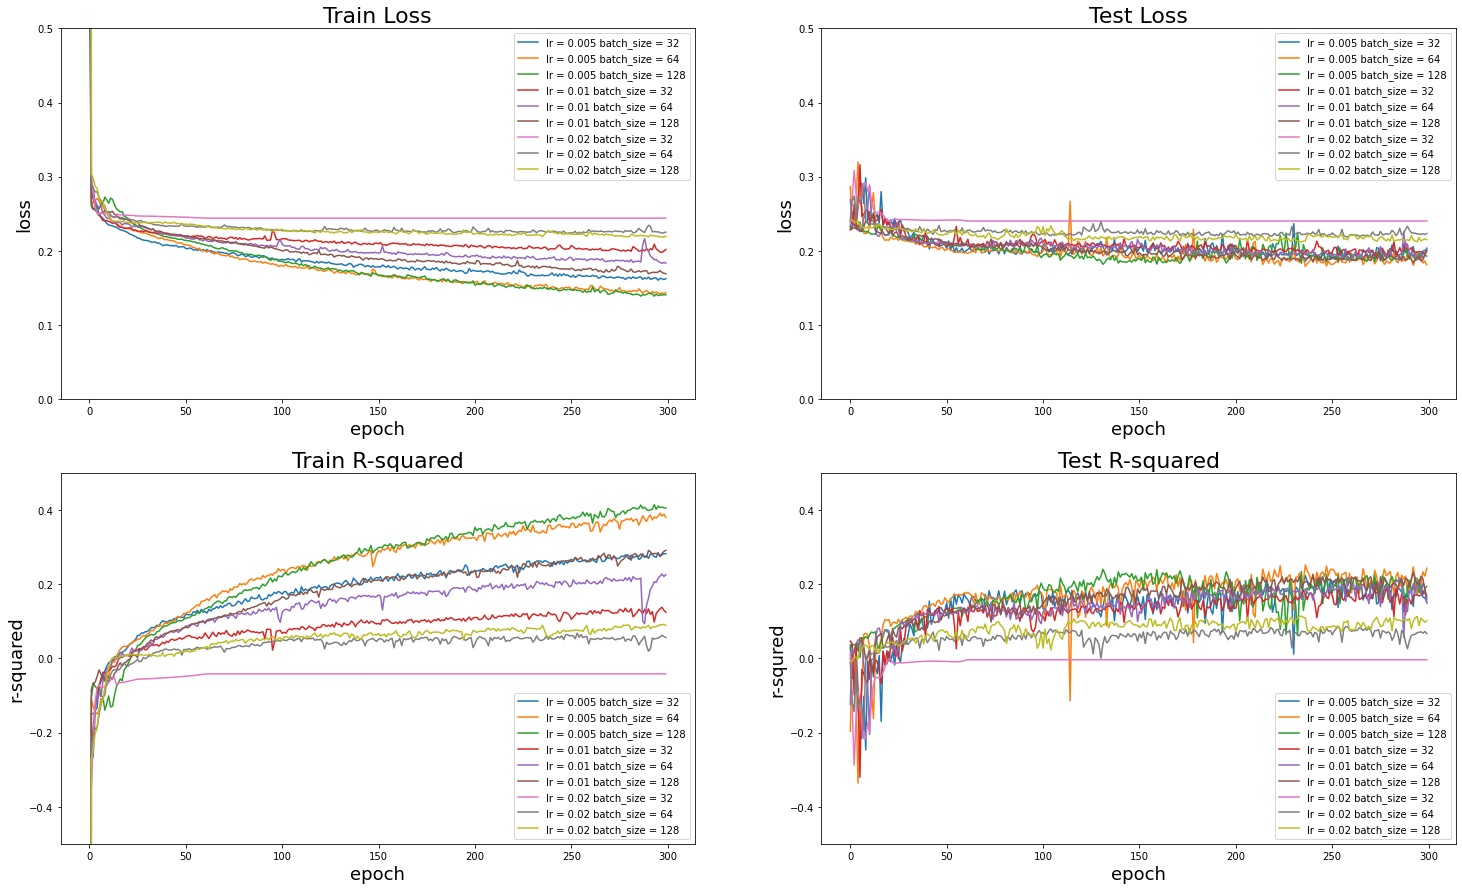

<Figure size 1800x1080 with 0 Axes>

In [16]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.005 batch_size = 128")

    ax.plot(data_list[3],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[4],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[5],label="lr = 0.01 batch_size = 128")
    
    ax.plot(data_list[6],label="lr = 0.02 batch_size = 32")
    ax.plot(data_list[7],label="lr = 0.02 batch_size = 64")
    ax.plot(data_list[8],label="lr = 0.02 batch_size = 128")
    

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 0.5])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 0.5])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-0.5,0.5])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squred", fontsize=18)
ax4.legend()
ax4.set_ylim([-0.5,0.5])

plt.show()

In [17]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

0.28263822580819015
0.3808953654043272
0.4059229909074867
0.12478897615296494
0.2262643902010407
0.29198738894286713
-0.04152137810752927
0.05614215111267768
0.08911504852963144
___________________

0.15271598756331484
0.24328017747412956
0.1947170159914623
0.16073990443719066
0.14938651590049
0.16647915403365343
-0.003456025900427262
0.06734339544653845
0.10184444239469148
___________________

0.16232594619376944
0.14374203690679083
0.1406354673043655
0.20177526003040305
0.18317257664797507
0.1691107467687043
0.2440031069681185
0.22519939990489038
0.21931967465546878
___________________

0.20282357931137085
0.18114423751831055
0.19276933372020721
0.2009027898311615
0.20362058281898499
0.19952891767024994
0.24020813405513763
0.22326013445854187
0.21500125527381897


### 3 best models

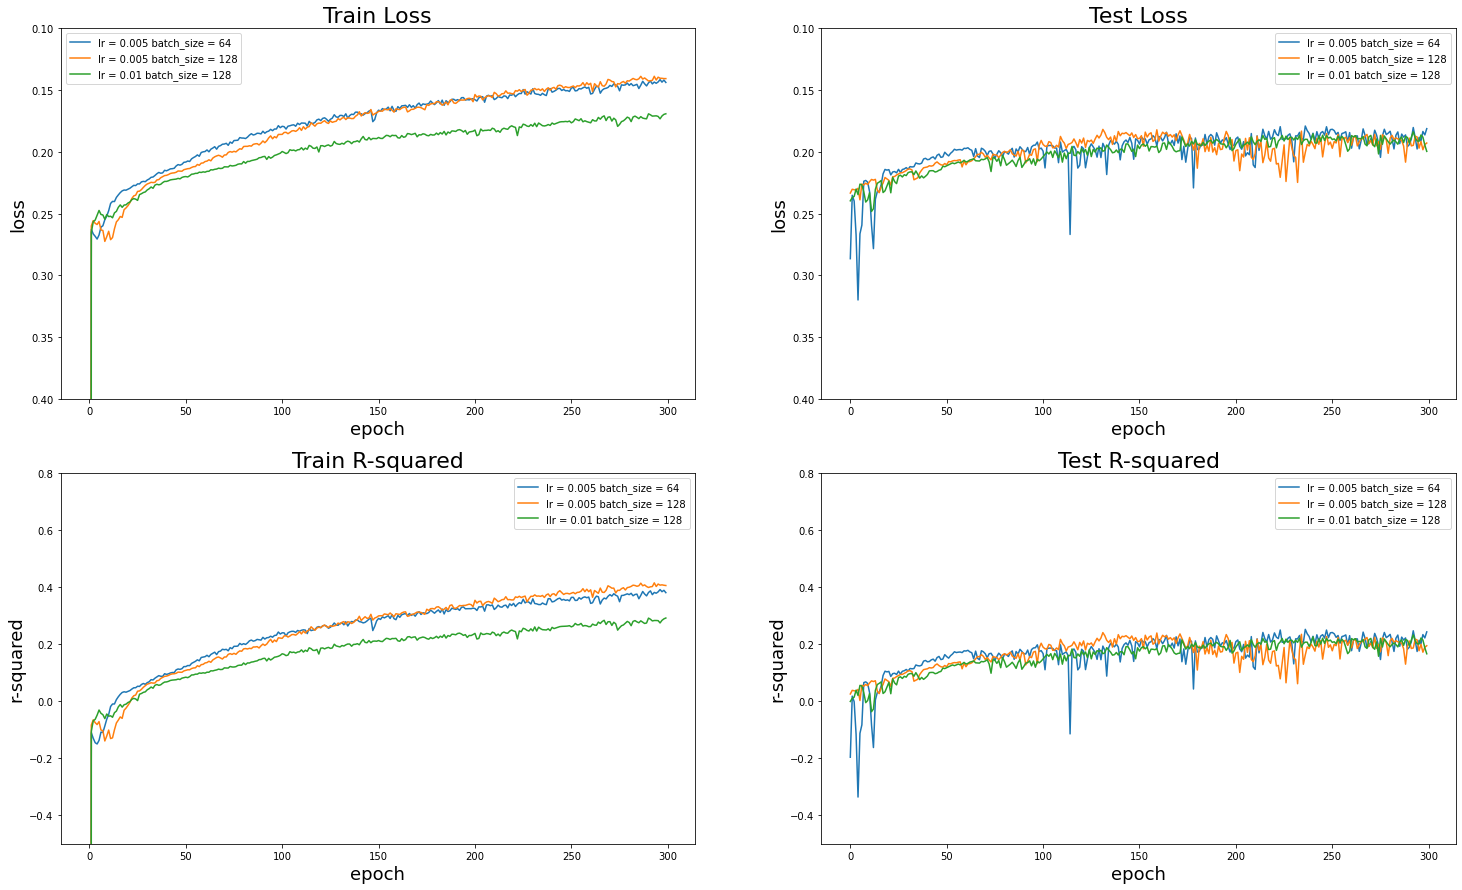

<Figure size 432x288 with 0 Axes>

In [21]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[1],label="lr = 0.005 batch_size = 64")
ax1.plot(train_losses_all[2],label="lr = 0.005 batch_size = 128")
ax1.plot(train_losses_all[5],label="lr = 0.01 batch_size = 128")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0.4, 0.1])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[1],label="lr = 0.005 batch_size = 64")
ax2.plot(test_losses_all[2],label="lr = 0.005 batch_size = 128")
ax2.plot(test_losses_all[5],label="lr = 0.01 batch_size = 128")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0.4, 0.1])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[1],label="lr = 0.005 batch_size = 64")
ax3.plot(train_accs_all[2],label="lr = 0.005 batch_size = 128")
ax3.plot(train_accs_all[5],label="llr = 0.01 batch_size = 128")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-0.5,0.8])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[1],label="lr = 0.005 batch_size = 64")
ax4.plot(test_accs_all[2],label="lr = 0.005 batch_size = 128")
ax4.plot(test_accs_all[5],label="lr = 0.01 batch_size = 128")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-0.5,0.8])
plt.show()

## 6.2. Training


- Model 1 - lr: 0.005 batch size: 128
- Model 2 - lr: 0.01 batch size: 128

In [22]:
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []
best_params_all = []
writer = SummaryWriter()

pairs = [(0.005, 128), (0.01, 128)]

for i_p, (lr, batch_size) in enumerate(pairs):
    
    model = GraphNeuralNetwork()

    train_loader = GraphDataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = GraphDataLoader(test_dataset, batch_size=4984, shuffle=False)

    epochs = 500
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    best_params = {'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
    best_value = 1

    print('Model: batch_size {} learning rate {}'.format(batch_size, lr))

    for epoch in range(1, epochs + 1):

        print('################## EPOCH {} ##################'.format(epoch))

        model.train()
        train_correct = 0
        train_loss = 0

        for data in tqdm(train_loader, leave=False):
            x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
            optimizer.zero_grad()
            output = model(x, edge_index, batch)
            loss = criterion(output, torch.Tensor(y))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += metrics.r2_score(y, output.cpu().detach().numpy())   

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_acc = train_correct/len(train_loader)
        train_accs.append(train_acc)
        writer.add_scalar("Model_{}/Loss/train".format(i_p), train_loss, epoch)
        writer.add_scalar("Model_{}/R2/train".format(i_p), train_acc, epoch)
        print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

        model.eval()

        test_loss = 0
        test_correct = 0    

        with torch.no_grad():
            for data in tqdm(test_loader):
                x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                output = model(x, edge_index, batch)
                test_loss += criterion(output, torch.Tensor(y)).item()
                test_correct += metrics.r2_score(y, output.cpu().detach().numpy())

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_acc =test_correct/len(test_loader)
        test_accs.append(test_acc)

        if test_loss<best_value:
            best_value = test_loss
            torch.save(model.state_dict(), '../../models/genotoxicity_graph_model_{}.pt'.format(i_p))
            best_params['batch_size'] = batch_size
            best_params['epoch'] = epoch
            best_params['train_loss'] = train_loss
            best_params['test_loss'] = test_loss
            best_params['train_acc'] = train_acc
            best_params['test_acc'] = test_acc 
        writer.add_scalar("Model_{}/Loss/test".format(i_p), test_loss, epoch)
        writer.add_scalar("Model_{}/R2/test".format(i_p), test_acc, epoch)
        print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

    train_losses_all.append(train_losses)
    test_losses_all.append(test_losses)
    train_accs_all.append(train_accs)
    test_accs_all.append(test_accs)
    best_params_all.append(best_params)

writer.flush()
writer.close()
print(best_params_all)

  0%|          | 0/156 [00:00<?, ?it/s]

Model: batch_size 128 learning rate 0.005
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 1.4304792733910756, Accuracy: -4.767272766728591


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.22831062972545624, Accuracy: 0.01201673934473324
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25728037093694395, Accuracy: -0.0729615114361901


  1%|          | 1/156 [00:00<00:26,  5.82it/s]

Test Avg. loss: 0.22719942033290863, Accuracy: 0.016825298768545438
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25204957897464436, Accuracy: -0.0516888814767227


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.22049503028392792, Accuracy: 0.045837650369174976
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2530237923447902, Accuracy: -0.05718756490456963


  1%|          | 1/156 [00:00<00:26,  5.81it/s]

Test Avg. loss: 0.21960598230361938, Accuracy: 0.049684915396555174
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26066404456893605, Accuracy: -0.08961036587451895


  1%|          | 1/156 [00:00<00:26,  5.75it/s]

Test Avg. loss: 0.22019913792610168, Accuracy: 0.04711807739200258
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25929340271231455, Accuracy: -0.08645438790368148


  1%|          | 1/156 [00:00<00:26,  5.89it/s]

Test Avg. loss: 0.21780912578105927, Accuracy: 0.057460560601362065
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2707860836615929, Accuracy: -0.13501190383649153


  1%|          | 1/156 [00:00<00:27,  5.58it/s]

Test Avg. loss: 0.2176685631275177, Accuracy: 0.05806890174023971
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2639941847286163, Accuracy: -0.10177999144056646


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.22458189725875854, Accuracy: 0.02815230235919497
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26433874934147567, Accuracy: -0.10183196070599186


  1%|          | 1/156 [00:00<00:26,  5.81it/s]

Test Avg. loss: 0.22089940309524536, Accuracy: 0.044087791842773116
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26341853548700994, Accuracy: -0.0987874943728132


  1%|          | 1/156 [00:00<00:26,  5.78it/s]

Test Avg. loss: 0.21842481195926666, Accuracy: 0.054796274830678615
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.264591282663437, Accuracy: -0.10304292897921197


  1%|          | 1/156 [00:00<00:26,  5.75it/s]

Test Avg. loss: 0.2162584364414215, Accuracy: 0.06417102287716547
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25690947740505904, Accuracy: -0.07059820976660582


  1%|          | 1/156 [00:00<00:25,  5.98it/s]

Test Avg. loss: 0.21835152804851532, Accuracy: 0.05511332944357372
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.260396193426389, Accuracy: -0.08603407156045097


  1%|          | 1/156 [00:00<00:25,  5.98it/s]

Test Avg. loss: 0.21527785062789917, Accuracy: 0.0684142594423024
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2582964859902859, Accuracy: -0.08116354713943792


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.21460877358913422, Accuracy: 0.07130966234474023
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25644107611897665, Accuracy: -0.07654446770271808


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.21783560514450073, Accuracy: 0.05734598806408553
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24797679560306746, Accuracy: -0.03761052263755655


  1%|          | 1/156 [00:00<00:27,  5.64it/s]

Test Avg. loss: 0.21529777348041534, Accuracy: 0.06832808825112158
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24676725659997034, Accuracy: -0.03212951788746849


  1%|          | 1/156 [00:00<00:27,  5.60it/s]

Test Avg. loss: 0.21513693034648895, Accuracy: 0.06902405903303344
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2431264289487631, Accuracy: -0.016858925032643447


  1%|          | 1/156 [00:00<00:25,  6.07it/s]

Test Avg. loss: 0.2140830159187317, Accuracy: 0.07358480746894969
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24258186601293394, Accuracy: -0.01263686344042437


  1%|          | 1/156 [00:00<00:26,  5.77it/s]

Test Avg. loss: 0.21315109729766846, Accuracy: 0.07761753014769612
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23783283728437546, Accuracy: 0.007860227194106669


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.2126743495464325, Accuracy: 0.0796805099602308
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23612955308113343, Accuracy: 0.015011181626803233


  1%|          | 1/156 [00:00<00:25,  6.19it/s]

Test Avg. loss: 0.21257472038269043, Accuracy: 0.08011163496792839
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23401968496350142, Accuracy: 0.024814269161508102


  1%|          | 1/156 [00:00<00:26,  5.89it/s]

Test Avg. loss: 0.21183228492736816, Accuracy: 0.0833246007441295
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23307433877235803, Accuracy: 0.02892098990227563


  1%|          | 1/156 [00:00<00:25,  5.96it/s]

Test Avg. loss: 0.21211513876914978, Accuracy: 0.08210045880711103
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23119670754441848, Accuracy: 0.03724553753940336


  1%|          | 1/156 [00:00<00:26,  5.89it/s]

Test Avg. loss: 0.21367613971233368, Accuracy: 0.0753454407541142
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23007690390715232, Accuracy: 0.04143543266617129


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.21276067197322845, Accuracy: 0.0793070306782524
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22853550802056605, Accuracy: 0.047490928183912


  1%|          | 1/156 [00:00<00:26,  5.92it/s]

Test Avg. loss: 0.21434998512268066, Accuracy: 0.0724295650617438
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2273415004213651, Accuracy: 0.052026887128813794


  1%|          | 1/156 [00:00<00:26,  5.90it/s]

Test Avg. loss: 0.21005788445472717, Accuracy: 0.09100300426502694
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22578875328867865, Accuracy: 0.05849441922635094


  1%|          | 1/156 [00:00<00:29,  5.24it/s]

Test Avg. loss: 0.2130846232175827, Accuracy: 0.07790514220648048
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2252275958084143, Accuracy: 0.060477100262425726


  1%|          | 1/156 [00:00<00:25,  5.99it/s]

Test Avg. loss: 0.2107706516981125, Accuracy: 0.08791859188591078
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22449393818775812, Accuracy: 0.0630940918547697


  1%|          | 1/156 [00:00<00:27,  5.67it/s]

Test Avg. loss: 0.20955580472946167, Accuracy: 0.09317564556586955
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22366378074273086, Accuracy: 0.06607813412947666


  1%|          | 1/156 [00:00<00:26,  5.76it/s]

Test Avg. loss: 0.20772013068199158, Accuracy: 0.10111944169109188
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22195350846801049, Accuracy: 0.07326419734702831


  1%|          | 1/156 [00:00<00:27,  5.70it/s]

Test Avg. loss: 0.20597684383392334, Accuracy: 0.1086631405137668
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2205343365860291, Accuracy: 0.07929131977015724


  1%|          | 1/156 [00:00<00:24,  6.25it/s]

Test Avg. loss: 0.20707470178604126, Accuracy: 0.1039122232174925
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21918625661577934, Accuracy: 0.0847050738718665


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.20913194119930267, Accuracy: 0.09500984865580175
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21856742447767502, Accuracy: 0.08725403710113057


  1%|          | 1/156 [00:00<00:29,  5.24it/s]

Test Avg. loss: 0.20745152235031128, Accuracy: 0.10228176135650635
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21771124521127114, Accuracy: 0.09130432722441795


  1%|          | 1/156 [00:00<00:25,  5.98it/s]

Test Avg. loss: 0.20496463775634766, Accuracy: 0.11304330475736879
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2173944043043332, Accuracy: 0.09253667262594137


  1%|          | 1/156 [00:00<00:27,  5.65it/s]

Test Avg. loss: 0.20500928163528442, Accuracy: 0.11285018792157708
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21618231949515831, Accuracy: 0.09750578226661014


  1%|          | 1/156 [00:00<00:26,  5.81it/s]

Test Avg. loss: 0.20566099882125854, Accuracy: 0.11002993699639052
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21590331512001845, Accuracy: 0.09821634792646478


  1%|          | 1/156 [00:00<00:27,  5.70it/s]

Test Avg. loss: 0.20459644496440887, Accuracy: 0.11463661528725821
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21515954018403322, Accuracy: 0.10172089601731955


  1%|          | 1/156 [00:00<00:27,  5.68it/s]

Test Avg. loss: 0.20451390743255615, Accuracy: 0.11499382497565436
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2146858389560993, Accuracy: 0.10367531589682907


  1%|          | 1/156 [00:00<00:26,  5.87it/s]

Test Avg. loss: 0.20417001843452454, Accuracy: 0.11648190284416293
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21394717000806943, Accuracy: 0.10638282932041107


  1%|          | 1/156 [00:00<00:27,  5.62it/s]

Test Avg. loss: 0.20373986661434174, Accuracy: 0.11834340275749078
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2135791569852676, Accuracy: 0.10795307801610793


  1%|          | 1/156 [00:00<00:29,  5.30it/s]

Test Avg. loss: 0.2025112509727478, Accuracy: 0.12366000014297751
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21268150687981874, Accuracy: 0.11166960602879929


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.2026420682668686, Accuracy: 0.1230939630937038
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2130640035447402, Accuracy: 0.1100121677616558


  1%|          | 1/156 [00:00<00:27,  5.57it/s]

Test Avg. loss: 0.20194830000400543, Accuracy: 0.12609617801203654
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21215142500706208, Accuracy: 0.11463365134090257


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.20158855617046356, Accuracy: 0.1276529082786536
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21287998920067763, Accuracy: 0.11038925842875905


  1%|          | 1/156 [00:00<00:26,  5.75it/s]

Test Avg. loss: 0.2005298137664795, Accuracy: 0.13223442475355307
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21181734259694052, Accuracy: 0.11529873753713699


  1%|          | 1/156 [00:00<00:26,  5.90it/s]

Test Avg. loss: 0.19950269162654877, Accuracy: 0.13667917614592062
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21132115857341352, Accuracy: 0.1174066109658634


  1%|          | 1/156 [00:00<00:27,  5.67it/s]

Test Avg. loss: 0.19914492964744568, Accuracy: 0.1382273168661644
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21104199128846327, Accuracy: 0.11766128172108004


  1%|          | 1/156 [00:00<00:30,  5.09it/s]

Test Avg. loss: 0.19970867037773132, Accuracy: 0.13578786316407965
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20952058421113554, Accuracy: 0.12466687729788387


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.19903267920017242, Accuracy: 0.13871307953638845
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20943589570621648, Accuracy: 0.12540520373043793


  1%|          | 1/156 [00:00<00:28,  5.53it/s]

Test Avg. loss: 0.19866721332073212, Accuracy: 0.14029455127676804
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20869352367634958, Accuracy: 0.12751459259003387


  1%|          | 1/156 [00:00<00:29,  5.25it/s]

Test Avg. loss: 0.20016902685165405, Accuracy: 0.13379571854719285
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20675887883855745, Accuracy: 0.13604215761824479


  1%|          | 1/156 [00:00<00:25,  6.12it/s]

Test Avg. loss: 0.19805908203125, Accuracy: 0.14292629567408277
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20604472163204962, Accuracy: 0.13870674652205175


  1%|          | 1/156 [00:00<00:26,  5.90it/s]

Test Avg. loss: 0.19823463261127472, Accuracy: 0.14216654761113612
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20685628132942396, Accuracy: 0.13534923389580136


  1%|          | 1/156 [00:00<00:27,  5.60it/s]

Test Avg. loss: 0.19687329232692719, Accuracy: 0.1480575194590671
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2054805689228651, Accuracy: 0.14093368728053093


  1%|          | 1/156 [00:00<00:27,  5.73it/s]

Test Avg. loss: 0.19751304388046265, Accuracy: 0.14528902247582431
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20547476544594154, Accuracy: 0.14191680242144705


  1%|          | 1/156 [00:00<00:24,  6.21it/s]

Test Avg. loss: 0.20172885060310364, Accuracy: 0.12704570777929836
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2047756801908597, Accuracy: 0.14362325342211366


  1%|          | 1/156 [00:00<00:28,  5.53it/s]

Test Avg. loss: 0.1981949657201767, Accuracy: 0.1423381737347118
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20431964619992635, Accuracy: 0.14606034399124115


  1%|          | 1/156 [00:00<00:25,  6.10it/s]

Test Avg. loss: 0.1982044130563736, Accuracy: 0.14229727760025845
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2034324739032831, Accuracy: 0.14947357624512214


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.2036922425031662, Accuracy: 0.11854943753239666
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2023177480754944, Accuracy: 0.15396651659154953


  1%|          | 1/156 [00:00<00:27,  5.63it/s]

Test Avg. loss: 0.19966267049312592, Accuracy: 0.1359868901631328
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2006657806535562, Accuracy: 0.16067428684114993


  1%|          | 1/156 [00:00<00:27,  5.59it/s]

Test Avg. loss: 0.19573625922203064, Accuracy: 0.1529779468301785
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20091382614695108, Accuracy: 0.15989428703644507


  1%|          | 1/156 [00:00<00:27,  5.63it/s]

Test Avg. loss: 0.19772738218307495, Accuracy: 0.14436157031352848
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2003191720503263, Accuracy: 0.16185508131223042


  1%|          | 1/156 [00:00<00:26,  5.84it/s]

Test Avg. loss: 0.2027054876089096, Accuracy: 0.12281944767517461
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20115171821835715, Accuracy: 0.15927240599149345


  1%|          | 1/156 [00:00<00:26,  5.77it/s]

Test Avg. loss: 0.19982556998729706, Accuracy: 0.13528194691291806
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20002005803279388, Accuracy: 0.1631203901723665


  1%|          | 1/156 [00:00<00:29,  5.30it/s]

Test Avg. loss: 0.20062300562858582, Accuracy: 0.13183122757199306
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1991975296002168, Accuracy: 0.1663449887536456


  1%|          | 1/156 [00:00<00:27,  5.58it/s]

Test Avg. loss: 0.20198678970336914, Accuracy: 0.12592963319914752
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19681947281918463, Accuracy: 0.17565684998553638


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.19888396561145782, Accuracy: 0.1393567160809901
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19618470384142336, Accuracy: 0.1799779337234163


  1%|          | 1/156 [00:00<00:27,  5.62it/s]

Test Avg. loss: 0.19615060091018677, Accuracy: 0.15118485556333572
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19681609641665068, Accuracy: 0.17584255993179593


  1%|          | 1/156 [00:00<00:29,  5.23it/s]

Test Avg. loss: 0.19847284257411957, Accuracy: 0.14113573304901728
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19536834917007348, Accuracy: 0.18203947386895136


  1%|          | 1/156 [00:00<00:28,  5.38it/s]

Test Avg. loss: 0.1997383087873459, Accuracy: 0.13565955962189724
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19533261432288548, Accuracy: 0.18207823634854825


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.20110660791397095, Accuracy: 0.1297385012813601
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19484193976490927, Accuracy: 0.18405667471897952


  1%|          | 1/156 [00:00<00:26,  5.92it/s]

Test Avg. loss: 0.20208366215229034, Accuracy: 0.1255104446639861
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19361510328375375, Accuracy: 0.1890665250579744


  1%|          | 1/156 [00:00<00:26,  5.81it/s]

Test Avg. loss: 0.2000180184841156, Accuracy: 0.13444920920232928
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1919959572931895, Accuracy: 0.19540363524571117


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.1960836797952652, Accuracy: 0.15147447129846436
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19315535489183205, Accuracy: 0.19012911885699502


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.19754354655742645, Accuracy: 0.14515709783454156
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19217724782916215, Accuracy: 0.19434022059422204


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.20065699517726898, Accuracy: 0.13168410290425225
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1909503100487666, Accuracy: 0.1987833892345583


  1%|          | 1/156 [00:00<00:27,  5.66it/s]

Test Avg. loss: 0.20047038793563843, Accuracy: 0.13249160123158077
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19131353908242324, Accuracy: 0.19904986145593204


  1%|          | 1/156 [00:00<00:28,  5.53it/s]

Test Avg. loss: 0.20219644904136658, Accuracy: 0.12502223330902684
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1905221463395999, Accuracy: 0.20288649421163393


  1%|          | 1/156 [00:00<00:26,  5.86it/s]

Test Avg. loss: 0.20309069752693176, Accuracy: 0.12115255632064603
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18944378006152618, Accuracy: 0.20697884873029587


  1%|          | 1/156 [00:00<00:25,  6.01it/s]

Test Avg. loss: 0.20345371961593628, Accuracy: 0.11958168396992086
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1894233369578918, Accuracy: 0.20686311678905667


  1%|          | 1/156 [00:00<00:26,  5.77it/s]

Test Avg. loss: 0.19983330368995667, Accuracy: 0.13524846406902225
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18758619748629057, Accuracy: 0.21420521326204417


  1%|          | 1/156 [00:00<00:25,  6.16it/s]

Test Avg. loss: 0.20541755855083466, Accuracy: 0.11108344955885352
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18866183603994358, Accuracy: 0.21052393990796775


  1%|          | 1/156 [00:00<00:27,  5.60it/s]

Test Avg. loss: 0.21628420054912567, Accuracy: 0.06405944130087848
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18862822393958384, Accuracy: 0.20976641004973423


  1%|          | 1/156 [00:00<00:26,  5.87it/s]

Test Avg. loss: 0.20633845031261444, Accuracy: 0.10709841572213241
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18634310039954308, Accuracy: 0.21913787653873207


  1%|          | 1/156 [00:00<00:27,  5.68it/s]

Test Avg. loss: 0.20952582359313965, Accuracy: 0.09330539625091039
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18632812855335382, Accuracy: 0.21870050063295168


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.2033315747976303, Accuracy: 0.12011016619650139
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1863239036920743, Accuracy: 0.2190334172534272


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.212127685546875, Accuracy: 0.08204627022276911
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18625991041652668, Accuracy: 0.2207955595462524


  1%|          | 1/156 [00:00<00:28,  5.51it/s]

Test Avg. loss: 0.20280198752880096, Accuracy: 0.12240189382264022
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1863397913865554, Accuracy: 0.22022652386048344


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.20201484858989716, Accuracy: 0.12580807877949785
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1853173126299412, Accuracy: 0.2236556841665675


  1%|          | 1/156 [00:00<00:27,  5.55it/s]

Test Avg. loss: 0.2043333351612091, Accuracy: 0.11577517862894082
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18499608915776777, Accuracy: 0.2249746473552347


  1%|          | 1/156 [00:00<00:26,  5.82it/s]

Test Avg. loss: 0.2120593935251236, Accuracy: 0.08234174157497098
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1830972546759324, Accuracy: 0.23329754934240027


  1%|          | 1/156 [00:00<00:26,  5.96it/s]

Test Avg. loss: 0.2087227702140808, Accuracy: 0.09678054629528854
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1834400480087751, Accuracy: 0.23167368962541351


  1%|          | 1/156 [00:00<00:25,  6.01it/s]

Test Avg. loss: 0.2055274099111557, Accuracy: 0.11060798950665685
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18198343485784838, Accuracy: 0.23681991288791232


  1%|          | 1/156 [00:00<00:26,  5.92it/s]

Test Avg. loss: 0.20472405850887299, Accuracy: 0.11408438948490518
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18131285647933298, Accuracy: 0.24032837039121782


  1%|          | 1/156 [00:00<00:27,  5.63it/s]

Test Avg. loss: 0.20833611488342285, Accuracy: 0.0984536526577342
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18355526545873055, Accuracy: 0.23140638876288172


  1%|          | 1/156 [00:00<00:27,  5.70it/s]

Test Avg. loss: 0.20530004799365997, Accuracy: 0.11159187109409263
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18290737529213613, Accuracy: 0.23421087120857195


  1%|          | 1/156 [00:00<00:27,  5.55it/s]

Test Avg. loss: 0.20270149409770966, Accuracy: 0.12283672069583884
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18045537231060174, Accuracy: 0.24379585818218955


  1%|          | 1/156 [00:00<00:25,  6.09it/s]

Test Avg. loss: 0.2024528980255127, Accuracy: 0.12391260647362323
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18016016158537987, Accuracy: 0.24435228146222238


  1%|          | 1/156 [00:00<00:26,  5.79it/s]

Test Avg. loss: 0.1976286768913269, Accuracy: 0.14478870046748693
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17931907509381956, Accuracy: 0.24876665361471376


  1%|          | 1/156 [00:00<00:27,  5.57it/s]

Test Avg. loss: 0.2012862116098404, Accuracy: 0.12896124637371942
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1796371056101261, Accuracy: 0.2472534301154657


  1%|          | 1/156 [00:00<00:26,  5.85it/s]

Test Avg. loss: 0.19627662003040314, Accuracy: 0.1506395569612078
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1780122028520474, Accuracy: 0.25365736134101236


  1%|          | 1/156 [00:00<00:24,  6.25it/s]

Test Avg. loss: 0.20357626676559448, Accuracy: 0.11905127952489492
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18037665850267962, Accuracy: 0.2445637849536888


  1%|          | 1/156 [00:00<00:26,  5.91it/s]

Test Avg. loss: 0.1951109915971756, Accuracy: 0.15568365761156466
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17857964160159612, Accuracy: 0.25132363155251836


  1%|          | 1/156 [00:00<00:26,  5.94it/s]

Test Avg. loss: 0.19732098281383514, Accuracy: 0.14612024881476382
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17823273378113905, Accuracy: 0.25385519247499055


  1%|          | 1/156 [00:00<00:27,  5.69it/s]

Test Avg. loss: 0.1968298703432083, Accuracy: 0.14824550183066643
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1763749717710874, Accuracy: 0.2600262796869715


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.19903959333896637, Accuracy: 0.13868313014672828
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17560878864083534, Accuracy: 0.2647914670956072


  1%|          | 1/156 [00:00<00:26,  5.86it/s]

Test Avg. loss: 0.19474230706691742, Accuracy: 0.15727910685633062
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17633053607856616, Accuracy: 0.2611472469988701


  1%|          | 1/156 [00:00<00:28,  5.51it/s]

Test Avg. loss: 0.2022925615310669, Accuracy: 0.12460637125424667
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17753946007444307, Accuracy: 0.25587995788123363


  1%|          | 1/156 [00:00<00:27,  5.57it/s]

Test Avg. loss: 0.19888925552368164, Accuracy: 0.13933370895464503
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17569015719569647, Accuracy: 0.26161503749146936


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.20148113369941711, Accuracy: 0.12811770323264637
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17630066273686212, Accuracy: 0.26164009809904887


  1%|          | 1/156 [00:00<00:26,  5.80it/s]

Test Avg. loss: 0.19936630129814148, Accuracy: 0.13726936625771413
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17379031712428117, Accuracy: 0.2701740019810278


  1%|          | 1/156 [00:00<00:26,  5.94it/s]

Test Avg. loss: 0.19357627630233765, Accuracy: 0.1623249173283562
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17328475296306303, Accuracy: 0.2736694849687634


  1%|          | 1/156 [00:00<00:26,  5.85it/s]

Test Avg. loss: 0.19981800019741058, Accuracy: 0.1353147466492577
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17482746015183437, Accuracy: 0.2663200686854207


  1%|          | 1/156 [00:00<00:26,  5.79it/s]

Test Avg. loss: 0.19619238376617432, Accuracy: 0.15100404135595136
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1749348172870202, Accuracy: 0.2651341738899736


  1%|          | 1/156 [00:00<00:26,  5.96it/s]

Test Avg. loss: 0.20207256078720093, Accuracy: 0.12555840573099486
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1754008793295958, Accuracy: 0.26362922155030544


  1%|          | 1/156 [00:00<00:30,  5.03it/s]

Test Avg. loss: 0.19647106528282166, Accuracy: 0.1497981722085504
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17367942621692634, Accuracy: 0.2719307056513729


  1%|          | 1/156 [00:00<00:29,  5.27it/s]

Test Avg. loss: 0.1995258629322052, Accuracy: 0.13657891217247842
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17254750507000166, Accuracy: 0.27659356335755436


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.1955110728740692, Accuracy: 0.15395242370699225
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1712798751795139, Accuracy: 0.2813951318369719


  1%|          | 1/156 [00:00<00:27,  5.55it/s]

Test Avg. loss: 0.20699982345104218, Accuracy: 0.10423634433913731
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17496221994933409, Accuracy: 0.26406280929241116


  1%|          | 1/156 [00:00<00:27,  5.67it/s]

Test Avg. loss: 0.19708412885665894, Accuracy: 0.14714524045640176
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17141746643644112, Accuracy: 0.28162701779632476


  1%|          | 1/156 [00:00<00:28,  5.47it/s]

Test Avg. loss: 0.1974179446697235, Accuracy: 0.14570065762099327
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16977644835909209, Accuracy: 0.2860308016935117


  1%|          | 1/156 [00:00<00:28,  5.42it/s]

Test Avg. loss: 0.20328539609909058, Accuracy: 0.12031007283076345
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17133872330379793, Accuracy: 0.2807048164012948


  1%|          | 1/156 [00:00<00:29,  5.17it/s]

Test Avg. loss: 0.19673757255077362, Accuracy: 0.14864485702310637
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1709841264364047, Accuracy: 0.28116235199298206


  1%|          | 1/156 [00:00<00:25,  6.14it/s]

Test Avg. loss: 0.19889888167381287, Accuracy: 0.13929203760140918
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17137497735138124, Accuracy: 0.2795580686128934


  1%|          | 1/156 [00:00<00:27,  5.67it/s]

Test Avg. loss: 0.20088644325733185, Accuracy: 0.1306911870464772
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17102183912618038, Accuracy: 0.2804307378283936


  1%|          | 1/156 [00:00<00:29,  5.25it/s]

Test Avg. loss: 0.20487332344055176, Accuracy: 0.11343851794384208
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16900925104243633, Accuracy: 0.29022706083849215


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.20440053939819336, Accuracy: 0.11548440283318584
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16918583591588032, Accuracy: 0.29067845289061633


  1%|          | 1/156 [00:00<00:24,  6.26it/s]

Test Avg. loss: 0.2102097123861313, Accuracy: 0.09034600165090234
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16947432960837316, Accuracy: 0.28810458812512674


  1%|          | 1/156 [00:00<00:26,  5.84it/s]

Test Avg. loss: 0.20430277287960052, Accuracy: 0.1159075102291105
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16983316480540311, Accuracy: 0.28645310359309956


  1%|          | 1/156 [00:00<00:29,  5.31it/s]

Test Avg. loss: 0.19999511539936066, Accuracy: 0.1345482892287928
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1698138099641372, Accuracy: 0.2867037529485749


  1%|          | 1/156 [00:00<00:29,  5.32it/s]

Test Avg. loss: 0.19925013184547424, Accuracy: 0.1377721569605347
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16840973606285375, Accuracy: 0.29259658874844047


  1%|          | 1/156 [00:00<00:26,  5.91it/s]

Test Avg. loss: 0.20165345072746277, Accuracy: 0.12737199176328362
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16947636013038647, Accuracy: 0.28738038951745487


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.20727260410785675, Accuracy: 0.10305592755980941
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16813165742235306, Accuracy: 0.2928199974679086


  1%|          | 1/156 [00:00<00:25,  6.15it/s]

Test Avg. loss: 0.19737349450588226, Accuracy: 0.14589306973652327
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16808685989907154, Accuracy: 0.2926506223641022


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.2070029079914093, Accuracy: 0.10422299863900708
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16647346728505233, Accuracy: 0.29983365566737635


  1%|          | 1/156 [00:00<00:29,  5.25it/s]

Test Avg. loss: 0.20414164662361145, Accuracy: 0.1166047337985261
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16655230627228051, Accuracy: 0.299106874513614


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.20166926085948944, Accuracy: 0.12730363168986147
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16644539612417036, Accuracy: 0.3001377621253794


  1%|          | 1/156 [00:00<00:29,  5.31it/s]

Test Avg. loss: 0.20220452547073364, Accuracy: 0.12498733394813588
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16557578422511235, Accuracy: 0.3030779720545536


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.20608867704868317, Accuracy: 0.1081791344996631
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1677474162230889, Accuracy: 0.29460136150803395


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.2065189927816391, Accuracy: 0.10631710647314985
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16642280586828023, Accuracy: 0.3007219723253075


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.2064051777124405, Accuracy: 0.10680965719488289
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16631215963608179, Accuracy: 0.29972685496524903


  1%|          | 1/156 [00:00<00:28,  5.38it/s]

Test Avg. loss: 0.19687551259994507, Accuracy: 0.14804799396857427
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1671183471305248, Accuracy: 0.2973017090282767


  1%|          | 1/156 [00:00<00:28,  5.54it/s]

Test Avg. loss: 0.21099306643009186, Accuracy: 0.08695608578998981
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16414337075100496, Accuracy: 0.3096302189379285


  1%|          | 1/156 [00:00<00:27,  5.63it/s]

Test Avg. loss: 0.20791888236999512, Accuracy: 0.10025923758624433
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16653496638322487, Accuracy: 0.29911723870588414


  1%|          | 1/156 [00:00<00:27,  5.63it/s]

Test Avg. loss: 0.20251408219337463, Accuracy: 0.12364775222897473
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16446357229963326, Accuracy: 0.3093230611800557


  1%|          | 1/156 [00:00<00:27,  5.54it/s]

Test Avg. loss: 0.20156073570251465, Accuracy: 0.12777332339982117
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.166802225395655, Accuracy: 0.2979284281794313


  1%|          | 1/156 [00:00<00:27,  5.74it/s]

Test Avg. loss: 0.1958184391260147, Accuracy: 0.1526221858356256
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16458300362603787, Accuracy: 0.3071527407702685


  1%|          | 1/156 [00:00<00:29,  5.30it/s]

Test Avg. loss: 0.200347900390625, Accuracy: 0.13302169408160402
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16238078909615675, Accuracy: 0.31714672356796253


  1%|          | 1/156 [00:00<00:27,  5.69it/s]

Test Avg. loss: 0.2021224945783615, Accuracy: 0.12534234478455508
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16623369203164026, Accuracy: 0.3009176660556125


  1%|          | 1/156 [00:00<00:29,  5.25it/s]

Test Avg. loss: 0.19968733191490173, Accuracy: 0.13588015312741608
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16304036951026854, Accuracy: 0.31245316849261134


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.20148450136184692, Accuracy: 0.128103120252391
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16304103017617494, Accuracy: 0.31308050132629656


  1%|          | 1/156 [00:00<00:25,  6.03it/s]

Test Avg. loss: 0.19985604286193848, Accuracy: 0.13515006661004003
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16508661301281208, Accuracy: 0.30477605119703643


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.20216301083564758, Accuracy: 0.12516697454989334
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16380201686078158, Accuracy: 0.3104240512605894


  1%|          | 1/156 [00:00<00:29,  5.24it/s]

Test Avg. loss: 0.20550023019313812, Accuracy: 0.11072569074747163
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16145768264929453, Accuracy: 0.31975171280113895


  1%|          | 1/156 [00:00<00:26,  5.84it/s]

Test Avg. loss: 0.2020675092935562, Accuracy: 0.12558033544419311
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16293485558185822, Accuracy: 0.3140313320284863


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.2034354954957962, Accuracy: 0.11966051311639836
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1618475896330216, Accuracy: 0.31706536326140844


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.2011450082063675, Accuracy: 0.1295723021212818
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16165516797739726, Accuracy: 0.31874273435514294


  1%|          | 1/156 [00:00<00:27,  5.69it/s]

Test Avg. loss: 0.1987181454896927, Accuracy: 0.1400741568966608
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1615367312079821, Accuracy: 0.3193985187615168


  1%|          | 1/156 [00:00<00:26,  5.85it/s]

Test Avg. loss: 0.2054092139005661, Accuracy: 0.11111946992407773
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16343429550910607, Accuracy: 0.31205854916577525


  1%|          | 1/156 [00:00<00:30,  5.16it/s]

Test Avg. loss: 0.19565005600452423, Accuracy: 0.15335094399899207
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16161764327150124, Accuracy: 0.3183009932977357


  1%|          | 1/156 [00:00<00:26,  5.93it/s]

Test Avg. loss: 0.20397698879241943, Accuracy: 0.11731728953251164
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1592512984210864, Accuracy: 0.3288575683972436


  1%|          | 1/156 [00:00<00:25,  6.03it/s]

Test Avg. loss: 0.2100287526845932, Accuracy: 0.09112902324750416
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16195763623676238, Accuracy: 0.31863924671024524


  1%|          | 1/156 [00:00<00:27,  5.65it/s]

Test Avg. loss: 0.20493084192276, Accuracy: 0.11318956618449139
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1605238826611103, Accuracy: 0.3231386351573822


  1%|          | 1/156 [00:00<00:29,  5.23it/s]

Test Avg. loss: 0.20462583005428314, Accuracy: 0.11450945987738914
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15935621830897453, Accuracy: 0.3291932521972618


  1%|          | 1/156 [00:00<00:29,  5.25it/s]

Test Avg. loss: 0.2082715928554535, Accuracy: 0.09873285537838294
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15950502842091596, Accuracy: 0.3258736538718841


  1%|          | 1/156 [00:00<00:30,  5.05it/s]

Test Avg. loss: 0.20432202517986298, Accuracy: 0.11582413714030271
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16199333703097624, Accuracy: 0.3168576726095858


  1%|          | 1/156 [00:00<00:27,  5.62it/s]

Test Avg. loss: 0.21417959034442902, Accuracy: 0.0731669337438674
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15916087487951303, Accuracy: 0.32876794099463935


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.2027500420808792, Accuracy: 0.12262661720686419
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1610813052035295, Accuracy: 0.32129700597963573


  1%|          | 1/156 [00:00<00:29,  5.32it/s]

Test Avg. loss: 0.20352773368358612, Accuracy: 0.1192613574221415
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15697723450377965, Accuracy: 0.3366280974994166


  1%|          | 1/156 [00:00<00:25,  6.01it/s]

Test Avg. loss: 0.2073434740304947, Accuracy: 0.10274926211138213
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1600101401981635, Accuracy: 0.32489519435481606


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.20538067817687988, Accuracy: 0.11124287582905967
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15783891931940347, Accuracy: 0.33365411120278854


  1%|          | 1/156 [00:00<00:29,  5.27it/s]

Test Avg. loss: 0.2109159678220749, Accuracy: 0.08728976511676012
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1608765589980743, Accuracy: 0.3209990603550504


  1%|          | 1/156 [00:00<00:27,  5.72it/s]

Test Avg. loss: 0.20468617975711823, Accuracy: 0.11424823752233482
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16076612725662878, Accuracy: 0.32404523053043954


  1%|          | 1/156 [00:00<00:29,  5.27it/s]

Test Avg. loss: 0.20752041041851044, Accuracy: 0.10198352466880867
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16046977984026456, Accuracy: 0.3231389723832972


  1%|          | 1/156 [00:00<00:27,  5.66it/s]

Test Avg. loss: 0.2112712413072586, Accuracy: 0.08575233079750488
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15993273091048765, Accuracy: 0.32469387457851356


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.21209432184696198, Accuracy: 0.08219051168300995
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15815959870815277, Accuracy: 0.33078640097729056


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.2048872858285904, Accuracy: 0.11337800385541807
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15879235225610244, Accuracy: 0.3292136599475978


  1%|          | 1/156 [00:00<00:29,  5.24it/s]

Test Avg. loss: 0.20658592879772186, Accuracy: 0.10602743759407263
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15692359443085316, Accuracy: 0.3376031412761101


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.20214441418647766, Accuracy: 0.12524748061422197
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15990426271962813, Accuracy: 0.32350426372886015


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.20109038054943085, Accuracy: 0.12980868865858386
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15870595885775027, Accuracy: 0.33070059870672047


  1%|          | 1/156 [00:00<00:27,  5.70it/s]

Test Avg. loss: 0.20864883065223694, Accuracy: 0.09710052794250301
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15759081455568472, Accuracy: 0.335489939503851


  1%|          | 1/156 [00:00<00:28,  5.45it/s]

Test Avg. loss: 0.19818614423274994, Accuracy: 0.1423763161123679
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15683378155032793, Accuracy: 0.33736633188035303


  1%|          | 1/156 [00:00<00:27,  5.67it/s]

Test Avg. loss: 0.2063412219285965, Accuracy: 0.10708634765370662
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1571707210670679, Accuracy: 0.3364455263673173


  1%|          | 1/156 [00:00<00:27,  5.70it/s]

Test Avg. loss: 0.1990891844034195, Accuracy: 0.13846854228645367
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15819672146477762, Accuracy: 0.3313592321040292


  1%|          | 1/156 [00:00<00:26,  5.89it/s]

Test Avg. loss: 0.2034900039434433, Accuracy: 0.11942464703669808
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15571736663770983, Accuracy: 0.343607108495513


  1%|          | 1/156 [00:00<00:26,  5.91it/s]

Test Avg. loss: 0.21508510410785675, Accuracy: 0.06924845228400933
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15587811487225386, Accuracy: 0.3416798277000869


  1%|          | 1/156 [00:00<00:27,  5.67it/s]

Test Avg. loss: 0.2106790989637375, Accuracy: 0.08831476665117077
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15776448348202768, Accuracy: 0.33437676400944405


  1%|          | 1/156 [00:00<00:25,  6.16it/s]

Test Avg. loss: 0.20449258387088776, Accuracy: 0.11508610238504347
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15871726754957285, Accuracy: 0.3295968384608746


  1%|          | 1/156 [00:00<00:29,  5.18it/s]

Test Avg. loss: 0.2009599357843399, Accuracy: 0.13037313545824936
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1560910872828502, Accuracy: 0.3396268388465894


  1%|          | 1/156 [00:00<00:29,  5.25it/s]

Test Avg. loss: 0.20085656642913818, Accuracy: 0.13082048650429579
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15444398924517325, Accuracy: 0.34677446440319815


  1%|          | 1/156 [00:00<00:27,  5.64it/s]

Test Avg. loss: 0.21382860839366913, Accuracy: 0.0746856167610006
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.157357817563491, Accuracy: 0.3355388819648533


  1%|          | 1/156 [00:00<00:27,  5.66it/s]

Test Avg. loss: 0.2087876945734024, Accuracy: 0.09649957898034378
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15570225757666123, Accuracy: 0.34129934482404073


  1%|          | 1/156 [00:00<00:26,  5.81it/s]

Test Avg. loss: 0.2046521008014679, Accuracy: 0.1143958650692628
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15528363619859403, Accuracy: 0.3457010113973467


  1%|          | 1/156 [00:00<00:26,  5.83it/s]

Test Avg. loss: 0.21435105800628662, Accuracy: 0.07242481865358263
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1558636675755947, Accuracy: 0.34162409373910585


  1%|          | 1/156 [00:00<00:29,  5.26it/s]

Test Avg. loss: 0.1989768147468567, Accuracy: 0.13895485250644568
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15470516610030943, Accuracy: 0.34592145031770427


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.2077891230583191, Accuracy: 0.10082078839996245
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15547037115081763, Accuracy: 0.3426880569769183


  1%|          | 1/156 [00:00<00:29,  5.23it/s]

Test Avg. loss: 0.20248842239379883, Accuracy: 0.12375882810773975
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15558254551620054, Accuracy: 0.3433052534417474


  1%|          | 1/156 [00:00<00:27,  5.68it/s]

Test Avg. loss: 0.21182377636432648, Accuracy: 0.08336124846030168
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1552686909547983, Accuracy: 0.3447057750381307


  1%|          | 1/156 [00:00<00:24,  6.22it/s]

Test Avg. loss: 0.20576100051403046, Accuracy: 0.10959715512182922
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15609944310898966, Accuracy: 0.33935907965577183


  1%|          | 1/156 [00:00<00:27,  5.59it/s]

Test Avg. loss: 0.2008947730064392, Accuracy: 0.1306551691709673
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1555777236055105, Accuracy: 0.34407670404917723


  1%|          | 1/156 [00:00<00:29,  5.29it/s]

Test Avg. loss: 0.20936059951782227, Accuracy: 0.0940204417098226
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.154649713769173, Accuracy: 0.34521385488967155


  1%|          | 1/156 [00:00<00:28,  5.38it/s]

Test Avg. loss: 0.20426955819129944, Accuracy: 0.1160511629052341
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15414576399593782, Accuracy: 0.349311856330913


  1%|          | 1/156 [00:00<00:27,  5.60it/s]

Test Avg. loss: 0.20644882321357727, Accuracy: 0.10662069757368398
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15347145001093546, Accuracy: 0.3518949883790353


  1%|          | 1/156 [00:00<00:27,  5.57it/s]

Test Avg. loss: 0.19798623025417328, Accuracy: 0.14324146085870704
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15411394256620836, Accuracy: 0.3483508225426624


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.21144449710845947, Accuracy: 0.08500269346346656
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1545475039822169, Accuracy: 0.3465296715660646


  1%|          | 1/156 [00:00<00:25,  6.03it/s]

Test Avg. loss: 0.2090018391609192, Accuracy: 0.09557289132987845
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1535118625809749, Accuracy: 0.3514517968001946


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.2031991332769394, Accuracy: 0.12068331872337934
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15350712057298574, Accuracy: 0.3516728357603723


  1%|          | 1/156 [00:00<00:30,  5.08it/s]

Test Avg. loss: 0.2086271047592163, Accuracy: 0.09719456825940864
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15342196143972567, Accuracy: 0.3510468816352127


  1%|          | 1/156 [00:00<00:26,  5.75it/s]

Test Avg. loss: 0.2056768387556076, Accuracy: 0.10996132763293232
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1533033543576797, Accuracy: 0.3506880783630165


  1%|          | 1/156 [00:00<00:27,  5.73it/s]

Test Avg. loss: 0.1998160481452942, Accuracy: 0.13532322070799108
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15349454084076944, Accuracy: 0.35041605895179107


  1%|          | 1/156 [00:00<00:27,  5.58it/s]

Test Avg. loss: 0.19893017411231995, Accuracy: 0.1391565354462494
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.156084147735666, Accuracy: 0.3411586051150337


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.19681739807128906, Accuracy: 0.14829934969964742
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15321718571850887, Accuracy: 0.35052226725031654


  1%|          | 1/156 [00:00<00:26,  5.78it/s]

Test Avg. loss: 0.199530690908432, Accuracy: 0.1365579871101884
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1509554596283497, Accuracy: 0.36126975807097234


  1%|          | 1/156 [00:00<00:27,  5.64it/s]

Test Avg. loss: 0.20545731484889984, Accuracy: 0.11091139166297248
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15324014836014846, Accuracy: 0.351782927507193


  1%|          | 1/156 [00:00<00:26,  5.75it/s]

Test Avg. loss: 0.20421522855758667, Accuracy: 0.11628629988422656
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15235596828353712, Accuracy: 0.3561441464032632


  1%|          | 1/156 [00:00<00:25,  6.04it/s]

Test Avg. loss: 0.205363467335701, Accuracy: 0.11131742134466982
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15059860442311335, Accuracy: 0.36364161944473483


  1%|          | 1/156 [00:00<00:25,  6.12it/s]

Test Avg. loss: 0.2000826895236969, Accuracy: 0.13416933572034706
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14977728207715046, Accuracy: 0.36553895117229995


  1%|          | 1/156 [00:00<00:27,  5.70it/s]

Test Avg. loss: 0.20771998167037964, Accuracy: 0.10111989967601398
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15033833524928644, Accuracy: 0.36377522053027


  1%|          | 1/156 [00:00<00:26,  5.80it/s]

Test Avg. loss: 0.21172691881656647, Accuracy: 0.0837805384202206
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1516031281879315, Accuracy: 0.356909570545837


  1%|          | 1/156 [00:00<00:26,  5.75it/s]

Test Avg. loss: 0.19665978848934174, Accuracy: 0.1489814196348025
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1500729200645135, Accuracy: 0.36504114499376217


  1%|          | 1/156 [00:00<00:29,  5.29it/s]

Test Avg. loss: 0.20142275094985962, Accuracy: 0.12837033729165714
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1511947866051625, Accuracy: 0.3607601161639507


  1%|          | 1/156 [00:00<00:28,  5.42it/s]

Test Avg. loss: 0.1966240406036377, Accuracy: 0.14913612605045312
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1523831479060344, Accuracy: 0.3566674390162323


  1%|          | 1/156 [00:00<00:28,  5.42it/s]

Test Avg. loss: 0.19824950397014618, Accuracy: 0.14210218618296344
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14804188591929582, Accuracy: 0.3742842825936973


  1%|          | 1/156 [00:00<00:28,  5.39it/s]

Test Avg. loss: 0.19846004247665405, Accuracy: 0.14119106335151466
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1508589712664103, Accuracy: 0.36290409507322335


  1%|          | 1/156 [00:00<00:24,  6.22it/s]

Test Avg. loss: 0.2127150148153305, Accuracy: 0.07950462942549086
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1502286254022366, Accuracy: 0.36495866232791224


  1%|          | 1/156 [00:00<00:26,  5.76it/s]

Test Avg. loss: 0.20425184071063995, Accuracy: 0.11612789236165655
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15125250687392858, Accuracy: 0.36058630155880794


  1%|          | 1/156 [00:00<00:30,  5.15it/s]

Test Avg. loss: 0.20274093747138977, Accuracy: 0.12266607182295353
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15011192600314432, Accuracy: 0.36385690283640953


  1%|          | 1/156 [00:00<00:29,  5.17it/s]

Test Avg. loss: 0.20436765253543854, Accuracy: 0.11562666482312889
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1491383604514293, Accuracy: 0.36704530573227284


  1%|          | 1/156 [00:00<00:26,  5.86it/s]

Test Avg. loss: 0.20547537505626678, Accuracy: 0.11083316628717055
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14797668464672872, Accuracy: 0.37337199414348127


  1%|          | 1/156 [00:00<00:26,  5.85it/s]

Test Avg. loss: 0.202332004904747, Accuracy: 0.12443571083503724
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14785790839829507, Accuracy: 0.3737121586324362


  1%|          | 1/156 [00:00<00:26,  5.74it/s]

Test Avg. loss: 0.2009790539741516, Accuracy: 0.13029038327800002
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14715501341300133, Accuracy: 0.37713580334875946


  1%|          | 1/156 [00:00<00:30,  5.14it/s]

Test Avg. loss: 0.2021673321723938, Accuracy: 0.12514831044154695
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14734374096569341, Accuracy: 0.37577455481504746


  1%|          | 1/156 [00:00<00:27,  5.55it/s]

Test Avg. loss: 0.1991523802280426, Accuracy: 0.13819514469704275
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14660299898913273, Accuracy: 0.37821945723246647


  1%|          | 1/156 [00:00<00:27,  5.58it/s]

Test Avg. loss: 0.19401045143604279, Accuracy: 0.16044607889333906
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.150561931471412, Accuracy: 0.3635907012596908


  1%|          | 1/156 [00:00<00:27,  5.64it/s]

Test Avg. loss: 0.202005073428154, Accuracy: 0.12585042804913682
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14745414748978922, Accuracy: 0.37585184680410666


  1%|          | 1/156 [00:00<00:26,  5.78it/s]

Test Avg. loss: 0.20218545198440552, Accuracy: 0.12506992300263298
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14740752209073457, Accuracy: 0.3762532612021262


  1%|          | 1/156 [00:00<00:26,  5.81it/s]

Test Avg. loss: 0.2009538859128952, Accuracy: 0.13039925504396377
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1484187072954881, Accuracy: 0.3717981519247727


  1%|          | 1/156 [00:00<00:29,  5.25it/s]

Test Avg. loss: 0.20154714584350586, Accuracy: 0.12783204968030126
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14725543768742147, Accuracy: 0.3763807123115693


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.20622985064983368, Accuracy: 0.10756822478750794
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1469040538351505, Accuracy: 0.37988158785539766


  1%|          | 1/156 [00:00<00:25,  5.98it/s]

Test Avg. loss: 0.20432113111019135, Accuracy: 0.11582800282012007
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14646335495397067, Accuracy: 0.379397769737222


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.20074330270290375, Accuracy: 0.13131056417926779
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14744357148615214, Accuracy: 0.37610881493506654


  1%|          | 1/156 [00:00<00:28,  5.50it/s]

Test Avg. loss: 0.2056763470172882, Accuracy: 0.10996349731316335
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1502467095374297, Accuracy: 0.3655827881617647


  1%|          | 1/156 [00:00<00:26,  5.78it/s]

Test Avg. loss: 0.2000596523284912, Accuracy: 0.13426895194428456
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14990609077115855, Accuracy: 0.3666436469004558


  1%|          | 1/156 [00:00<00:26,  5.78it/s]

Test Avg. loss: 0.20236332714557648, Accuracy: 0.1243002050497064
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14785388532357338, Accuracy: 0.3742863742370618


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.19806510210037231, Accuracy: 0.14290017909157582
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14712326438763204, Accuracy: 0.3770920510050333


  1%|          | 1/156 [00:00<00:26,  5.89it/s]

Test Avg. loss: 0.20118282735347748, Accuracy: 0.12940862069907066
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1465858563494224, Accuracy: 0.38056012873283146


  1%|          | 1/156 [00:00<00:27,  5.63it/s]

Test Avg. loss: 0.1937723606824875, Accuracy: 0.16147631029079024
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14669496098007911, Accuracy: 0.37920379964498996


  1%|          | 1/156 [00:00<00:26,  5.79it/s]

Test Avg. loss: 0.2002282291650772, Accuracy: 0.13353957101384906
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14484906210922277, Accuracy: 0.38701775487110046


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.1990998387336731, Accuracy: 0.138422400626517
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14901962819007727, Accuracy: 0.369032918534614


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.1995440274477005, Accuracy: 0.13650037003514992
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14710122991639835, Accuracy: 0.3777236889851879


  1%|          | 1/156 [00:00<00:25,  6.03it/s]

Test Avg. loss: 0.20416511595249176, Accuracy: 0.11650314907144865
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.144421470279877, Accuracy: 0.3886281782701305


  1%|          | 1/156 [00:00<00:27,  5.59it/s]

Test Avg. loss: 0.2161741852760315, Accuracy: 0.06453566411774891
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1442822529337345, Accuracy: 0.3876391387929836


  1%|          | 1/156 [00:00<00:26,  5.85it/s]

Test Avg. loss: 0.20685945451259613, Accuracy: 0.10484376887687874
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.145792136924007, Accuracy: 0.3826185375780056


  1%|          | 1/156 [00:00<00:27,  5.72it/s]

Test Avg. loss: 0.20452450215816498, Accuracy: 0.11494809730019995
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1442381044706473, Accuracy: 0.38982834935961325


  1%|          | 1/156 [00:00<00:26,  5.78it/s]

Test Avg. loss: 0.20443174242973328, Accuracy: 0.115349313587509
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14454667986585543, Accuracy: 0.3878832528525702


  1%|          | 1/156 [00:00<00:26,  5.90it/s]

Test Avg. loss: 0.2034946084022522, Accuracy: 0.11940464372009119
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14449988697201777, Accuracy: 0.3890945188069498


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.2027517855167389, Accuracy: 0.1226192124263713
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14612165594903323, Accuracy: 0.38266937051097255


  1%|          | 1/156 [00:00<00:26,  5.94it/s]

Test Avg. loss: 0.20688791573047638, Accuracy: 0.10472066359815213
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1456577184681709, Accuracy: 0.3829014251468845


  1%|          | 1/156 [00:00<00:28,  5.38it/s]

Test Avg. loss: 0.20517246425151825, Accuracy: 0.11214408474198934
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14348794223788458, Accuracy: 0.3926090830277694


  1%|          | 1/156 [00:00<00:28,  5.45it/s]

Test Avg. loss: 0.22105498611927032, Accuracy: 0.04341454615580698
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14560488033562136, Accuracy: 0.38311212668243527


  1%|          | 1/156 [00:00<00:27,  5.55it/s]

Test Avg. loss: 0.2048739194869995, Accuracy: 0.1134359207585004
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1460633055330851, Accuracy: 0.3824079058789582


  1%|          | 1/156 [00:00<00:29,  5.27it/s]

Test Avg. loss: 0.20444364845752716, Accuracy: 0.11529776602707487
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14566257920784828, Accuracy: 0.3828156359055046


  1%|          | 1/156 [00:00<00:27,  5.71it/s]

Test Avg. loss: 0.20779868960380554, Accuracy: 0.10077934154524426
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14580165738096604, Accuracy: 0.38286355345083223


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.2056952565908432, Accuracy: 0.10988154796853111
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1442521248394862, Accuracy: 0.3900676154265118


  1%|          | 1/156 [00:00<00:28,  5.46it/s]

Test Avg. loss: 0.20102262496948242, Accuracy: 0.13010186766380583
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1417108239271702, Accuracy: 0.4008847972708143


  1%|          | 1/156 [00:00<00:27,  5.58it/s]

Test Avg. loss: 0.21165037155151367, Accuracy: 0.08411178425470012
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1436934071378066, Accuracy: 0.3917772070223952


  1%|          | 1/156 [00:00<00:26,  5.74it/s]

Test Avg. loss: 0.21279895305633545, Accuracy: 0.07914141598547342
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14673730129232773, Accuracy: 0.3790255341658854


  1%|          | 1/156 [00:00<00:25,  6.16it/s]

Test Avg. loss: 0.21264883875846863, Accuracy: 0.07979099464850536
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14254087816255215, Accuracy: 0.3968584223260983


  1%|          | 1/156 [00:00<00:27,  5.69it/s]

Test Avg. loss: 0.20989346504211426, Accuracy: 0.09171455553746599
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14284668805507514, Accuracy: 0.3943094702844776


  1%|          | 1/156 [00:00<00:28,  5.45it/s]

Test Avg. loss: 0.20101697742938995, Accuracy: 0.13012626983547393
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14296103803775248, Accuracy: 0.3942028416233717


  1%|          | 1/156 [00:00<00:25,  5.97it/s]

Test Avg. loss: 0.20566251873970032, Accuracy: 0.11002327180839977
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1436911379584135, Accuracy: 0.3934520983744336


  1%|          | 1/156 [00:00<00:26,  5.74it/s]

Test Avg. loss: 0.2084047794342041, Accuracy: 0.09815652230590144
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14464985249707332, Accuracy: 0.38820434673008597


  1%|          | 1/156 [00:00<00:29,  5.29it/s]

Test Avg. loss: 0.20520107448101044, Accuracy: 0.11202013591189619
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14429485138792258, Accuracy: 0.38826533474346253


  1%|          | 1/156 [00:00<00:29,  5.28it/s]

Test Avg. loss: 0.2110922485589981, Accuracy: 0.08652689571954186
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14434670336926594, Accuracy: 0.38828708313510873


  1%|          | 1/156 [00:00<00:27,  5.66it/s]

Test Avg. loss: 0.21554678678512573, Accuracy: 0.06725056922939188
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1416321127460553, Accuracy: 0.39881056723313457


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.21128830313682556, Accuracy: 0.08567849564191388
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14289111749101907, Accuracy: 0.39320566175451976


  1%|          | 1/156 [00:00<00:27,  5.55it/s]

Test Avg. loss: 0.2053382247686386, Accuracy: 0.11142669356934798
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14206918319448447, Accuracy: 0.3974328607247891


  1%|          | 1/156 [00:00<00:25,  6.09it/s]

Test Avg. loss: 0.20539407432079315, Accuracy: 0.11118499588841313
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.142789035414656, Accuracy: 0.3940905906301433


  1%|          | 1/156 [00:00<00:28,  5.47it/s]

Test Avg. loss: 0.21180695295333862, Accuracy: 0.08343404872567206
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14350736623582167, Accuracy: 0.3913020997159011


  1%|          | 1/156 [00:00<00:26,  5.77it/s]

Test Avg. loss: 0.21114708483219147, Accuracy: 0.08628962520621819
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1417236110338798, Accuracy: 0.3982904511547137


  1%|          | 1/156 [00:00<00:27,  5.69it/s]

Test Avg. loss: 0.20845256745815277, Accuracy: 0.09794983079828135
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14389008498535708, Accuracy: 0.390262412666746


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.20020581781864166, Accuracy: 0.13363647557355518
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14359569391952112, Accuracy: 0.39168175209353157


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.2096118927001953, Accuracy: 0.09293299945502953
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1419203949566835, Accuracy: 0.3972665138415105


  1%|          | 1/156 [00:00<00:26,  5.77it/s]

Test Avg. loss: 0.20492585003376007, Accuracy: 0.11321117260079183
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14176511401549363, Accuracy: 0.4006145700761695


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.20227116346359253, Accuracy: 0.12469902090961427
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1435501878746809, Accuracy: 0.3906315812674865


  1%|          | 1/156 [00:00<00:26,  5.82it/s]

Test Avg. loss: 0.20656336843967438, Accuracy: 0.10612489803492142
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14092825420009783, Accuracy: 0.40295664778736845


  1%|          | 1/156 [00:00<00:27,  5.72it/s]

Test Avg. loss: 0.20663094520568848, Accuracy: 0.105832559790495
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13951322125891844, Accuracy: 0.40871585110951836


  1%|          | 1/156 [00:00<00:25,  5.99it/s]

Test Avg. loss: 0.21452583372592926, Accuracy: 0.07166853785528049
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13946720198369944, Accuracy: 0.40864244581174514


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.21508881449699402, Accuracy: 0.0692323459826365
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1412262860685587, Accuracy: 0.40098185875741316


  1%|          | 1/156 [00:00<00:27,  5.60it/s]

Test Avg. loss: 0.21539078652858734, Accuracy: 0.06792548533112097
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1413099509305679, Accuracy: 0.4014264939605554


  1%|          | 1/156 [00:00<00:25,  6.01it/s]

Test Avg. loss: 0.20686735212802887, Accuracy: 0.10480961898102392
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14077205401964676, Accuracy: 0.40461473501251793


  1%|          | 1/156 [00:00<00:28,  5.39it/s]

Test Avg. loss: 0.2032236009836197, Accuracy: 0.12057736517158135
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14097062460122964, Accuracy: 0.40205777586741354


  1%|          | 1/156 [00:00<00:26,  5.75it/s]

Test Avg. loss: 0.20464950799942017, Accuracy: 0.1144070458537455
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13897547187904516, Accuracy: 0.4113880743764331


  1%|          | 1/156 [00:00<00:27,  5.72it/s]

Test Avg. loss: 0.2149607241153717, Accuracy: 0.06978661261429164
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14179518226629648, Accuracy: 0.3980314743876354


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.21747887134552002, Accuracy: 0.05888969629527707
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14005001214070198, Accuracy: 0.4057926093651786


  1%|          | 1/156 [00:00<00:25,  6.07it/s]

Test Avg. loss: 0.21395862102508545, Accuracy: 0.07412313346544475
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14095309333732495, Accuracy: 0.4014948047685986


  1%|          | 1/156 [00:00<00:27,  5.71it/s]

Test Avg. loss: 0.2106393277645111, Accuracy: 0.0884868326088939
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13890377570612308, Accuracy: 0.40964013608210786


  1%|          | 1/156 [00:00<00:27,  5.68it/s]

Test Avg. loss: 0.21987423300743103, Accuracy: 0.0485240961531751
################## EPOCH 301 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1382258853946741, Accuracy: 0.4144777142524373


  1%|          | 1/156 [00:00<00:26,  5.82it/s]

Test Avg. loss: 0.2066517174243927, Accuracy: 0.10574272789614203
################## EPOCH 302 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13922535031078717, Accuracy: 0.4098434825593828


  1%|          | 1/156 [00:00<00:27,  5.58it/s]

Test Avg. loss: 0.21260496973991394, Accuracy: 0.07998088977788209
################## EPOCH 303 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14017754516158348, Accuracy: 0.40693708481469015


  1%|          | 1/156 [00:00<00:29,  5.27it/s]

Test Avg. loss: 0.21103890240192413, Accuracy: 0.08675776536306912
################## EPOCH 304 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13985966828962168, Accuracy: 0.40647236477547305


  1%|          | 1/156 [00:00<00:27,  5.69it/s]

Test Avg. loss: 0.2053467184305191, Accuracy: 0.1113899621132648
################## EPOCH 305 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14261703689893088, Accuracy: 0.39392368058382904


  1%|          | 1/156 [00:00<00:27,  5.62it/s]

Test Avg. loss: 0.21620680391788483, Accuracy: 0.06439432774921328
################## EPOCH 306 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13983497959681046, Accuracy: 0.40661682128052046


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.21481910347938538, Accuracy: 0.07039941969264962
################## EPOCH 307 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14059454169219884, Accuracy: 0.40235978192320115


  1%|          | 1/156 [00:00<00:29,  5.21it/s]

Test Avg. loss: 0.20361898839473724, Accuracy: 0.11886642053159457
################## EPOCH 308 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1404730926434963, Accuracy: 0.4040298611500715


  1%|          | 1/156 [00:00<00:28,  5.49it/s]

Test Avg. loss: 0.20896539092063904, Accuracy: 0.09573060553459045
################## EPOCH 309 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13955311204951543, Accuracy: 0.40868379031314944


  1%|          | 1/156 [00:00<00:26,  5.79it/s]

Test Avg. loss: 0.2131653130054474, Accuracy: 0.07755603318069915
################## EPOCH 310 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1381479185552169, Accuracy: 0.41352989550331937


  1%|          | 1/156 [00:00<00:28,  5.42it/s]

Test Avg. loss: 0.21743138134479523, Accuracy: 0.05909526182142211
################## EPOCH 311 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13980183965311602, Accuracy: 0.40679588860756694


  1%|          | 1/156 [00:00<00:29,  5.31it/s]

Test Avg. loss: 0.21588660776615143, Accuracy: 0.06578004446716879
################## EPOCH 312 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1393039358827548, Accuracy: 0.40983648021062635


  1%|          | 1/156 [00:00<00:27,  5.67it/s]

Test Avg. loss: 0.2071400135755539, Accuracy: 0.10362974497463673
################## EPOCH 313 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13769334115279028, Accuracy: 0.41521462256416003


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.2169661968946457, Accuracy: 0.06110829791833028
################## EPOCH 314 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13927824437045133, Accuracy: 0.4088373445539669


  1%|          | 1/156 [00:00<00:27,  5.55it/s]

Test Avg. loss: 0.21694928407669067, Accuracy: 0.061181320333152156
################## EPOCH 315 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13807836098548693, Accuracy: 0.4155424678122193


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.20789340138435364, Accuracy: 0.10036950948919543
################## EPOCH 316 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13771325727112782, Accuracy: 0.4165046711515697


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.21408016979694366, Accuracy: 0.0735971480690546
################## EPOCH 317 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13859816473455, Accuracy: 0.41215836795751243


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.20919941365718842, Accuracy: 0.09471796229470364
################## EPOCH 318 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13755973824896875, Accuracy: 0.41756920493751337


  1%|          | 1/156 [00:00<00:28,  5.42it/s]

Test Avg. loss: 0.21599504351615906, Accuracy: 0.0653107907606556
################## EPOCH 319 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14195133459109527, Accuracy: 0.3974594307178278


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.2067927122116089, Accuracy: 0.10513257365577144
################## EPOCH 320 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13819788878735823, Accuracy: 0.4149920661052779


  1%|          | 1/156 [00:00<00:28,  5.52it/s]

Test Avg. loss: 0.20773227512836456, Accuracy: 0.10106670842095489
################## EPOCH 321 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1394413968022817, Accuracy: 0.4099422855646617


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.20494072139263153, Accuracy: 0.11314682914158325
################## EPOCH 322 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1362711450037284, Accuracy: 0.4226586342614846


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.20811767876148224, Accuracy: 0.09939894473509481
################## EPOCH 323 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13863081169816163, Accuracy: 0.41235526932333044


  1%|          | 1/156 [00:00<00:28,  5.46it/s]

Test Avg. loss: 0.2025240957736969, Accuracy: 0.12360434040446189
################## EPOCH 324 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13626367770708525, Accuracy: 0.42178112697244347


  1%|          | 1/156 [00:00<00:27,  5.54it/s]

Test Avg. loss: 0.21100328862667084, Accuracy: 0.08691188802822447
################## EPOCH 325 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13687997449858066, Accuracy: 0.4196869694824953


  1%|          | 1/156 [00:00<00:25,  6.17it/s]

Test Avg. loss: 0.20757965743541718, Accuracy: 0.10172726073842309
################## EPOCH 326 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13624141026192751, Accuracy: 0.42160463651646324


  1%|          | 1/156 [00:00<00:27,  5.66it/s]

Test Avg. loss: 0.21236276626586914, Accuracy: 0.0810289869584947
################## EPOCH 327 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13654547800811437, Accuracy: 0.42003143055344466


  1%|          | 1/156 [00:00<00:29,  5.30it/s]

Test Avg. loss: 0.20436061918735504, Accuracy: 0.11565716137729354
################## EPOCH 328 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13730343034825263, Accuracy: 0.41703270888595767


  1%|          | 1/156 [00:00<00:27,  5.73it/s]

Test Avg. loss: 0.20590433478355408, Accuracy: 0.10897693556942833
################## EPOCH 329 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13581872903383696, Accuracy: 0.42392793693342357


  1%|          | 1/156 [00:00<00:24,  6.25it/s]

Test Avg. loss: 0.20298011600971222, Accuracy: 0.12163107858210942
################## EPOCH 330 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13580723832815123, Accuracy: 0.4244580576651579


  1%|          | 1/156 [00:00<00:26,  5.75it/s]

Test Avg. loss: 0.2018333375453949, Accuracy: 0.12659362843399724
################## EPOCH 331 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13481061160564423, Accuracy: 0.4267720075452482


  1%|          | 1/156 [00:00<00:28,  5.53it/s]

Test Avg. loss: 0.1989978700876236, Accuracy: 0.13886367290676682
################## EPOCH 332 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1360714090271638, Accuracy: 0.4219966258390341


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.2172205001115799, Accuracy: 0.06000773546402782
################## EPOCH 333 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13758582497636476, Accuracy: 0.41702589569113996


  1%|          | 1/156 [00:00<00:26,  5.83it/s]

Test Avg. loss: 0.20883521437644958, Accuracy: 0.09629401941622084
################## EPOCH 334 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1385863686983402, Accuracy: 0.4103306507610837


  1%|          | 1/156 [00:00<00:28,  5.46it/s]

Test Avg. loss: 0.20697006583213806, Accuracy: 0.1043650341734853
################## EPOCH 335 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13761482956126714, Accuracy: 0.41634249903782045


  1%|          | 1/156 [00:00<00:26,  5.92it/s]

Test Avg. loss: 0.2050657421350479, Accuracy: 0.11260587395270805
################## EPOCH 336 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13733079208013338, Accuracy: 0.4168442976786893


  1%|          | 1/156 [00:00<00:28,  5.38it/s]

Test Avg. loss: 0.21205508708953857, Accuracy: 0.0823602755963363
################## EPOCH 337 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13495427632752138, Accuracy: 0.42672217524210393


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.20990295708179474, Accuracy: 0.09167336362143563
################## EPOCH 338 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13581437641420427, Accuracy: 0.4227174239059428


  1%|          | 1/156 [00:00<00:28,  5.49it/s]

Test Avg. loss: 0.20944909751415253, Accuracy: 0.09363751196609604
################## EPOCH 339 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13941897365909356, Accuracy: 0.4084151931024736


  1%|          | 1/156 [00:00<00:26,  5.87it/s]

Test Avg. loss: 0.20815464854240417, Accuracy: 0.09923897765629575
################## EPOCH 340 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13549087779262128, Accuracy: 0.424092056229072


  1%|          | 1/156 [00:00<00:26,  5.91it/s]

Test Avg. loss: 0.19896654784679413, Accuracy: 0.13899923414481485
################## EPOCH 341 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13622918839638049, Accuracy: 0.4203847007464316


  1%|          | 1/156 [00:00<00:28,  5.46it/s]

Test Avg. loss: 0.20661808550357819, Accuracy: 0.10588823555724969
################## EPOCH 342 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13326397232520273, Accuracy: 0.4333204074985274


  1%|          | 1/156 [00:00<00:26,  5.77it/s]

Test Avg. loss: 0.2217009961605072, Accuracy: 0.04061902229402714
################## EPOCH 343 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1347905963850327, Accuracy: 0.4265422937110753


  1%|          | 1/156 [00:00<00:29,  5.25it/s]

Test Avg. loss: 0.20803597569465637, Accuracy: 0.09975251984292155
################## EPOCH 344 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1328396411278309, Accuracy: 0.43532573023787124


  1%|          | 1/156 [00:00<00:29,  5.28it/s]

Test Avg. loss: 0.21234872937202454, Accuracy: 0.08108963723977614
################## EPOCH 345 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1358499180716582, Accuracy: 0.42266994862660084


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.201206773519516, Accuracy: 0.12930500721128546
################## EPOCH 346 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13815166390477082, Accuracy: 0.41366020912679957


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.19720132648944855, Accuracy: 0.14663799638112263
################## EPOCH 347 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13676924607119498, Accuracy: 0.4171171823044458


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.21252423524856567, Accuracy: 0.08033017528382957
################## EPOCH 348 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1348776050771658, Accuracy: 0.4268850696098039


  1%|          | 1/156 [00:00<00:27,  5.68it/s]

Test Avg. loss: 0.2075100839138031, Accuracy: 0.1020283609564705
################## EPOCH 349 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13591888303366992, Accuracy: 0.4231439623917835


  1%|          | 1/156 [00:00<00:29,  5.28it/s]

Test Avg. loss: 0.2076486498117447, Accuracy: 0.10142865297684955
################## EPOCH 350 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13838024962788972, Accuracy: 0.4130018368918056


  1%|          | 1/156 [00:00<00:29,  5.26it/s]

Test Avg. loss: 0.2060297727584839, Accuracy: 0.10843408401366494
################## EPOCH 351 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13449584191235212, Accuracy: 0.4285502304434256


  1%|          | 1/156 [00:00<00:27,  5.73it/s]

Test Avg. loss: 0.21374918520450592, Accuracy: 0.07502957518931663
################## EPOCH 352 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13402200647844717, Accuracy: 0.43151176633061983


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.21794825792312622, Accuracy: 0.056858403560709925
################## EPOCH 353 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13422206660302785, Accuracy: 0.43022732754745474


  1%|          | 1/156 [00:00<00:26,  5.89it/s]

Test Avg. loss: 0.2099221646785736, Accuracy: 0.0915902602549391
################## EPOCH 354 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13367815487659895, Accuracy: 0.43016098174499645


  1%|          | 1/156 [00:00<00:26,  5.89it/s]

Test Avg. loss: 0.20943577587604523, Accuracy: 0.09369504585422384
################## EPOCH 355 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13540552131449565, Accuracy: 0.4249320798987547


  1%|          | 1/156 [00:00<00:25,  6.02it/s]

Test Avg. loss: 0.20770207047462463, Accuracy: 0.10119745792444979
################## EPOCH 356 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13429654948413372, Accuracy: 0.428083870891011


  1%|          | 1/156 [00:00<00:28,  5.45it/s]

Test Avg. loss: 0.20764605700969696, Accuracy: 0.10143981131378821
################## EPOCH 357 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13349996397319513, Accuracy: 0.4320586724461448


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.21025700867176056, Accuracy: 0.09014136394851846
################## EPOCH 358 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13293293863534927, Accuracy: 0.43353205481836465


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.2013898640871048, Accuracy: 0.12851272105478695
################## EPOCH 359 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13273791830318096, Accuracy: 0.4353503378388926


  1%|          | 1/156 [00:00<00:27,  5.54it/s]

Test Avg. loss: 0.2152150273323059, Accuracy: 0.06868619522232033
################## EPOCH 360 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13272847397587237, Accuracy: 0.43436962990080613


  1%|          | 1/156 [00:00<00:29,  5.17it/s]

Test Avg. loss: 0.2092791646718979, Accuracy: 0.09437280094866174
################## EPOCH 361 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13380689575121954, Accuracy: 0.42906802703214125


  1%|          | 1/156 [00:00<00:26,  5.94it/s]

Test Avg. loss: 0.21138688921928406, Accuracy: 0.0852518604329332
################## EPOCH 362 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1352244404455026, Accuracy: 0.4244279973153176


  1%|          | 1/156 [00:00<00:25,  5.96it/s]

Test Avg. loss: 0.20094671845436096, Accuracy: 0.13043036337888692
################## EPOCH 363 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12937525177422243, Accuracy: 0.4509569498856364


  1%|          | 1/156 [00:00<00:26,  5.90it/s]

Test Avg. loss: 0.20799605548381805, Accuracy: 0.09992535384781687
################## EPOCH 364 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13150126276872096, Accuracy: 0.43994102259064877


  1%|          | 1/156 [00:00<00:27,  5.66it/s]

Test Avg. loss: 0.20832014083862305, Accuracy: 0.09852286638882835
################## EPOCH 365 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13453924068464682, Accuracy: 0.42697404447775594


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.20504802465438843, Accuracy: 0.11268248188923624
################## EPOCH 366 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1326567012912188, Accuracy: 0.43495336117472067


  1%|          | 1/156 [00:00<00:28,  5.38it/s]

Test Avg. loss: 0.20608828961849213, Accuracy: 0.1081808891019096
################## EPOCH 367 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1338922645036991, Accuracy: 0.43163262582569145


  1%|          | 1/156 [00:00<00:27,  5.66it/s]

Test Avg. loss: 0.2101874202489853, Accuracy: 0.09044249701466611
################## EPOCH 368 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13283066441997504, Accuracy: 0.4351371695408376


  1%|          | 1/156 [00:00<00:26,  5.82it/s]

Test Avg. loss: 0.2017333060503006, Accuracy: 0.12702651341381788
################## EPOCH 369 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1312140961870169, Accuracy: 0.4404433134444405


  1%|          | 1/156 [00:00<00:25,  6.00it/s]

Test Avg. loss: 0.20493480563163757, Accuracy: 0.11317233801380266
################## EPOCH 370 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13296334765469417, Accuracy: 0.4341042282803799


  1%|          | 1/156 [00:00<00:28,  5.47it/s]

Test Avg. loss: 0.21334980428218842, Accuracy: 0.07675760368099005
################## EPOCH 371 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1307870564647974, Accuracy: 0.4432432590760425


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.2089565545320511, Accuracy: 0.0957688934265597
################## EPOCH 372 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13163656421387807, Accuracy: 0.43984582949200035


  1%|          | 1/156 [00:00<00:26,  5.75it/s]

Test Avg. loss: 0.21004502475261688, Accuracy: 0.09105870069331279
################## EPOCH 373 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1331857827324898, Accuracy: 0.4334915339301671


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.2149435579776764, Accuracy: 0.06986088417177894
################## EPOCH 374 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13128283920769507, Accuracy: 0.4407784174367055


  1%|          | 1/156 [00:00<00:27,  5.57it/s]

Test Avg. loss: 0.202813982963562, Accuracy: 0.12235002969256303
################## EPOCH 375 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12988546261420617, Accuracy: 0.4482872021840781


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.20721590518951416, Accuracy: 0.10330138524125332
################## EPOCH 376 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1303659544732326, Accuracy: 0.4458032840825869


  1%|          | 1/156 [00:00<00:28,  5.53it/s]

Test Avg. loss: 0.20836588740348816, Accuracy: 0.09832494224626609
################## EPOCH 377 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12987808448572954, Accuracy: 0.44752194096853115


  1%|          | 1/156 [00:00<00:26,  5.90it/s]

Test Avg. loss: 0.1993132084608078, Accuracy: 0.137499111305441
################## EPOCH 378 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12905952964837736, Accuracy: 0.451239391403649


  1%|          | 1/156 [00:00<00:27,  5.66it/s]

Test Avg. loss: 0.20923596620559692, Accuracy: 0.09455979647671531
################## EPOCH 379 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13228667494005117, Accuracy: 0.4371917026313204


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.20701991021633148, Accuracy: 0.10414947338879676
################## EPOCH 380 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13002212507984576, Accuracy: 0.44815281286502295


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.20457331836223602, Accuracy: 0.11473677715241082
################## EPOCH 381 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13221887952815264, Accuracy: 0.43861795851621477


  1%|          | 1/156 [00:00<00:29,  5.25it/s]

Test Avg. loss: 0.20009639859199524, Accuracy: 0.13410992308931502
################## EPOCH 382 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1345627631705541, Accuracy: 0.42754944728778027


  1%|          | 1/156 [00:00<00:28,  5.52it/s]

Test Avg. loss: 0.20113366842269897, Accuracy: 0.12962135717837553
################## EPOCH 383 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13151523704903248, Accuracy: 0.4414381407772714


  1%|          | 1/156 [00:00<00:28,  5.39it/s]

Test Avg. loss: 0.20241431891918182, Accuracy: 0.1240794999134679
################## EPOCH 384 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13406357661080667, Accuracy: 0.4290296077628805


  1%|          | 1/156 [00:00<00:27,  5.69it/s]

Test Avg. loss: 0.20296554267406464, Accuracy: 0.12169408229751955
################## EPOCH 385 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13058394418121913, Accuracy: 0.4447179404141953


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.20030517876148224, Accuracy: 0.13320649224293035
################## EPOCH 386 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13045048150114524, Accuracy: 0.4451535506373504


  1%|          | 1/156 [00:00<00:28,  5.42it/s]

Test Avg. loss: 0.20503506064414978, Accuracy: 0.11273859624380322
################## EPOCH 387 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12912737157864448, Accuracy: 0.45087834331490145


  1%|          | 1/156 [00:00<00:28,  5.39it/s]

Test Avg. loss: 0.20983189344406128, Accuracy: 0.0919809813512259
################## EPOCH 388 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1297484678335679, Accuracy: 0.4478545828624475


  1%|          | 1/156 [00:00<00:27,  5.58it/s]

Test Avg. loss: 0.2060943841934204, Accuracy: 0.10815449935947374
################## EPOCH 389 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1334424968331288, Accuracy: 0.43376442470667415


  1%|          | 1/156 [00:00<00:27,  5.67it/s]

Test Avg. loss: 0.20041722059249878, Accuracy: 0.13272157600026424
################## EPOCH 390 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1332277211909875, Accuracy: 0.4328900547262154


  1%|          | 1/156 [00:00<00:27,  5.62it/s]

Test Avg. loss: 0.1986493319272995, Accuracy: 0.1403720259414406
################## EPOCH 391 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12977668141516355, Accuracy: 0.446244777534281


  1%|          | 1/156 [00:00<00:27,  5.66it/s]

Test Avg. loss: 0.20511437952518463, Accuracy: 0.11239535838947257
################## EPOCH 392 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13321797544948566, Accuracy: 0.43294983617460875


  1%|          | 1/156 [00:00<00:26,  5.80it/s]

Test Avg. loss: 0.21505095064640045, Accuracy: 0.0693961963712122
################## EPOCH 393 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13036991737018794, Accuracy: 0.4465648728188344


  1%|          | 1/156 [00:00<00:27,  5.67it/s]

Test Avg. loss: 0.19777463376522064, Accuracy: 0.14415705738282802
################## EPOCH 394 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1306254081428051, Accuracy: 0.4439252855294094


  1%|          | 1/156 [00:00<00:27,  5.73it/s]

Test Avg. loss: 0.21174108982086182, Accuracy: 0.0837191500497203
################## EPOCH 395 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12989405022026637, Accuracy: 0.44890033179995487


  1%|          | 1/156 [00:00<00:27,  5.72it/s]

Test Avg. loss: 0.20933817327022552, Accuracy: 0.09411746606987925
################## EPOCH 396 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1293661984591148, Accuracy: 0.45061582237951187


  1%|          | 1/156 [00:00<00:28,  5.49it/s]

Test Avg. loss: 0.20379751920700073, Accuracy: 0.11809391475070252
################## EPOCH 397 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13128261015010187, Accuracy: 0.4423737535435917


  1%|          | 1/156 [00:00<00:26,  5.87it/s]

Test Avg. loss: 0.1996265947818756, Accuracy: 0.13614295315136704
################## EPOCH 398 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1309211453757225, Accuracy: 0.44370853854542486


  1%|          | 1/156 [00:00<00:29,  5.30it/s]

Test Avg. loss: 0.20751434564590454, Accuracy: 0.10200979625205087
################## EPOCH 399 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12922899019068632, Accuracy: 0.45040457508807424


  1%|          | 1/156 [00:00<00:27,  5.66it/s]

Test Avg. loss: 0.20336323976516724, Accuracy: 0.1199731663739485
################## EPOCH 400 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13001241143315267, Accuracy: 0.4472892824963951


  1%|          | 1/156 [00:00<00:27,  5.68it/s]

Test Avg. loss: 0.20550312101840973, Accuracy: 0.11071305755241168
################## EPOCH 401 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.13016219766667256, Accuracy: 0.446886853039794


  1%|          | 1/156 [00:00<00:27,  5.57it/s]

Test Avg. loss: 0.20903608202934265, Accuracy: 0.09542470905127753
################## EPOCH 402 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12689375232618588, Accuracy: 0.46059619662531515


  1%|          | 1/156 [00:00<00:29,  5.22it/s]

Test Avg. loss: 0.20065505802631378, Accuracy: 0.13169246041995175
################## EPOCH 403 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1299623909095923, Accuracy: 0.44650237539684606


  1%|          | 1/156 [00:00<00:29,  5.28it/s]

Test Avg. loss: 0.20617276430130005, Accuracy: 0.10781536906378097
################## EPOCH 404 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12707526566317448, Accuracy: 0.4598294316311174


  1%|          | 1/156 [00:00<00:26,  5.83it/s]

Test Avg. loss: 0.20672675967216492, Accuracy: 0.10541799906630056
################## EPOCH 405 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1284737603691144, Accuracy: 0.45247089129026985


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.21277959644794464, Accuracy: 0.07922519157129426
################## EPOCH 406 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12842026859139785, Accuracy: 0.4539583673448982


  1%|          | 1/156 [00:00<00:27,  5.68it/s]

Test Avg. loss: 0.20632855594158173, Accuracy: 0.10714108988437843
################## EPOCH 407 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1285087916140373, Accuracy: 0.4525635424116424


  1%|          | 1/156 [00:00<00:26,  5.92it/s]

Test Avg. loss: 0.20454248785972595, Accuracy: 0.1148700699088655
################## EPOCH 408 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12807188044564846, Accuracy: 0.45473731146383084


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.20595289766788483, Accuracy: 0.10876675119575785
################## EPOCH 409 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12984879243259245, Accuracy: 0.44813746259016224


  1%|          | 1/156 [00:00<00:28,  5.49it/s]

Test Avg. loss: 0.20601116120815277, Accuracy: 0.10851460081407316
################## EPOCH 410 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12866573938383505, Accuracy: 0.4519446687292644


  1%|          | 1/156 [00:00<00:27,  5.71it/s]

Test Avg. loss: 0.2025488168001175, Accuracy: 0.1234975025011752
################## EPOCH 411 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12847364264038894, Accuracy: 0.45315067352576205


  1%|          | 1/156 [00:00<00:25,  6.01it/s]

Test Avg. loss: 0.20045992732048035, Accuracy: 0.13253683810085026
################## EPOCH 412 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12528987692143673, Accuracy: 0.46798852043327943


  1%|          | 1/156 [00:00<00:27,  5.63it/s]

Test Avg. loss: 0.20180343091487885, Accuracy: 0.12672298962685336
################## EPOCH 413 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1278554836813456, Accuracy: 0.4559162582733019


  1%|          | 1/156 [00:00<00:29,  5.32it/s]

Test Avg. loss: 0.20792284607887268, Accuracy: 0.10024214522678732
################## EPOCH 414 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12769993141484567, Accuracy: 0.4548559441755779


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.2006622701883316, Accuracy: 0.1316613004345618
################## EPOCH 415 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12674896681729036, Accuracy: 0.46012748476881415


  1%|          | 1/156 [00:00<00:24,  6.31it/s]

Test Avg. loss: 0.2121620923280716, Accuracy: 0.08189723275318128
################## EPOCH 416 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1271350950193711, Accuracy: 0.4600191969058183


  1%|          | 1/156 [00:00<00:28,  5.51it/s]

Test Avg. loss: 0.20943483710289001, Accuracy: 0.09369910038156815
################## EPOCH 417 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12824008527856606, Accuracy: 0.45383933110336755


  1%|          | 1/156 [00:00<00:25,  6.20it/s]

Test Avg. loss: 0.2011311650276184, Accuracy: 0.12963217848926611
################## EPOCH 418 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12825334874483255, Accuracy: 0.4532204831002727


  1%|          | 1/156 [00:00<00:29,  5.28it/s]

Test Avg. loss: 0.20971006155014038, Accuracy: 0.09250812122316365
################## EPOCH 419 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1266787787182973, Accuracy: 0.46165861130951624


  1%|          | 1/156 [00:00<00:28,  5.49it/s]

Test Avg. loss: 0.20805853605270386, Accuracy: 0.0996549868846831
################## EPOCH 420 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1262543593557217, Accuracy: 0.46190269074871365


  1%|          | 1/156 [00:00<00:26,  5.77it/s]

Test Avg. loss: 0.21640203893184662, Accuracy: 0.06354954356674114
################## EPOCH 421 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12808407952961248, Accuracy: 0.4545088792974228


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.20846018195152283, Accuracy: 0.09791683076027258
################## EPOCH 422 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12639484086479896, Accuracy: 0.46022916608853276


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.20837493240833282, Accuracy: 0.09828583331498586
################## EPOCH 423 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12746854045261174, Accuracy: 0.4555723718763025


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.20711305737495422, Accuracy: 0.10374630209976776
################## EPOCH 424 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1281217989535668, Accuracy: 0.454966951766088


  1%|          | 1/156 [00:00<00:28,  5.53it/s]

Test Avg. loss: 0.20635324716567993, Accuracy: 0.10703427238100738
################## EPOCH 425 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12713709411521754, Accuracy: 0.4586130413421247


  1%|          | 1/156 [00:00<00:29,  5.30it/s]

Test Avg. loss: 0.20311754941940308, Accuracy: 0.12103635225533504
################## EPOCH 426 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1273988339667901, Accuracy: 0.45636401794720344


  1%|          | 1/156 [00:00<00:24,  6.34it/s]

Test Avg. loss: 0.20636314153671265, Accuracy: 0.10699156398662324
################## EPOCH 427 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1271948268971382, Accuracy: 0.45790949128718483


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.2053716629743576, Accuracy: 0.11128194341608877
################## EPOCH 428 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1255383793837749, Accuracy: 0.4657620775569613


  1%|          | 1/156 [00:00<00:28,  5.47it/s]

Test Avg. loss: 0.20480705797672272, Accuracy: 0.11372527689029599
################## EPOCH 429 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12598484463225573, Accuracy: 0.46348965670912673


  1%|          | 1/156 [00:00<00:28,  5.50it/s]

Test Avg. loss: 0.2024073451757431, Accuracy: 0.12410963059235625
################## EPOCH 430 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12525148178713444, Accuracy: 0.4663207455691663


  1%|          | 1/156 [00:00<00:28,  5.50it/s]

Test Avg. loss: 0.1989642232656479, Accuracy: 0.1390092686063703
################## EPOCH 431 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12765778925938484, Accuracy: 0.4563959371364609


  1%|          | 1/156 [00:00<00:29,  5.31it/s]

Test Avg. loss: 0.214172825217247, Accuracy: 0.07319619365615815
################## EPOCH 432 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1291480261641435, Accuracy: 0.4490518746239957


  1%|          | 1/156 [00:00<00:27,  5.58it/s]

Test Avg. loss: 0.20554383099079132, Accuracy: 0.11053696001227808
################## EPOCH 433 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1271500720236546, Accuracy: 0.458032075592983


  1%|          | 1/156 [00:00<00:27,  5.57it/s]

Test Avg. loss: 0.20772163569927216, Accuracy: 0.10111277857317436
################## EPOCH 434 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12652885226102975, Accuracy: 0.46065568008138924


  1%|          | 1/156 [00:00<00:29,  5.26it/s]

Test Avg. loss: 0.2093176245689392, Accuracy: 0.09420641633091187
################## EPOCH 435 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1241858150714483, Accuracy: 0.4712208554808487


  1%|          | 1/156 [00:00<00:29,  5.23it/s]

Test Avg. loss: 0.2087160348892212, Accuracy: 0.09680968606790719
################## EPOCH 436 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12710663251196727, Accuracy: 0.4576387777309829


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.2039041817188263, Accuracy: 0.11763227730739023
################## EPOCH 437 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12755281129517618, Accuracy: 0.4569398174586128


  1%|          | 1/156 [00:00<00:26,  5.75it/s]

Test Avg. loss: 0.2077733278274536, Accuracy: 0.10088919423155074
################## EPOCH 438 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12453081310750583, Accuracy: 0.4685680332984715


  1%|          | 1/156 [00:00<00:27,  5.56it/s]

Test Avg. loss: 0.19892041385173798, Accuracy: 0.13919885767654638
################## EPOCH 439 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1240496371801083, Accuracy: 0.4735112590430325


  1%|          | 1/156 [00:00<00:27,  5.73it/s]

Test Avg. loss: 0.20797452330589294, Accuracy: 0.10001848193822949
################## EPOCH 440 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12848268072001445, Accuracy: 0.4536413714797556


  1%|          | 1/156 [00:00<00:27,  5.65it/s]

Test Avg. loss: 0.20500752329826355, Accuracy: 0.11285770890787827
################## EPOCH 441 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1262242714755046, Accuracy: 0.462849598217026


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.20937618613243103, Accuracy: 0.09395293045608888
################## EPOCH 442 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12341055976083645, Accuracy: 0.4721267139550759


  1%|          | 1/156 [00:00<00:25,  6.03it/s]

Test Avg. loss: 0.2098192423582077, Accuracy: 0.09203567661775369
################## EPOCH 443 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1253845757112289, Accuracy: 0.4656823284884116


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.2202729880809784, Accuracy: 0.046798574126268644
################## EPOCH 444 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1242140118414775, Accuracy: 0.47078751668632574


  1%|          | 1/156 [00:00<00:27,  5.70it/s]

Test Avg. loss: 0.2011314332485199, Accuracy: 0.12963094750108406
################## EPOCH 445 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12435692329055224, Accuracy: 0.46931864021025366


  1%|          | 1/156 [00:00<00:29,  5.30it/s]

Test Avg. loss: 0.20363251864910126, Accuracy: 0.11880785323511434
################## EPOCH 446 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12465045199944423, Accuracy: 0.4687484114159067


  1%|          | 1/156 [00:00<00:25,  6.17it/s]

Test Avg. loss: 0.21415026485919952, Accuracy: 0.07329382327866862
################## EPOCH 447 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12306496978570254, Accuracy: 0.4776810343728079


  1%|          | 1/156 [00:00<00:26,  5.96it/s]

Test Avg. loss: 0.21009844541549683, Accuracy: 0.0908275172763443
################## EPOCH 448 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12590985444302744, Accuracy: 0.46355070719408975


  1%|          | 1/156 [00:00<00:29,  5.28it/s]

Test Avg. loss: 0.21568138897418976, Accuracy: 0.06666811410909101
################## EPOCH 449 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1233807986554427, Accuracy: 0.47349910535006556


  1%|          | 1/156 [00:00<00:29,  5.29it/s]

Test Avg. loss: 0.2104855179786682, Accuracy: 0.08915249275047143
################## EPOCH 450 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1255342384848075, Accuracy: 0.4648227075415571


  1%|          | 1/156 [00:00<00:29,  5.22it/s]

Test Avg. loss: 0.205970898270607, Accuracy: 0.10868895100552722
################## EPOCH 451 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12229219532738893, Accuracy: 0.47738096423947124


  1%|          | 1/156 [00:00<00:26,  5.92it/s]

Test Avg. loss: 0.20842276513576508, Accuracy: 0.09807873551004886
################## EPOCH 452 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12209994756640533, Accuracy: 0.4770349011360474


  1%|          | 1/156 [00:00<00:27,  5.64it/s]

Test Avg. loss: 0.21491524577140808, Accuracy: 0.06998348521849906
################## EPOCH 453 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12482983332413894, Accuracy: 0.4681220976595259


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.21476110816001892, Accuracy: 0.07065045976279272
################## EPOCH 454 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1255628203925414, Accuracy: 0.46486947130687584


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.21350239217281342, Accuracy: 0.07609728353973555
################## EPOCH 455 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12409642391288891, Accuracy: 0.4699127147088049


  1%|          | 1/156 [00:00<00:27,  5.54it/s]

Test Avg. loss: 0.21196691691875458, Accuracy: 0.08274191637623407
################## EPOCH 456 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1256122532276771, Accuracy: 0.46607606284385583


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.21428225934505463, Accuracy: 0.07272253479955582
################## EPOCH 457 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12387384149508598, Accuracy: 0.4722402727343945


  1%|          | 1/156 [00:00<00:26,  5.91it/s]

Test Avg. loss: 0.22013360261917114, Accuracy: 0.04740171214956945
################## EPOCH 458 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1259183014432589, Accuracy: 0.46336733105975836


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.2181853950023651, Accuracy: 0.055832220006434174
################## EPOCH 459 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1231288360670591, Accuracy: 0.4755126999386505


  1%|          | 1/156 [00:00<00:28,  5.49it/s]

Test Avg. loss: 0.2110421508550644, Accuracy: 0.08674373890926834
################## EPOCH 460 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12477167872473216, Accuracy: 0.4675634951686526


  1%|          | 1/156 [00:00<00:29,  5.18it/s]

Test Avg. loss: 0.21255987882614136, Accuracy: 0.08017587966092776
################## EPOCH 461 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12563130851739493, Accuracy: 0.4642873657959983


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.2050756812095642, Accuracy: 0.11256277511584001
################## EPOCH 462 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12523967180496606, Accuracy: 0.467970194284732


  1%|          | 1/156 [00:00<00:28,  5.52it/s]

Test Avg. loss: 0.20198002457618713, Accuracy: 0.12595880550090777
################## EPOCH 463 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12376347566262269, Accuracy: 0.4726226495060597


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.21024902164936066, Accuracy: 0.09017584241353627
################## EPOCH 464 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12375250974526772, Accuracy: 0.47186920715707503


  1%|          | 1/156 [00:00<00:28,  5.46it/s]

Test Avg. loss: 0.2135884165763855, Accuracy: 0.0757250914502241
################## EPOCH 465 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12439814630227211, Accuracy: 0.4699719255590794


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.21079865097999573, Accuracy: 0.08779734080527302
################## EPOCH 466 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12163276889194281, Accuracy: 0.48138800950519356


  1%|          | 1/156 [00:00<00:28,  5.53it/s]

Test Avg. loss: 0.21022479236125946, Accuracy: 0.09028074670306718
################## EPOCH 467 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12240136644014946, Accuracy: 0.47916924827074125


  1%|          | 1/156 [00:00<00:29,  5.31it/s]

Test Avg. loss: 0.21484661102294922, Accuracy: 0.07028042370673893
################## EPOCH 468 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12337860245353137, Accuracy: 0.474149228940671


  1%|          | 1/156 [00:00<00:27,  5.69it/s]

Test Avg. loss: 0.21804797649383545, Accuracy: 0.05642699404793772
################## EPOCH 469 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12352135481360631, Accuracy: 0.4737154443861408


  1%|          | 1/156 [00:00<00:29,  5.28it/s]

Test Avg. loss: 0.21351605653762817, Accuracy: 0.07603818855214539
################## EPOCH 470 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1236461481700341, Accuracy: 0.4725785324948521


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.21135248243808746, Accuracy: 0.0854008396818281
################## EPOCH 471 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12213254610124306, Accuracy: 0.47810401944874525


  1%|          | 1/156 [00:00<00:28,  5.52it/s]

Test Avg. loss: 0.2122868150472641, Accuracy: 0.08135766592556948
################## EPOCH 472 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12332376164312546, Accuracy: 0.47347200639407727


  1%|          | 1/156 [00:00<00:26,  5.88it/s]

Test Avg. loss: 0.2103307992219925, Accuracy: 0.08982199759919796
################## EPOCH 473 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1243833650667698, Accuracy: 0.46980717163252594


  1%|          | 1/156 [00:00<00:29,  5.25it/s]

Test Avg. loss: 0.20279866456985474, Accuracy: 0.12241630387277824
################## EPOCH 474 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.121837471683438, Accuracy: 0.47889220454673737


  1%|          | 1/156 [00:00<00:29,  5.20it/s]

Test Avg. loss: 0.21369104087352753, Accuracy: 0.07528103416697618
################## EPOCH 475 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12033421909197783, Accuracy: 0.48652875852592414


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.21888774633407593, Accuracy: 0.052792985337427045
################## EPOCH 476 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12207202565593597, Accuracy: 0.47914682006113424


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.2038976550102234, Accuracy: 0.11766060945409551
################## EPOCH 477 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12105353248233978, Accuracy: 0.4846373877664598


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.2115607112646103, Accuracy: 0.08449985495427759
################## EPOCH 478 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12328572509189446, Accuracy: 0.47328051888280753


  1%|          | 1/156 [00:00<00:29,  5.26it/s]

Test Avg. loss: 0.21107754111289978, Accuracy: 0.08659058107072481
################## EPOCH 479 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12504742719615117, Accuracy: 0.4672183324713414


  1%|          | 1/156 [00:00<00:28,  5.50it/s]

Test Avg. loss: 0.20988844335079193, Accuracy: 0.09173624725203167
################## EPOCH 480 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1224905231442207, Accuracy: 0.47677201837812433


  1%|          | 1/156 [00:00<00:26,  5.91it/s]

Test Avg. loss: 0.21591342985630035, Accuracy: 0.06566396563989263
################## EPOCH 481 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12907238849080527, Accuracy: 0.45277547193067763


  1%|          | 1/156 [00:00<00:29,  5.32it/s]

Test Avg. loss: 0.216423898935318, Accuracy: 0.06345489776593183
################## EPOCH 482 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12410450550035024, Accuracy: 0.47024650608346164


  1%|          | 1/156 [00:00<00:27,  5.71it/s]

Test Avg. loss: 0.21493278443813324, Accuracy: 0.06990753107187853
################## EPOCH 483 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12151760063492335, Accuracy: 0.4801383532522489


  1%|          | 1/156 [00:00<00:25,  6.08it/s]

Test Avg. loss: 0.2106626033782959, Accuracy: 0.08838623825409775
################## EPOCH 484 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1241015400737524, Accuracy: 0.470416209154579


  1%|          | 1/156 [00:00<00:29,  5.25it/s]

Test Avg. loss: 0.2140726000070572, Accuracy: 0.07362984478434476
################## EPOCH 485 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12249974958980694, Accuracy: 0.4782970019879481


  1%|          | 1/156 [00:00<00:28,  5.47it/s]

Test Avg. loss: 0.21174457669258118, Accuracy: 0.08370416528782243
################## EPOCH 486 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1210713899957064, Accuracy: 0.4836704146349601


  1%|          | 1/156 [00:00<00:29,  5.30it/s]

Test Avg. loss: 0.21401436626911163, Accuracy: 0.07388184642517837
################## EPOCH 487 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12092019775165962, Accuracy: 0.4840792557850277


  1%|          | 1/156 [00:00<00:29,  5.31it/s]

Test Avg. loss: 0.21388070285320282, Accuracy: 0.07446029033952162
################## EPOCH 488 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12054163451569203, Accuracy: 0.4851353879426014


  1%|          | 1/156 [00:00<00:29,  5.27it/s]

Test Avg. loss: 0.2108190357685089, Accuracy: 0.08770922816686744
################## EPOCH 489 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12417927752129543, Accuracy: 0.4716602124991485


  1%|          | 1/156 [00:00<00:30,  5.13it/s]

Test Avg. loss: 0.21127809584140778, Accuracy: 0.08572276007790469
################## EPOCH 490 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12244765422283074, Accuracy: 0.47716271987433645


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.20279830694198608, Accuracy: 0.12241788059075986
################## EPOCH 491 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1201618403578416, Accuracy: 0.4874006912097346


  1%|          | 1/156 [00:00<00:29,  5.27it/s]

Test Avg. loss: 0.21571224927902222, Accuracy: 0.06653444573561573
################## EPOCH 492 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12051242470550232, Accuracy: 0.48699175531229283


  1%|          | 1/156 [00:00<00:28,  5.42it/s]

Test Avg. loss: 0.2045619934797287, Accuracy: 0.114785751349339
################## EPOCH 493 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1205528546602298, Accuracy: 0.48789285198094345


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.20792338252067566, Accuracy: 0.10023972297786965
################## EPOCH 494 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12120184397850281, Accuracy: 0.4830328942458216


  1%|          | 1/156 [00:00<00:27,  5.70it/s]

Test Avg. loss: 0.20769134163856506, Accuracy: 0.10124388606003432
################## EPOCH 495 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12306659133770527, Accuracy: 0.4760613290345472


  1%|          | 1/156 [00:00<00:28,  5.47it/s]

Test Avg. loss: 0.20625050365924835, Accuracy: 0.10747891366112661
################## EPOCH 496 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1260000134412295, Accuracy: 0.4632875363677627


  1%|          | 1/156 [00:00<00:27,  5.64it/s]

Test Avg. loss: 0.21117003262043, Accuracy: 0.08619040056218885
################## EPOCH 497 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12276531192354667, Accuracy: 0.4757666963017793


  1%|          | 1/156 [00:00<00:27,  5.58it/s]

Test Avg. loss: 0.20970922708511353, Accuracy: 0.09251180960738425
################## EPOCH 498 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12038223937344857, Accuracy: 0.48675652004594394


  1%|          | 1/156 [00:00<00:28,  5.53it/s]

Test Avg. loss: 0.21375387907028198, Accuracy: 0.07500908384360894
################## EPOCH 499 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1219441601767754, Accuracy: 0.4805063094931531


  1%|          | 1/156 [00:00<00:27,  5.63it/s]

Test Avg. loss: 0.19980867207050323, Accuracy: 0.13535505929998493
################## EPOCH 500 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.12355889695195052, Accuracy: 0.4748117793601651


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.209914892911911, Accuracy: 0.09162179931735226
Model: batch_size 128 learning rate 0.01
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 4.23857212286347, Accuracy: -16.643918946196187


  1%|          | 1/156 [00:00<00:28,  5.52it/s]

Test Avg. loss: 0.23376016318798065, Accuracy: -0.011565434018279586
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26171493167296433, Accuracy: -0.09447393073529332


  1%|          | 1/156 [00:00<00:27,  5.70it/s]

Test Avg. loss: 0.22619765996932983, Accuracy: 0.02116024903431102
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2529307696490716, Accuracy: -0.054566481336443345


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.22769150137901306, Accuracy: 0.014695849386806237
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2510545230828799, Accuracy: -0.047995380132862864


  1%|          | 1/156 [00:00<00:25,  6.19it/s]

Test Avg. loss: 0.22555314004421234, Accuracy: 0.023949355328186206
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2509594552983076, Accuracy: -0.04605315705448776


  1%|          | 1/156 [00:00<00:27,  5.57it/s]

Test Avg. loss: 0.22093918919563293, Accuracy: 0.04391572117847198
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2496355390892579, Accuracy: -0.04109159831245718


  1%|          | 1/156 [00:00<00:27,  5.54it/s]

Test Avg. loss: 0.21814565360546112, Accuracy: 0.05600428496089738
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2515880736785057, Accuracy: -0.04994507169306113


  1%|          | 1/156 [00:00<00:28,  5.49it/s]

Test Avg. loss: 0.218850240111351, Accuracy: 0.05295532741451425
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2502724135724398, Accuracy: -0.04433843092472039


  1%|          | 1/156 [00:00<00:30,  5.11it/s]

Test Avg. loss: 0.21727418899536133, Accuracy: 0.05977538205788413
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25163731504327214, Accuracy: -0.05067228201842712


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.21971328556537628, Accuracy: 0.04922058931915996
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25013795437721104, Accuracy: -0.04382444465232178


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.21621689200401306, Accuracy: 0.06435063310793065
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2490678354142568, Accuracy: -0.04049437830797295


  1%|          | 1/156 [00:00<00:27,  5.63it/s]

Test Avg. loss: 0.21593932807445526, Accuracy: 0.06555186952112524
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2502119193474452, Accuracy: -0.04559830301125613


  1%|          | 1/156 [00:00<00:28,  5.49it/s]

Test Avg. loss: 0.2167540341615677, Accuracy: 0.06202625554537089
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24870621842833665, Accuracy: -0.03757945678478807


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.21759890019893646, Accuracy: 0.0583702416113262
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2454810578089494, Accuracy: -0.025683160968182656


  1%|          | 1/156 [00:00<00:27,  5.68it/s]

Test Avg. loss: 0.21547719836235046, Accuracy: 0.06755174539111908
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24542064133744973, Accuracy: -0.024757021267967267


  1%|          | 1/156 [00:00<00:29,  5.32it/s]

Test Avg. loss: 0.2189408242702484, Accuracy: 0.05256331876966791
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2412406869041614, Accuracy: -0.006174755873690957


  1%|          | 1/156 [00:00<00:30,  5.13it/s]

Test Avg. loss: 0.21455040574073792, Accuracy: 0.07156221108897365
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24310526280448988, Accuracy: -0.014920547655555366


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.2174929976463318, Accuracy: 0.05882850586470145
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24087474160851577, Accuracy: -0.004190604821749415


  1%|          | 1/156 [00:00<00:27,  5.63it/s]

Test Avg. loss: 0.21471083164215088, Accuracy: 0.07086803372359207
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24068586910382295, Accuracy: -0.0036412447477586316


  1%|          | 1/156 [00:00<00:24,  6.33it/s]

Test Avg. loss: 0.21439994871616364, Accuracy: 0.07221331886244386
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2384156004931682, Accuracy: 0.0058754027296329565


  1%|          | 1/156 [00:00<00:28,  5.42it/s]

Test Avg. loss: 0.21396379172801971, Accuracy: 0.07410070004853564
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23801749533949754, Accuracy: 0.007366953555144418


  1%|          | 1/156 [00:00<00:29,  5.23it/s]

Test Avg. loss: 0.21440832316875458, Accuracy: 0.07217708921215293
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23527304264597404, Accuracy: 0.01889879760666995


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.21307383477687836, Accuracy: 0.07795187320101682
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2357287315221933, Accuracy: 0.01773941469517912


  1%|          | 1/156 [00:00<00:30,  5.15it/s]

Test Avg. loss: 0.21273624897003174, Accuracy: 0.07941279752469066
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2441933084374819, Accuracy: -0.023040903918211637


  1%|          | 1/156 [00:00<00:27,  5.56it/s]

Test Avg. loss: 0.21334758400917053, Accuracy: 0.07676731774320777
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23252600240401733, Accuracy: 0.031051545182879014


  1%|          | 1/156 [00:00<00:27,  5.55it/s]

Test Avg. loss: 0.21685318648815155, Accuracy: 0.0615972311533175
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23068365597954163, Accuracy: 0.03862321626856749


  1%|          | 1/156 [00:00<00:27,  5.71it/s]

Test Avg. loss: 0.21735398471355438, Accuracy: 0.05943007457757521
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23016926722648817, Accuracy: 0.04082115991845954


  1%|          | 1/156 [00:00<00:27,  5.56it/s]

Test Avg. loss: 0.21612632274627686, Accuracy: 0.06474263400493563
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2288410257643614, Accuracy: 0.0456897335544143


  1%|          | 1/156 [00:00<00:26,  5.90it/s]

Test Avg. loss: 0.21703246235847473, Accuracy: 0.06082145841853903
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22850263443512794, Accuracy: 0.047506426343958616


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.2164025455713272, Accuracy: 0.06354739377994068
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22818603700934312, Accuracy: 0.04925169510491072


  1%|          | 1/156 [00:00<00:29,  5.29it/s]

Test Avg. loss: 0.21437035501003265, Accuracy: 0.07234131758138584
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2271119856681579, Accuracy: 0.0536579081535892


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.21455341577529907, Accuracy: 0.07154913133159702
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22631500938381904, Accuracy: 0.056376137981248395


  1%|          | 1/156 [00:00<00:26,  5.86it/s]

Test Avg. loss: 0.2118707150220871, Accuracy: 0.08315824561050777
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2254269345639608, Accuracy: 0.059789583305678795


  1%|          | 1/156 [00:00<00:27,  5.69it/s]

Test Avg. loss: 0.20876815915107727, Accuracy: 0.0965840710644783
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2248277295476351, Accuracy: 0.062147468228792364


  1%|          | 1/156 [00:00<00:28,  5.49it/s]

Test Avg. loss: 0.2099090814590454, Accuracy: 0.09164684200786988
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22397304030183035, Accuracy: 0.06584417855735422


  1%|          | 1/156 [00:00<00:27,  5.64it/s]

Test Avg. loss: 0.21052847802639008, Accuracy: 0.08896665477530818
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22278159111738205, Accuracy: 0.07030838973367884


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.20859263837337494, Accuracy: 0.09734365875809348
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22235311711063752, Accuracy: 0.0720815266335746


  1%|          | 1/156 [00:00<00:27,  5.59it/s]

Test Avg. loss: 0.20799681544303894, Accuracy: 0.09992194583041292
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22208263830114633, Accuracy: 0.07422648215505809


  1%|          | 1/156 [00:00<00:27,  5.67it/s]

Test Avg. loss: 0.20750091969966888, Accuracy: 0.10206784019803705
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2213082580994337, Accuracy: 0.07653309592380071


  1%|          | 1/156 [00:00<00:28,  5.46it/s]

Test Avg. loss: 0.20700518786907196, Accuracy: 0.10421302320862857
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22094474551387322, Accuracy: 0.07850368293295287


  1%|          | 1/156 [00:00<00:29,  5.31it/s]

Test Avg. loss: 0.20758379995822906, Accuracy: 0.10170931540755956
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22080217550198236, Accuracy: 0.07899643065098108


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.20718224346637726, Accuracy: 0.10344686705399886
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21943975154023904, Accuracy: 0.08491979264046434


  1%|          | 1/156 [00:00<00:29,  5.23it/s]

Test Avg. loss: 0.20594577491283417, Accuracy: 0.10879762936040094
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21988610990154436, Accuracy: 0.08228721597606993


  1%|          | 1/156 [00:00<00:30,  5.07it/s]

Test Avg. loss: 0.20674480497837067, Accuracy: 0.10533989436778246
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21892145877847305, Accuracy: 0.08678840426409307


  1%|          | 1/156 [00:00<00:28,  5.52it/s]

Test Avg. loss: 0.20629630982875824, Accuracy: 0.10728080986738908
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21902130735226166, Accuracy: 0.08656805038854747


  1%|          | 1/156 [00:00<00:28,  5.38it/s]

Test Avg. loss: 0.20425762236118317, Accuracy: 0.11610286910679468
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21843316109898764, Accuracy: 0.08970133584895604


  1%|          | 1/156 [00:00<00:28,  5.38it/s]

Test Avg. loss: 0.20634806156158447, Accuracy: 0.10705675911451396
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2180344043060755, Accuracy: 0.09091228592973327


  1%|          | 1/156 [00:00<00:30,  5.13it/s]

Test Avg. loss: 0.20453940331935883, Accuracy: 0.11488352850633332
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21837861119554594, Accuracy: 0.08861668371561689


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.20452791452407837, Accuracy: 0.11493314121130338
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2175326102819198, Accuracy: 0.09335358058779257


  1%|          | 1/156 [00:00<00:27,  5.54it/s]

Test Avg. loss: 0.20455564558506012, Accuracy: 0.11481319431572201
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21665211079212335, Accuracy: 0.09645698210941034


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.2042517215013504, Accuracy: 0.11612837258261977
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21657216415191308, Accuracy: 0.09686039457695673


  1%|          | 1/156 [00:00<00:28,  5.45it/s]

Test Avg. loss: 0.2040533572435379, Accuracy: 0.11698679410716895
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2161015038115856, Accuracy: 0.09874088374276967


  1%|          | 1/156 [00:00<00:27,  5.54it/s]

Test Avg. loss: 0.20223532617092133, Accuracy: 0.12485411429368076
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21568596076506835, Accuracy: 0.1009950073199296


  1%|          | 1/156 [00:00<00:29,  5.32it/s]

Test Avg. loss: 0.20306839048862457, Accuracy: 0.12124910134287514
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21510252805474478, Accuracy: 0.10251618198178611


  1%|          | 1/156 [00:00<00:27,  5.63it/s]

Test Avg. loss: 0.20558729767799377, Accuracy: 0.1103488915330576
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21357538713476595, Accuracy: 0.10848869863860265


  1%|          | 1/156 [00:00<00:29,  5.26it/s]

Test Avg. loss: 0.20391584932804108, Accuracy: 0.117581834550327
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21169307369452256, Accuracy: 0.11772693157962455


  1%|          | 1/156 [00:00<00:29,  5.32it/s]

Test Avg. loss: 0.2026534080505371, Accuracy: 0.12304481759964836
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21234320782316038, Accuracy: 0.11436795834311386


  1%|          | 1/156 [00:00<00:27,  5.70it/s]

Test Avg. loss: 0.2026568353176117, Accuracy: 0.12303000281973897
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21318179130172119, Accuracy: 0.11042996074790679


  1%|          | 1/156 [00:00<00:27,  5.58it/s]

Test Avg. loss: 0.1996331512928009, Accuracy: 0.13611461114005274
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21089710362064532, Accuracy: 0.11985092769253732


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.19913049042224884, Accuracy: 0.1382898402413969
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21105461061382905, Accuracy: 0.11850826968109512


  1%|          | 1/156 [00:00<00:29,  5.17it/s]

Test Avg. loss: 0.20382565259933472, Accuracy: 0.11797214664662192
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21099639005767992, Accuracy: 0.12058544714473984


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.20202748477458954, Accuracy: 0.12575352052764444
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2108591963083316, Accuracy: 0.11952470571990347


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.20270803570747375, Accuracy: 0.12280847165576991
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20967781467315477, Accuracy: 0.12457201323885518


  1%|          | 1/156 [00:00<00:27,  5.66it/s]

Test Avg. loss: 0.20826008915901184, Accuracy: 0.09878270551444657
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20885181770874903, Accuracy: 0.12882662097571337


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.20025040209293365, Accuracy: 0.13344352698070394
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2089157493259662, Accuracy: 0.1274482348007327


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.2063157707452774, Accuracy: 0.10719644134801087
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2073239113848943, Accuracy: 0.1329133345738887


  1%|          | 1/156 [00:00<00:26,  5.82it/s]

Test Avg. loss: 0.2055579572916031, Accuracy: 0.11047583243065695
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2070103464409327, Accuracy: 0.13613077166051055


  1%|          | 1/156 [00:00<00:29,  5.19it/s]

Test Avg. loss: 0.20287233591079712, Accuracy: 0.12209752593403755
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20676277396388543, Accuracy: 0.13689939711531332


  1%|          | 1/156 [00:00<00:27,  5.69it/s]

Test Avg. loss: 0.201035276055336, Accuracy: 0.13004706634776853
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20698172121475905, Accuracy: 0.13464221533283294


  1%|          | 1/156 [00:00<00:29,  5.32it/s]

Test Avg. loss: 0.2058713436126709, Accuracy: 0.10911975111709427
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.207224998002251, Accuracy: 0.1334527099006331


  1%|          | 1/156 [00:00<00:28,  5.49it/s]

Test Avg. loss: 0.20371222496032715, Accuracy: 0.11846301314020913
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2051305054472043, Accuracy: 0.14359231151284396


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.2038920819759369, Accuracy: 0.11768464953840119
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20660775747054663, Accuracy: 0.13675249537892778


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.21037571132183075, Accuracy: 0.08962758540224536
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20501001188770318, Accuracy: 0.14273720292892322


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.20743407309055328, Accuracy: 0.10235707968954133
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20469878785885298, Accuracy: 0.14430696160541148


  1%|          | 1/156 [00:00<00:27,  5.63it/s]

Test Avg. loss: 0.21182341873645782, Accuracy: 0.08336291934089823
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20457971449463797, Accuracy: 0.14355215882411534


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.2095360904932022, Accuracy: 0.09326093087392096
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2047324043053847, Accuracy: 0.14384771270544044


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.22385554015636444, Accuracy: 0.03129553469909996
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20423580639255354, Accuracy: 0.1466092277834861


  1%|          | 1/156 [00:00<00:27,  5.57it/s]

Test Avg. loss: 0.20595397055149078, Accuracy: 0.10876216452292287
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20189898303495005, Accuracy: 0.15645942872431254


  1%|          | 1/156 [00:00<00:26,  5.92it/s]

Test Avg. loss: 0.20331507921218872, Accuracy: 0.12018163973621843
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20235453975888398, Accuracy: 0.1547185309345854


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.20740456879138947, Accuracy: 0.10248484699000981
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20229266483623248, Accuracy: 0.1532259630565084


  1%|          | 1/156 [00:00<00:28,  5.38it/s]

Test Avg. loss: 0.19922153651714325, Accuracy: 0.1378958965097672
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2012460624369291, Accuracy: 0.1581349221552082


  1%|          | 1/156 [00:00<00:25,  6.03it/s]

Test Avg. loss: 0.21447083353996277, Accuracy: 0.0719065299334869
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20067980527304685, Accuracy: 0.16096474801207108


  1%|          | 1/156 [00:00<00:26,  5.88it/s]

Test Avg. loss: 0.2183874398469925, Accuracy: 0.054957928449648974
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20303436330495736, Accuracy: 0.15018526202709298


  1%|          | 1/156 [00:00<00:28,  5.39it/s]

Test Avg. loss: 0.2186279296875, Accuracy: 0.05391732613141831
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2001502840564801, Accuracy: 0.1622556184612965


  1%|          | 1/156 [00:00<00:28,  5.45it/s]

Test Avg. loss: 0.22030243277549744, Accuracy: 0.046671064769421844
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20054651032655668, Accuracy: 0.16097848435029816


  1%|          | 1/156 [00:00<00:27,  5.56it/s]

Test Avg. loss: 0.21091918647289276, Accuracy: 0.08727593750914908
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19937421123568827, Accuracy: 0.16594031019472935


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.2115349918603897, Accuracy: 0.08461102970731815
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1996111725576413, Accuracy: 0.16468830098218457


  1%|          | 1/156 [00:00<00:26,  5.74it/s]

Test Avg. loss: 0.21500246226787567, Accuracy: 0.06960595787522861
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19947511220398623, Accuracy: 0.1653069826857419


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.20743082463741302, Accuracy: 0.10237126767539306
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2001068606877174, Accuracy: 0.16233039010338696


  1%|          | 1/156 [00:00<00:30,  5.05it/s]

Test Avg. loss: 0.21903583407402039, Accuracy: 0.05215220957063982
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19892147971460453, Accuracy: 0.16817440586442084


  1%|          | 1/156 [00:00<00:26,  5.88it/s]

Test Avg. loss: 0.21108151972293854, Accuracy: 0.08657344070347883
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20006223452778962, Accuracy: 0.16323798825356808


  1%|          | 1/156 [00:00<00:30,  5.09it/s]

Test Avg. loss: 0.19996324181556702, Accuracy: 0.13468617745884714
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19707037732960322, Accuracy: 0.17560232954170524


  1%|          | 1/156 [00:00<00:28,  5.45it/s]

Test Avg. loss: 0.20052120089530945, Accuracy: 0.13227172725720837
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19815187734098005, Accuracy: 0.17138545551989567


  1%|          | 1/156 [00:00<00:27,  5.56it/s]

Test Avg. loss: 0.19628408551216125, Accuracy: 0.15060715560138227
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1959303441720131, Accuracy: 0.1796236745500183


  1%|          | 1/156 [00:00<00:29,  5.25it/s]

Test Avg. loss: 0.20927348732948303, Accuracy: 0.09439739379383127
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1965442858158778, Accuracy: 0.17736412552813


  1%|          | 1/156 [00:00<00:27,  5.73it/s]

Test Avg. loss: 0.20438416302204132, Accuracy: 0.11555519156953298
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1966641438790621, Accuracy: 0.1776405596099137


  1%|          | 1/156 [00:00<00:25,  6.01it/s]

Test Avg. loss: 0.19944828748703003, Accuracy: 0.13691461101504454
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19456467763162577, Accuracy: 0.18586042157798696


  1%|          | 1/156 [00:00<00:29,  5.25it/s]

Test Avg. loss: 0.20308668911457062, Accuracy: 0.12116995128553842
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1965148790906637, Accuracy: 0.17739874350117743


  1%|          | 1/156 [00:00<00:28,  5.46it/s]

Test Avg. loss: 0.1977805346250534, Accuracy: 0.14413153532394007
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1957687640037292, Accuracy: 0.18174364728796968


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.1963198184967041, Accuracy: 0.1504525823042877
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19382996952686554, Accuracy: 0.18993939464239906


  1%|          | 1/156 [00:00<00:27,  5.69it/s]

Test Avg. loss: 0.20312903821468353, Accuracy: 0.1209866289975915
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1940303774884878, Accuracy: 0.18725997827680402


  1%|          | 1/156 [00:00<00:29,  5.30it/s]

Test Avg. loss: 0.20635473728179932, Accuracy: 0.10702778431180615
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1933886888795174, Accuracy: 0.19092929764486316


  1%|          | 1/156 [00:00<00:29,  5.26it/s]

Test Avg. loss: 0.20079077780246735, Accuracy: 0.13110522929389345
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1936932254391603, Accuracy: 0.18874169997595555


  1%|          | 1/156 [00:00<00:28,  5.47it/s]

Test Avg. loss: 0.20285442471504211, Accuracy: 0.12217498301180107
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19290552761119145, Accuracy: 0.19216892739745825


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.1997860074043274, Accuracy: 0.1354531178674424
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19273839360819414, Accuracy: 0.19396476289797784


  1%|          | 1/156 [00:00<00:26,  5.87it/s]

Test Avg. loss: 0.2009502351284027, Accuracy: 0.13041515907933432
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19365474978127542, Accuracy: 0.1895164899847664


  1%|          | 1/156 [00:00<00:28,  5.42it/s]

Test Avg. loss: 0.19727452099323273, Accuracy: 0.1463212343217135
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19268463399165717, Accuracy: 0.19308704520917877


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.19541150331497192, Accuracy: 0.1543832788262146
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19054503925144672, Accuracy: 0.20314508064559603


  1%|          | 1/156 [00:00<00:25,  6.00it/s]

Test Avg. loss: 0.20528587698936462, Accuracy: 0.11165316012138438
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19323268279624292, Accuracy: 0.1918430318515949


  1%|          | 1/156 [00:00<00:27,  5.71it/s]

Test Avg. loss: 0.20491871237754822, Accuracy: 0.11324203949425726
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19014368144174418, Accuracy: 0.20446571042111453


  1%|          | 1/156 [00:00<00:29,  5.17it/s]

Test Avg. loss: 0.20504093170166016, Accuracy: 0.11271317860622188
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1908133658938683, Accuracy: 0.20211542369122118


  1%|          | 1/156 [00:00<00:28,  5.47it/s]

Test Avg. loss: 0.20027118921279907, Accuracy: 0.1333535868118324
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19016551584578478, Accuracy: 0.20269563233901436


  1%|          | 1/156 [00:00<00:29,  5.30it/s]

Test Avg. loss: 0.20280948281288147, Accuracy: 0.12236942877865142
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19125455861481336, Accuracy: 0.20025805593258264


  1%|          | 1/156 [00:00<00:29,  5.28it/s]

Test Avg. loss: 0.20190520584583282, Accuracy: 0.12628255155791146
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19080472374573731, Accuracy: 0.19971938212948437


  1%|          | 1/156 [00:00<00:26,  5.78it/s]

Test Avg. loss: 0.19995036721229553, Accuracy: 0.13474199235864803
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19048100079481417, Accuracy: 0.2005221630347013


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.20083215832710266, Accuracy: 0.13092604543990494
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1904093593072433, Accuracy: 0.20274471921526246


  1%|          | 1/156 [00:00<00:28,  5.42it/s]

Test Avg. loss: 0.19621789455413818, Accuracy: 0.15089365845313618
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18938013137533113, Accuracy: 0.2071248931869556


  1%|          | 1/156 [00:00<00:25,  6.08it/s]

Test Avg. loss: 0.20030923187732697, Accuracy: 0.13318898516618094
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18902511617694145, Accuracy: 0.20811722409719224


  1%|          | 1/156 [00:00<00:29,  5.30it/s]

Test Avg. loss: 0.20111575722694397, Accuracy: 0.12969883436874208
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18916648182158285, Accuracy: 0.20670348996419116


  1%|          | 1/156 [00:00<00:28,  5.53it/s]

Test Avg. loss: 0.1967378854751587, Accuracy: 0.14864342937956643
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1882919324323153, Accuracy: 0.21174310645146144


  1%|          | 1/156 [00:00<00:29,  5.30it/s]

Test Avg. loss: 0.19855256378650665, Accuracy: 0.14079069605587813
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18849645502483234, Accuracy: 0.21035967536364736


  1%|          | 1/156 [00:00<00:28,  5.39it/s]

Test Avg. loss: 0.19899240136146545, Accuracy: 0.1388873421171698
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18971696968835133, Accuracy: 0.20442494474500014


  1%|          | 1/156 [00:00<00:26,  5.80it/s]

Test Avg. loss: 0.20226378738880157, Accuracy: 0.12473081964231225
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1871507880397332, Accuracy: 0.21531258824471194


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.1991700828075409, Accuracy: 0.13811849539134402
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18744884479122284, Accuracy: 0.21423672330715773


  1%|          | 1/156 [00:00<00:29,  5.31it/s]

Test Avg. loss: 0.19949446618556976, Accuracy: 0.1367147183194828
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18867373237243065, Accuracy: 0.20936860435848922


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.1965046525001526, Accuracy: 0.14965276749910106
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18873309850310668, Accuracy: 0.20890594277895963


  1%|          | 1/156 [00:00<00:29,  5.30it/s]

Test Avg. loss: 0.1965656727552414, Accuracy: 0.14938877431228081
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1892670791787215, Accuracy: 0.20762978108852365


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.19624923169612885, Accuracy: 0.1507580806178308
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18847026952948326, Accuracy: 0.21058261059787653


  1%|          | 1/156 [00:00<00:29,  5.19it/s]

Test Avg. loss: 0.2022782415151596, Accuracy: 0.12466829996708162
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18815683076779047, Accuracy: 0.21197250780781227


  1%|          | 1/156 [00:00<00:29,  5.27it/s]

Test Avg. loss: 0.19743934273719788, Accuracy: 0.14560802931649308
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18752085842574254, Accuracy: 0.21353914766683824


  1%|          | 1/156 [00:00<00:28,  5.51it/s]

Test Avg. loss: 0.19485674798488617, Accuracy: 0.15678394245327765
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18678852380850378, Accuracy: 0.21636918372486605


  1%|          | 1/156 [00:00<00:29,  5.18it/s]

Test Avg. loss: 0.1982070356607437, Accuracy: 0.14228600076119247
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19028135747290575, Accuracy: 0.2039587922961284


  1%|          | 1/156 [00:00<00:27,  5.57it/s]

Test Avg. loss: 0.19586844742298126, Accuracy: 0.1524057741659487
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1874021443610008, Accuracy: 0.21533555655131364


  1%|          | 1/156 [00:00<00:26,  5.75it/s]

Test Avg. loss: 0.19364380836486816, Accuracy: 0.16203265136966438
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1854606604633423, Accuracy: 0.22136354204351513


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.2004595249891281, Accuracy: 0.1325385734882616
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18745349428783625, Accuracy: 0.2144802367763048


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.197092205286026, Accuracy: 0.14711016608479632
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18716219664575198, Accuracy: 0.21475829750831793


  1%|          | 1/156 [00:00<00:25,  6.13it/s]

Test Avg. loss: 0.1984844207763672, Accuracy: 0.14108558600358223
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18554439338353965, Accuracy: 0.22271521141107292


  1%|          | 1/156 [00:00<00:28,  5.45it/s]

Test Avg. loss: 0.1987503618001938, Accuracy: 0.139934748767787
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1846765254934629, Accuracy: 0.2265393333322205


  1%|          | 1/156 [00:00<00:26,  5.85it/s]

Test Avg. loss: 0.19991038739681244, Accuracy: 0.13491488750218317
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1845385138040934, Accuracy: 0.22669542023889383


  1%|          | 1/156 [00:00<00:29,  5.29it/s]

Test Avg. loss: 0.19230212271213531, Accuracy: 0.16783860503005155
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18530379054255974, Accuracy: 0.22298462747612272


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.1985933482646942, Accuracy: 0.14061428385281283
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18564803129396376, Accuracy: 0.22133696339336512


  1%|          | 1/156 [00:00<00:25,  6.17it/s]

Test Avg. loss: 0.20154349505901337, Accuracy: 0.12784786723700403
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18520363783225036, Accuracy: 0.22341784087086133


  1%|          | 1/156 [00:00<00:28,  5.38it/s]

Test Avg. loss: 0.19660629332065582, Accuracy: 0.14921298422352758
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1833162443855634, Accuracy: 0.23217922682307013


  1%|          | 1/156 [00:00<00:26,  5.86it/s]

Test Avg. loss: 0.19739551842212677, Accuracy: 0.14579771746513637
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18676264837193182, Accuracy: 0.21707084368434715


  1%|          | 1/156 [00:00<00:25,  6.15it/s]

Test Avg. loss: 0.19395922124385834, Accuracy: 0.1606677124528193
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1889209753045669, Accuracy: 0.2085387822220205


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.20382076501846313, Accuracy: 0.11799333332974149
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18813519619214228, Accuracy: 0.2128452170018658


  1%|          | 1/156 [00:00<00:25,  6.04it/s]

Test Avg. loss: 0.1934456080198288, Accuracy: 0.16289038640493203
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1837896035076716, Accuracy: 0.22803818889744298


  1%|          | 1/156 [00:00<00:26,  5.84it/s]

Test Avg. loss: 0.20191696286201477, Accuracy: 0.12623174815567995
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18351021389930677, Accuracy: 0.22909732595365845


  1%|          | 1/156 [00:00<00:28,  5.38it/s]

Test Avg. loss: 0.19689126312732697, Accuracy: 0.1479797918295016
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18454708970892122, Accuracy: 0.22631290177998054


  1%|          | 1/156 [00:00<00:28,  5.45it/s]

Test Avg. loss: 0.20788425207138062, Accuracy: 0.10040907653821707
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18305156394266164, Accuracy: 0.23066633291395547


  1%|          | 1/156 [00:00<00:27,  5.62it/s]

Test Avg. loss: 0.20113159716129303, Accuracy: 0.12963030783379437
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1850138263633618, Accuracy: 0.22272101371089642


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.20638354122638702, Accuracy: 0.10690315024194874
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18293770163869247, Accuracy: 0.23226569603548589


  1%|          | 1/156 [00:00<00:27,  5.67it/s]

Test Avg. loss: 0.19992652535438538, Accuracy: 0.13484509079751383
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18420436529394907, Accuracy: 0.22679253483480954


  1%|          | 1/156 [00:00<00:27,  5.65it/s]

Test Avg. loss: 0.19336824119091034, Accuracy: 0.16322519477616004
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18372690424514124, Accuracy: 0.2285253965385386


  1%|          | 1/156 [00:00<00:27,  5.65it/s]

Test Avg. loss: 0.20167745649814606, Accuracy: 0.12726814351137328
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18278321829170752, Accuracy: 0.23156540381892435


  1%|          | 1/156 [00:00<00:26,  5.84it/s]

Test Avg. loss: 0.20658338069915771, Accuracy: 0.10603843762328413
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18286343382146114, Accuracy: 0.23230929256604924


  1%|          | 1/156 [00:00<00:26,  5.76it/s]

Test Avg. loss: 0.19891579449176788, Accuracy: 0.13921890915357604
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18331268744973037, Accuracy: 0.2311987649304175


  1%|          | 1/156 [00:00<00:28,  5.42it/s]

Test Avg. loss: 0.1973377764225006, Accuracy: 0.1460475566387085
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1819387174760684, Accuracy: 0.23629331091752417


  1%|          | 1/156 [00:00<00:25,  6.01it/s]

Test Avg. loss: 0.20757077634334564, Accuracy: 0.1017656272040276
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18182180516230753, Accuracy: 0.2347199877401288


  1%|          | 1/156 [00:00<00:28,  5.47it/s]

Test Avg. loss: 0.2017628699541092, Accuracy: 0.12689858864144188
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1816212921283948, Accuracy: 0.23626787852055464


  1%|          | 1/156 [00:00<00:28,  5.50it/s]

Test Avg. loss: 0.1989900916814804, Accuracy: 0.1388973936696587
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18168697205300516, Accuracy: 0.2375401068904385


  1%|          | 1/156 [00:00<00:29,  5.22it/s]

Test Avg. loss: 0.19822877645492554, Accuracy: 0.14219190165726214
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18217067310634333, Accuracy: 0.23480567859625778


  1%|          | 1/156 [00:00<00:29,  5.29it/s]

Test Avg. loss: 0.20520876348018646, Accuracy: 0.11198698843753707
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18221984302195218, Accuracy: 0.23385183516343921


  1%|          | 1/156 [00:00<00:27,  5.68it/s]

Test Avg. loss: 0.19954656064510345, Accuracy: 0.13648935316585342
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18148032174660608, Accuracy: 0.2384539047854578


  1%|          | 1/156 [00:00<00:26,  5.94it/s]

Test Avg. loss: 0.1953534334897995, Accuracy: 0.15463450845944127
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18072394873851386, Accuracy: 0.2415458518149766


  1%|          | 1/156 [00:00<00:28,  5.39it/s]

Test Avg. loss: 0.20090192556381226, Accuracy: 0.13062421182265105
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17972551443828985, Accuracy: 0.2464935801519879


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.19731612503528595, Accuracy: 0.1461411377548969
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1808608377304597, Accuracy: 0.24109431883174964


  1%|          | 1/156 [00:00<00:28,  5.51it/s]

Test Avg. loss: 0.20024853944778442, Accuracy: 0.1334516090395117
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1817649296269967, Accuracy: 0.23739473836123573


  1%|          | 1/156 [00:00<00:26,  5.77it/s]

Test Avg. loss: 0.19526810944080353, Accuracy: 0.155003687424225
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1833547428727914, Accuracy: 0.23133644236618373


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.19790604710578918, Accuracy: 0.14358832500794072
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1837974632015595, Accuracy: 0.22910549744109523


  1%|          | 1/156 [00:00<00:26,  5.91it/s]

Test Avg. loss: 0.19547200202941895, Accuracy: 0.15412141077077857
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18124835771054792, Accuracy: 0.23940057503903212


  1%|          | 1/156 [00:00<00:29,  5.22it/s]

Test Avg. loss: 0.19778263568878174, Accuracy: 0.14412249914793407
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17885628185020044, Accuracy: 0.24920342298424666


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.2028006762266159, Accuracy: 0.12240757406053882
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1811248485285502, Accuracy: 0.23782147232559075


  1%|          | 1/156 [00:00<00:29,  5.30it/s]

Test Avg. loss: 0.20404383540153503, Accuracy: 0.11702795585924519
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17849007731255812, Accuracy: 0.2500174151403703


  1%|          | 1/156 [00:00<00:28,  5.42it/s]

Test Avg. loss: 0.20571324229240417, Accuracy: 0.1098038584666795
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18132093711159167, Accuracy: 0.23797020881583378


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.21332573890686035, Accuracy: 0.07686179288765704
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18237911694898054, Accuracy: 0.2331214841316661


  1%|          | 1/156 [00:00<00:29,  5.29it/s]

Test Avg. loss: 0.2003113180398941, Accuracy: 0.13317999406647796
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17836596859762302, Accuracy: 0.2502466538923863


  1%|          | 1/156 [00:00<00:26,  5.96it/s]

Test Avg. loss: 0.19806639850139618, Accuracy: 0.142894456852664
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17718609078572348, Accuracy: 0.25596183947487755


  1%|          | 1/156 [00:00<00:29,  5.26it/s]

Test Avg. loss: 0.20490135252475739, Accuracy: 0.11331722685694323
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18012022795394445, Accuracy: 0.2426419121462135


  1%|          | 1/156 [00:00<00:24,  6.25it/s]

Test Avg. loss: 0.19979317486286163, Accuracy: 0.1354220587301569
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17845217936123028, Accuracy: 0.24963418316232572


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.2088695615530014, Accuracy: 0.09614533048236873
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17916893562636313, Accuracy: 0.24646758890758091


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.20650522410869598, Accuracy: 0.10637666754112984
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1782465952042586, Accuracy: 0.2507653498686205


  1%|          | 1/156 [00:00<00:30,  5.16it/s]

Test Avg. loss: 0.20701667666435242, Accuracy: 0.10416345161170693
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.176992325255504, Accuracy: 0.2552940898282024


  1%|          | 1/156 [00:00<00:27,  5.64it/s]

Test Avg. loss: 0.2037065327167511, Accuracy: 0.11848762161718607
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1790049226524738, Accuracy: 0.24677936144455614


  1%|          | 1/156 [00:00<00:28,  5.49it/s]

Test Avg. loss: 0.2004002034664154, Accuracy: 0.1327952226774708
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1763784944629058, Accuracy: 0.25836521963618747


  1%|          | 1/156 [00:00<00:29,  5.25it/s]

Test Avg. loss: 0.21434175968170166, Accuracy: 0.07246510181094734
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18203763391536015, Accuracy: 0.23662466836858106


  1%|          | 1/156 [00:00<00:29,  5.29it/s]

Test Avg. loss: 0.200608491897583, Accuracy: 0.1318939275026345
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17907215726490205, Accuracy: 0.24748128895766497


  1%|          | 1/156 [00:00<00:28,  5.51it/s]

Test Avg. loss: 0.20282219350337982, Accuracy: 0.12231448641480436
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17836226608890754, Accuracy: 0.2511385801333683


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.20390833914279938, Accuracy: 0.11761433315373626
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17887109350890684, Accuracy: 0.24931236789712471


  1%|          | 1/156 [00:00<00:27,  5.69it/s]

Test Avg. loss: 0.20251813530921936, Accuracy: 0.12363022255701928
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17740894811084637, Accuracy: 0.2538576452729737


  1%|          | 1/156 [00:00<00:27,  5.59it/s]

Test Avg. loss: 0.1939224749803543, Accuracy: 0.16082674907947203
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17783706568372556, Accuracy: 0.2519469377460758


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.1998971700668335, Accuracy: 0.1349721211267737
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1773461936853635, Accuracy: 0.2552167295551378


  1%|          | 1/156 [00:00<00:27,  5.70it/s]

Test Avg. loss: 0.20082823932170868, Accuracy: 0.13094303288881626
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1789185689905515, Accuracy: 0.24689345430133663


  1%|          | 1/156 [00:00<00:26,  5.95it/s]

Test Avg. loss: 0.20711733400821686, Accuracy: 0.10372785310305144
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17708223895766798, Accuracy: 0.25552833247704365


  1%|          | 1/156 [00:00<00:29,  5.30it/s]

Test Avg. loss: 0.2102341502904892, Accuracy: 0.09024015957434339
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17727051842480135, Accuracy: 0.25455544033115673


  1%|          | 1/156 [00:00<00:27,  5.63it/s]

Test Avg. loss: 0.19777634739875793, Accuracy: 0.14414972414280813
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1795898493952476, Accuracy: 0.2440043083196313


  1%|          | 1/156 [00:00<00:28,  5.38it/s]

Test Avg. loss: 0.19964343309402466, Accuracy: 0.1360701052243728
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17659183195195136, Accuracy: 0.25779421387895646


  1%|          | 1/156 [00:00<00:26,  5.80it/s]

Test Avg. loss: 0.20473971962928772, Accuracy: 0.114016636092241
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17915055733651686, Accuracy: 0.24609312923721305


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.19831691682338715, Accuracy: 0.14181046792576313
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1773920213469328, Accuracy: 0.254677733556013


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.20609110593795776, Accuracy: 0.1081686500396345
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17733160874400383, Accuracy: 0.2543495680039084


  1%|          | 1/156 [00:00<00:30,  5.13it/s]

Test Avg. loss: 0.2046581357717514, Accuracy: 0.11436965186680181
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17664305111154532, Accuracy: 0.257871463377331


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.20217500627040863, Accuracy: 0.12511507616587292
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.178380904528193, Accuracy: 0.24473587091109997


  1%|          | 1/156 [00:00<00:29,  5.24it/s]

Test Avg. loss: 0.20898616313934326, Accuracy: 0.09564078167409784
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17762896471107617, Accuracy: 0.2552479197025557


  1%|          | 1/156 [00:00<00:30,  5.03it/s]

Test Avg. loss: 0.19841508567333221, Accuracy: 0.14138566373778394
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17649954652939087, Accuracy: 0.2581689756659738


  1%|          | 1/156 [00:00<00:29,  5.27it/s]

Test Avg. loss: 0.2039368748664856, Accuracy: 0.11749081156837826
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1753773677807588, Accuracy: 0.2630566005957006


  1%|          | 1/156 [00:00<00:30,  5.04it/s]

Test Avg. loss: 0.21842797100543976, Accuracy: 0.05478255464941428
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1772558838606645, Accuracy: 0.2567797169911628


  1%|          | 1/156 [00:00<00:29,  5.27it/s]

Test Avg. loss: 0.19489282369613647, Accuracy: 0.15662780009442712
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17441993727324864, Accuracy: 0.2688894404134419


  1%|          | 1/156 [00:00<00:30,  5.05it/s]

Test Avg. loss: 0.2001391351222992, Accuracy: 0.13392500303403276
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1739768770356209, Accuracy: 0.26794074393105294


  1%|          | 1/156 [00:00<00:29,  5.32it/s]

Test Avg. loss: 0.19594289362430573, Accuracy: 0.15208373240975137
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17629722133278847, Accuracy: 0.2585791305980115


  1%|          | 1/156 [00:00<00:29,  5.32it/s]

Test Avg. loss: 0.19744282960891724, Accuracy: 0.14559296005986444
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1741362376472889, Accuracy: 0.2674051445667244


  1%|          | 1/156 [00:00<00:27,  5.64it/s]

Test Avg. loss: 0.19297827780246735, Accuracy: 0.1649126389641401
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17450866867334414, Accuracy: 0.26676343790399304


  1%|          | 1/156 [00:00<00:28,  5.50it/s]

Test Avg. loss: 0.2033199518918991, Accuracy: 0.12016049433904974
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17291771224102911, Accuracy: 0.2738123227251821


  1%|          | 1/156 [00:00<00:25,  6.01it/s]

Test Avg. loss: 0.20383381843566895, Accuracy: 0.11793687735452663
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17462810692496789, Accuracy: 0.26507375363250263


  1%|          | 1/156 [00:00<00:28,  5.45it/s]

Test Avg. loss: 0.20620663464069366, Accuracy: 0.10766875628620398
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1743208923114416, Accuracy: 0.2668281676666805


  1%|          | 1/156 [00:00<00:26,  5.77it/s]

Test Avg. loss: 0.20455507934093475, Accuracy: 0.11481565564243579
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17293220877838442, Accuracy: 0.27318665325293806


  1%|          | 1/156 [00:00<00:28,  5.50it/s]

Test Avg. loss: 0.20125000178813934, Accuracy: 0.12911791651348958
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17207655592415577, Accuracy: 0.2754612845956978


  1%|          | 1/156 [00:00<00:27,  5.56it/s]

Test Avg. loss: 0.20261946320533752, Accuracy: 0.12319176410787924
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1723360754071902, Accuracy: 0.27371079245949187


  1%|          | 1/156 [00:00<00:25,  6.10it/s]

Test Avg. loss: 0.20813323557376862, Accuracy: 0.0993316274539413
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17232326976954937, Accuracy: 0.2747826526867245


  1%|          | 1/156 [00:00<00:29,  5.24it/s]

Test Avg. loss: 0.19942662119865417, Accuracy: 0.13700836489167578
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17560877416951534, Accuracy: 0.26043407847829136


  1%|          | 1/156 [00:00<00:27,  5.59it/s]

Test Avg. loss: 0.20416471362113953, Accuracy: 0.11650490589690099
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17522740898988184, Accuracy: 0.2628682192067245


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.20268207788467407, Accuracy: 0.12292077160685577
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17356276168273047, Accuracy: 0.27116903171403045


  1%|          | 1/156 [00:00<00:28,  5.39it/s]

Test Avg. loss: 0.2034938633441925, Accuracy: 0.11940783344367178
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17248537300679928, Accuracy: 0.27371491971607825


  1%|          | 1/156 [00:00<00:26,  5.78it/s]

Test Avg. loss: 0.20862238109111786, Accuracy: 0.09721496332373081
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17373850889121875, Accuracy: 0.26918276738135244


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.20132367312908173, Accuracy: 0.12879911857861592
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17197610380557868, Accuracy: 0.2758163114003612


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.2054056078195572, Accuracy: 0.1111350511750765
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17309005133425578, Accuracy: 0.27193049661958574


  1%|          | 1/156 [00:00<00:29,  5.29it/s]

Test Avg. loss: 0.19175659120082855, Accuracy: 0.17019932121935166
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17290780521356142, Accuracy: 0.2720485929589554


  1%|          | 1/156 [00:00<00:30,  5.07it/s]

Test Avg. loss: 0.19904500246047974, Accuracy: 0.1386597416424975
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17209125883304155, Accuracy: 0.2748365915224848


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.19653673470020294, Accuracy: 0.1495139704551991
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1719115210744815, Accuracy: 0.2761806548133614


  1%|          | 1/156 [00:00<00:27,  5.56it/s]

Test Avg. loss: 0.20701295137405396, Accuracy: 0.10417941702330424
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17140009454809702, Accuracy: 0.27800528483255077


  1%|          | 1/156 [00:00<00:27,  5.65it/s]

Test Avg. loss: 0.20323128998279572, Accuracy: 0.12054411896694939
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17116349677626902, Accuracy: 0.2797630625210253


  1%|          | 1/156 [00:00<00:25,  6.03it/s]

Test Avg. loss: 0.2025771588087082, Accuracy: 0.12337476991959284
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17259469809822547, Accuracy: 0.2725112657984666


  1%|          | 1/156 [00:00<00:27,  5.72it/s]

Test Avg. loss: 0.19819648563861847, Accuracy: 0.14233154944842685
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17131242179908815, Accuracy: 0.2808353745734607


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.19758495688438416, Accuracy: 0.14497792253224917
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16992022565160042, Accuracy: 0.28297195518130164


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.1975802332162857, Accuracy: 0.14499845868730465
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16994055713980627, Accuracy: 0.2832306916388534


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.19614660739898682, Accuracy: 0.15120211327976896
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17099737022549677, Accuracy: 0.2779148495128221


  1%|          | 1/156 [00:00<00:26,  5.75it/s]

Test Avg. loss: 0.1994054913520813, Accuracy: 0.13709982688113542
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16944646558318383, Accuracy: 0.2867509096925423


  1%|          | 1/156 [00:00<00:27,  5.56it/s]

Test Avg. loss: 0.19989988207817078, Accuracy: 0.13496034354213093
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16951737715265688, Accuracy: 0.2845559569644009


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.1936432123184204, Accuracy: 0.16203526715661154
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16772313239291692, Accuracy: 0.29372579993184267


  1%|          | 1/156 [00:00<00:27,  5.70it/s]

Test Avg. loss: 0.20388737320899963, Accuracy: 0.11770506544421477
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16870929104968524, Accuracy: 0.28743425678014967


  1%|          | 1/156 [00:00<00:30,  5.13it/s]

Test Avg. loss: 0.21002084016799927, Accuracy: 0.09116320128142574
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16986313982842824, Accuracy: 0.28580120953576016


  1%|          | 1/156 [00:00<00:28,  5.39it/s]

Test Avg. loss: 0.19616973400115967, Accuracy: 0.15110200427871612
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17077939880964083, Accuracy: 0.2820447175256611


  1%|          | 1/156 [00:00<00:24,  6.22it/s]

Test Avg. loss: 0.19022512435913086, Accuracy: 0.17682656681001618
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16952390333589834, Accuracy: 0.285793468390238


  1%|          | 1/156 [00:00<00:25,  6.17it/s]

Test Avg. loss: 0.19896328449249268, Accuracy: 0.13901337893430488
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17003624045696014, Accuracy: 0.2841394091955019


  1%|          | 1/156 [00:00<00:27,  5.67it/s]

Test Avg. loss: 0.2007327675819397, Accuracy: 0.13135624528805456
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16712397059951073, Accuracy: 0.2957251824199408


  1%|          | 1/156 [00:00<00:29,  5.32it/s]

Test Avg. loss: 0.2045893371105194, Accuracy: 0.11466728476077803
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16755400492976874, Accuracy: 0.29411345539639727


  1%|          | 1/156 [00:00<00:28,  5.42it/s]

Test Avg. loss: 0.2119354009628296, Accuracy: 0.08287826940010856
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17142939519805786, Accuracy: 0.27635382396528374


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.1934220939874649, Accuracy: 0.16299203236785276
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16708553448701516, Accuracy: 0.29632207146911327


  1%|          | 1/156 [00:00<00:30,  5.07it/s]

Test Avg. loss: 0.1982341855764389, Accuracy: 0.1421684283586011
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16827786384293666, Accuracy: 0.2915019562700545


  1%|          | 1/156 [00:00<00:27,  5.56it/s]

Test Avg. loss: 0.1939801424741745, Accuracy: 0.16057730541839998
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1696140785725453, Accuracy: 0.28564400131013634


  1%|          | 1/156 [00:00<00:28,  5.46it/s]

Test Avg. loss: 0.1998441368341446, Accuracy: 0.13520156242720616
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16699801375850654, Accuracy: 0.2966585661108778


  1%|          | 1/156 [00:00<00:26,  5.94it/s]

Test Avg. loss: 0.2023567408323288, Accuracy: 0.12432865017245465
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1686579089325208, Accuracy: 0.28881000908670273


  1%|          | 1/156 [00:00<00:29,  5.27it/s]

Test Avg. loss: 0.20897017419338226, Accuracy: 0.09570996842793167
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16778085256616274, Accuracy: 0.29379948155197366


  1%|          | 1/156 [00:00<00:27,  5.73it/s]

Test Avg. loss: 0.19115066528320312, Accuracy: 0.17282137090564398
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16876063844523367, Accuracy: 0.28897764976607615


  1%|          | 1/156 [00:00<00:27,  5.67it/s]

Test Avg. loss: 0.1994582861661911, Accuracy: 0.13687135514667226
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17219966669113207, Accuracy: 0.27519964215616977


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.20755518972873688, Accuracy: 0.1018329838426073
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17098798201634333, Accuracy: 0.27950190775660533


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.19533522427082062, Accuracy: 0.15471329469477424
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16652719490230083, Accuracy: 0.2989274340694794


  1%|          | 1/156 [00:00<00:28,  5.42it/s]

Test Avg. loss: 0.19799092411994934, Accuracy: 0.1432211768667252
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16763986159975713, Accuracy: 0.2935935859297179


  1%|          | 1/156 [00:00<00:29,  5.28it/s]

Test Avg. loss: 0.19560644030570984, Accuracy: 0.1535396273507138
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.170468305500272, Accuracy: 0.28187964620118333


  1%|          | 1/156 [00:00<00:29,  5.32it/s]

Test Avg. loss: 0.19140496850013733, Accuracy: 0.17172098466081365
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16691180629034838, Accuracy: 0.29633075980681706


  1%|          | 1/156 [00:00<00:26,  5.88it/s]

Test Avg. loss: 0.20266054570674896, Accuracy: 0.12301393821564754
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16767132702546242, Accuracy: 0.2918961985169054


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.20163166522979736, Accuracy: 0.12746637481643486
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16675569222141534, Accuracy: 0.29726632929376723


  1%|          | 1/156 [00:00<00:29,  5.26it/s]

Test Avg. loss: 0.1961733102798462, Accuracy: 0.15108660248642714
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16714304843201086, Accuracy: 0.2955985333115911


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.19411496818065643, Accuracy: 0.15999375253785875
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16661629992990923, Accuracy: 0.2985943799344386


  1%|          | 1/156 [00:00<00:28,  5.42it/s]

Test Avg. loss: 0.195142462849617, Accuracy: 0.15554751775312148
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16561803536919448, Accuracy: 0.30210544861486444


  1%|          | 1/156 [00:00<00:30,  5.11it/s]

Test Avg. loss: 0.1910325139760971, Accuracy: 0.17333265511104579
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.169786520063495, Accuracy: 0.2849931477443168


  1%|          | 1/156 [00:00<00:26,  5.83it/s]

Test Avg. loss: 0.1976662278175354, Accuracy: 0.14462625993293665
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17063184421605024, Accuracy: 0.2804386561567105


  1%|          | 1/156 [00:00<00:26,  5.92it/s]

Test Avg. loss: 0.19322901964187622, Accuracy: 0.16382759725550267
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16921537436353853, Accuracy: 0.28696588362397246


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.18909871578216553, Accuracy: 0.18170095335582415
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16619907730282882, Accuracy: 0.2983861497536424


  1%|          | 1/156 [00:00<00:27,  5.67it/s]

Test Avg. loss: 0.1918298751115799, Accuracy: 0.16988228807517824
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16832855659035537, Accuracy: 0.2916469231244414


  1%|          | 1/156 [00:00<00:26,  5.79it/s]

Test Avg. loss: 0.19504345953464508, Accuracy: 0.15597584776478324
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1662003574654078, Accuracy: 0.29864314861831104


  1%|          | 1/156 [00:00<00:27,  5.59it/s]

Test Avg. loss: 0.1944410353899002, Accuracy: 0.15858273085282293
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16532366398053291, Accuracy: 0.3035759201013365


  1%|          | 1/156 [00:00<00:27,  5.63it/s]

Test Avg. loss: 0.19739370048046112, Accuracy: 0.14580555204207268
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1666767300130465, Accuracy: 0.2966613128207821


  1%|          | 1/156 [00:00<00:27,  5.62it/s]

Test Avg. loss: 0.1930876523256302, Accuracy: 0.16443933043720804
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1662077613365956, Accuracy: 0.3011048637390663


  1%|          | 1/156 [00:00<00:30,  5.12it/s]

Test Avg. loss: 0.19334058463573456, Accuracy: 0.163344840557196
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16757702268660069, Accuracy: 0.2944421893613806


  1%|          | 1/156 [00:00<00:24,  6.26it/s]

Test Avg. loss: 0.196802020072937, Accuracy: 0.14836586811914876
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16527922035982975, Accuracy: 0.3028915582634422


  1%|          | 1/156 [00:00<00:27,  5.64it/s]

Test Avg. loss: 0.1980455368757248, Accuracy: 0.1429847518972841
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16383808669753563, Accuracy: 0.3085079509090341


  1%|          | 1/156 [00:00<00:26,  5.76it/s]

Test Avg. loss: 0.19776391983032227, Accuracy: 0.1442034198591664
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16500009219042766, Accuracy: 0.30418863461240403


  1%|          | 1/156 [00:00<00:29,  5.18it/s]

Test Avg. loss: 0.19781596958637238, Accuracy: 0.14397818372769888
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1670258410561543, Accuracy: 0.2960588834195695


  1%|          | 1/156 [00:00<00:25,  6.08it/s]

Test Avg. loss: 0.19890537858009338, Accuracy: 0.1392638975698931
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16439895613644367, Accuracy: 0.3080627511379223


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.19516362249851227, Accuracy: 0.1554558449460458
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16527640633285046, Accuracy: 0.30276476767367827


  1%|          | 1/156 [00:00<00:26,  5.85it/s]

Test Avg. loss: 0.20609059929847717, Accuracy: 0.10817098199944797
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16570778439442316, Accuracy: 0.3016958122810897


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.19329412281513214, Accuracy: 0.16354586016630535
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16346153889137965, Accuracy: 0.3096117145574369


  1%|          | 1/156 [00:00<00:26,  5.81it/s]

Test Avg. loss: 0.18952025473117828, Accuracy: 0.17987675658212587
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16477755844019926, Accuracy: 0.30543412493138916


  1%|          | 1/156 [00:00<00:29,  5.24it/s]

Test Avg. loss: 0.19255372881889343, Accuracy: 0.16674984530720005
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16500889715284872, Accuracy: 0.30571282885001066


  1%|          | 1/156 [00:00<00:26,  5.92it/s]

Test Avg. loss: 0.19659386575222015, Accuracy: 0.14926669943009485
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1669537169046891, Accuracy: 0.2955272339232394


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.19814616441726685, Accuracy: 0.14254929539284922
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16430293353131184, Accuracy: 0.30870227591666694


  1%|          | 1/156 [00:00<00:27,  5.69it/s]

Test Avg. loss: 0.19358614087104797, Accuracy: 0.16228222104847811
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.163841123573291, Accuracy: 0.3084354834630684


  1%|          | 1/156 [00:00<00:26,  5.93it/s]

Test Avg. loss: 0.19251060485839844, Accuracy: 0.16693654286797022
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16240945300803736, Accuracy: 0.3155700127782324


  1%|          | 1/156 [00:00<00:28,  5.47it/s]

Test Avg. loss: 0.19852255284786224, Accuracy: 0.14092067930123375
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1615382355566208, Accuracy: 0.3186632371857521


  1%|          | 1/156 [00:00<00:25,  6.16it/s]

Test Avg. loss: 0.20058226585388184, Accuracy: 0.1320074497905691
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1655967249893225, Accuracy: 0.30249158579368285


  1%|          | 1/156 [00:00<00:29,  5.23it/s]

Test Avg. loss: 0.19244727492332458, Accuracy: 0.16721053267762054
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16349541668135387, Accuracy: 0.31176076053666263


  1%|          | 1/156 [00:00<00:28,  5.45it/s]

Test Avg. loss: 0.1920556128025055, Accuracy: 0.1689052774302715
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16134635478449175, Accuracy: 0.32015621687178086


  1%|          | 1/156 [00:00<00:27,  5.73it/s]

Test Avg. loss: 0.20018450915813446, Accuracy: 0.13372867496616814
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16345957786035845, Accuracy: 0.3100204260789872


  1%|          | 1/156 [00:00<00:28,  5.53it/s]

Test Avg. loss: 0.19382230937480927, Accuracy: 0.16126023061255101
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16106271810638598, Accuracy: 0.31967500408410066


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.1964455395936966, Accuracy: 0.14990854177891588
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16405252787547234, Accuracy: 0.3078228679980059


  1%|          | 1/156 [00:00<00:26,  5.79it/s]

Test Avg. loss: 0.19387151300907135, Accuracy: 0.16104738251005868
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1636477791919158, Accuracy: 0.3098406307091513


  1%|          | 1/156 [00:00<00:28,  5.38it/s]

Test Avg. loss: 0.19969089329242706, Accuracy: 0.13586471017425583
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16374395071313932, Accuracy: 0.3089814721799003


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.19848798215389252, Accuracy: 0.14107017451076032
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1623458122022641, Accuracy: 0.3148902651080407


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.19396966695785522, Accuracy: 0.16062257885767695
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16151026187416834, Accuracy: 0.3188766183956295


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.19858843088150024, Accuracy: 0.14063544170254372
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16441267986710256, Accuracy: 0.30481139247848593


  1%|          | 1/156 [00:00<00:28,  5.50it/s]

Test Avg. loss: 0.20225803554058075, Accuracy: 0.12475571907643335
################## EPOCH 301 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16348905560488886, Accuracy: 0.3102500707182834


  1%|          | 1/156 [00:00<00:29,  5.32it/s]

Test Avg. loss: 0.19951163232326508, Accuracy: 0.13664053984770175
################## EPOCH 302 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16152553905088168, Accuracy: 0.31922884719180217


  1%|          | 1/156 [00:00<00:27,  5.68it/s]

Test Avg. loss: 0.19908089935779572, Accuracy: 0.13850440932400476
################## EPOCH 303 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17750983030941242, Accuracy: 0.2501302135359791


  1%|          | 1/156 [00:00<00:30,  5.08it/s]

Test Avg. loss: 0.19961844384670258, Accuracy: 0.13617832850356693
################## EPOCH 304 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1758915078945649, Accuracy: 0.260073387951645


  1%|          | 1/156 [00:00<00:28,  5.51it/s]

Test Avg. loss: 0.19651859998703003, Accuracy: 0.14959251017001418
################## EPOCH 305 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16768980976671743, Accuracy: 0.2939853063571191


  1%|          | 1/156 [00:00<00:27,  5.69it/s]

Test Avg. loss: 0.19662132859230042, Accuracy: 0.1491478844615518
################## EPOCH 306 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1648492643561883, Accuracy: 0.3041496848504429


  1%|          | 1/156 [00:00<00:27,  5.72it/s]

Test Avg. loss: 0.19960609078407288, Accuracy: 0.13623163733688592
################## EPOCH 307 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16272629439257658, Accuracy: 0.3133029346925173


  1%|          | 1/156 [00:00<00:25,  6.00it/s]

Test Avg. loss: 0.1896812617778778, Accuracy: 0.17918005085901378
################## EPOCH 308 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16329382875790963, Accuracy: 0.31294064523690684


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.19428463280200958, Accuracy: 0.15925958438123788
################## EPOCH 309 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16325917238226303, Accuracy: 0.31207563093286506


  1%|          | 1/156 [00:00<00:26,  5.87it/s]

Test Avg. loss: 0.19562987983226776, Accuracy: 0.15343829230343164
################## EPOCH 310 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16206413488357496, Accuracy: 0.3150029161820197


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.1996641904115677, Accuracy: 0.13598026409098196
################## EPOCH 311 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16386927043398222, Accuracy: 0.3102336781365613


  1%|          | 1/156 [00:00<00:30,  5.09it/s]

Test Avg. loss: 0.19631417095661163, Accuracy: 0.15047706456295862
################## EPOCH 312 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16037590868580034, Accuracy: 0.3234553613348255


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.19310756027698517, Accuracy: 0.1643531735150442
################## EPOCH 313 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1630399756324597, Accuracy: 0.3118715665243254


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.1953292340040207, Accuracy: 0.15473921493962595
################## EPOCH 314 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16170485413227326, Accuracy: 0.31733195955924515


  1%|          | 1/156 [00:00<00:29,  5.22it/s]

Test Avg. loss: 0.19756294786930084, Accuracy: 0.1450731919217514
################## EPOCH 315 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16150080455610386, Accuracy: 0.31932686818458156


  1%|          | 1/156 [00:00<00:29,  5.23it/s]

Test Avg. loss: 0.20036225020885468, Accuracy: 0.13295949677151275
################## EPOCH 316 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15962733037005633, Accuracy: 0.326695510901913


  1%|          | 1/156 [00:00<00:28,  5.39it/s]

Test Avg. loss: 0.19697816669940948, Accuracy: 0.14760374484792427
################## EPOCH 317 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15881906163233978, Accuracy: 0.32917674330980756


  1%|          | 1/156 [00:00<00:28,  5.51it/s]

Test Avg. loss: 0.19569261372089386, Accuracy: 0.1531667762296638
################## EPOCH 318 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1595194233724704, Accuracy: 0.32521863400482637


  1%|          | 1/156 [00:00<00:26,  5.88it/s]

Test Avg. loss: 0.194662407040596, Accuracy: 0.15762482665644661
################## EPOCH 319 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15845983618727097, Accuracy: 0.3322214034693678


  1%|          | 1/156 [00:00<00:28,  5.49it/s]

Test Avg. loss: 0.1932794749736786, Accuracy: 0.16360927706170159
################## EPOCH 320 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1582276308670258, Accuracy: 0.33095596475430633


  1%|          | 1/156 [00:00<00:28,  5.52it/s]

Test Avg. loss: 0.19395938515663147, Accuracy: 0.160667103571847
################## EPOCH 321 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1597145538395032, Accuracy: 0.3253916179186877


  1%|          | 1/156 [00:00<00:28,  5.47it/s]

Test Avg. loss: 0.19394995272159576, Accuracy: 0.16070787384375573
################## EPOCH 322 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15915970060114676, Accuracy: 0.3266824477937708


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.19623568654060364, Accuracy: 0.15081664445366405
################## EPOCH 323 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16049627224222207, Accuracy: 0.32101895459882174


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.20126569271087646, Accuracy: 0.12904999834475417
################## EPOCH 324 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15872958020713085, Accuracy: 0.3310548271170904


  1%|          | 1/156 [00:00<00:27,  5.73it/s]

Test Avg. loss: 0.19707582890987396, Accuracy: 0.1471810416943098
################## EPOCH 325 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1574653172149108, Accuracy: 0.3338725718196955


  1%|          | 1/156 [00:00<00:28,  5.42it/s]

Test Avg. loss: 0.18711872398853302, Accuracy: 0.19026905359642143
################## EPOCH 326 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1589070922957781, Accuracy: 0.32927413264725136


  1%|          | 1/156 [00:00<00:30,  5.08it/s]

Test Avg. loss: 0.1987289935350418, Accuracy: 0.14002726460489645
################## EPOCH 327 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16073484838199922, Accuracy: 0.32175225566686894


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.19285820424556732, Accuracy: 0.16543229831287498
################## EPOCH 328 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15789234346877307, Accuracy: 0.33163177603114485


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.19965165853500366, Accuracy: 0.1360344527719043
################## EPOCH 329 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15884266617015386, Accuracy: 0.32909201827169254


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.20043808221817017, Accuracy: 0.13263135391580405
################## EPOCH 330 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15875647264795426, Accuracy: 0.3299029134614287


  1%|          | 1/156 [00:00<00:27,  5.64it/s]

Test Avg. loss: 0.19679659605026245, Accuracy: 0.14838944791038966
################## EPOCH 331 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15820063268527007, Accuracy: 0.33130187082430446


  1%|          | 1/156 [00:00<00:27,  5.67it/s]

Test Avg. loss: 0.20024093985557556, Accuracy: 0.13348451337880496
################## EPOCH 332 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15861384245829704, Accuracy: 0.3301151704449252


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.19350099563598633, Accuracy: 0.16265072708060435
################## EPOCH 333 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15901120933584678, Accuracy: 0.3270780135440082


  1%|          | 1/156 [00:00<00:27,  5.60it/s]

Test Avg. loss: 0.19620603322982788, Accuracy: 0.15094500981457115
################## EPOCH 334 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15970373526215553, Accuracy: 0.3243481165109825


  1%|          | 1/156 [00:00<00:29,  5.18it/s]

Test Avg. loss: 0.19653289020061493, Accuracy: 0.14953057367344935
################## EPOCH 335 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1578709428700117, Accuracy: 0.33290506125879815


  1%|          | 1/156 [00:00<00:28,  5.46it/s]

Test Avg. loss: 0.19203811883926392, Accuracy: 0.1689810466401539
################## EPOCH 336 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16138161523028827, Accuracy: 0.31683031283934027


  1%|          | 1/156 [00:00<00:27,  5.59it/s]

Test Avg. loss: 0.20140713453292847, Accuracy: 0.12843792970069223
################## EPOCH 337 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15929348972172308, Accuracy: 0.3269336486786089


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.20621638000011444, Accuracy: 0.1076264683223781
################## EPOCH 338 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15848091559914443, Accuracy: 0.32875599970233277


  1%|          | 1/156 [00:00<00:28,  5.46it/s]

Test Avg. loss: 0.19763417541980743, Accuracy: 0.14476486393190136
################## EPOCH 339 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15794061759534556, Accuracy: 0.33392677998776243


  1%|          | 1/156 [00:00<00:28,  5.53it/s]

Test Avg. loss: 0.19646349549293518, Accuracy: 0.1498308400598799
################## EPOCH 340 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15849602380051062, Accuracy: 0.3317054811441599


  1%|          | 1/156 [00:00<00:27,  5.54it/s]

Test Avg. loss: 0.19775335490703583, Accuracy: 0.14424919552378246
################## EPOCH 341 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16047152518652952, Accuracy: 0.32291483825754486


  1%|          | 1/156 [00:00<00:26,  5.87it/s]

Test Avg. loss: 0.2040330171585083, Accuracy: 0.11707474443808408
################## EPOCH 342 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15977974164371306, Accuracy: 0.32497658339193475


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.1957007497549057, Accuracy: 0.15313155056044425
################## EPOCH 343 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15881527602099454, Accuracy: 0.3289426563703558


  1%|          | 1/156 [00:00<00:27,  5.60it/s]

Test Avg. loss: 0.18894608318805695, Accuracy: 0.1823614555624381
################## EPOCH 344 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15916639676269811, Accuracy: 0.32796664580608753


  1%|          | 1/156 [00:00<00:26,  5.85it/s]

Test Avg. loss: 0.19892244040966034, Accuracy: 0.13919012080408888
################## EPOCH 345 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.156324160261414, Accuracy: 0.3391593039534092


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.18853475153446198, Accuracy: 0.18414145131600157
################## EPOCH 346 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1565661393583585, Accuracy: 0.3373599940805286


  1%|          | 1/156 [00:00<00:28,  5.46it/s]

Test Avg. loss: 0.19996878504753113, Accuracy: 0.13466217986931395
################## EPOCH 347 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1570351707916229, Accuracy: 0.33704984871312443


  1%|          | 1/156 [00:00<00:26,  5.93it/s]

Test Avg. loss: 0.19737347960472107, Accuracy: 0.14589302201595233
################## EPOCH 348 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16183272935450077, Accuracy: 0.31839225487749195


  1%|          | 1/156 [00:00<00:27,  5.62it/s]

Test Avg. loss: 0.19511501491069794, Accuracy: 0.15566622249799245
################## EPOCH 349 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15890789156158766, Accuracy: 0.32749015757774064


  1%|          | 1/156 [00:00<00:29,  5.22it/s]

Test Avg. loss: 0.19893582165241241, Accuracy: 0.1391321516766748
################## EPOCH 350 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15790791847766975, Accuracy: 0.3330296101602066


  1%|          | 1/156 [00:00<00:28,  5.50it/s]

Test Avg. loss: 0.19518350064754486, Accuracy: 0.15536983046475095
################## EPOCH 351 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1611672504685628, Accuracy: 0.3212805669714641


  1%|          | 1/156 [00:00<00:25,  6.06it/s]

Test Avg. loss: 0.1934749335050583, Accuracy: 0.1627635071971536
################## EPOCH 352 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15971766063609186, Accuracy: 0.3276691390842707


  1%|          | 1/156 [00:00<00:28,  5.53it/s]

Test Avg. loss: 0.1956302970647812, Accuracy: 0.15343640551305626
################## EPOCH 353 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1580159124942162, Accuracy: 0.33198299992876795


  1%|          | 1/156 [00:00<00:28,  5.47it/s]

Test Avg. loss: 0.19759301841259003, Accuracy: 0.1449429837899795
################## EPOCH 354 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15790952770755842, Accuracy: 0.3331564794467027


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.19977647066116333, Accuracy: 0.13549442831112057
################## EPOCH 355 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15667851321781293, Accuracy: 0.3379227999048954


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.19789698719978333, Accuracy: 0.14362758424798305
################## EPOCH 356 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15484672407500255, Accuracy: 0.34454964636377816


  1%|          | 1/156 [00:00<00:27,  5.70it/s]

Test Avg. loss: 0.2011018544435501, Accuracy: 0.12975909275407738
################## EPOCH 357 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15591497127062234, Accuracy: 0.3415689588330461


  1%|          | 1/156 [00:00<00:28,  5.45it/s]

Test Avg. loss: 0.20593421161174774, Accuracy: 0.10884764692050874
################## EPOCH 358 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1556173479423309, Accuracy: 0.34241295669763805


  1%|          | 1/156 [00:00<00:29,  5.27it/s]

Test Avg. loss: 0.19264614582061768, Accuracy: 0.16634994951189008
################## EPOCH 359 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15666616999377042, Accuracy: 0.3387117864631132


  1%|          | 1/156 [00:00<00:28,  5.50it/s]

Test Avg. loss: 0.19428196549415588, Accuracy: 0.15927108788183908
################## EPOCH 360 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1547603581387263, Accuracy: 0.3444679068059195


  1%|          | 1/156 [00:00<00:30,  5.14it/s]

Test Avg. loss: 0.2005554884672165, Accuracy: 0.1321234073789227
################## EPOCH 361 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15678640966040966, Accuracy: 0.3383690244212176


  1%|          | 1/156 [00:00<00:27,  5.55it/s]

Test Avg. loss: 0.19590680301189423, Accuracy: 0.15223985151323405
################## EPOCH 362 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1565573217872626, Accuracy: 0.3380021342259183


  1%|          | 1/156 [00:00<00:26,  5.77it/s]

Test Avg. loss: 0.20684635639190674, Accuracy: 0.10490039088832814
################## EPOCH 363 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15715658803207752, Accuracy: 0.33553909886344097


  1%|          | 1/156 [00:00<00:28,  5.49it/s]

Test Avg. loss: 0.19381804764270782, Accuracy: 0.1612786938096299
################## EPOCH 364 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15622249632500684, Accuracy: 0.33852646692496335


  1%|          | 1/156 [00:00<00:28,  5.50it/s]

Test Avg. loss: 0.1985766589641571, Accuracy: 0.14068645392149515
################## EPOCH 365 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15783021938151273, Accuracy: 0.3337243851345164


  1%|          | 1/156 [00:00<00:25,  6.14it/s]

Test Avg. loss: 0.19667291641235352, Accuracy: 0.14892463534967715
################## EPOCH 366 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15676955711574125, Accuracy: 0.3372528364782617


  1%|          | 1/156 [00:00<00:30,  5.04it/s]

Test Avg. loss: 0.2090282142162323, Accuracy: 0.09545879438647886
################## EPOCH 367 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15740089686826253, Accuracy: 0.3351257014867454


  1%|          | 1/156 [00:00<00:28,  5.50it/s]

Test Avg. loss: 0.20231597125530243, Accuracy: 0.12450512865527896
################## EPOCH 368 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15597187956938377, Accuracy: 0.3411512530085276


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.20046216249465942, Accuracy: 0.1325271534642124
################## EPOCH 369 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15684777402724975, Accuracy: 0.33743154769403766


  1%|          | 1/156 [00:00<00:28,  5.39it/s]

Test Avg. loss: 0.2070765644311905, Accuracy: 0.10390430683685414
################## EPOCH 370 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15542467769521934, Accuracy: 0.34249606751189826


  1%|          | 1/156 [00:00<00:27,  5.60it/s]

Test Avg. loss: 0.20909522473812103, Accuracy: 0.09516883562844802
################## EPOCH 371 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15584774936238924, Accuracy: 0.34245573761118747


  1%|          | 1/156 [00:00<00:29,  5.32it/s]

Test Avg. loss: 0.20145894587039948, Accuracy: 0.12821386765871878
################## EPOCH 372 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15575457493273112, Accuracy: 0.34232053103353943


  1%|          | 1/156 [00:00<00:27,  5.73it/s]

Test Avg. loss: 0.19497041404247284, Accuracy: 0.15629204736928237
################## EPOCH 373 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15499259904026985, Accuracy: 0.3455397277942054


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.2025461494922638, Accuracy: 0.12350903401125479
################## EPOCH 374 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1550000595072141, Accuracy: 0.3470839281830386


  1%|          | 1/156 [00:00<00:28,  5.51it/s]

Test Avg. loss: 0.19878163933753967, Accuracy: 0.1397994692411514
################## EPOCH 375 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.156301158408706, Accuracy: 0.3403609680735589


  1%|          | 1/156 [00:00<00:26,  5.77it/s]

Test Avg. loss: 0.1974620670080185, Accuracy: 0.14550966052835557
################## EPOCH 376 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15582226317089337, Accuracy: 0.340637304927629


  1%|          | 1/156 [00:00<00:30,  5.03it/s]

Test Avg. loss: 0.19663703441619873, Accuracy: 0.14907989979894687
################## EPOCH 377 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15299362947161382, Accuracy: 0.3533213945684383


  1%|          | 1/156 [00:00<00:27,  5.58it/s]

Test Avg. loss: 0.1948811411857605, Accuracy: 0.15667831647230335
################## EPOCH 378 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15289077506615564, Accuracy: 0.35281604403777667


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.19609197974205017, Accuracy: 0.15143859174250107
################## EPOCH 379 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1529401662066961, Accuracy: 0.3527988861266546


  1%|          | 1/156 [00:00<00:29,  5.19it/s]

Test Avg. loss: 0.19654062390327454, Accuracy: 0.14949714613501908
################## EPOCH 380 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1567878148590143, Accuracy: 0.33793538510848903


  1%|          | 1/156 [00:00<00:28,  5.53it/s]

Test Avg. loss: 0.20405137538909912, Accuracy: 0.11699535864384003
################## EPOCH 381 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15333369278754944, Accuracy: 0.35159721079693174


  1%|          | 1/156 [00:00<00:28,  5.46it/s]

Test Avg. loss: 0.19329755008220673, Accuracy: 0.16353110345375332
################## EPOCH 382 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1540165524929762, Accuracy: 0.3493120244543318


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.1943608820438385, Accuracy: 0.15892970272909357
################## EPOCH 383 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15568330286978146, Accuracy: 0.34183148571057015


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.19489826261997223, Accuracy: 0.156604196568774
################## EPOCH 384 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15493836392385837, Accuracy: 0.3464636836964592


  1%|          | 1/156 [00:00<00:29,  5.29it/s]

Test Avg. loss: 0.19954094290733337, Accuracy: 0.13651357887352245
################## EPOCH 385 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15543749584601477, Accuracy: 0.3443189982002312


  1%|          | 1/156 [00:00<00:26,  5.87it/s]

Test Avg. loss: 0.2003355771303177, Accuracy: 0.13307488978654014
################## EPOCH 386 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1540371773716731, Accuracy: 0.34778486608821774


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.19716697931289673, Accuracy: 0.14678662015896615
################## EPOCH 387 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15364992150511497, Accuracy: 0.3504845649309517


  1%|          | 1/156 [00:00<00:28,  5.50it/s]

Test Avg. loss: 0.19650736451148987, Accuracy: 0.14964100987508455
################## EPOCH 388 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15372616023971483, Accuracy: 0.34980966084657766


  1%|          | 1/156 [00:00<00:27,  5.55it/s]

Test Avg. loss: 0.19717980921268463, Accuracy: 0.14673109024097863
################## EPOCH 389 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15584804299168098, Accuracy: 0.3427982658781028


  1%|          | 1/156 [00:00<00:30,  5.12it/s]

Test Avg. loss: 0.1970755159854889, Accuracy: 0.147182420664143
################## EPOCH 390 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1526085998958502, Accuracy: 0.3544527158442196


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.19978287816047668, Accuracy: 0.13546672129250237
################## EPOCH 391 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15338620949441042, Accuracy: 0.35098947968553135


  1%|          | 1/156 [00:00<00:31,  5.00it/s]

Test Avg. loss: 0.2004816234111786, Accuracy: 0.1324430048966071
################## EPOCH 392 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15127006794015566, Accuracy: 0.3612185620413727


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.19698116183280945, Accuracy: 0.14759068404496412
################## EPOCH 393 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1529478794680192, Accuracy: 0.35259818961798217


  1%|          | 1/156 [00:00<00:28,  5.46it/s]

Test Avg. loss: 0.20426270365715027, Accuracy: 0.11608087658641353
################## EPOCH 394 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1565788742632438, Accuracy: 0.33639971472969993


  1%|          | 1/156 [00:00<00:29,  5.27it/s]

Test Avg. loss: 0.1992490440607071, Accuracy: 0.137776782009413
################## EPOCH 395 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.153071011392734, Accuracy: 0.35251645222781114


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.19973206520080566, Accuracy: 0.13568660220379425
################## EPOCH 396 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15394457997993016, Accuracy: 0.3503292195946708


  1%|          | 1/156 [00:00<00:27,  5.70it/s]

Test Avg. loss: 0.2010556310415268, Accuracy: 0.12995905299059385
################## EPOCH 397 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15418097228767016, Accuracy: 0.3478656035466525


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.19365979731082916, Accuracy: 0.16196352834117356
################## EPOCH 398 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15440677378613216, Accuracy: 0.3481665339981602


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.19526706635951996, Accuracy: 0.1550082014741384
################## EPOCH 399 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15262163559404704, Accuracy: 0.3558316841025937


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.20689524710178375, Accuracy: 0.10468887660620563
################## EPOCH 400 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15406994621914166, Accuracy: 0.34814840291844196


  1%|          | 1/156 [00:00<00:28,  5.38it/s]

Test Avg. loss: 0.1981268972158432, Accuracy: 0.14263267965206616
################## EPOCH 401 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15265988195553803, Accuracy: 0.3558921859771971


  1%|          | 1/156 [00:00<00:29,  5.30it/s]

Test Avg. loss: 0.2074088752269745, Accuracy: 0.10246624228411527
################## EPOCH 402 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15239638582063028, Accuracy: 0.3550299996403229


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.19564232230186462, Accuracy: 0.15338434093416387
################## EPOCH 403 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1518577384069944, Accuracy: 0.35887250925240294


  1%|          | 1/156 [00:00<00:30,  5.06it/s]

Test Avg. loss: 0.19342201948165894, Accuracy: 0.16299242414606974
################## EPOCH 404 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15508482691187125, Accuracy: 0.34600158693665495


  1%|          | 1/156 [00:00<00:28,  5.37it/s]

Test Avg. loss: 0.2065546214580536, Accuracy: 0.10616289138770496
################## EPOCH 405 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.156291856454351, Accuracy: 0.3402628225025494


  1%|          | 1/156 [00:00<00:28,  5.38it/s]

Test Avg. loss: 0.18952298164367676, Accuracy: 0.17986502735906573
################## EPOCH 406 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15128519476797336, Accuracy: 0.3590244106226492


  1%|          | 1/156 [00:00<00:28,  5.45it/s]

Test Avg. loss: 0.1979433000087738, Accuracy: 0.14342716941098987
################## EPOCH 407 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15406411776366907, Accuracy: 0.3475100127059


  1%|          | 1/156 [00:00<00:29,  5.23it/s]

Test Avg. loss: 0.1990567296743393, Accuracy: 0.13860901012774962
################## EPOCH 408 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15529887268367487, Accuracy: 0.3446607802904211


  1%|          | 1/156 [00:00<00:26,  5.90it/s]

Test Avg. loss: 0.20252679288387299, Accuracy: 0.1235927809374805
################## EPOCH 409 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15331905363843992, Accuracy: 0.35078197384544574


  1%|          | 1/156 [00:00<00:28,  5.47it/s]

Test Avg. loss: 0.1986323446035385, Accuracy: 0.14044540115828397
################## EPOCH 410 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1542124887689566, Accuracy: 0.34649702745056815


  1%|          | 1/156 [00:00<00:28,  5.46it/s]

Test Avg. loss: 0.19174417853355408, Accuracy: 0.17025303811629366
################## EPOCH 411 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15582750474986357, Accuracy: 0.34127555587507213


  1%|          | 1/156 [00:00<00:26,  5.89it/s]

Test Avg. loss: 0.19844920933246613, Accuracy: 0.14123795898543468
################## EPOCH 412 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15354078114987949, Accuracy: 0.3522471247273645


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.20506633818149567, Accuracy: 0.11260332381096849
################## EPOCH 413 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15062930864783433, Accuracy: 0.3631699419702289


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.19574706256389618, Accuracy: 0.15293105602285983
################## EPOCH 414 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15158556712170443, Accuracy: 0.3587371347630976


  1%|          | 1/156 [00:00<00:25,  6.04it/s]

Test Avg. loss: 0.20371004939079285, Accuracy: 0.11847240375896673
################## EPOCH 415 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15166632869304755, Accuracy: 0.3602623923742349


  1%|          | 1/156 [00:00<00:29,  5.29it/s]

Test Avg. loss: 0.2003103792667389, Accuracy: 0.1331840905659265
################## EPOCH 416 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15106725339324045, Accuracy: 0.362592830185012


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.20021335780620575, Accuracy: 0.1336038090935796
################## EPOCH 417 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15426537494819897, Accuracy: 0.34619139021483153


  1%|          | 1/156 [00:00<00:28,  5.50it/s]

Test Avg. loss: 0.20501670241355896, Accuracy: 0.11281809205076354
################## EPOCH 418 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15521445039373177, Accuracy: 0.3436924613301332


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.20212893187999725, Accuracy: 0.12531450602616667
################## EPOCH 419 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15252919447345611, Accuracy: 0.35496659512756173


  1%|          | 1/156 [00:00<00:27,  5.56it/s]

Test Avg. loss: 0.20636601746082306, Accuracy: 0.10697910363474283
################## EPOCH 420 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15213615600115213, Accuracy: 0.3568076901475976


  1%|          | 1/156 [00:00<00:27,  5.64it/s]

Test Avg. loss: 0.1947832852602005, Accuracy: 0.15710174767273188
################## EPOCH 421 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15282582845061254, Accuracy: 0.35442779464012897


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.19673579931259155, Accuracy: 0.1486524860811529
################## EPOCH 422 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1522815249955807, Accuracy: 0.35681678579008697


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.19383136928081512, Accuracy: 0.1612210786064131
################## EPOCH 423 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15186986456123683, Accuracy: 0.3590744604087977


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.19080275297164917, Accuracy: 0.17432694143323846
################## EPOCH 424 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15337045008364397, Accuracy: 0.35157154682663055


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.1951170265674591, Accuracy: 0.15565748482068953
################## EPOCH 425 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15119928780656594, Accuracy: 0.3594815345889382


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.20129474997520447, Accuracy: 0.12892424691017146
################## EPOCH 426 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.151019281683824, Accuracy: 0.36219738285267744


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.21038073301315308, Accuracy: 0.08960588192976415
################## EPOCH 427 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14943590148901328, Accuracy: 0.3679412978331526


  1%|          | 1/156 [00:00<00:27,  5.74it/s]

Test Avg. loss: 0.19484466314315796, Accuracy: 0.15683603212438268
################## EPOCH 428 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15115980823070574, Accuracy: 0.3622551742573737


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.19688184559345245, Accuracy: 0.14802059018085967
################## EPOCH 429 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15146101624346697, Accuracy: 0.3583474159922324


  1%|          | 1/156 [00:00<00:27,  5.58it/s]

Test Avg. loss: 0.20136858522891998, Accuracy: 0.12860473971549857
################## EPOCH 430 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15284690337303358, Accuracy: 0.3541386976921347


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.20002685487270355, Accuracy: 0.1344108962153694
################## EPOCH 431 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1494773401377293, Accuracy: 0.36713532536743


  1%|          | 1/156 [00:00<00:28,  5.39it/s]

Test Avg. loss: 0.20128020644187927, Accuracy: 0.1289871457960241
################## EPOCH 432 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15358694427861616, Accuracy: 0.35195890708190064


  1%|          | 1/156 [00:00<00:29,  5.22it/s]

Test Avg. loss: 0.19400107860565186, Accuracy: 0.16048661892563976
################## EPOCH 433 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15103797600246394, Accuracy: 0.3623647854723308


  1%|          | 1/156 [00:00<00:30,  5.08it/s]

Test Avg. loss: 0.20587961375713348, Accuracy: 0.10908385037027934
################## EPOCH 434 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15436314485776118, Accuracy: 0.34708495390860555


  1%|          | 1/156 [00:00<00:28,  5.38it/s]

Test Avg. loss: 0.20759065449237823, Accuracy: 0.10167967511277831
################## EPOCH 435 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1504322281346107, Accuracy: 0.3637477516297728


  1%|          | 1/156 [00:00<00:27,  5.69it/s]

Test Avg. loss: 0.1982109546661377, Accuracy: 0.1422689263629512
################## EPOCH 436 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15320911826804662, Accuracy: 0.35178602967864353


  1%|          | 1/156 [00:00<00:27,  5.56it/s]

Test Avg. loss: 0.1938907504081726, Accuracy: 0.1609640054215773
################## EPOCH 437 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1512404594761439, Accuracy: 0.360193861817622


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.19591958820819855, Accuracy: 0.15218453801616771
################## EPOCH 438 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15291180012699884, Accuracy: 0.35506320794518587


  1%|          | 1/156 [00:00<00:25,  6.05it/s]

Test Avg. loss: 0.19629837572574615, Accuracy: 0.15054537298795956
################## EPOCH 439 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1504563737947207, Accuracy: 0.36415255801588464


  1%|          | 1/156 [00:00<00:28,  5.50it/s]

Test Avg. loss: 0.19765566289424896, Accuracy: 0.1446719249357732
################## EPOCH 440 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15306835129666022, Accuracy: 0.3530182437811116


  1%|          | 1/156 [00:00<00:29,  5.24it/s]

Test Avg. loss: 0.20181362330913544, Accuracy: 0.1266789459648937
################## EPOCH 441 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.151291542328321, Accuracy: 0.35946919643103054


  1%|          | 1/156 [00:00<00:28,  5.49it/s]

Test Avg. loss: 0.1941966712474823, Accuracy: 0.15964025938658122
################## EPOCH 442 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15145412574593836, Accuracy: 0.3580648376398966


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.1992788165807724, Accuracy: 0.137647977737553
################## EPOCH 443 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1511609614468538, Accuracy: 0.3613613614548633


  1%|          | 1/156 [00:00<00:29,  5.20it/s]

Test Avg. loss: 0.20370493829250336, Accuracy: 0.11849446319305035
################## EPOCH 444 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1527651741814155, Accuracy: 0.35501449607329977


  1%|          | 1/156 [00:00<00:27,  5.63it/s]

Test Avg. loss: 0.19536274671554565, Accuracy: 0.15459424772181107
################## EPOCH 445 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14956356685322064, Accuracy: 0.3678406588803394


  1%|          | 1/156 [00:00<00:28,  5.47it/s]

Test Avg. loss: 0.19753161072731018, Accuracy: 0.14520869980084694
################## EPOCH 446 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15235539740667894, Accuracy: 0.3553545851754845


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.19555668532848358, Accuracy: 0.15375491030681476
################## EPOCH 447 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15319585093320945, Accuracy: 0.3519831012644444


  1%|          | 1/156 [00:00<00:29,  5.28it/s]

Test Avg. loss: 0.1962174028158188, Accuracy: 0.15089583018431263
################## EPOCH 448 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14975533553231984, Accuracy: 0.3662941029535771


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.19704404473304749, Accuracy: 0.1473186316760916
################## EPOCH 449 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15114429373389635, Accuracy: 0.3617533995796524


  1%|          | 1/156 [00:00<00:28,  5.39it/s]

Test Avg. loss: 0.19871914386749268, Accuracy: 0.14006989358649713
################## EPOCH 450 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15077288802235556, Accuracy: 0.36174268054392866


  1%|          | 1/156 [00:00<00:28,  5.49it/s]

Test Avg. loss: 0.19534532725811005, Accuracy: 0.15466968181879448
################## EPOCH 451 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15118877470302275, Accuracy: 0.36106622329987526


  1%|          | 1/156 [00:00<00:29,  5.18it/s]

Test Avg. loss: 0.19563205540180206, Accuracy: 0.15342881114955553
################## EPOCH 452 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15684787871745917, Accuracy: 0.341078310677576


  1%|          | 1/156 [00:00<00:28,  5.54it/s]

Test Avg. loss: 0.19772054255008698, Accuracy: 0.14439115318448115
################## EPOCH 453 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1530920701722304, Accuracy: 0.3544277283332609


  1%|          | 1/156 [00:00<00:29,  5.33it/s]

Test Avg. loss: 0.20467665791511536, Accuracy: 0.1142895239559214
################## EPOCH 454 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1510174611631112, Accuracy: 0.36193158757320004


  1%|          | 1/156 [00:00<00:27,  5.63it/s]

Test Avg. loss: 0.19448848068714142, Accuracy: 0.15837749657397704
################## EPOCH 455 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15037970564877376, Accuracy: 0.364330762532256


  1%|          | 1/156 [00:00<00:27,  5.54it/s]

Test Avg. loss: 0.1915276050567627, Accuracy: 0.17119032337769735
################## EPOCH 456 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1543402284479294, Accuracy: 0.3472822637749996


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.19476324319839478, Accuracy: 0.157188499571989
################## EPOCH 457 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1514036657814032, Accuracy: 0.3603739900690434


  1%|          | 1/156 [00:00<00:30,  5.06it/s]

Test Avg. loss: 0.19065779447555542, Accuracy: 0.17495417590778273
################## EPOCH 458 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1530637380022269, Accuracy: 0.35298983344731666


  1%|          | 1/156 [00:00<00:28,  5.48it/s]

Test Avg. loss: 0.19277510046958923, Accuracy: 0.1657919067222593
################## EPOCH 459 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1514618684275028, Accuracy: 0.3602972584329643


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.19583538174629211, Accuracy: 0.1525489114709756
################## EPOCH 460 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14968338393821165, Accuracy: 0.3662572979714307


  1%|          | 1/156 [00:00<00:30,  5.14it/s]

Test Avg. loss: 0.1985805183649063, Accuracy: 0.14066981449520455
################## EPOCH 461 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1491373675660445, Accuracy: 0.36928096460528576


  1%|          | 1/156 [00:00<00:26,  5.81it/s]

Test Avg. loss: 0.2010875791311264, Accuracy: 0.12982074784733877
################## EPOCH 462 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14980673312376708, Accuracy: 0.36657295357253095


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.19624964892864227, Accuracy: 0.15075631610614904
################## EPOCH 463 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1484976077500062, Accuracy: 0.3724143307057378


  1%|          | 1/156 [00:00<00:29,  5.34it/s]

Test Avg. loss: 0.19732308387756348, Accuracy: 0.14611109226327001
################## EPOCH 464 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15102817953970188, Accuracy: 0.3605799606484191


  1%|          | 1/156 [00:00<00:28,  5.46it/s]

Test Avg. loss: 0.1944974660873413, Accuracy: 0.15833856708961824
################## EPOCH 465 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1485466435074042, Accuracy: 0.37145638662570585


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.20054982602596283, Accuracy: 0.13214780240918866
################## EPOCH 466 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14932030491912976, Accuracy: 0.36710511053435424


  1%|          | 1/156 [00:00<00:27,  5.68it/s]

Test Avg. loss: 0.19133631885051727, Accuracy: 0.1720180161719419
################## EPOCH 467 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15032279653809008, Accuracy: 0.3663942911555633


  1%|          | 1/156 [00:00<00:30,  5.06it/s]

Test Avg. loss: 0.2021033763885498, Accuracy: 0.12542506625024652
################## EPOCH 468 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14995383490354586, Accuracy: 0.3663900016032387


  1%|          | 1/156 [00:00<00:28,  5.52it/s]

Test Avg. loss: 0.19492419064044952, Accuracy: 0.15649206989435316
################## EPOCH 469 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14776327647268772, Accuracy: 0.37510296719966146


  1%|          | 1/156 [00:00<00:26,  5.75it/s]

Test Avg. loss: 0.19035743176937103, Accuracy: 0.1762540241547772
################## EPOCH 470 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14753210563690233, Accuracy: 0.37644380331060984


  1%|          | 1/156 [00:00<00:27,  5.60it/s]

Test Avg. loss: 0.194996640086174, Accuracy: 0.15617845330733748
################## EPOCH 471 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14918894473558816, Accuracy: 0.36957522744138727


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.21680475771427155, Accuracy: 0.061806720187610464
################## EPOCH 472 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1495754910298647, Accuracy: 0.3663870198148348


  1%|          | 1/156 [00:00<00:29,  5.18it/s]

Test Avg. loss: 0.1953437775373459, Accuracy: 0.15467630591965031
################## EPOCH 473 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1490971322816152, Accuracy: 0.3691684886981509


  1%|          | 1/156 [00:00<00:28,  5.51it/s]

Test Avg. loss: 0.19588328897953033, Accuracy: 0.15234168104150858
################## EPOCH 474 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14808939297038776, Accuracy: 0.37397327588729995


  1%|          | 1/156 [00:00<00:28,  5.53it/s]

Test Avg. loss: 0.19843408465385437, Accuracy: 0.14130346205403865
################## EPOCH 475 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14719091785641816, Accuracy: 0.3773543552765256


  1%|          | 1/156 [00:00<00:28,  5.44it/s]

Test Avg. loss: 0.2028491348028183, Accuracy: 0.1221978530663651
################## EPOCH 476 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1502570949303798, Accuracy: 0.3654778024888936


  1%|          | 1/156 [00:00<00:28,  5.36it/s]

Test Avg. loss: 0.20433776080608368, Accuracy: 0.11575604543164397
################## EPOCH 477 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.147714443027209, Accuracy: 0.3742704842447969


  1%|          | 1/156 [00:00<00:29,  5.22it/s]

Test Avg. loss: 0.20064954459667206, Accuracy: 0.13171625047949154
################## EPOCH 478 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15004537631876957, Accuracy: 0.36565349202496217


  1%|          | 1/156 [00:00<00:27,  5.55it/s]

Test Avg. loss: 0.19274206459522247, Accuracy: 0.16593484579160567
################## EPOCH 479 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1493606252165941, Accuracy: 0.3693170901285621


  1%|          | 1/156 [00:00<00:27,  5.71it/s]

Test Avg. loss: 0.20213723182678223, Accuracy: 0.12527862306730042
################## EPOCH 480 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1493083774470366, Accuracy: 0.36909935674550737


  1%|          | 1/156 [00:00<00:26,  5.81it/s]

Test Avg. loss: 0.19944056868553162, Accuracy: 0.13694798588384383
################## EPOCH 481 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14973905701667833, Accuracy: 0.36721131381054234


  1%|          | 1/156 [00:00<00:29,  5.23it/s]

Test Avg. loss: 0.19586428999900818, Accuracy: 0.1524238312781493
################## EPOCH 482 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14828949364332053, Accuracy: 0.373032972965626


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.20185717940330505, Accuracy: 0.12649044109990515
################## EPOCH 483 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14910252549900457, Accuracy: 0.3690770002989578


  1%|          | 1/156 [00:00<00:28,  5.43it/s]

Test Avg. loss: 0.19482935965061188, Accuracy: 0.15690233756306238
################## EPOCH 484 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15036833396133703, Accuracy: 0.3642351978015056


  1%|          | 1/156 [00:00<00:29,  5.25it/s]

Test Avg. loss: 0.1964917927980423, Accuracy: 0.14970833291527674
################## EPOCH 485 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14730042032897472, Accuracy: 0.3768982274003355


  1%|          | 1/156 [00:00<00:28,  5.35it/s]

Test Avg. loss: 0.19627605378627777, Accuracy: 0.15064191547462757
################## EPOCH 486 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1479368117184211, Accuracy: 0.3733785399982498


  1%|          | 1/156 [00:00<00:26,  5.96it/s]

Test Avg. loss: 0.1961774230003357, Accuracy: 0.1510688450464832
################## EPOCH 487 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1496882967841931, Accuracy: 0.36682631327290993


  1%|          | 1/156 [00:00<00:30,  5.13it/s]

Test Avg. loss: 0.19955427944660187, Accuracy: 0.13645585330227727
################## EPOCH 488 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.149141816326823, Accuracy: 0.3689507229698258


  1%|          | 1/156 [00:00<00:29,  5.26it/s]

Test Avg. loss: 0.18918922543525696, Accuracy: 0.18130926145260817
################## EPOCH 489 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1461068804925069, Accuracy: 0.38196772484290176


  1%|          | 1/156 [00:00<00:25,  5.97it/s]

Test Avg. loss: 0.1918894648551941, Accuracy: 0.1696243703628536
################## EPOCH 490 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1501982000966867, Accuracy: 0.36522631580852366


  1%|          | 1/156 [00:00<00:29,  5.20it/s]

Test Avg. loss: 0.19832083582878113, Accuracy: 0.14179345198335014
################## EPOCH 491 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14809946577327374, Accuracy: 0.37495693707158817


  1%|          | 1/156 [00:00<00:28,  5.45it/s]

Test Avg. loss: 0.1918884515762329, Accuracy: 0.16962879022453137
################## EPOCH 492 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14794331043958664, Accuracy: 0.3750693807481983


  1%|          | 1/156 [00:00<00:30,  5.09it/s]

Test Avg. loss: 0.20385195314884186, Accuracy: 0.11785827997681764
################## EPOCH 493 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.151099028543402, Accuracy: 0.3608993384965191


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.19486629962921143, Accuracy: 0.15674255312831953
################## EPOCH 494 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14809802174568176, Accuracy: 0.37326632792848013


  1%|          | 1/156 [00:00<00:28,  5.40it/s]

Test Avg. loss: 0.19817189872264862, Accuracy: 0.14243802402393557
################## EPOCH 495 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14840624252190956, Accuracy: 0.37389507560599233


  1%|          | 1/156 [00:00<00:27,  5.61it/s]

Test Avg. loss: 0.1936911940574646, Accuracy: 0.1618276359476606
################## EPOCH 496 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14891953408144987, Accuracy: 0.3693076078983008


  0%|          | 0/156 [00:00<?, ?it/s]

Test Avg. loss: 0.2038658857345581, Accuracy: 0.1177979933226776
################## EPOCH 497 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14505033667844075, Accuracy: 0.38618636910871995


  1%|          | 1/156 [00:00<00:25,  6.06it/s]

Test Avg. loss: 0.19247418642044067, Accuracy: 0.16709403709145954
################## EPOCH 498 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14649642803348029, Accuracy: 0.3808475018881613


  1%|          | 1/156 [00:00<00:28,  5.41it/s]

Test Avg. loss: 0.19035060703754425, Accuracy: 0.17628359759830348
################## EPOCH 499 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14795462920879707, Accuracy: 0.3758707714186862


  1%|          | 1/156 [00:00<00:27,  5.69it/s]

Test Avg. loss: 0.19543345272541046, Accuracy: 0.15428822579441992
################## EPOCH 500 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14632526321861988, Accuracy: 0.3824166729408009


100%|██████████| 1/1 [00:06<00:00,  6.65s/it]

Test Avg. loss: 0.19736792147159576, Accuracy: 0.14591705716677994
[{'batch_size': 128, 'epoch': 114, 'train_loss': 0.17379031712428117, 'test_loss': 0.19357627630233765, 'train_acc': 0.2701740019810278, 'test_acc': 0.1623249173283562}, {'batch_size': 128, 'epoch': 325, 'train_loss': 0.1574653172149108, 'test_loss': 0.18711872398853302, 'train_acc': 0.3338725718196955, 'test_acc': 0.19026905359642143}]


### All models

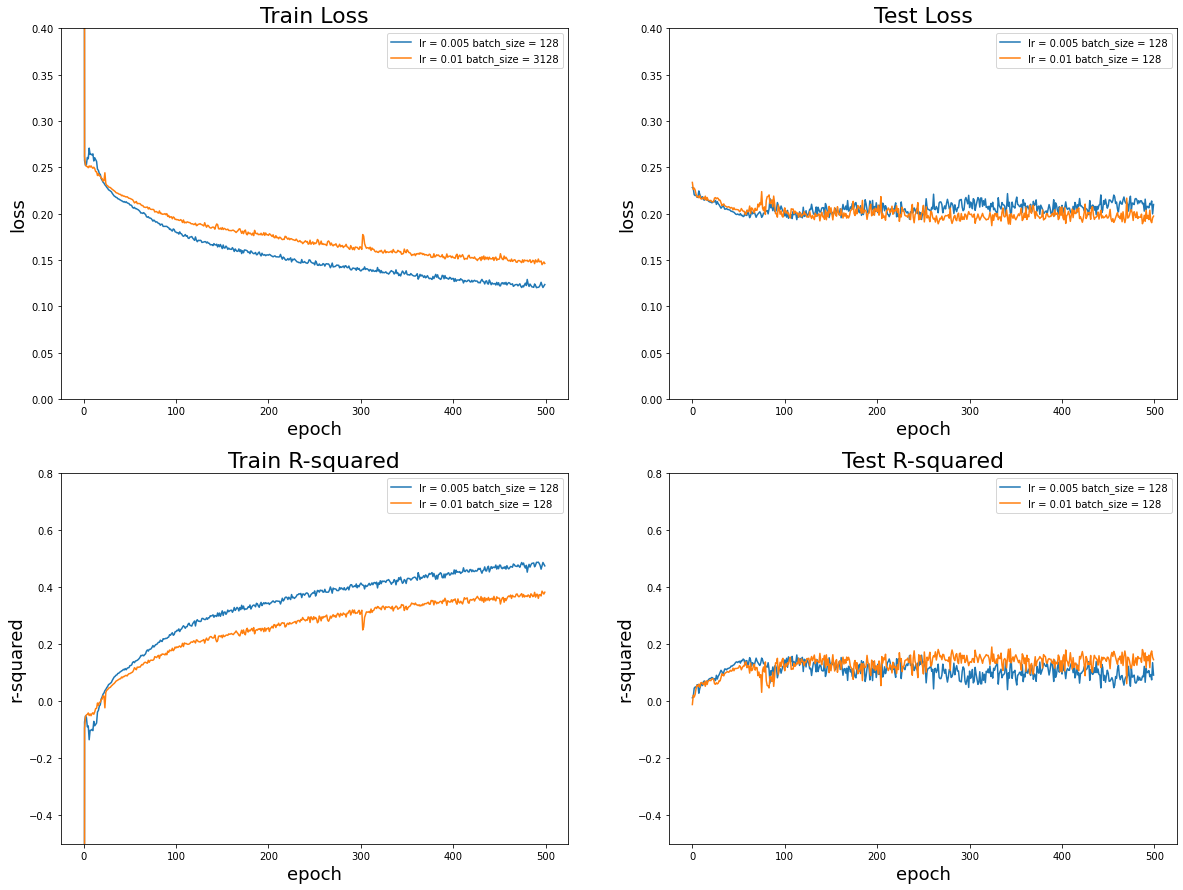

<Figure size 432x288 with 0 Axes>

In [26]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[0],label="lr = 0.005 batch_size = 128")
ax1.plot(train_losses_all[1],label="lr = 0.01 batch_size = 3128")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 0.4])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[0],label="lr = 0.005 batch_size = 128")
ax2.plot(test_losses_all[1],label="lr = 0.01 batch_size = 128")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 0.4])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[0],label="lr = 0.005 batch_size = 128")
ax3.plot(train_accs_all[1],label="lr = 0.01 batch_size = 128")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-0.5,0.8])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[0],label="lr = 0.005 batch_size = 128")
ax4.plot(test_accs_all[1],label="lr = 0.01 batch_size = 128")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-0.5,0.8])
plt.show()

### Model 1

{'batch_size': 128, 'epoch': 114, 'train_loss': 0.17379031712428117, 'test_loss': 0.19357627630233765, 'train_acc': 0.2701740019810278, 'test_acc': 0.1623249173283562}


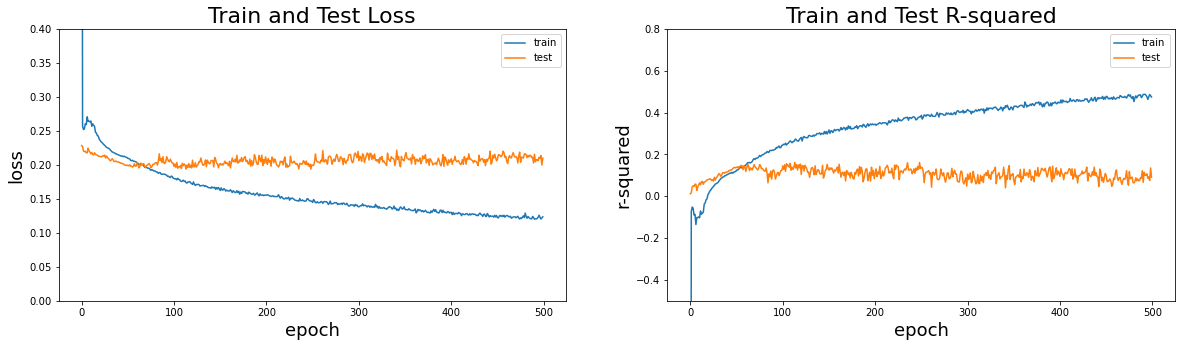

<Figure size 1440x360 with 0 Axes>

In [28]:
print(best_params_all[0])
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=22)
ax1.plot(train_losses_all[0],label="train")
ax1.plot(test_losses_all[0],label="test")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 0.4])

ax2.set_title("Train and Test R-squared", fontsize=22)
ax2.plot(train_accs_all[0],label="train")
ax2.plot(test_accs_all[0],label="test")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("r-squared", fontsize=18)
ax2.legend()
ax2.set_ylim([-0.5,0.8])

plt.show()

### Model 2

{'batch_size': 128, 'epoch': 325, 'train_loss': 0.1574653172149108, 'test_loss': 0.18711872398853302, 'train_acc': 0.3338725718196955, 'test_acc': 0.19026905359642143}


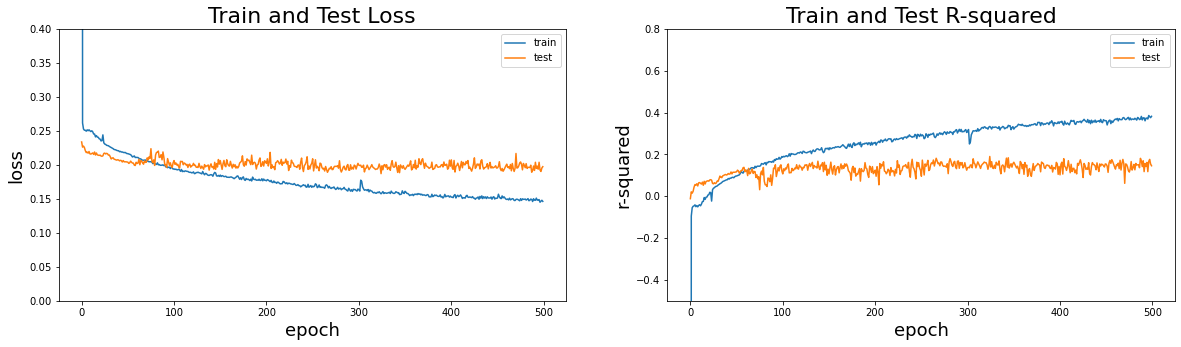

<Figure size 1440x360 with 0 Axes>

In [29]:
print(best_params_all[1])
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=22)
ax1.plot(train_losses_all[1],label="train")
ax1.plot(test_losses_all[1],label="test")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 0.4])

ax2.set_title("Train and Test R-squared", fontsize=22)
ax2.plot(train_accs_all[1],label="train")
ax2.plot(test_accs_all[1],label="test")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("r-squared", fontsize=18)
ax2.legend()
ax2.set_ylim([-0.5,0.8])

plt.show()

## 7. Results

In [9]:
model = GraphNeuralNetwork()
model.load_state_dict(torch.load('../../models/genotoxicity_graph_model_1.pt')) # best model
model.eval()

test_loader = GraphDataLoader(test_dataset, batch_size=4984, shuffle=False)

with torch.no_grad():
    for data in tqdm(test_loader):
        x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
        graph_predictions = model(x, edge_index, batch)

graph_predictions = np.array(graph_predictions)       

100%|██████████| 1/1 [00:07<00:00,  7.14s/it]


In [35]:
print_evaluate(y_test, graph_predictions)

MAE: 0.30230711138641964
MSE: 0.18711873448001773
RMSE: 0.4325722303616099
R2 Square 0.19026905359642143 



In [11]:
y_test = np.where(y_test<5, 1, 0)
graph_predictions = np.where(graph_predictions<5, 1, 0)

In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, graph_predictions)

0.7090690208667737